In [1]:
#  Imports

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy

from timeit import default_timer as timer

In [2]:
# loadmat aux function to load the matlab save files
# from: https://stackoverflow.com/review/suggested-edits/21667510

import scipy.io as spio

def loadmat(filename):
    '''
    this function should be called instead of direct spio.loadmat
    as it cures the problem of not properly recovering python dictionaries
    from mat files. It calls the function check keys to cure all entries
    which are still mat-objects
    '''
    def _check_keys(d):
        '''
        checks if entries in dictionary are mat-objects. If yes
        todict is called to change them to nested dictionaries
        '''
        for key in d:
            if isinstance(d[key], spio.matlab.mio5_params.mat_struct):
                d[key] = _todict(d[key])
        return d

    def _has_struct(elem):
        """Determine if elem is an array and if any array item is a struct"""
        return isinstance(elem, np.ndarray) and any(isinstance(
                    e, scipy.io.matlab.mio5_params.mat_struct) for e in elem)

    def _todict(matobj):
        '''
        A recursive function which constructs from matobjects nested dictionaries
        '''
        d = {}
        for strg in matobj._fieldnames:
            elem = matobj.__dict__[strg]
            if isinstance(elem, spio.matlab.mio5_params.mat_struct):
                d[strg] = _todict(elem)
            elif _has_struct(elem):
                d[strg] = _tolist(elem)
            else:
                d[strg] = elem
        return d

    def _tolist(ndarray):
        '''
        A recursive function which constructs lists from cellarrays
        (which are loaded as numpy ndarrays), recursing into the elements
        if they contain matobjects.
        '''
        elem_list = []
        for sub_elem in ndarray:
            if isinstance(sub_elem, spio.matlab.mio5_params.mat_struct):
                elem_list.append(_todict(sub_elem))
            elif _has_struct(sub_elem):
                elem_list.append(_tolist(sub_elem))
            else:
                elem_list.append(sub_elem)
        return elem_list
    data = scipy.io.loadmat(filename, struct_as_record=False, squeeze_me=True)
    return _check_keys(data)

In [3]:
# Matlab code conversion

# Read matlab file instead of excelfile (easier conversion)
data = loadmat('matlab.mat')

In [4]:
# Linearize the generator prices

# genCofA=data.generator.limit(:,:,6); -> MATLAB starts with 1, so we need the index -1
# genCofB=data.generator.limit(:,:,7);
# genCofC=data.generator.limit(:,:,8);

genCofA = data['data']['generator']['limit'][:, :, 5]
genCofB = data['data']['generator']['limit'][:, :, 6]
genCofC = data['data']['generator']['limit'][:, :, 7]

In [5]:
# Options for simulation

#options 
iterlim = 1000000000
reslim = 5000000000

In [6]:
# Definir o numero de resources usados

numGen = np.arange(1, data['data']['parameterData']['resources']['numGen'] + 1)
numLoad = np.arange(1, data['data']['parameterData']['resources']['numLoad'] + 1)
numStor = np.arange(1, data['data']['parameterData']['resources']['numStor'] + 1)
numV2G = np.arange(1, data['data']['parameterData']['resources']['numV2G'] + 1)
numCStat = np.arange(1, data['data']['parameterData']['resources']['numCStat'] + 1)
numPeriod = np.arange(1, data['data']['parameterData']['resources']['period'] + 1)
numBus = np.arange(1) # forced to 1
nOwner = np.arange(1, data['data']['parameterData']['resources']['owners'] + 1)

In [7]:
# Define as strings com os recursos para mandar para GAMS

gen = np.max(numGen)
Load = np.max(numLoad)
stor = np.max(numStor)
v2g = np.max(numV2G)
cs = np.max(numCStat)
period = np.max(numPeriod)
Bus = np.max(numBus)

In [8]:
#% Definir as matrizes com os dados para o GAMS

# General Info
pMaxImp = data['data']['parameterData']['generalInfo']['P_Max_Imp']
pMaxExp = data['data']['parameterData']['generalInfo']['P_Max_Exp']
buyPrice = data['data']['parameterData']['generalInfo']['Energy_Buy_Price']
sellPrice = data['data']['parameterData']['generalInfo']['Energy_Sell_Price']

# Geradores
genLimit = data['data']['generator']['limit'][numGen[0]-1:numGen[-1]+1, numPeriod[0]-1:numPeriod[-1]+1, :]
genInfo = data['data']['generator']['info']

# Cargas
loadLimit = data['data']['load']['limit'][numLoad[0]-1:numLoad[-1]+1, numPeriod[0]-1:numPeriod[-1]+1, :]

# Baterias
storLimit = data['data']['storage']['limit'][numStor[0]-1:numStor[-1]+1, numPeriod[0]-1:numPeriod[-1]+1, :]
storInfo = data['data']['storage']['info']

# Veiculos
v2gLimit = data['data']['vehicle']['limit']
v2gInfo = data['data']['vehicle']['info']

# Charging Station
csLimit = data['data']['cstation']['limit'][numCStat[0]-1:numCStat[-1]+1, numPeriod[0]-1:numPeriod[-1]+1, :]
csInfo = data['data']['cstation']['info']

# Connect EV to Charging Station
EV_CS_Info = data['data']['vehicle']['timeInfo']['V2GinCS']

In [9]:
# Definir os dados da rede para o GAMS

# Linhas
branchData = data['data']['network']['branch']

# Tensão Máxima
voltageMax = data['data']['parameterData']['network']['voltageMax']

# Tensão Mínima
voltageMin = data['data']['parameterData']['network']['voltageMin']

# Angulo Máximo
angleMax = data['data']['parameterData']['network']['angleMax']

# Angulo Mínimo
angleMin = data['data']['parameterData']['network']['angleMin']

# Definir a matriz das admitancias
ybus = data['data']['parameterData']['network']['ybus']
diag = data['data']['parameterData']['network']['diag']
branchID = data['data']['parameterData']['network']['branch']

In [10]:
#% Anular o custo fixo e quadratico da DG

genLimit[:, :, 3] = 0
genLimit[:, :, 5] = 0

genLimit = np.append(genLimit, np.zeros(shape=(7, 24, 4)), axis=2)

# Not necessary anymore
#genLimit[:, :, 9] = 0
#genLimit[:, :, 11] = 0

In [11]:
#** Define the fixed sets structure to use in the parameters of the gams optimization process
#set genLimitInfo 'Indicate the number of columns of information from generators'
#/1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12/;

#set loadLimitInfo 'Indicate the number of columns of information from loads'
#/1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12/;

#set storLimitInfo 'Indicate the number of columns of information from storage units'
#/1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12/;

#set v2gLimitInfo 'Indicate the number of columns of information from electric vehicles'
#/1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12/;

#set csLimitInfo 'Indicate the number of columns of information from charging stations'
#/1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12/;

NCOLS = 12

genLimitInfo = np.arange(1, NCOLS+1)
loadLimitInfo = np.arange(1, NCOLS+1)
storLimitInfo = np.arange(1, NCOLS+1)
v2gLimitInfo = np.arange(1, NCOLS+1)
csLimitInfo = np.arange(1, NCOLS+1)

#genLimitInfo = np.arange(1, genLimit.shape[2]+1)
#loadLimitInfo = np.arange(1, loadLimit.shape[2]+1)
#storLimitInfo = np.arange(1, storLimit.shape[2]+1)
#v2gLimitInfo = np.arange(1, v2gLimit.shape[2]+1)
#csLimitInfo = np.arange(1, csLimit.shape[0]+1)

In [12]:
# * Define the several sets structure used in the gams optimization process, 
# these sets depends the number of resources used in matlab code

_t = np.arange(1, period+1)
_gen = np.arange(1, gen+1)
_Load = np.arange(1, Load+1)
_stor = np.arange(1, stor+1)
_v2g = np.arange(1, v2g+1)
_cs = np.arange(1, cs+1)

In [13]:
# Aux function to convert numpy into dictionaries

def _auxDictionary(a):
    temp_dictionary = {}
    
    if len(a.shape) == 3:
        for dim0 in np.arange(a.shape[0]):
            for dim1 in np.arange(a.shape[1]):
                for dim2 in np.arange(a.shape[2]):
                    temp_dictionary[(dim0+1, dim1+1, dim2+1)] = a[dim0, dim1, dim2]
    elif len(a.shape) == 2:
        for dim0 in np.arange(a.shape[0]):
            for dim1 in np.arange(a.shape[1]):
                temp_dictionary[(dim0+1, dim1+1)] = a[dim0, dim1]
                
    else:
        for dim0 in np.arange(a.shape[0]):
            temp_dictionary[(dim0+1)] = a[dim0]
                
    return temp_dictionary

#temp_dict1 = _auxDictionary(loadLimit)

NameError: name 'result_genActPower' is not defined

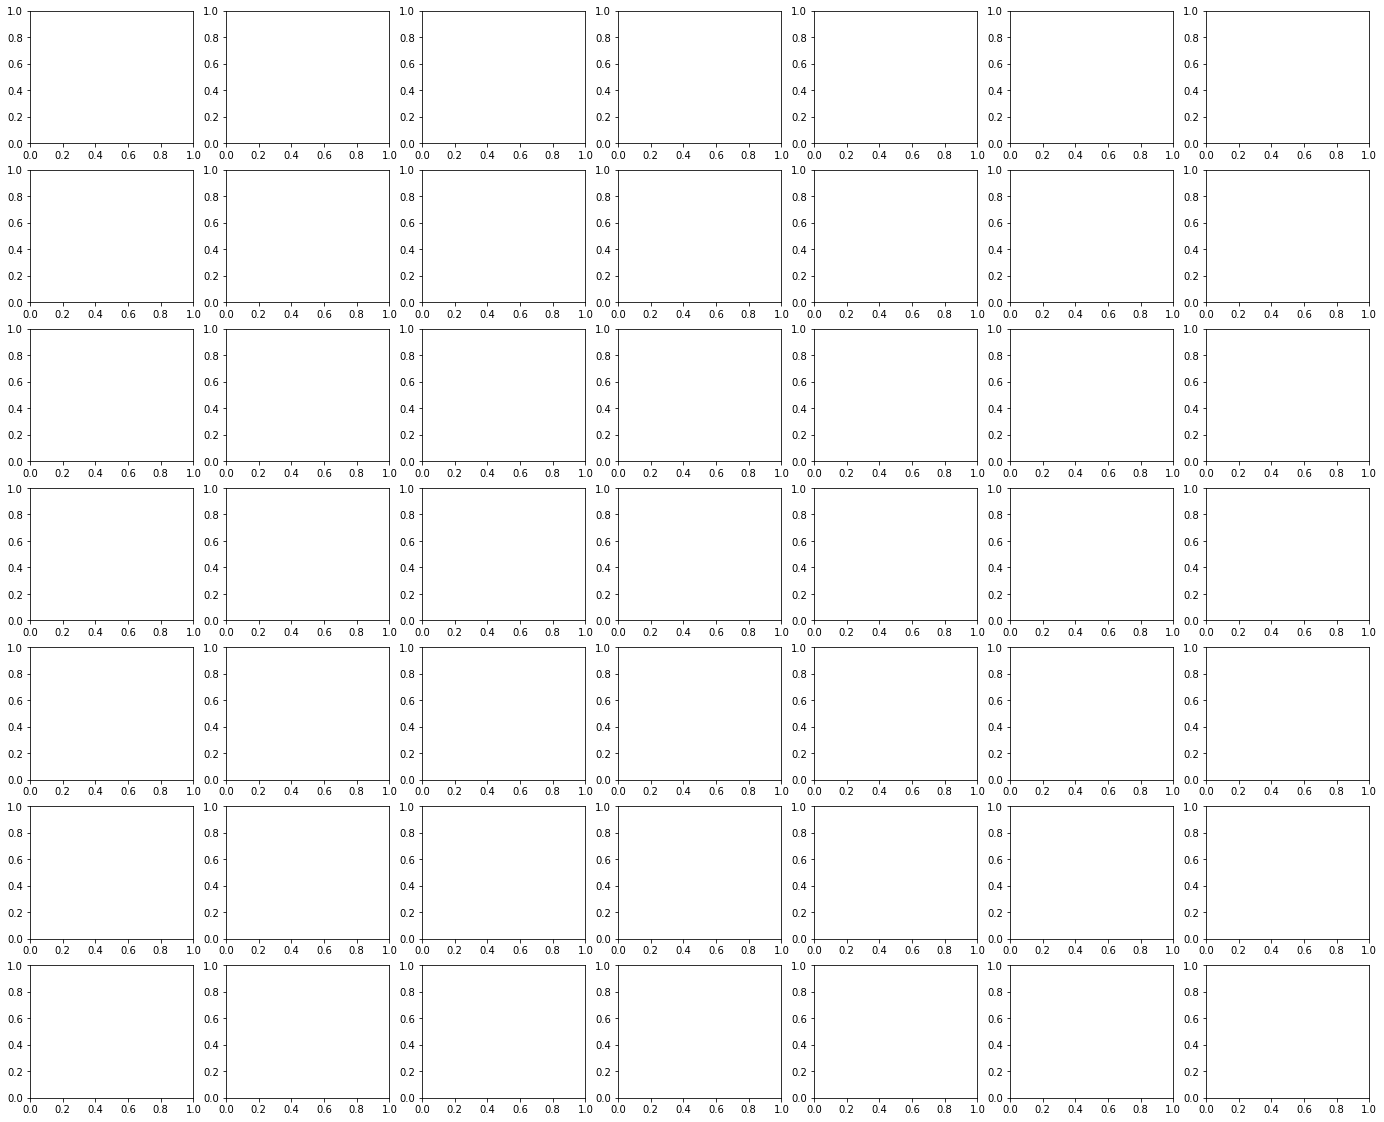

In [14]:
# Plot results

fig, axs = plt.subplots(nrows=7, ncols=7, figsize=(24, 20))

for i in np.arange(7):
    # Generators
    axs[i, 0].plot(result_genActPower.values[i])
    axs[i, 0].plot(result_genExcActPower.values[i])
    axs[i, 0].legend(['genActPower', 'genExcActPower'])
    
for i in np.arange(6):
    # Loads
    axs[i, 1].plot(loadLimit[:, :, 0][i, :])
    axs[i, 1].plot(result_loadRedActPower.values[i])
    axs[i, 1].plot(result_loadCutActPower.values[i])
    axs[i, 1].plot(result_loadENS.values[i])
    axs[i, 1].legend(['loadActPower', 'loadRedActPower', 'loadCutActPower', 'loadENS'])


axs[0, 2].plot(result_pimp.values)
axs[0, 2].plot(result_pexp.values)
axs[0, 2].legend(['pImp', 'pExp'])


for i in range(3):
    axs[i, 3].plot(result_storEnerState.values[i])
    axs[i, 3].legend(['storEnerState'])
    
for i in range(3):
    axs[i, 4].plot(result_storDchActPower.values[i])
    axs[i, 4].legend(['storDchActPower'])
    
for i in range(3):
    axs[i, 5].plot(result_storChActPower.values[i])
    axs[i, 5].legend(['storChActPower'])

for i in range(5):
    axs[i, 6].plot(result_v2gEnerState.values[i])
    axs[i, 6].legend(['v2gEnerState'])


plt.show()

In [14]:
# Pymoo import

import pymoo
from pymoo.core.problem import Problem
from pymoo.core.problem import ElementwiseProblem
from pymoo.algorithms.soo.nonconvex.ga import GA
from pymoo.optimize import minimize
from pymoo.termination import get_termination
from pymoo.termination.default import DefaultSingleObjectiveTermination
from multiprocessing.pool import ThreadPool
from pymoo.core.problem import StarmapParallelization

import multiprocessing
import tqdm

In [15]:
# Class to speed up code execution

class HeuristicData(object):
    def __init__(self):
        return
    
    
    def objectiveFunction(self):
        return
    
    
    def doIteration(self):
        return
    
    
    def newIteration(self):
        return
    

class EnergyCommunity(HeuristicData):
    
    def __init__(self, parameters, variables):
        # Set initial values
        self.__initial_variables__ = variables
        self.__var_idx__ = [variables[v].ravel().shape[0] for v in variables.keys()]
        self.__var_names__ = list(variables.keys())
        
        # Value assignments
        self.parameterAssign(parameters)
        self.variableAssign(variables)
        
        self.encoded = None
        self.decoded = None
        
        
        self.objFn = 0
        
        self.checkV2G()
        self.checkCS()
        return
    
    
    def parameterAssign(self, parameters):
        self.genLimit = parameters['genLimit']
        self.genInfo = parameters['genInfo']
        self.pImpMax = parameters['pImpMax']
        self.pExpMax = parameters['pExpMax']
        self.loadLimit = parameters['loadLimit']
        self.loadActPower = parameters['loadActPower']
        self.storLimit = parameters['storLimit']
        self.storInfo = parameters['storInfo']
        self.v2gLimit = parameters['v2gLimit']
        self.v2gInfo = parameters['v2gInfo']
        self.csLimit = parameters['csLimit']
        self.csInfo = parameters['csInfo']
        self.EV_CS_Info = parameters['EV_CS_Info']
        self.buyPrice = parameters['buyPrice']
        self.sellPrice = parameters['sellPrice']
        self.t = parameters['t']
        self.gen = parameters['gen']
        self.load = parameters['load']
        self.stor = parameters['stor']
        self.v2g = parameters['v2g']
        self.cs = parameters['cs']
        #self.storPieceSegments = parameters['storPieceSegments']
        self.storCapCost = parameters['storCapCost']
        #self.storCyclesMult = parameters['storCyclesMult']
        self.v2gCapCost = parameters['v2gCapCost']
        #self.v2gCyclesMult = parameters['v2gCyclesMult']
        
        return
    
    
    def variableAssign(self, variables):
        self.genActPower = variables['genActPower']
        self.genExcActPower = variables['genExcActPower']
        self.pImp = variables['pImp']
        self.pExp = variables['pExp']
        self.loadRedActPower = variables['loadRedActPower']
        self.loadENS = variables['loadENS']
        self.storDchActPower = variables['storDchActPower']
        self.storChActPower = variables['storChActPower']
        self.EminRelaxStor = variables['EminRelaxStor']
        #self.v2gDchActPower = variables['v2gDchActPower']
        #self.v2gChActPower = variables['v2gChActPower']
        self.genXo = variables['genXo']
        self.loadXo = variables['loadXo']
        self.storDchXo = variables['storDchXo']
        self.storChXo = variables['storChXo']
        self.v2gDchXo = variables['v2gDchXo']
        self.v2gChXo = variables['v2gChXo']
        #self.storSegSoC = self.variables['storSegSoC']
        #self.v2gSegSoC = self.variables['v2gSegSoC']
        #self.storSegXo = self.variables['storSegXo']
        #self.v2gSegXo = self.variables['v2gSegXo']
        
        self.loadCutActPower = np.zeros((len(self.load),
                                         len(self.t)))
        
        self.storEnerState = np.zeros((len(self.stor),
                                       len(self.t)))
        
        #self.v2gEnerState = np.zeros((len(self.v2g),
        #                              len(self.t)))
        
        #self.EminRelaxEv = np.zeros((len(self.v2g),
        #                             len(self.t)))
        
        return
    
    
    def objectiveFunction(self):
        i: cython.int
        t: cython.int
        g: cython.int
        l: cython.int
        s: cython.int
        v: cython.int
            
        t_range: cython.int[self.t.shape[0]] = range(self.t.shape[0])
        gen_range: cython.int[self.gen.shape[0]] = range(self.gen.shape[0])
        load_range: cython.int[self.load.shape[0]] = range(self.load.shape[0])
        stor_range: cython.int[self.stor.shape[0]] = range(self.stor.shape[0])
        v2g_range: cython.int[self.v2g.shape[0]] = range(self.v2g.shape[0])
            
        balance_gens: cython.float[self.t.shape[0]] = np.zeros(self.t.shape[0])
        balance_loads: cython.float[self.t.shape[0]] = np.zeros(self.t.shape[0])
        balance_stor: cython.float[self.t.shape[0]] = np.zeros(self.t.shape[0])
        balance_v2g: cython.float[self.t.shape[0]] = np.zeros(self.t.shape[0])
            
        for t in t_range:
            balance_gens[t] = np.sum([self.genActPower[g, t] - self.genExcActPower[g, t]
                                      for g in gen_range])
            
            balance_loads[t] = np.sum([self.loadActPower[l, t] - self.loadRedActPower[l, t] - self.loadCutActPower[l, t] - self.loadENS[l, t] 
                                       for l in load_range])
            
            balance_stor[t] = np.sum([self.storChActPower[s, t] - self.storDchActPower[s, t]
                                      for s in stor_range])
            
            balance_v2g[t] = np.sum([self.v2gChActPower[v, t] - self.v2gDchActPower[v, t]
                                     for v in v2g_range])
            
        balance_rest: cython.float[self.t.shape[0]] = balance_gens - balance_loads - balance_stor - balance_v2g
            
        # Balance and import/export penalties
        mask = balance_rest > 0
        self.pImp[mask] *= 0
        self.pExp[mask] = balance_rest[mask]
        
        mask = balance_rest < 0
        self.pExp[mask] *= 0
        self.pImp[mask] = abs(balance_rest)[mask]
        
        
        # Attribute penalties for import/export
        balance_penalty: cython.float = 0
        for t in t_range:
            if (self.pImp[t] > self.pImpMax[t]):
                balance_penalty += 100000
                
            if (self.pExp[t] > self.pExpMax[t]):
                balance_penalty += 100000
                
            
        temp_gens: cython.float = sum([self.genActPower[g, t] * self.genLimit[g, t, 2] + self.genExcActPower[g, t] * self.genLimit[g, t, 4]
                                       for t in t_range for g in gen_range])
            
        temp_loads: cython.float = sum([self.loadRedActPower[l, t] * self.loadLimit[l, t, 6] + self.loadCutActPower[l, t] * self.loadLimit[l, t, 7] + self.loadENS[l, t] * self.loadLimit[l, t, 9] 
                                        for t in t_range for l in load_range])
            
        #temp_stor: cython.float = sum([self.storDchActPower[s, t] * self.storLimit[s, t, 3] - self.storChActPower[s, t] * self.storLimit[s, t, 2] + self.EminRelaxStor[s, t] * 200 
        #                               for t in t_range for s in stor_range])
            
        #temp_v2g: cython.float = sum([self.v2gDchActPower[v, t] * self.v2gLimit[v, t, 6] - self.v2gChActPower[v, t] * self.v2gLimit[v, t, 5] + self.EminRelaxEv[v, t] * 200
        #                              for t in t_range for v in v2g_range])
            
        temp_rest: cython.float = sum([self.pImp[t] * self.buyPrice[t] - self.pExp[t] * self.sellPrice[t] 
                                       for t in t_range])   
        
        temp_storDeg = sum([self.storCapCost[s] * (self.storEnerState[s, t]/self.storInfo[s, 5] - 0.63)**2 + self.storDchActPower[s, t] * self.storLimit[s, t, 3] + self.storChActPower[s, t] * self.storLimit[s, t, 2] + (6.5e-3)/self.storInfo[s, 5] * self.storChActPower[s, t]**2
                            for t in t_range for s in stor_range])
        
        temp_v2gDeg = sum([self.v2gCapCost[v] * (self.v2gEnerState[v, t]/self.v2gInfo[v, 4] - 0.63)**2 + self.v2gDchActPower[v, t] * self.v2gLimit[v, t, 6] + self.v2gChActPower[v, t] * self.v2gLimit[v, t, 5] + (6.5e-3)/self.v2gInfo[v, 4] * self.v2gChActPower[v, t]**2
                           for t in t_range for v in v2g_range])
            
        #temp_storDeg: cython.float = sum([self._auxStorDegCost(s, t) for t in t_range for s in stor_range])
            
        #temp_v2gDeg: cython.float = sum([self._auxV2GDegCost(v, t) for t in t_range for v in v2g_range])
        
        #self.objFn = (temp_gens + temp_loads + temp_stor + temp_v2g + temp_rest)*1.0 + balance_penalty + temp_storDeg# + temp_v2gDeg
        self.objFn = temp_gens + temp_loads + temp_rest + balance_penalty + temp_storDeg + temp_v2gDeg

        return
    
    
    def doIteration(self):
        self.checkImpExp()
        self.checkGens()
        self.checkLoads()
        self.checkStor()
        #self.new_checkV2G()
        #self.checkCS()
        
        self.objectiveFunction()
        
        self.encoded = self.encode()
        return
    
    
    def newIteration(self, encoded_vals):
        self.variableAssign(self.decode(encoded_vals))
        self.doIteration()
        return

    
    def checkImpExp(self):
        # Imports
        mask = self.pImp >= self.pImpMax
        self.pImp[mask] = self.pImpMax[mask]
        
        mask = self.pImp < 0
        self.pImp[mask] *= 0
        
        # Exports
        mask = self.pExp > self.pExpMax
        self.pExp[mask] = self.pExpMax[mask]
        
        mask = self.pExp < 0
        self.pExp[mask] *= 0
        
        return
    
    
    def checkGens(self):
        self.genXo = (self.genXo > 0.5).astype(int)
        
        # Maximum generation
        mask = self.genActPower > self.genLimit[:, :, 0]
        self.genActPower[mask] = self.genLimit[:, :, 0][mask]
        
        mask = self.genActPower < 0
        self.genActPower[mask] *= 0
    
        
        # Generator types - type 1
        mask = self.genInfo[:, 1] == np.ones((self.genInfo[:, 4].shape))
        self.genActPower[mask] = (self.genLimit[:, :, 0] * self.genXo)[mask]
        
        # Generator types - type 2
        mask = self.genInfo[:, 1] == 2*np.ones((self.genInfo[:, 4].shape))
        self.genActPower[mask] = self.genLimit[:, :, 0][mask]
    
        return
    
    
    def checkLoads(self):
        
        # Bound the values to either 0 or 1
        self.loadXo = (self.loadXo > 0.5).astype(int)
        
        # Build a matrix of ones
        temp_vals = np.ones((self.loadRedActPower.shape[0],
                             self.loadRedActPower.shape[1]))
        
        # RedAct value checks
        mask = self.loadRedActPower > temp_vals * self.loadLimit[:, :, 2]
        self.loadRedActPower[mask] = (temp_vals * self.loadLimit[:, :, 2])[mask]
        
        mask = self.loadRedActPower < 0
        self.loadRedActPower[mask] *= 0
        
        # loadCut value checks
        self.loadCutActPower = self.loadLimit[:, :, 3] * self.loadXo
        #self.loadCutActPower *= self.loadXo
        
        # loadENS
        temp_vals = self.loadActPower - self.loadRedActPower - self.loadCutActPower
        mask = self.loadENS > temp_vals
        self.loadENS[mask] = temp_vals[mask]
        return
    
    
    def checkStor(self):
        
        # Binary variables bound
        self.storChXo = (self.storChXo > 0.5).astype(int)
        self.storDchXo = (self.storDchXo > 0.5).astype(int)
        
        mask = None
        # Discharge inequality
        mask = self.storDchActPower > self.storLimit[:, :, 1]
        self.storDchActPower[mask] = self.storLimit[:, :, 1][mask]
        
        mask = self.storDchActPower <= 0
        self.storDchActPower[mask] *= 0
        
        # Charge inequality
        mask = self.storChActPower > self.storLimit[:, :, 0]
        self.storChActPower[mask] = self.storLimit[:, :, 0][mask]
        
        mask = self.storChActPower <= 0
        self.storChActPower[mask] *= 0
        
        # Initial stor SoC
        self.storEnerState[:, 0] = self.storInfo[:, 5] * (self.storInfo[:, 9]/100) + self.storChActPower[:, 0] * (self.storInfo[:, 7]/100) - self.storDchActPower[:, 0]/(self.storInfo[:, 8]/100)
        
        t: cython.int
        t_range: cython.int[len(self.t) - 1] = range(1, len(self.t))
        # Fix the timestep dependencies
        for t in t_range:
            # Check if charging
            mask = self.storChXo[:, t] > np.zeros(self.storChXo[:, t].shape)
            charged = self.storChActPower[:, t] * (self.storInfo[:, 7]/100)
            # Prevent charging beyong limit
            secondary_mask = (self.storEnerState[:, t-1] + charged) > self.storInfo[:, 5]
            self.storChActPower[:, t][secondary_mask] = ((self.storInfo[:, 5] - self.storEnerState[:, t-1]) / (self.storInfo[:, 7]/100))[secondary_mask]
            
            # Check if discharging
            mask = self.storDchXo[:, t] > np.zeros(self.storDchXo[:, t].shape)
            discharged = self.storDchActPower[:, t] / (self.storInfo[:, 8]/100)
            secondary_mask = (self.storEnerState[:, t-1] - discharged) < 0
            self.storDchActPower[:, t][secondary_mask] = (self.storEnerState[:, t-1] * (self.storInfo[:, 8]/100))[secondary_mask]
            
            self.storChActPower[:, t] *= self.storChXo[:, t]
            self.storDchActPower[:, t] *= self.storDchXo[:, t]
            self.storEnerState[:, t] = self.storEnerState[:, t-1] + (self.storChActPower[:, t] * (self.storInfo[:, 7]/100)) - (self.storDchActPower[:, t]/(self.storInfo[:, 8]/100))
            
            mask = self.storEnerState[:, t] < self.storInfo[:, 6] * (self.storInfo[:, 5] / 100) - self.EminRelaxStor[:, t]
            self.storEnerState[:, t][mask] = (self.storInfo[:, 6] * (self.storInfo[:, 5] / 100) - self.EminRelaxStor[:, t])[mask]
        return
    
    
    def checkV2G_old(self):
        
        # Binary variables bounding
        self.v2gChXo = (self.v2gDchXo < 0.33).astype(int)
        self.v2gDchXo = (self.v2gDchXo > 0.66).astype(int)
        
        mask = None
        t: cython.int
        t_range: cython.int[len(self.t) - 1] = range(1, len(self.t))
        for t in t_range:
            mask = self.v2gEnerState[:, t-1] == self.v2gInfo[:, 4]
            self.v2gChXo[:, t][mask] *= 0
            self.v2gChActPower[:, t][mask] *= 0
            
            mask = self.v2gEnerState[:, t-1] == 0
            self.v2gDchXo[:, t][mask] *= 0
            self.v2gDchActPower[:, t][mask] *= 0
            
        # Discharge rate
        temp_vals = self.v2gLimit[:, :, 4] * self.v2gLimit[:, :, 0] * self.v2gDchXo
        mask = self.v2gDchActPower > temp_vals
        self.v2gDchActPower[mask] = temp_vals[mask]
        
        
        
        # Charge rate
        temp_vals = self.v2gLimit[:, :, 3] * self.v2gLimit[:, :, 0] * self.v2gChXo
        mask = self.v2gChActPower > temp_vals
        self.v2gChActPower[mask] = temp_vals[mask]
        
        # Energy Balance Initial Eq
        mask = self.v2gLimit[:, 0, 0] == 0
        temp_vals = self.v2gLimit[:, 0, 1] + (self.v2gChActPower[:, 0] * self.v2gInfo[:, 7]) - (self.v2gDchActPower[:, 0] / self.v2gInfo[:, 8])
        self.v2gEnerState[:, 0][mask] = temp_vals[mask]
        
        # Energy Balance 1
        mask = self.v2gLimit[:, :-1, 0] == 1
        secondary_mask = self.v2gLimit[:, 1:, 0] == 1
        
        temp_vals = [self.v2gEnerState[:, t-1] + self.v2gLimit[:, t, 1] + (self.v2gChActPower[:, t] * self.v2gInfo[:, 7]) - (self.v2gDchActPower[:, t] / self.v2gInfo[:, 8])
                     for t in range(1, len(self.t))]
        temp_vals = np.array(temp_vals).transpose()
        self.v2gEnerState[:, 1:][mask & secondary_mask] = temp_vals[mask & secondary_mask]
        
        # Energy Balance 2
        mask = self.v2gLimit[:, :-1, 0] == 0
        temp_vals = [self.v2gLimit[:, t, 1] + (self.v2gChActPower[:, t] * self.v2gInfo[:, 8]) + (self.v2gDchActPower[:, t] / self.v2gInfo[:, 8])
                     for t in range(1, len(self.t))]
        temp_vals = np.array(temp_vals).transpose()
        self.v2gEnerState[:, 1:][mask & secondary_mask] = temp_vals[mask & secondary_mask]
        return
    
    
    def new_checkV2G(self):
        self.v2gDchXo = (self.v2gDchXo > 0.5).astype(int)
        self.v2gChXo = (self.v2gChXo > 0.5).astype(int)
        
        mask = self.v2gDchXo + self.v2gChXo == 2*np.ones(self.v2gDchXo.shape)
        self.v2gDchXo[mask] *= 0
        
        # Discharge rate
        mask = self.v2gDchActPower > self.v2gLimit[:, :, 4] * self.v2gLimit[:, :, 0] * self.v2gDchXo
        self.v2gDchActPower[mask] = (self.v2gLimit[:, :, 4] * self.v2gLimit[:, :, 0] * self.v2gDchXo)[mask]
        
        # Charge rate
        mask = self.v2gChActPower > self.v2gLimit[:, :, 3] * self.v2gLimit[:, :, 0] * self.v2gChXo
        self.v2gChActPower[mask] = (self.v2gLimit[:, :, 3] * self.v2gLimit[:, :, 0] * self.v2gChXo)[mask]
        
        # Energy Limits
        mask = self.v2gEnerState > (np.ones(self.v2gEnerState.shape).transpose() * self.v2gInfo[:, 4]).transpose()
        self.v2gEnerState[mask] = (np.ones(self.v2gEnerState.shape).transpose() * self.v2gInfo[:, 4]).transpose()[mask]
        
        # bat balance zero
        mask = self.v2gLimit[:, :, 0] == np.zeros(self.v2gLimit[:, :, 0].shape)
        self.v2gEnerState[mask] *= 0
        
        # bat balance initial eq
        mask = self.v2gLimit[:, 0, 0] == np.ones(self.v2gLimit[:, 0, 0].shape)
        self.v2gLimit[:, 0, 0][mask] = (self.v2gLimit[:, 0, 2] + self.v2gChActPower[:, 0] * self.v2gInfo[:, 7] - (self.v2gDchActPower[:, 0] / self.v2gInfo[:, 8]))[mask]
        
        # batery update
        t: cython.int
        t_range: cython.int[len(self.t) - 1] = range(1, len(self.t))
        for t in t_range:
            mask = (self.v2gLimit[:, t-1, 0] + self.v2gLimit[:, t, 0]) == 2*np.ones(self.v2gLimit[:, t, 0].shape)
            self.v2gEnerState[:, t][mask] = (self.v2gEnerState[:, t-1] + self.v2gLimit[:, t, 1] + self.v2gChActPower[:, t] * self.v2gInfo[:, 7] - (self.v2gChActPower[:, t] / self.v2gInfo[:, 8]))[mask]
            
            mask = self.v2gLimit[:, t-1, 0] == np.zeros(self.v2gLimit[:, t-1, 0].shape)
            secondary_mask = self.v2gLimit[:, t, 0] == np.ones(self.v2gLimit[:, t, 0].shape)
            self.v2gEnerState[:, t][mask & secondary_mask] = (self.v2gLimit[:, t, 1] + self.v2gChActPower[:, t] * self.v2gInfo[:, 7] + (self.v2gDchActPower[:, t] / self.v2gInfo[:, 8]))[mask & secondary_mask]
        
        
        # Energy Limits -> again after changing the SOC
        mask = self.v2gEnerState > (np.ones(self.v2gEnerState.shape).transpose() * self.v2gInfo[:, 4]).transpose()
        self.v2gEnerState[mask] = (np.ones(self.v2gEnerState.shape).transpose() * self.v2gInfo[:, 4]).transpose()[mask]
        return
    
    
    def checkV2G(self):
        # Binary variables bounding
        #self.v2gChXo = (self.v2gDchXo < 0.33).astype(int)
        #self.v2gDchXo = (self.v2gDchXo > 0.66).astype(int)
        
        self.v2gDchActPower = np.zeros((len(self.v2g),
                                        len(self.t)))
        
        self.v2gChActPower = np.zeros((len(self.v2g),
                                       len(self.t)))
        
        self.v2gEnerState = np.zeros((len(self.v2g),
                                      len(self.t)))
        
        self.EminRelaxEv = np.zeros((len(self.v2g),
                                     len(self.t)))
        
        # Bound binary variables
        self.v2gChXo = (self.v2gChXo > 0.5).astype(int)
        self.v2gDchXo = (self.v2gDchXo > 0.5).astype(int)
        #self.v2gChXo = 1 - self.v2gDchXo

        mask = None

        v: cython.int
        c: cython.int

        # Discharge rate
        #temp_val = par['v2gLimit'][:, :, 4] * par['v2gLimit'][:, :, 0]
        #mask = pop['v2gDchActPower'] > temp_val
        #pop['v2gDchActPower'][mask] = temp_val[mask]


        # Charge rate
        #temp_val = par['v2gLimit'][:, :, 3] * par['v2gLimit'][:, :, 0]
        #mask = pop['v2gChActPower'] > temp_val
        #pop['v2gChActPower'][mask] = temp_val[mask]

        self.v2gDchActPower = self.v2gLimit[:, :, 4] * self.v2gLimit[:, :, 0]
        self.v2gChActPower = self.v2gLimit[:, :, 3] * self.v2gLimit[:, :, 0]

        # V2G constraints
        v_range: cython.int[len(self.v2g)] = range(len(self.v2g))
        c_range: cython.int[len(self.cs)] = range(len(self.cs))
        for v in v_range:
            # Check connection to charging stations
            isConnected = False
            connectedTo = 0

            # Check the charging stations
            for c in c_range:
                isConnected = True
                if self.EV_CS_Info[v, c, 0] > 0:
                    self.v2gChActPower[v, 0] = min(self.v2gChActPower[v, 0], self.csInfo[c, 4])
                    self.v2gDchActPower[v, 0] = min(self.v2gDchActPower[v, 0], self.csInfo[c, 5])

                    connectedTo = c
                else:
                    self.v2gDchXo[v, 0] = 0
                    self.v2gChXo[v, 0] = 0

            if self.v2gChXo[v, 0] + self.v2gDchXo[v, 0] > 1:
                self.v2gDchXo[v, 0] = 1 - self.v2gChXo[v, 0]

            mask = self.v2gLimit[v, :, 2] > 0
            temp_val = self.v2gLimit[v, :, 2][mask]

            if isConnected & (len(temp_val) > 0):
                if self.v2gEnerState[v, 0] < temp_val[0]:
                    next_index = next((idx for idx, val in np.ndenumerate(self.v2gLimit[v, :, 2]) 
                                       if val==temp_val[0]))[0]
                    min_tsteps = np.ceil((temp_val[0] - self.v2gEnerState[v, 0]) / self.csInfo[connectedTo, 4]) - 1

                    if min_tsteps >= next_index:
                        self.v2gChXo[v, 0] = 1
                        self.v2gDchXo[v, 0] = 0

            self.v2gChActPower[v, 0] *= self.v2gChXo[v,  0]
            self.v2gDchActPower[v, 0] *= self.v2gDchXo[v, 0]

            if self.v2gLimit[v, 0, 0] == 0:
                self.v2gEnerState[v, 0] = 0
            elif self.v2gLimit[v, 0, 0] == 1:
                self.v2gEnerState[v, 0] = self.v2gLimit[v, 0, 1] + self.v2gChActPower[v, 0] * self.v2gInfo[v, 7] - self.v2gDchActPower[v, 0] / self.v2gInfo[v, 8]

            #print('v2gEnerState: {}'.format(pop['v2gEnerState'][v, 0]))

            # Timestep
            for t in range(1, len(self.t)):

                isConnected = False
                connectedTo = 0

                # Check the charging stations
                for c in c_range:
                    if self.EV_CS_Info[v, c, t] > 0:
                        isConnected = True
                        self.v2gChActPower[v, t] = min(self.v2gChActPower[v, t], self.csInfo[c, 4])
                        self.v2gDchActPower[v, t] = min(self.v2gDchActPower[v, t], self.csInfo[c, 5])

                        connectedTo = c
                    else:
                        self.v2gDchXo[v, t] = 0
                        self.v2gChXo[v, t] = 0


                # Disable charge and discharge in the same period
                if self.v2gChXo[v, t] + self.v2gDchXo[v, t] > 1:
                    self.v2gDchXo[v, t] = 1 - self.v2gChXo[v, t]

                # Incentivise charge to meet minimum limits
                mask = self.v2gLimit[v, t:, 2] > 0
                temp_val = self.v2gLimit[v, t:, 2][mask]

                # Check if there are any requirements for EVs
                if isConnected & (len(temp_val) > 0):
                    if self.v2gEnerState[v, t-1] < temp_val[0]:
                        next_index = next((idx for idx, val in np.ndenumerate(self.v2gLimit[v, t:, 2]) 
                                           if val==temp_val[0]))[0]
                        min_tsteps = np.ceil((temp_val[0] - self.v2gEnerState[v, t-1])  /  self.csInfo[connectedTo, 4]) - 1
                        if min_tsteps <= next_index:
                            self.v2gChXo[v, t] = 1
                            self.v2gDchXo[v, t] = 0



                            if (self.v2gEnerState[v, t-1] + (self.v2gChActPower[v, t] * float(self.v2gInfo[v, 7]))) >= self.v2gInfo[v, 4]:
                                self.v2gChActPower[v, t] = (self.v2gInfo[v, 4] - self.v2gEnerState[v, t-1]) / float(self.v2gInfo[v, 7])

                # Prevent charging when battery is full
                if self.v2gEnerState[v, t-1] == self.v2gInfo[v, 4]:
                    #print('HERE')
                    self.v2gChXo[v, t] = 0

                # Prevent discharge when battery is empty
                elif self.v2gEnerState[v, t-1] == 0:
                    self.v2gDchXo[v, t] = 0

                self.v2gChActPower[v, t] *= self.v2gChXo[v, t]
                self.v2gDchActPower[v, t] *= self.v2gDchXo[v, t]

                # Update battery capacity
                if (self.v2gLimit[v, t-1, 0] == 1) & (self.v2gLimit[v, t, 0] == 1):
                    self.v2gEnerState[v, t] = self.v2gEnerState[v, t-1] + self.v2gLimit[v, t, 1] + (self.v2gChActPower[v, t] * float(self.v2gInfo[v, 7])) - (self.v2gDchActPower[v, t] / float(self.v2gInfo[v, 8]))
                elif (self.v2gLimit[v, t-1, 0] == 0) & (self.v2gLimit[v, t, 0] == 1):
                    self.v2gEnerState[v, t] = self.v2gLimit[v, t, 1] + (self.v2gChActPower[v, t] * float(self.v2gInfo[v, 7])) + (self.v2gDchActPower[v, t] / float(self.v2gInfo[v, 8]))

        return
    
    
    def checkCS(self):
        
        self.csActPower = np.zeros((len(self.cs),
                                    len(self.t)))
        
        self.csActPowerNet = np.zeros((len(self.cs),
                                       len(self.t)))
        
        #self.v2gChXo = (self.v2gDchXo < 0.33).astype(int)
        #self.v2gDchXo = (self.v2gDchXo > 0.66).astype(int)
        
        
        c: cython.int
        t: cython.int
        v: cython.int
            
        t_range: cython.int[len(self.t)] = range(len(self.t))
        c_range: cython.int[len(self.cs)] = range(len(self.cs))
        v_range: cython.int[len(self.v2g)] = range(len(self.v2g))
        
        # Timesteps
        for t in t_range:

            # Charging station constraints
            for c in c_range:

                temp_val = 0
                temp_val2 = 0
                for v in v_range:
                    if self.EV_CS_Info[v, c, t] > 0:
                        temp_val += (self.v2gChActPower[v, t]  - self.v2gDchActPower[v, t])
                        temp_val2 += (self.v2gChActPower[v, t] / (self.csInfo[c, 6] / 100) - (self.v2gDchActPower[v, t] * self.csInfo[c, 7] / 100))


                if temp_val > self.csInfo[c, 4]:
                    temp_val = self.csInfo[c, 4]
                if temp_val < -self.csInfo[c, 5]:
                    temp_val = -self.csInfo[c, 5]

                self.csActPower[c, t] = temp_val
                self.csActPowerNet[c, t] = temp_val2
        return
    
    
    def encode(self):
        var_dictionary = {'genActPower': self.genActPower,
                          'genExcActPower': self.genExcActPower,
                          'pImp': self.pImp,
                          'pExp': self.pExp,
                          'loadRedActPower': self.loadRedActPower,
                          'loadENS': self.loadENS,
                          'storDchActPower': self.storDchActPower,
                          'storChActPower': self.storChActPower,
                          'EminRelaxStor': self.EminRelaxStor,
                          #'v2gDchActPower': self.v2gDchActPower,
                          #'v2gChActPower': self.v2gChActPower,
                          'genXo': self.genXo,
                          'loadXo': self.loadXo,
                          'storDchXo': self.storDchXo,
                          'storChXo': self.storChXo,
                          'v2gDchXo': self.v2gDchXo,
                          'v2gChXo': self.v2gChXo
                         }
        
        result_concat = np.concatenate([var_dictionary[v].ravel() for v in var_dictionary.keys()])
        return result_concat
    
    
    def decode(self, new_variables):
        result_decoded = {}
        current_index = 0
        
        for idx in range(len(self.__var_names__)):
            result_index = current_index + self.__var_idx__[idx]
            result_decoded[self.__var_names__[idx]] = np.reshape(new_variables[current_index:result_index],
                                                                 self.__initial_variables__[self.__var_names__[idx]].shape)
            
            current_index = result_index
        
        
        return result_decoded
    

In [16]:
# Turn and recover vector for encoding

def encode(var_dictionary):
    result_concat = np.concatenate([var_dictionary[v].ravel() for v in var_dictionary.keys()])
    return result_concat


def decode(var_vector, var_dictionary):
    result_decoded = {}
    var_idx = [var_dictionary[v].ravel().shape[0] for v in var_dictionary.keys()]

    current_index = 0
    dictionary_names = list(var_dictionary.keys())
    
    for idx in np.arange(len(dictionary_names)):
        result_index = current_index + var_idx[idx]
        result_decoded[dictionary_names[idx]] = np.reshape(var_vector[current_index:result_index], 
                                                           var_dictionary[dictionary_names[idx]].shape)
        
        current_index = result_index
        
    return result_decoded

In [17]:
# Positive variables

genActPower = np.ones(shape=(len(_gen), len(_t)))
genExcActPower = np.ones(shape=(len(_gen), len(_t)))
pImp = np.ones(shape=(len(_t)))
pExp = np.ones(shape=(len(_t)))

# Load variables
loadRedActPower = np.ones(shape=(len(_Load), len(_t)))
loadCutActPower = np.ones(shape=(len(_Load), len(_t)))
loadENS = np.ones(shape=(len(_Load), len(_t)))

# Storage variables
storDchActPower = np.ones(shape=(len(_stor), len(_t)))
storChActPower = np.ones(shape=(len(_stor), len(_t)))
storEminRelaxStor = np.ones(shape=(len(_stor), len(_t)))
storEnerState = np.ones(shape=(len(_stor), len(_t)))

# V2G variables
v2gDchActPower = np.ones(shape=(len(_v2g), len(_t)))
v2gChActPower = np.ones(shape=(len(_v2g), len(_t)))
v2gEnerState = np.ones(shape=(len(_v2g), len(_t)))
v2gEminRelaxEv = np.ones(shape=(len(_v2g), len(_t)))

# Charging Stations
csActPower = np.ones(shape=(len(_cs), len(_t)))
csActPowerNet = np.ones(shape=(len(_cs), len(_t)))

# Storage deg
storSegSoC = np.ones(shape=(len(_stor), len(_t), 3))
v2gSegSoC = np.ones(shape=(len(_v2g), len(_t), 3))

In [18]:
# Binary variables

genXo = np.zeros(shape=(len(_gen), len(_t)))
loadXo = np.zeros(shape=(len(_Load), len(_t)))

storChXo = np.zeros(shape=(len(_stor), len(_t)))
storDchXo = np.zeros(shape=(len(_stor), len(_t)))

v2gChXo = np.zeros(shape=(len(_v2g), len(_t)))
v2gDchXo = np.zeros(shape=(len(_v2g), len(_t)))

# Battery deg binary variables
storSegXo = np.zeros(shape=(len(_stor), len(_t), 3))
v2gSegXo = np.zeros(shape=(len(_v2g), len(_t), 3))

In [19]:
# Define dictionaries

dict_var = {'genActPower': genActPower,
            'genExcActPower': genExcActPower,
            'pImp': pImp,
            'pExp': pExp,
            'loadRedActPower': loadRedActPower,
            'loadENS': loadENS,
            'storDchActPower': storDchActPower,
            'storChActPower': storChActPower,
            'EminRelaxStor': storEminRelaxStor,
            #'v2gDchActPower': v2gDchActPower,
            #'v2gChActPower': v2gChActPower,
            'genXo': genXo,
            'loadXo': loadXo,
            'storDchXo': storDchXo,
            'storChXo': storChXo,
            'v2gDchXo': v2gDchXo,
            'v2gChXo': v2gChXo}#,
            #'storSegSoC': storSegSoC,
            #'v2gSegSoC': v2gSegSoC,
            #'storSegXo': storSegXo,
            #'v2gSegXo': v2gSegXo}
encoded_vars = encode(dict_var)
encoded_vars = encoded_vars.astype(float)
decoded_vars = decode(encoded_vars, dict_var)

dict_par = {'genLimit': genLimit,
            'genInfo': genInfo,
            'pImpMax': pMaxImp,
            'pExpMax': pMaxExp,
            'loadLimit': loadLimit,
            'loadActPower': loadLimit[:, :, 0],
            'storLimit': storLimit,
            'storInfo': storInfo[:, :12],
            'v2gLimit': v2gLimit,
            'v2gInfo': v2gInfo,
            'csLimit': csLimit,
            'csInfo': csInfo,
            'EV_CS_Info': EV_CS_Info,
            'buyPrice': buyPrice,
            'sellPrice': sellPrice,
            't': _t,
            'gen': _gen,
            'load': _Load,
            'stor': _stor,
            'v2g': _v2g,
            'cs': _cs,
            #'storPieceSegments': np.array([1, 2, 3]),
            'storCapCost': storInfo[:, 5] * 0.00105,
            #'storCyclesMult': np.array([1000, 1200, 700]),
            'v2gCapCost': v2gInfo[:, 4] * 0.00105}
            #'v2gCyclesMult': np.array([1000, 1000, 1000, 1000, 1000])}
encoded_pars = encode(dict_par)
encoded_pars = encoded_pars.astype(float)
decoded_pars = decode(encoded_pars, dict_par)

In [20]:
# Encoded and decoded dictionaries

encoded_dict = encode(dict_var)

decoded_dict = decode(encoded_dict, dict_var)

In [21]:
# Define min and max values allowed

minVals = {'genActPower': np.array(np.zeros((1, genActPower.ravel().shape[0]))),
           'genExcActPower': np.array(np.zeros((1, genExcActPower.ravel().shape[0]))),
           'pImp': np.array(np.zeros((1, pImp.ravel().shape[0]))),
           'pExp': np.array(np.zeros((1, pExp.ravel().shape[0]))),
           'loadRedActPower': np.array(np.zeros((1, loadRedActPower.ravel().shape[0]))),
           'loadENS': np.array(np.zeros((1, loadENS.ravel().shape[0]))),
           'storDchActPower': np.array(np.zeros((1, storDchActPower.ravel().shape[0]))),
           'storChActPower': np.array(np.zeros((1, storChActPower.ravel().shape[0]))),
           'EminRelaxStor': np.array(np.zeros((1, storEminRelaxStor.ravel().shape[0]))),
           #'v2gDchActPower': np.array(np.zeros((1, v2gDchActPower.ravel().shape[0]))),
           #'v2gChActPower': np.array(np.zeros((1, v2gChActPower.ravel().shape[0]))),
           'genXo': np.array(np.zeros((1, genXo.ravel().shape[0]))),
           'loadXo': np.array(np.zeros((1, loadXo.ravel().shape[0]))),
           'storDchXo': np.array(np.zeros((1, storDchXo.ravel().shape[0]))),
           'storChXo': np.array(np.zeros((1, storChXo.ravel().shape[0]))),
           'v2gDchXo': np.array(np.zeros((1, v2gDchXo.ravel().shape[0]))),
           'v2gChXo': np.array(np.zeros((1, v2gChXo.ravel().shape[0])))}#,
           #'storSegSoC': np.array(np.zeros((1, storSegSoC.ravel().shape[0]))),
           #'v2gSegSoC': np.array(np.zeros((1, v2gSegSoC.ravel().shape[0]))),
           #'storSegXo': np.array(np.zeros((1, storSegXo.ravel().shape[0]))),
           #'v2gSegXo': np.array(np.zeros((1, v2gSegXo.ravel().shape[0])))}
encoded_minvals = encode(minVals)
encoded_minvals = encoded_minvals.astype(float)

maxVals = {'genActPower': 30*np.array(np.ones((1, genActPower.ravel().shape[0]))),
           'genExcActPower': 30*np.array(np.ones((1, genExcActPower.ravel().shape[0]))),
           'pImp': pMaxImp.ravel(),
           'pExp': pMaxExp.ravel(),
           'loadRedActPower': loadLimit[:, :, 2].ravel(),
           'loadENS': 200*np.array(np.ones((1, loadENS.ravel().shape[0]))),
           'storDchActPower': storLimit[:, :, 1].ravel(),
           'storChActPower': storLimit[:, :, 0].ravel(),
           'EminRelaxStor': 100*np.array(np.ones((1, storEminRelaxStor.ravel().shape[0]))),
           #'v2gDchActPower': 200*np.array(np.ones((1, v2gDchActPower.ravel().shape[0]))),
           #'v2gChActPower': 200*np.array(np.ones((1, v2gChActPower.ravel().shape[0]))),
           'genXo': np.array(np.ones((1, genXo.ravel().shape[0]))),
           'loadXo': np.array(np.ones((1, loadXo.ravel().shape[0]))),
           'storDchXo': np.array(np.ones((1, storDchXo.ravel().shape[0]))),
           'storChXo': np.array(np.ones((1, storChXo.ravel().shape[0]))),
           'v2gDchXo': np.array(np.ones((1, v2gDchXo.ravel().shape[0]))),
           'v2gChXo': np.array(np.ones((1, v2gChXo.ravel().shape[0])))}#,
           #'storSegSoC': 100*np.array(np.ones((1, storSegSoC.ravel().shape[0]))),
           #'v2gSegSoC': 100*np.array(np.ones((1, v2gSegSoC.ravel().shape[0]))),
           #'storSegXo': np.array(np.ones((1, storSegXo.ravel().shape[0]))),
           #'v2gSegXo': np.array(np.ones((1, v2gSegXo.ravel().shape[0])))}
encoded_maxvals = encode(maxVals)
encoded_maxvals = encoded_maxvals.astype(float)

In [22]:
# Define initial solution

sol = {'genActPower': genLimit[:, :, 0].ravel(),
       'genExcActPower': np.array(np.zeros((1, genExcActPower.ravel().shape[0]))),
       'pImp': pMaxImp.ravel(),
       'pExp': np.array(np.zeros((1, pExp.ravel().shape[0]))),
       'loadRedActPower': np.array(np.zeros((1, loadRedActPower.ravel().shape[0]))),
       'loadENS': np.array(np.zeros((1, loadENS.ravel().shape[0]))),
       'storDchActPower': np.array(np.zeros((1, storDchActPower.ravel().shape[0]))),
       'storChActPower': np.array(np.zeros((1, storChActPower.ravel().shape[0]))),
       'EminRelaxStor': np.array(np.zeros((1, storEminRelaxStor.ravel().shape[0]))),
       #'v2gDchActPower': np.array(np.zeros((1, v2gDchActPower.ravel().shape[0]))),
       #'v2gChActPower': np.array(np.zeros((1, v2gChActPower.ravel().shape[0]))),
       'genXo': np.array(np.zeros((1, genXo.ravel().shape[0]))),
       'loadXo': np.array(np.zeros((1, loadXo.ravel().shape[0]))),
       'storDchXo': np.array(np.ones((1, storDchXo.ravel().shape[0]))),
       'storChXo': np.array(np.zeros((1, storChXo.ravel().shape[0]))),
       'v2gDchXo': np.array(np.zeros((1, v2gDchXo.ravel().shape[0]))),
       'v2gChXo': np.array(np.zeros((1, v2gChXo.ravel().shape[0])))}#,
       #'storSegSoC': np.array(np.zeros((1, storSegSoC.ravel().shape[0]))),
       #'v2gSegSoC': np.array(np.zeros((1, v2gSegSoC.ravel().shape[0]))),
       #'storSegXo': np.array(np.zeros((1, storSegXo.ravel().shape[0]))),
       #'v2gSegXo': np.array(np.zeros((1, v2gSegXo.ravel().shape[0])))}

encoded_sol = encode(sol)
encoded_sol = encoded_sol.astype(float)

In [23]:
# Properly shaped initial Solution

sol_shaped = {'genActPower': genLimit[:, :, 0],
              'genExcActPower': np.zeros(genExcActPower.shape),
              'pImp': pMaxImp,
              'pExp': np.zeros(pExp.shape),
              'loadRedActPower': np.zeros(loadRedActPower.shape),
              'loadENS': np.zeros(loadENS.shape),
              'storDchActPower': np.zeros(storDchActPower.shape),
              'storChActPower': np.zeros(storChActPower.shape),
              'EminRelaxStor': np.zeros(storEminRelaxStor.shape),
              #'v2gDchActPower': np.zeros(v2gDchActPower.shape),
              #'v2gChActPower': np.zeros(v2gChActPower.shape),
              'genXo': np.zeros(genXo.shape),
              'loadXo': np.zeros(loadXo.shape),
              'storDchXo': np.ones(storDchXo.shape),
              'storChXo': np.zeros(storChXo.shape),
              'v2gDchXo': np.zeros(v2gDchXo.shape),
              'v2gChXo': np.zeros(v2gChXo.shape)}

encoded_shaped = encode(sol_shaped)
decoded_shaped = decode(encoded_shaped, dict_var)

In [24]:
# Define a custom problem

class ProblemEC(Problem):
    
    def __init__(self, parameters, variables, xl, xu, n_var, **kwargs):
        super().__init__(n_var=n_var, n_obj=1, n_ieq_constr=0, xl=xl, xu=xu, vtype=float, **kwargs)
        
        # Set initial values
        self.__initial_variables__ = variables
        self.__var_idx__ = [variables[v].ravel().shape[0] for v in variables.keys()]
        self.__var_names__ = list(variables.keys())
        
        # Value assignments
        self.parameterAssign(parameters)
        self.variableAssign(variables)
        
        self.encoded = None
        self.decoded = None
        
        
        self.objFn = 0
        
        self.checkV2G()
        self.checkCS()
        
    
    def parameterAssign(self, parameters):
        self.genLimit = parameters['genLimit']
        self.genInfo = parameters['genInfo']
        self.pImpMax = parameters['pImpMax']
        self.pExpMax = parameters['pExpMax']
        self.loadLimit = parameters['loadLimit']
        self.loadActPower = parameters['loadActPower']
        self.storLimit = parameters['storLimit']
        self.storInfo = parameters['storInfo']
        self.v2gLimit = parameters['v2gLimit']
        self.v2gInfo = parameters['v2gInfo']
        self.csLimit = parameters['csLimit']
        self.csInfo = parameters['csInfo']
        self.EV_CS_Info = parameters['EV_CS_Info']
        self.buyPrice = parameters['buyPrice']
        self.sellPrice = parameters['sellPrice']
        self.t = parameters['t']
        self.gen = parameters['gen']
        self.load = parameters['load']
        self.stor = parameters['stor']
        self.v2g = parameters['v2g']
        self.cs = parameters['cs']
        #self.storPieceSegments = parameters['storPieceSegments']
        self.storCapCost = parameters['storCapCost']
        #self.storCyclesMult = parameters['storCyclesMult']
        self.v2gCapCost = parameters['v2gCapCost']
        #self.v2gCyclesMult = parameters['v2gCyclesMult']
        
        return
    
    
    def variableAssign(self, variables):
        self.genActPower = variables['genActPower']
        self.genExcActPower = variables['genExcActPower']
        self.pImp = variables['pImp']
        self.pExp = variables['pExp']
        self.loadRedActPower = variables['loadRedActPower']
        self.loadENS = variables['loadENS']
        self.storDchActPower = variables['storDchActPower']
        self.storChActPower = variables['storChActPower']
        self.EminRelaxStor = variables['EminRelaxStor']
        #self.v2gDchActPower = variables['v2gDchActPower']
        #self.v2gChActPower = variables['v2gChActPower']
        self.genXo = variables['genXo']
        self.loadXo = variables['loadXo']
        self.storDchXo = variables['storDchXo']
        self.storChXo = variables['storChXo']
        self.v2gDchXo = variables['v2gDchXo']
        self.v2gChXo = variables['v2gChXo']
        #self.storSegSoC = self.variables['storSegSoC']
        #self.v2gSegSoC = self.variables['v2gSegSoC']
        #self.storSegXo = self.variables['storSegXo']
        #self.v2gSegXo = self.variables['v2gSegXo']
        
        self.loadCutActPower = np.zeros((len(self.load),
                                         len(self.t)))
        
        self.storEnerState = np.zeros((len(self.stor),
                                       len(self.t)))
        
        #self.v2gEnerState = np.zeros((len(self.v2g),
        #                              len(self.t)))
        
        #self.EminRelaxEv = np.zeros((len(self.v2g),
        #                             len(self.t)))
        
        return
    
    
    def objectiveFunction(self):
        i: cython.int
        t: cython.int
        g: cython.int
        l: cython.int
        s: cython.int
        v: cython.int
            
        t_range: cython.int[self.t.shape[0]] = range(self.t.shape[0])
        gen_range: cython.int[self.gen.shape[0]] = range(self.gen.shape[0])
        load_range: cython.int[self.load.shape[0]] = range(self.load.shape[0])
        stor_range: cython.int[self.stor.shape[0]] = range(self.stor.shape[0])
        v2g_range: cython.int[self.v2g.shape[0]] = range(self.v2g.shape[0])
            
        balance_gens: cython.float[self.t.shape[0]] = np.zeros(self.t.shape[0])
        balance_loads: cython.float[self.t.shape[0]] = np.zeros(self.t.shape[0])
        balance_stor: cython.float[self.t.shape[0]] = np.zeros(self.t.shape[0])
        balance_v2g: cython.float[self.t.shape[0]] = np.zeros(self.t.shape[0])
            
        for t in t_range:
            balance_gens[t] = np.sum([self.genActPower[g, t] - self.genExcActPower[g, t]
                                      for g in gen_range])
            
            balance_loads[t] = np.sum([self.loadActPower[l, t] - self.loadRedActPower[l, t] - self.loadCutActPower[l, t] - self.loadENS[l, t] 
                                       for l in load_range])
            
            balance_stor[t] = np.sum([self.storChActPower[s, t] - self.storDchActPower[s, t]
                                      for s in stor_range])
            
            balance_v2g[t] = np.sum([self.v2gChActPower[v, t] - self.v2gDchActPower[v, t]
                                     for v in v2g_range])
            
        balance_rest: cython.float[self.t.shape[0]] = balance_gens - balance_loads - balance_stor - balance_v2g
            
        # Balance and import/export penalties
        mask = balance_rest > 0
        self.pImp[mask] *= 0
        self.pExp[mask] = balance_rest[mask]
        
        mask = balance_rest < 0
        self.pExp[mask] *= 0
        self.pImp[mask] = abs(balance_rest)[mask]
        
        
        # Attribute penalties for import/export
        balance_penalty: cython.float = 0
        for t in t_range:
            if (self.pImp[t] > self.pImpMax[t]):
                balance_penalty += 100000
                
            if (self.pExp[t] > self.pExpMax[t]):
                balance_penalty += 100000
                
            
        temp_gens: cython.float = sum([self.genActPower[g, t] * self.genLimit[g, t, 2] + self.genExcActPower[g, t] * self.genLimit[g, t, 4]
                                       for t in t_range for g in gen_range])
            
        temp_loads: cython.float = sum([self.loadRedActPower[l, t] * self.loadLimit[l, t, 6] + self.loadCutActPower[l, t] * self.loadLimit[l, t, 7] + self.loadENS[l, t] * self.loadLimit[l, t, 9] 
                                        for t in t_range for l in load_range])
            
        #temp_stor: cython.float = sum([self.storDchActPower[s, t] * self.storLimit[s, t, 3] - self.storChActPower[s, t] * self.storLimit[s, t, 2] + self.EminRelaxStor[s, t] * 200 
        #                               for t in t_range for s in stor_range])
            
        #temp_v2g: cython.float = sum([self.v2gDchActPower[v, t] * self.v2gLimit[v, t, 6] - self.v2gChActPower[v, t] * self.v2gLimit[v, t, 5] + self.EminRelaxEv[v, t] * 200
        #                              for t in t_range for v in v2g_range])
            
        temp_rest: cython.float = sum([self.pImp[t] * self.buyPrice[t] - self.pExp[t] * self.sellPrice[t] 
                                       for t in t_range])   
        
        temp_storDeg = sum([self.storCapCost[s] * (self.storEnerState[s, t]/self.storInfo[s, 5] - 0.63)**2 + self.storDchActPower[s, t] * self.storLimit[s, t, 3] + self.storChActPower[s, t] * self.storLimit[s, t, 2] + (6.5e-3)/self.storInfo[s, 5] * self.storChActPower[s, t]**2
                            for t in t_range for s in stor_range])
        
        temp_v2gDeg = sum([self.v2gCapCost[v] * (self.v2gEnerState[v, t]/self.v2gInfo[v, 4] - 0.63)**2 + self.v2gDchActPower[v, t] * self.v2gLimit[v, t, 6] + self.v2gChActPower[v, t] * self.v2gLimit[v, t, 5] + (6.5e-3)/self.v2gInfo[v, 4] * self.v2gChActPower[v, t]**2
                           for t in t_range for v in v2g_range])
            
        #temp_storDeg: cython.float = sum([self._auxStorDegCost(s, t) for t in t_range for s in stor_range])
            
        #temp_v2gDeg: cython.float = sum([self._auxV2GDegCost(v, t) for t in t_range for v in v2g_range])
        
        #self.objFn = (temp_gens + temp_loads + temp_stor + temp_v2g + temp_rest)*1.0 + balance_penalty + temp_storDeg# + temp_v2gDeg
        self.objFn = temp_gens + temp_loads + temp_rest + balance_penalty + temp_storDeg + temp_v2gDeg

        return
    
    
    def doIteration(self):
        self.checkImpExp()
        self.checkGens()
        self.checkLoads()
        self.checkStor()
        #self.new_checkV2G()
        #self.checkCS()
        
        self.objectiveFunction()
        
        self.encoded = self.encode()
        return
    
    
    def _evaluate(self, x, out, *args, **kwargs):
        obj = []
        #print(x)
        for temp in np.arange(x.shape[0]):
            #print(x[temp].shape)
            self.variableAssign(self.decode(x[temp]))
            self.doIteration()
            obj.append(self.objFn)
        out['F'] = obj

    
    def checkImpExp(self):
        # Imports
        mask = self.pImp >= self.pImpMax
        self.pImp[mask] = self.pImpMax[mask]
        
        mask = self.pImp < 0
        self.pImp[mask] *= 0
        
        # Exports
        mask = self.pExp > self.pExpMax
        self.pExp[mask] = self.pExpMax[mask]
        
        mask = self.pExp < 0
        self.pExp[mask] *= 0
        
        return
    
    
    def checkGens(self):
        self.genXo = (self.genXo > 0.5).astype(int)
        
        # Maximum generation
        mask = self.genActPower > self.genLimit[:, :, 0]
        self.genActPower[mask] = self.genLimit[:, :, 0][mask]
        
        mask = self.genActPower < 0
        self.genActPower[mask] *= 0
    
        
        # Generator types - type 1
        mask = self.genInfo[:, 1] == np.ones((self.genInfo[:, 4].shape))
        self.genActPower[mask] = (self.genLimit[:, :, 0] * self.genXo)[mask]
        
        # Generator types - type 2
        mask = self.genInfo[:, 1] == 2*np.ones((self.genInfo[:, 4].shape))
        self.genActPower[mask] = self.genLimit[:, :, 0][mask]
    
        return
    
    
    def checkLoads(self):
        
        # Bound the values to either 0 or 1
        self.loadXo = (self.loadXo > 0.5).astype(int)
        
        # Build a matrix of ones
        temp_vals = np.ones((self.loadRedActPower.shape[0],
                             self.loadRedActPower.shape[1]))
        
        # RedAct value checks
        mask = self.loadRedActPower > temp_vals * self.loadLimit[:, :, 2]
        self.loadRedActPower[mask] = (temp_vals * self.loadLimit[:, :, 2])[mask]
        
        mask = self.loadRedActPower < 0
        self.loadRedActPower[mask] *= 0
        
        # loadCut value checks
        self.loadCutActPower = self.loadLimit[:, :, 3] * self.loadXo
        #self.loadCutActPower *= self.loadXo
        
        # loadENS
        temp_vals = self.loadActPower - self.loadRedActPower - self.loadCutActPower
        mask = self.loadENS > temp_vals
        self.loadENS[mask] = temp_vals[mask]
        return
    
    
    def checkStor(self):
        
        # Binary variables bound
        self.storChXo = (self.storChXo > 0.5).astype(int)
        self.storDchXo = (self.storDchXo > 0.5).astype(int)
        
        mask = None
        # Discharge inequality
        mask = self.storDchActPower > self.storLimit[:, :, 1]
        self.storDchActPower[mask] = self.storLimit[:, :, 1][mask]
        
        mask = self.storDchActPower <= 0
        self.storDchActPower[mask] *= 0
        
        # Charge inequality
        mask = self.storChActPower > self.storLimit[:, :, 0]
        self.storChActPower[mask] = self.storLimit[:, :, 0][mask]
        
        mask = self.storChActPower <= 0
        self.storChActPower[mask] *= 0
        
        # Initial stor SoC
        self.storEnerState[:, 0] = self.storInfo[:, 5] * (self.storInfo[:, 9]/100) + self.storChActPower[:, 0] * (self.storInfo[:, 7]/100) - self.storDchActPower[:, 0]/(self.storInfo[:, 8]/100)
        
        t: cython.int
        t_range: cython.int[len(self.t) - 1] = range(1, len(self.t))
        # Fix the timestep dependencies
        for t in t_range:
            # Check if charging
            mask = self.storChXo[:, t] > np.zeros(self.storChXo[:, t].shape)
            charged = self.storChActPower[:, t] * (self.storInfo[:, 7]/100)
            # Prevent charging beyong limit
            secondary_mask = (self.storEnerState[:, t-1] + charged) > self.storInfo[:, 5]
            self.storChActPower[:, t][secondary_mask] = ((self.storInfo[:, 5] - self.storEnerState[:, t-1]) / (self.storInfo[:, 7]/100))[secondary_mask]
            
            # Check if discharging
            mask = self.storDchXo[:, t] > np.zeros(self.storDchXo[:, t].shape)
            discharged = self.storDchActPower[:, t] / (self.storInfo[:, 8]/100)
            secondary_mask = (self.storEnerState[:, t-1] - discharged) < 0
            self.storDchActPower[:, t][secondary_mask] = (self.storEnerState[:, t-1] * (self.storInfo[:, 8]/100))[secondary_mask]
            
            self.storChActPower[:, t] *= self.storChXo[:, t]
            self.storDchActPower[:, t] *= self.storDchXo[:, t]
            self.storEnerState[:, t] = self.storEnerState[:, t-1] + (self.storChActPower[:, t] * (self.storInfo[:, 7]/100)) - (self.storDchActPower[:, t]/(self.storInfo[:, 8]/100))
            
            mask = self.storEnerState[:, t] < self.storInfo[:, 6] * (self.storInfo[:, 5] / 100) - self.EminRelaxStor[:, t]
            self.storEnerState[:, t][mask] = (self.storInfo[:, 6] * (self.storInfo[:, 5] / 100) - self.EminRelaxStor[:, t])[mask]
        return
    
    
    def checkV2G_old(self):
        
        # Binary variables bounding
        self.v2gChXo = (self.v2gDchXo < 0.33).astype(int)
        self.v2gDchXo = (self.v2gDchXo > 0.66).astype(int)
        
        mask = None
        t: cython.int
        t_range: cython.int[len(self.t) - 1] = range(1, len(self.t))
        for t in t_range:
            mask = self.v2gEnerState[:, t-1] == self.v2gInfo[:, 4]
            self.v2gChXo[:, t][mask] *= 0
            self.v2gChActPower[:, t][mask] *= 0
            
            mask = self.v2gEnerState[:, t-1] == 0
            self.v2gDchXo[:, t][mask] *= 0
            self.v2gDchActPower[:, t][mask] *= 0
            
        # Discharge rate
        temp_vals = self.v2gLimit[:, :, 4] * self.v2gLimit[:, :, 0] * self.v2gDchXo
        mask = self.v2gDchActPower > temp_vals
        self.v2gDchActPower[mask] = temp_vals[mask]
        
        
        
        # Charge rate
        temp_vals = self.v2gLimit[:, :, 3] * self.v2gLimit[:, :, 0] * self.v2gChXo
        mask = self.v2gChActPower > temp_vals
        self.v2gChActPower[mask] = temp_vals[mask]
        
        # Energy Balance Initial Eq
        mask = self.v2gLimit[:, 0, 0] == 0
        temp_vals = self.v2gLimit[:, 0, 1] + (self.v2gChActPower[:, 0] * self.v2gInfo[:, 7]) - (self.v2gDchActPower[:, 0] / self.v2gInfo[:, 8])
        self.v2gEnerState[:, 0][mask] = temp_vals[mask]
        
        # Energy Balance 1
        mask = self.v2gLimit[:, :-1, 0] == 1
        secondary_mask = self.v2gLimit[:, 1:, 0] == 1
        
        temp_vals = [self.v2gEnerState[:, t-1] + self.v2gLimit[:, t, 1] + (self.v2gChActPower[:, t] * self.v2gInfo[:, 7]) - (self.v2gDchActPower[:, t] / self.v2gInfo[:, 8])
                     for t in range(1, len(self.t))]
        temp_vals = np.array(temp_vals).transpose()
        self.v2gEnerState[:, 1:][mask & secondary_mask] = temp_vals[mask & secondary_mask]
        
        # Energy Balance 2
        mask = self.v2gLimit[:, :-1, 0] == 0
        temp_vals = [self.v2gLimit[:, t, 1] + (self.v2gChActPower[:, t] * self.v2gInfo[:, 8]) + (self.v2gDchActPower[:, t] / self.v2gInfo[:, 8])
                     for t in range(1, len(self.t))]
        temp_vals = np.array(temp_vals).transpose()
        self.v2gEnerState[:, 1:][mask & secondary_mask] = temp_vals[mask & secondary_mask]
        return
    
    
    def new_checkV2G(self):
        self.v2gDchXo = (self.v2gDchXo > 0.5).astype(int)
        self.v2gChXo = (self.v2gChXo > 0.5).astype(int)
        
        mask = self.v2gDchXo + self.v2gChXo == 2*np.ones(self.v2gDchXo.shape)
        self.v2gDchXo[mask] *= 0
        
        # Discharge rate
        mask = self.v2gDchActPower > self.v2gLimit[:, :, 4] * self.v2gLimit[:, :, 0] * self.v2gDchXo
        self.v2gDchActPower[mask] = (self.v2gLimit[:, :, 4] * self.v2gLimit[:, :, 0] * self.v2gDchXo)[mask]
        
        # Charge rate
        mask = self.v2gChActPower > self.v2gLimit[:, :, 3] * self.v2gLimit[:, :, 0] * self.v2gChXo
        self.v2gChActPower[mask] = (self.v2gLimit[:, :, 3] * self.v2gLimit[:, :, 0] * self.v2gChXo)[mask]
        
        # Energy Limits
        mask = self.v2gEnerState > (np.ones(self.v2gEnerState.shape).transpose() * self.v2gInfo[:, 4]).transpose()
        self.v2gEnerState[mask] = (np.ones(self.v2gEnerState.shape).transpose() * self.v2gInfo[:, 4]).transpose()[mask]
        
        # bat balance zero
        mask = self.v2gLimit[:, :, 0] == np.zeros(self.v2gLimit[:, :, 0].shape)
        self.v2gEnerState[mask] *= 0
        
        # bat balance initial eq
        mask = self.v2gLimit[:, 0, 0] == np.ones(self.v2gLimit[:, 0, 0].shape)
        self.v2gLimit[:, 0, 0][mask] = (self.v2gLimit[:, 0, 2] + self.v2gChActPower[:, 0] * self.v2gInfo[:, 7] - (self.v2gDchActPower[:, 0] / self.v2gInfo[:, 8]))[mask]
        
        # batery update
        t: cython.int
        t_range: cython.int[len(self.t) - 1] = range(1, len(self.t))
        for t in t_range:
            mask = (self.v2gLimit[:, t-1, 0] + self.v2gLimit[:, t, 0]) == 2*np.ones(self.v2gLimit[:, t, 0].shape)
            self.v2gEnerState[:, t][mask] = (self.v2gEnerState[:, t-1] + self.v2gLimit[:, t, 1] + self.v2gChActPower[:, t] * self.v2gInfo[:, 7] - (self.v2gChActPower[:, t] / self.v2gInfo[:, 8]))[mask]
            
            mask = self.v2gLimit[:, t-1, 0] == np.zeros(self.v2gLimit[:, t-1, 0].shape)
            secondary_mask = self.v2gLimit[:, t, 0] == np.ones(self.v2gLimit[:, t, 0].shape)
            self.v2gEnerState[:, t][mask & secondary_mask] = (self.v2gLimit[:, t, 1] + self.v2gChActPower[:, t] * self.v2gInfo[:, 7] + (self.v2gDchActPower[:, t] / self.v2gInfo[:, 8]))[mask & secondary_mask]
        
        
        # Energy Limits -> again after changing the SOC
        mask = self.v2gEnerState > (np.ones(self.v2gEnerState.shape).transpose() * self.v2gInfo[:, 4]).transpose()
        self.v2gEnerState[mask] = (np.ones(self.v2gEnerState.shape).transpose() * self.v2gInfo[:, 4]).transpose()[mask]
        return
    
    
    def checkV2G(self):
        # Binary variables bounding
        #self.v2gChXo = (self.v2gDchXo < 0.33).astype(int)
        #self.v2gDchXo = (self.v2gDchXo > 0.66).astype(int)
        
        self.v2gDchActPower = np.zeros((len(self.v2g),
                                        len(self.t)))
        
        self.v2gChActPower = np.zeros((len(self.v2g),
                                       len(self.t)))
        
        self.v2gEnerState = np.zeros((len(self.v2g),
                                      len(self.t)))
        
        self.EminRelaxEv = np.zeros((len(self.v2g),
                                     len(self.t)))
        
        # Bound binary variables
        self.v2gChXo = (self.v2gChXo > 0.5).astype(int)
        self.v2gDchXo = (self.v2gDchXo > 0.5).astype(int)
        #self.v2gChXo = 1 - self.v2gDchXo

        mask = None

        v: cython.int
        c: cython.int

        # Discharge rate
        #temp_val = par['v2gLimit'][:, :, 4] * par['v2gLimit'][:, :, 0]
        #mask = pop['v2gDchActPower'] > temp_val
        #pop['v2gDchActPower'][mask] = temp_val[mask]


        # Charge rate
        #temp_val = par['v2gLimit'][:, :, 3] * par['v2gLimit'][:, :, 0]
        #mask = pop['v2gChActPower'] > temp_val
        #pop['v2gChActPower'][mask] = temp_val[mask]

        self.v2gDchActPower = self.v2gLimit[:, :, 4] * self.v2gLimit[:, :, 0]
        self.v2gChActPower = self.v2gLimit[:, :, 3] * self.v2gLimit[:, :, 0]

        # V2G constraints
        v_range: cython.int[len(self.v2g)] = range(len(self.v2g))
        c_range: cython.int[len(self.cs)] = range(len(self.cs))
        for v in v_range:
            # Check connection to charging stations
            isConnected = False
            connectedTo = 0

            # Check the charging stations
            for c in c_range:
                isConnected = True
                if self.EV_CS_Info[v, c, 0] > 0:
                    self.v2gChActPower[v, 0] = min(self.v2gChActPower[v, 0], self.csInfo[c, 4])
                    self.v2gDchActPower[v, 0] = min(self.v2gDchActPower[v, 0], self.csInfo[c, 5])

                    connectedTo = c
                else:
                    self.v2gDchXo[v, 0] = 0
                    self.v2gChXo[v, 0] = 0

            if self.v2gChXo[v, 0] + self.v2gDchXo[v, 0] > 1:
                self.v2gDchXo[v, 0] = 1 - self.v2gChXo[v, 0]

            mask = self.v2gLimit[v, :, 2] > 0
            temp_val = self.v2gLimit[v, :, 2][mask]

            if isConnected & (len(temp_val) > 0):
                if self.v2gEnerState[v, 0] < temp_val[0]:
                    next_index = next((idx for idx, val in np.ndenumerate(self.v2gLimit[v, :, 2]) 
                                       if val==temp_val[0]))[0]
                    min_tsteps = np.ceil((temp_val[0] - self.v2gEnerState[v, 0]) / self.csInfo[connectedTo, 4]) - 1

                    if min_tsteps >= next_index:
                        self.v2gChXo[v, 0] = 1
                        self.v2gDchXo[v, 0] = 0

            self.v2gChActPower[v, 0] *= self.v2gChXo[v,  0]
            self.v2gDchActPower[v, 0] *= self.v2gDchXo[v, 0]

            if self.v2gLimit[v, 0, 0] == 0:
                self.v2gEnerState[v, 0] = 0
            elif self.v2gLimit[v, 0, 0] == 1:
                self.v2gEnerState[v, 0] = self.v2gLimit[v, 0, 1] + self.v2gChActPower[v, 0] * self.v2gInfo[v, 7] - self.v2gDchActPower[v, 0] / self.v2gInfo[v, 8]

            #print('v2gEnerState: {}'.format(pop['v2gEnerState'][v, 0]))

            # Timestep
            for t in range(1, len(self.t)):

                isConnected = False
                connectedTo = 0

                # Check the charging stations
                for c in c_range:
                    if self.EV_CS_Info[v, c, t] > 0:
                        isConnected = True
                        self.v2gChActPower[v, t] = min(self.v2gChActPower[v, t], self.csInfo[c, 4])
                        self.v2gDchActPower[v, t] = min(self.v2gDchActPower[v, t], self.csInfo[c, 5])

                        connectedTo = c
                    else:
                        self.v2gDchXo[v, t] = 0
                        self.v2gChXo[v, t] = 0


                # Disable charge and discharge in the same period
                if self.v2gChXo[v, t] + self.v2gDchXo[v, t] > 1:
                    self.v2gDchXo[v, t] = 1 - self.v2gChXo[v, t]

                # Incentivise charge to meet minimum limits
                mask = self.v2gLimit[v, t:, 2] > 0
                temp_val = self.v2gLimit[v, t:, 2][mask]

                # Check if there are any requirements for EVs
                if isConnected & (len(temp_val) > 0):
                    if self.v2gEnerState[v, t-1] < temp_val[0]:
                        next_index = next((idx for idx, val in np.ndenumerate(self.v2gLimit[v, t:, 2]) 
                                           if val==temp_val[0]))[0]
                        min_tsteps = np.ceil((temp_val[0] - self.v2gEnerState[v, t-1])  /  self.csInfo[connectedTo, 4]) - 1
                        if min_tsteps <= next_index:
                            self.v2gChXo[v, t] = 1
                            self.v2gDchXo[v, t] = 0



                            if (self.v2gEnerState[v, t-1] + (self.v2gChActPower[v, t] * float(self.v2gInfo[v, 7]))) >= self.v2gInfo[v, 4]:
                                self.v2gChActPower[v, t] = (self.v2gInfo[v, 4] - self.v2gEnerState[v, t-1]) / float(self.v2gInfo[v, 7])

                # Prevent charging when battery is full
                if self.v2gEnerState[v, t-1] == self.v2gInfo[v, 4]:
                    #print('HERE')
                    self.v2gChXo[v, t] = 0

                # Prevent discharge when battery is empty
                elif self.v2gEnerState[v, t-1] == 0:
                    self.v2gDchXo[v, t] = 0

                self.v2gChActPower[v, t] *= self.v2gChXo[v, t]
                self.v2gDchActPower[v, t] *= self.v2gDchXo[v, t]

                # Update battery capacity
                if (self.v2gLimit[v, t-1, 0] == 1) & (self.v2gLimit[v, t, 0] == 1):
                    self.v2gEnerState[v, t] = self.v2gEnerState[v, t-1] + self.v2gLimit[v, t, 1] + (self.v2gChActPower[v, t] * float(self.v2gInfo[v, 7])) - (self.v2gDchActPower[v, t] / float(self.v2gInfo[v, 8]))
                elif (self.v2gLimit[v, t-1, 0] == 0) & (self.v2gLimit[v, t, 0] == 1):
                    self.v2gEnerState[v, t] = self.v2gLimit[v, t, 1] + (self.v2gChActPower[v, t] * float(self.v2gInfo[v, 7])) + (self.v2gDchActPower[v, t] / float(self.v2gInfo[v, 8]))

        return
    
    
    def checkCS(self):
        
        self.csActPower = np.zeros((len(self.cs),
                                    len(self.t)))
        
        self.csActPowerNet = np.zeros((len(self.cs),
                                       len(self.t)))
        
        #self.v2gChXo = (self.v2gDchXo < 0.33).astype(int)
        #self.v2gDchXo = (self.v2gDchXo > 0.66).astype(int)
        
        
        c: cython.int
        t: cython.int
        v: cython.int
            
        t_range: cython.int[len(self.t)] = range(len(self.t))
        c_range: cython.int[len(self.cs)] = range(len(self.cs))
        v_range: cython.int[len(self.v2g)] = range(len(self.v2g))
        
        # Timesteps
        for t in t_range:

            # Charging station constraints
            for c in c_range:

                temp_val = 0
                temp_val2 = 0
                for v in v_range:
                    if self.EV_CS_Info[v, c, t] > 0:
                        temp_val += (self.v2gChActPower[v, t]  - self.v2gDchActPower[v, t])
                        temp_val2 += (self.v2gChActPower[v, t] / (self.csInfo[c, 6] / 100) - (self.v2gDchActPower[v, t] * self.csInfo[c, 7] / 100))


                if temp_val > self.csInfo[c, 4]:
                    temp_val = self.csInfo[c, 4]
                if temp_val < -self.csInfo[c, 5]:
                    temp_val = -self.csInfo[c, 5]

                self.csActPower[c, t] = temp_val
                self.csActPowerNet[c, t] = temp_val2
        return
    
    
    def encode(self):
        var_dictionary = {'genActPower': self.genActPower,
                          'genExcActPower': self.genExcActPower,
                          'pImp': self.pImp,
                          'pExp': self.pExp,
                          'loadRedActPower': self.loadRedActPower,
                          'loadENS': self.loadENS,
                          'storDchActPower': self.storDchActPower,
                          'storChActPower': self.storChActPower,
                          'EminRelaxStor': self.EminRelaxStor,
                          #'v2gDchActPower': self.v2gDchActPower,
                          #'v2gChActPower': self.v2gChActPower,
                          'genXo': self.genXo,
                          'loadXo': self.loadXo,
                          'storDchXo': self.storDchXo,
                          'storChXo': self.storChXo,
                          'v2gDchXo': self.v2gDchXo,
                          'v2gChXo': self.v2gChXo
                         }
        
        result_concat = np.concatenate([var_dictionary[v].ravel() for v in var_dictionary.keys()])
        return result_concat
    
    
    def decode(self, new_variables):
        #print(new_variables.shape)
        result_decoded = {}
        current_index = 0
        
        for idx in range(len(self.__var_names__)):
            result_index = current_index + self.__var_idx__[idx]
            result_decoded[self.__var_names__[idx]] = np.reshape(new_variables[current_index:result_index],
                                                                 self.__initial_variables__[self.__var_names__[idx]].shape)
            
            current_index = result_index
        
        
        return result_decoded

In [25]:
# Instantiate the problem

name = 'run10'

customProblem = ProblemEC(parameters=decoded_pars,
                          variables=decoded_shaped,
                          xl=encoded_minvals,
                          xu=encoded_maxvals,
                          n_var=1584)
                          #elementwise_runner=runner)

algorithm = GA(pop_size=10)

termination = get_termination('n_gen', 5e4)

temp_res = minimize(customProblem,
                    algorithm,
                    termination=termination,
                    #seed=1,
                    save_history=True,
                    verbose=True)

minimized_solution = pd.DataFrame(temp_res.X)
minimized_solution.to_csv('results/paper_ga/'+name+'/solution.csv')
print(temp_res.exec_time)

minimized_stats = pd.DataFrame({'objFun': temp_res.F,
                                'runtime': temp_res.exec_time})
minimized_stats.to_csv('results/paper_ga/'+name+'/stats.csv')

n_gen  |  n_eval  |     f_avg     |     f_min    
     1 |       10 |  2.008105E+06 |  1.718064E+06
     2 |       20 |  1.837374E+06 |  1.717198E+06
     3 |       30 |  1.666880E+06 |  1.315954E+06
     4 |       40 |  1.495708E+06 |  1.315954E+06
     5 |       50 |  1.345226E+06 |  1.015233E+06
     6 |       60 |  1.225084E+06 |  1.015233E+06
     7 |       70 |  1.084719E+06 |  1.014939E+06
     8 |       80 |  1.015181E+06 |  1.014939E+06
     9 |       90 |  1.015103E+06 |  1.014939E+06
    10 |      100 |  1.014952E+06 |  1.014848E+06
    11 |      110 |  1.014904E+06 |  1.014843E+06
    12 |      120 |  1.014855E+06 |  1.014833E+06
    13 |      130 |  1.004835E+06 |  9.148192E+05
    14 |      140 |  9.848270E+05 |  9.148192E+05
    15 |      150 |  9.248388E+05 |  9.148188E+05
    16 |      160 |  9.148226E+05 |  9.148146E+05
    17 |      170 |  9.148171E+05 |  9.148146E+05
    18 |      180 |  9.148140E+05 |  9.148048E+05
    19 |      190 |  9.148110E+05 |  9.148010E+05


   163 |     1630 |  9.143741E+05 |  9.143688E+05
   164 |     1640 |  9.143705E+05 |  9.143651E+05
   165 |     1650 |  9.143665E+05 |  9.143511E+05
   166 |     1660 |  9.143594E+05 |  9.143487E+05
   167 |     1670 |  9.143500E+05 |  9.143447E+05
   168 |     1680 |  9.143477E+05 |  9.143427E+05
   169 |     1690 |  9.143457E+05 |  9.143424E+05
   170 |     1700 |  9.143428E+05 |  9.143423E+05
   171 |     1710 |  9.143421E+05 |  9.143391E+05
   172 |     1720 |  9.143406E+05 |  9.143345E+05
   173 |     1730 |  9.143380E+05 |  9.143345E+05
   174 |     1740 |  9.143304E+05 |  9.143119E+05
   175 |     1750 |  9.143239E+05 |  9.142934E+05
   176 |     1760 |  9.143133E+05 |  9.142932E+05
   177 |     1770 |  9.143021E+05 |  9.142892E+05
   178 |     1780 |  9.142910E+05 |  9.142801E+05
   179 |     1790 |  9.142871E+05 |  9.142705E+05
   180 |     1800 |  9.142793E+05 |  9.142705E+05
   181 |     1810 |  9.142707E+05 |  9.142623E+05
   182 |     1820 |  9.142678E+05 |  9.142614E+05


   327 |     3270 |  8.138066E+05 |  8.138054E+05
   328 |     3280 |  8.138056E+05 |  8.138054E+05
   329 |     3290 |  8.138043E+05 |  8.137987E+05
   330 |     3300 |  8.138024E+05 |  8.137987E+05
   331 |     3310 |  8.137977E+05 |  8.137897E+05
   332 |     3320 |  8.137950E+05 |  8.137897E+05
   333 |     3330 |  8.137896E+05 |  8.137850E+05
   334 |     3340 |  8.137870E+05 |  8.137769E+05
   335 |     3350 |  8.137823E+05 |  8.137736E+05
   336 |     3360 |  8.137770E+05 |  8.137724E+05
   337 |     3370 |  8.137727E+05 |  8.137620E+05
   338 |     3380 |  8.137671E+05 |  8.137561E+05
   339 |     3390 |  8.137597E+05 |  8.137448E+05
   340 |     3400 |  8.137524E+05 |  8.137448E+05
   341 |     3410 |  8.137459E+05 |  8.137409E+05
   342 |     3420 |  8.137435E+05 |  8.137395E+05
   343 |     3430 |  8.137402E+05 |  8.137368E+05
   344 |     3440 |  8.137381E+05 |  8.137349E+05
   345 |     3450 |  8.137355E+05 |  8.137347E+05
   346 |     3460 |  8.137338E+05 |  8.137291E+05


   493 |     4930 |  8.133265E+05 |  8.133229E+05
   494 |     4940 |  8.133253E+05 |  8.133222E+05
   495 |     4950 |  8.133238E+05 |  8.133220E+05
   496 |     4960 |  8.133224E+05 |  8.133220E+05
   497 |     4970 |  8.133221E+05 |  8.133220E+05
   498 |     4980 |  8.133220E+05 |  8.133220E+05
   499 |     4990 |  8.133210E+05 |  8.133116E+05
   500 |     5000 |  8.133179E+05 |  8.133115E+05
   501 |     5010 |  8.133105E+05 |  8.133004E+05
   502 |     5020 |  8.133069E+05 |  8.133004E+05
   503 |     5030 |  8.133018E+05 |  8.133002E+05
   504 |     5040 |  8.133003E+05 |  8.132997E+05
   505 |     5050 |  8.132997E+05 |  8.132959E+05
   506 |     5060 |  8.132982E+05 |  8.132946E+05
   507 |     5070 |  8.132958E+05 |  8.132934E+05
   508 |     5080 |  8.132941E+05 |  8.132932E+05
   509 |     5090 |  8.132934E+05 |  8.132931E+05
   510 |     5100 |  8.132932E+05 |  8.132930E+05
   511 |     5110 |  8.132931E+05 |  8.132929E+05
   512 |     5120 |  8.132896E+05 |  8.132591E+05


   657 |     6570 |  7.127496E+05 |  7.127346E+05
   658 |     6580 |  7.127448E+05 |  7.127257E+05
   659 |     6590 |  7.127318E+05 |  7.127257E+05
   660 |     6600 |  7.127260E+05 |  7.127257E+05
   661 |     6610 |  7.127257E+05 |  7.127256E+05
   662 |     6620 |  7.127256E+05 |  7.127256E+05
   663 |     6630 |  7.127256E+05 |  7.127256E+05
   664 |     6640 |  7.127247E+05 |  7.127163E+05
   665 |     6650 |  7.127228E+05 |  7.127163E+05
   666 |     6660 |  7.127182E+05 |  7.127163E+05
   667 |     6670 |  7.127129E+05 |  7.126815E+05
   668 |     6680 |  7.127052E+05 |  7.126814E+05
   669 |     6690 |  7.126832E+05 |  7.126612E+05
   670 |     6700 |  7.126752E+05 |  7.126594E+05
   671 |     6710 |  7.126628E+05 |  7.126593E+05
   672 |     6720 |  7.126596E+05 |  7.126593E+05
   673 |     6730 |  7.126593E+05 |  7.126593E+05
   674 |     6740 |  7.126587E+05 |  7.126533E+05
   675 |     6750 |  7.126564E+05 |  7.126489E+05
   676 |     6760 |  7.126520E+05 |  7.126489E+05


   821 |     8210 |  7.122859E+05 |  7.122858E+05
   822 |     8220 |  7.122858E+05 |  7.122858E+05
   823 |     8230 |  7.122858E+05 |  7.122858E+05
   824 |     8240 |  7.122853E+05 |  7.122816E+05
   825 |     8250 |  7.122845E+05 |  7.122816E+05
   826 |     8260 |  7.122824E+05 |  7.122815E+05
   827 |     8270 |  7.122816E+05 |  7.122815E+05
   828 |     8280 |  7.122815E+05 |  7.122815E+05
   829 |     8290 |  7.122815E+05 |  7.122814E+05
   830 |     8300 |  7.122815E+05 |  7.122814E+05
   831 |     8310 |  7.122814E+05 |  7.122814E+05
   832 |     8320 |  7.122814E+05 |  7.122814E+05
   833 |     8330 |  7.122814E+05 |  7.122814E+05
   834 |     8340 |  7.122814E+05 |  7.122814E+05
   835 |     8350 |  7.122801E+05 |  7.122689E+05
   836 |     8360 |  7.122768E+05 |  7.122689E+05
   837 |     8370 |  7.122697E+05 |  7.122689E+05
   838 |     8380 |  7.122691E+05 |  7.122689E+05
   839 |     8390 |  7.122689E+05 |  7.122689E+05
   840 |     8400 |  7.122689E+05 |  7.122689E+05


   986 |     9860 |  6.118790E+05 |  6.118752E+05
   987 |     9870 |  6.118778E+05 |  6.118752E+05
   988 |     9880 |  6.118755E+05 |  6.118734E+05
   989 |     9890 |  6.118741E+05 |  6.118734E+05
   990 |     9900 |  6.118734E+05 |  6.118731E+05
   991 |     9910 |  6.118733E+05 |  6.118731E+05
   992 |     9920 |  6.118732E+05 |  6.118730E+05
   993 |     9930 |  6.118730E+05 |  6.118726E+05
   994 |     9940 |  6.118721E+05 |  6.118680E+05
   995 |     9950 |  6.118686E+05 |  6.118610E+05
   996 |     9960 |  6.118632E+05 |  6.118504E+05
   997 |     9970 |  6.118574E+05 |  6.118504E+05
   998 |     9980 |  6.118540E+05 |  6.118443E+05
   999 |     9990 |  6.118515E+05 |  6.118443E+05
  1000 |    10000 |  6.118461E+05 |  6.118443E+05
  1001 |    10010 |  6.118433E+05 |  6.118346E+05
  1002 |    10020 |  6.118413E+05 |  6.118345E+05
  1003 |    10030 |  6.118370E+05 |  6.118345E+05
  1004 |    10040 |  6.118345E+05 |  6.118344E+05
  1005 |    10050 |  6.118345E+05 |  6.118344E+05


  1155 |    11550 |  6.114890E+05 |  6.114889E+05
  1156 |    11560 |  6.114889E+05 |  6.114889E+05
  1157 |    11570 |  6.114886E+05 |  6.114854E+05
  1158 |    11580 |  6.114874E+05 |  6.114809E+05
  1159 |    11590 |  6.114835E+05 |  6.114800E+05
  1160 |    11600 |  6.114802E+05 |  6.114761E+05
  1161 |    11610 |  6.114779E+05 |  6.114718E+05
  1162 |    11620 |  6.114745E+05 |  6.114713E+05
  1163 |    11630 |  6.114723E+05 |  6.114708E+05
  1164 |    11640 |  6.114712E+05 |  6.114708E+05
  1165 |    11650 |  6.114703E+05 |  6.114658E+05
  1166 |    11660 |  6.114688E+05 |  6.114658E+05
  1167 |    11670 |  6.114658E+05 |  6.114656E+05
  1168 |    11680 |  6.114657E+05 |  6.114656E+05
  1169 |    11690 |  6.114656E+05 |  6.114655E+05
  1170 |    11700 |  6.114655E+05 |  6.114653E+05
  1171 |    11710 |  6.114654E+05 |  6.114652E+05
  1172 |    11720 |  6.114652E+05 |  6.114652E+05
  1173 |    11730 |  6.114641E+05 |  6.114544E+05
  1174 |    11740 |  6.114630E+05 |  6.114544E+05


  1320 |    13200 |  6.110779E+05 |  6.110627E+05
  1321 |    13210 |  6.110743E+05 |  6.110627E+05
  1322 |    13220 |  6.110630E+05 |  6.110627E+05
  1323 |    13230 |  6.110618E+05 |  6.110581E+05
  1324 |    13240 |  6.110600E+05 |  6.110577E+05
  1325 |    13250 |  6.110576E+05 |  6.110555E+05
  1326 |    13260 |  6.110564E+05 |  6.110551E+05
  1327 |    13270 |  6.110552E+05 |  6.110544E+05
  1328 |    13280 |  6.110549E+05 |  6.110544E+05
  1329 |    13290 |  6.110544E+05 |  6.110520E+05
  1330 |    13300 |  6.110536E+05 |  6.110517E+05
  1331 |    13310 |  6.110522E+05 |  6.110516E+05
  1332 |    13320 |  6.110500E+05 |  6.110348E+05
  1333 |    13330 |  6.110464E+05 |  6.110338E+05
  1334 |    13340 |  6.110362E+05 |  6.110332E+05
  1335 |    13350 |  6.110336E+05 |  6.110326E+05
  1336 |    13360 |  6.110331E+05 |  6.110318E+05
  1337 |    13370 |  6.110326E+05 |  6.110317E+05
  1338 |    13380 |  6.110313E+05 |  6.110266E+05
  1339 |    13390 |  6.110298E+05 |  6.110259E+05


  1483 |    14830 |  6.107154E+05 |  6.107153E+05
  1484 |    14840 |  6.107154E+05 |  6.107153E+05
  1485 |    14850 |  6.107153E+05 |  6.107153E+05
  1486 |    14860 |  6.107143E+05 |  6.107048E+05
  1487 |    14870 |  6.107111E+05 |  6.107048E+05
  1488 |    14880 |  6.107049E+05 |  6.107048E+05
  1489 |    14890 |  6.107044E+05 |  6.107014E+05
  1490 |    14900 |  6.107032E+05 |  6.107012E+05
  1491 |    14910 |  6.107013E+05 |  6.107012E+05
  1492 |    14920 |  6.107004E+05 |  6.106940E+05
  1493 |    14930 |  6.106990E+05 |  6.106940E+05
  1494 |    14940 |  6.106961E+05 |  6.106936E+05
  1495 |    14950 |  6.106932E+05 |  6.106901E+05
  1496 |    14960 |  6.106909E+05 |  6.106900E+05
  1497 |    14970 |  6.106893E+05 |  6.106825E+05
  1498 |    14980 |  6.106877E+05 |  6.106823E+05
  1499 |    14990 |  6.106844E+05 |  6.106816E+05
  1500 |    15000 |  6.106821E+05 |  6.106816E+05
  1501 |    15010 |  6.106814E+05 |  6.106796E+05
  1502 |    15020 |  6.106810E+05 |  6.106796E+05


  1650 |    16500 |  6.102005E+05 |  6.101984E+05
  1651 |    16510 |  6.101992E+05 |  6.101962E+05
  1652 |    16520 |  6.101965E+05 |  6.101878E+05
  1653 |    16530 |  6.101936E+05 |  6.101859E+05
  1654 |    16540 |  6.101836E+05 |  6.101427E+05
  1655 |    16550 |  6.101724E+05 |  6.101427E+05
  1656 |    16560 |  6.101499E+05 |  6.101335E+05
  1657 |    16570 |  6.101335E+05 |  6.100907E+05
  1658 |    16580 |  6.101169E+05 |  6.100907E+05
  1659 |    16590 |  6.100894E+05 |  6.100797E+05
  1660 |    16600 |  6.100860E+05 |  6.100797E+05
  1661 |    16610 |  6.100789E+05 |  6.100738E+05
  1662 |    16620 |  6.100756E+05 |  6.100648E+05
  1663 |    16630 |  6.100706E+05 |  6.100648E+05
  1664 |    16640 |  6.100657E+05 |  6.100645E+05
  1665 |    16650 |  6.100643E+05 |  6.100614E+05
  1666 |    16660 |  6.100635E+05 |  6.100614E+05
  1667 |    16670 |  6.100620E+05 |  6.100610E+05
  1668 |    16680 |  6.100613E+05 |  6.100610E+05
  1669 |    16690 |  6.100610E+05 |  6.100610E+05


  1820 |    18200 |  5.797483E+05 |  5.097487E+05
  1821 |    18210 |  5.197485E+05 |  5.097482E+05
  1822 |    18220 |  5.097486E+05 |  5.097482E+05
  1823 |    18230 |  5.097482E+05 |  5.097477E+05
  1824 |    18240 |  5.097461E+05 |  5.097346E+05
  1825 |    18250 |  5.097424E+05 |  5.097331E+05
  1826 |    18260 |  5.097370E+05 |  5.097283E+05
  1827 |    18270 |  5.097320E+05 |  5.097278E+05
  1828 |    18280 |  5.097287E+05 |  5.097265E+05
  1829 |    18290 |  5.097270E+05 |  5.097261E+05
  1830 |    18300 |  5.097262E+05 |  5.097260E+05
  1831 |    18310 |  5.097260E+05 |  5.097260E+05
  1832 |    18320 |  5.097257E+05 |  5.097228E+05
  1833 |    18330 |  5.097246E+05 |  5.097221E+05
  1834 |    18340 |  5.097222E+05 |  5.097191E+05
  1835 |    18350 |  5.097201E+05 |  5.097182E+05
  1836 |    18360 |  5.097179E+05 |  5.097143E+05
  1837 |    18370 |  5.097159E+05 |  5.097143E+05
  1838 |    18380 |  5.097136E+05 |  5.097106E+05
  1839 |    18390 |  5.097121E+05 |  5.097106E+05


  1984 |    19840 |  5.093901E+05 |  5.093846E+05
  1985 |    19850 |  5.093838E+05 |  5.093720E+05
  1986 |    19860 |  5.093796E+05 |  5.093720E+05
  1987 |    19870 |  5.093736E+05 |  5.093687E+05
  1988 |    19880 |  5.093709E+05 |  5.093683E+05
  1989 |    19890 |  5.093684E+05 |  5.093644E+05
  1990 |    19900 |  5.093669E+05 |  5.093630E+05
  1991 |    19910 |  5.093643E+05 |  5.093630E+05
  1992 |    19920 |  5.093633E+05 |  5.093630E+05
  1993 |    19930 |  5.093630E+05 |  5.093630E+05
  1994 |    19940 |  5.093630E+05 |  5.093629E+05
  1995 |    19950 |  5.093606E+05 |  5.093405E+05
  1996 |    19960 |  5.093544E+05 |  5.093299E+05
  1997 |    19970 |  5.093306E+05 |  5.092821E+05
  1998 |    19980 |  5.093128E+05 |  5.092694E+05
  1999 |    19990 |  5.092874E+05 |  5.092598E+05
  2000 |    20000 |  5.092644E+05 |  5.092574E+05
  2001 |    20010 |  5.092594E+05 |  5.092574E+05
  2002 |    20020 |  5.092579E+05 |  5.092564E+05
  2003 |    20030 |  5.092572E+05 |  5.092564E+05


  2151 |    21510 |  5.089912E+05 |  5.089783E+05
  2152 |    21520 |  5.089801E+05 |  5.089779E+05
  2153 |    21530 |  5.089782E+05 |  5.089778E+05
  2154 |    21540 |  5.089774E+05 |  5.089724E+05
  2155 |    21550 |  5.089767E+05 |  5.089724E+05
  2156 |    21560 |  5.089746E+05 |  5.089724E+05
  2157 |    21570 |  5.089724E+05 |  5.089723E+05
  2158 |    21580 |  5.089724E+05 |  5.089723E+05
  2159 |    21590 |  5.089723E+05 |  5.089722E+05
  2160 |    21600 |  5.089722E+05 |  5.089720E+05
  2161 |    21610 |  5.089721E+05 |  5.089719E+05
  2162 |    21620 |  5.089718E+05 |  5.089701E+05
  2163 |    21630 |  5.089715E+05 |  5.089700E+05
  2164 |    21640 |  5.089709E+05 |  5.089700E+05
  2165 |    21650 |  5.089698E+05 |  5.089680E+05
  2166 |    21660 |  5.089694E+05 |  5.089680E+05
  2167 |    21670 |  5.089687E+05 |  5.089680E+05
  2168 |    21680 |  5.089681E+05 |  5.089679E+05
  2169 |    21690 |  5.089680E+05 |  5.089678E+05
  2170 |    21700 |  5.089679E+05 |  5.089678E+05


  2314 |    23140 |  5.087660E+05 |  5.087533E+05
  2315 |    23150 |  5.087615E+05 |  5.087533E+05
  2316 |    23160 |  5.087553E+05 |  5.087511E+05
  2317 |    23170 |  5.087528E+05 |  5.087511E+05
  2318 |    23180 |  5.087518E+05 |  5.087506E+05
  2319 |    23190 |  5.087508E+05 |  5.087506E+05
  2320 |    23200 |  5.087506E+05 |  5.087506E+05
  2321 |    23210 |  5.087506E+05 |  5.087505E+05
  2322 |    23220 |  5.087506E+05 |  5.087505E+05
  2323 |    23230 |  5.087505E+05 |  5.087505E+05
  2324 |    23240 |  5.087504E+05 |  5.087498E+05
  2325 |    23250 |  5.087503E+05 |  5.087498E+05
  2326 |    23260 |  5.087498E+05 |  5.087498E+05
  2327 |    23270 |  5.087497E+05 |  5.087491E+05
  2328 |    23280 |  5.087495E+05 |  5.087491E+05
  2329 |    23290 |  5.087491E+05 |  5.087491E+05
  2330 |    23300 |  5.087491E+05 |  5.087489E+05
  2331 |    23310 |  5.087491E+05 |  5.087489E+05
  2332 |    23320 |  5.087490E+05 |  5.087489E+05
  2333 |    23330 |  5.087489E+05 |  5.087489E+05


  2483 |    24830 |  5.085419E+05 |  5.085414E+05
  2484 |    24840 |  5.085414E+05 |  5.085406E+05
  2485 |    24850 |  5.085412E+05 |  5.085405E+05
  2486 |    24860 |  5.085406E+05 |  5.085405E+05
  2487 |    24870 |  5.085406E+05 |  5.085405E+05
  2488 |    24880 |  5.085405E+05 |  5.085404E+05
  2489 |    24890 |  5.085404E+05 |  5.085401E+05
  2490 |    24900 |  5.085403E+05 |  5.085401E+05
  2491 |    24910 |  5.085401E+05 |  5.085400E+05
  2492 |    24920 |  5.085391E+05 |  5.085313E+05
  2493 |    24930 |  5.085368E+05 |  5.085312E+05
  2494 |    24940 |  5.085313E+05 |  5.085312E+05
  2495 |    24950 |  5.085313E+05 |  5.085312E+05
  2496 |    24960 |  5.085312E+05 |  5.085312E+05
  2497 |    24970 |  5.085312E+05 |  5.085312E+05
  2498 |    24980 |  5.085312E+05 |  5.085312E+05
  2499 |    24990 |  5.085301E+05 |  5.085198E+05
  2500 |    25000 |  5.085278E+05 |  5.085197E+05
  2501 |    25010 |  5.085232E+05 |  5.085191E+05
  2502 |    25020 |  5.085196E+05 |  5.085191E+05


  2648 |    26480 |  5.081946E+05 |  5.081893E+05
  2649 |    26490 |  5.081916E+05 |  5.081891E+05
  2650 |    26500 |  5.081895E+05 |  5.081891E+05
  2651 |    26510 |  5.081887E+05 |  5.081851E+05
  2652 |    26520 |  5.081878E+05 |  5.081850E+05
  2653 |    26530 |  5.081858E+05 |  5.081847E+05
  2654 |    26540 |  5.081849E+05 |  5.081846E+05
  2655 |    26550 |  5.081847E+05 |  5.081846E+05
  2656 |    26560 |  5.081846E+05 |  5.081845E+05
  2657 |    26570 |  5.081841E+05 |  5.081796E+05
  2658 |    26580 |  5.081831E+05 |  5.081796E+05
  2659 |    26590 |  5.081796E+05 |  5.081735E+05
  2660 |    26600 |  5.081772E+05 |  5.081733E+05
  2661 |    26610 |  5.081732E+05 |  5.081707E+05
  2662 |    26620 |  5.081728E+05 |  5.081707E+05
  2663 |    26630 |  5.081720E+05 |  5.081706E+05
  2664 |    26640 |  5.081706E+05 |  5.081702E+05
  2665 |    26650 |  5.081704E+05 |  5.081701E+05
  2666 |    26660 |  5.081698E+05 |  5.081662E+05
  2667 |    26670 |  5.081689E+05 |  5.081662E+05


  2818 |    28180 |  4.080980E+05 |  4.080977E+05
  2819 |    28190 |  4.080978E+05 |  4.080977E+05
  2820 |    28200 |  4.080975E+05 |  4.080961E+05
  2821 |    28210 |  4.080974E+05 |  4.080961E+05
  2822 |    28220 |  4.080965E+05 |  4.080936E+05
  2823 |    28230 |  4.080953E+05 |  4.080936E+05
  2824 |    28240 |  4.080943E+05 |  4.080935E+05
  2825 |    28250 |  4.080936E+05 |  4.080935E+05
  2826 |    28260 |  4.080936E+05 |  4.080935E+05
  2827 |    28270 |  4.080935E+05 |  4.080930E+05
  2828 |    28280 |  4.080932E+05 |  4.080923E+05
  2829 |    28290 |  4.080925E+05 |  4.080899E+05
  2830 |    28300 |  4.080893E+05 |  4.080694E+05
  2831 |    28310 |  4.080834E+05 |  4.080649E+05
  2832 |    28320 |  4.080696E+05 |  4.080649E+05
  2833 |    28330 |  4.080652E+05 |  4.080646E+05
  2834 |    28340 |  4.080648E+05 |  4.080646E+05
  2835 |    28350 |  4.080646E+05 |  4.080646E+05
  2836 |    28360 |  4.080646E+05 |  4.080644E+05
  2837 |    28370 |  4.080645E+05 |  4.080635E+05


  2988 |    29880 |  3.078274E+05 |  3.078204E+05
  2989 |    29890 |  3.078230E+05 |  3.078200E+05
  2990 |    29900 |  3.078209E+05 |  3.078198E+05
  2991 |    29910 |  3.078200E+05 |  3.078198E+05
  2992 |    29920 |  3.078199E+05 |  3.078197E+05
  2993 |    29930 |  3.078192E+05 |  3.078147E+05
  2994 |    29940 |  3.078178E+05 |  3.078140E+05
  2995 |    29950 |  3.078144E+05 |  3.078120E+05
  2996 |    29960 |  3.078120E+05 |  3.078001E+05
  2997 |    29970 |  3.078078E+05 |  3.077970E+05
  2998 |    29980 |  3.077975E+05 |  3.077970E+05
  2999 |    29990 |  3.077949E+05 |  3.077759E+05
  3000 |    30000 |  3.077918E+05 |  3.077755E+05
  3001 |    30010 |  3.077820E+05 |  3.077724E+05
  3002 |    30020 |  3.077730E+05 |  3.077551E+05
  3003 |    30030 |  3.077676E+05 |  3.077545E+05
  3004 |    30040 |  3.077567E+05 |  3.077543E+05
  3005 |    30050 |  3.077545E+05 |  3.077542E+05
  3006 |    30060 |  3.077543E+05 |  3.077542E+05
  3007 |    30070 |  3.077542E+05 |  3.077539E+05


  3154 |    31540 |  3.075529E+05 |  3.075510E+05
  3155 |    31550 |  3.075508E+05 |  3.075453E+05
  3156 |    31560 |  3.075482E+05 |  3.075426E+05
  3157 |    31570 |  3.075445E+05 |  3.075369E+05
  3158 |    31580 |  3.075409E+05 |  3.075364E+05
  3159 |    31590 |  3.075373E+05 |  3.075364E+05
  3160 |    31600 |  3.075361E+05 |  3.075346E+05
  3161 |    31610 |  3.075357E+05 |  3.075346E+05
  3162 |    31620 |  3.075346E+05 |  3.075346E+05
  3163 |    31630 |  3.075346E+05 |  3.075346E+05
  3164 |    31640 |  3.075345E+05 |  3.075345E+05
  3165 |    31650 |  3.075344E+05 |  3.075335E+05
  3166 |    31660 |  3.075339E+05 |  3.075307E+05
  3167 |    31670 |  3.075327E+05 |  3.075297E+05
  3168 |    31680 |  3.075305E+05 |  3.075294E+05
  3169 |    31690 |  3.075296E+05 |  3.075294E+05
  3170 |    31700 |  3.075293E+05 |  3.075286E+05
  3171 |    31710 |  3.075293E+05 |  3.075286E+05
  3172 |    31720 |  3.075291E+05 |  3.075283E+05
  3173 |    31730 |  3.075285E+05 |  3.075283E+05


  3323 |    33230 |  3.074253E+05 |  3.074253E+05
  3324 |    33240 |  3.074253E+05 |  3.074253E+05
  3325 |    33250 |  3.074253E+05 |  3.074251E+05
  3326 |    33260 |  3.074248E+05 |  3.074204E+05
  3327 |    33270 |  3.074237E+05 |  3.074203E+05
  3328 |    33280 |  3.074213E+05 |  3.074201E+05
  3329 |    33290 |  3.074203E+05 |  3.074201E+05
  3330 |    33300 |  3.074201E+05 |  3.074200E+05
  3331 |    33310 |  3.074201E+05 |  3.074200E+05
  3332 |    33320 |  3.074200E+05 |  3.074198E+05
  3333 |    33330 |  3.074199E+05 |  3.074198E+05
  3334 |    33340 |  3.074198E+05 |  3.074197E+05
  3335 |    33350 |  3.074197E+05 |  3.074197E+05
  3336 |    33360 |  3.074197E+05 |  3.074196E+05
  3337 |    33370 |  3.074196E+05 |  3.074190E+05
  3338 |    33380 |  3.074195E+05 |  3.074190E+05
  3339 |    33390 |  3.074185E+05 |  3.074123E+05
  3340 |    33400 |  3.074169E+05 |  3.074119E+05
  3341 |    33410 |  3.074141E+05 |  3.074117E+05
  3342 |    33420 |  3.074120E+05 |  3.074117E+05


  3489 |    34890 |  3.072007E+05 |  3.072003E+05
  3490 |    34900 |  3.072003E+05 |  3.071996E+05
  3491 |    34910 |  3.072000E+05 |  3.071990E+05
  3492 |    34920 |  3.071996E+05 |  3.071990E+05
  3493 |    34930 |  3.071987E+05 |  3.071958E+05
  3494 |    34940 |  3.071972E+05 |  3.071938E+05
  3495 |    34950 |  3.071946E+05 |  3.071898E+05
  3496 |    34960 |  3.071928E+05 |  3.071898E+05
  3497 |    34970 |  3.071906E+05 |  3.071893E+05
  3498 |    34980 |  3.071894E+05 |  3.071865E+05
  3499 |    34990 |  3.071883E+05 |  3.071864E+05
  3500 |    35000 |  3.071862E+05 |  3.071839E+05
  3501 |    35010 |  3.071859E+05 |  3.071839E+05
  3502 |    35020 |  3.071849E+05 |  3.071839E+05
  3503 |    35030 |  3.071839E+05 |  3.071837E+05
  3504 |    35040 |  3.071838E+05 |  3.071837E+05
  3505 |    35050 |  3.071837E+05 |  3.071837E+05
  3506 |    35060 |  3.071836E+05 |  3.071834E+05
  3507 |    35070 |  3.071836E+05 |  3.071834E+05
  3508 |    35080 |  3.071834E+05 |  3.071833E+05


  3655 |    36550 |  3.069357E+05 |  3.069355E+05
  3656 |    36560 |  3.069349E+05 |  3.069288E+05
  3657 |    36570 |  3.069335E+05 |  3.069288E+05
  3658 |    36580 |  3.069296E+05 |  3.069287E+05
  3659 |    36590 |  3.069287E+05 |  3.069287E+05
  3660 |    36600 |  3.069286E+05 |  3.069283E+05
  3661 |    36610 |  3.069283E+05 |  3.069279E+05
  3662 |    36620 |  3.069281E+05 |  3.069278E+05
  3663 |    36630 |  3.069279E+05 |  3.069277E+05
  3664 |    36640 |  3.069277E+05 |  3.069276E+05
  3665 |    36650 |  3.069273E+05 |  3.069243E+05
  3666 |    36660 |  3.069266E+05 |  3.069242E+05
  3667 |    36670 |  3.069245E+05 |  3.069238E+05
  3668 |    36680 |  3.069240E+05 |  3.069238E+05
  3669 |    36690 |  3.069235E+05 |  3.069206E+05
  3670 |    36700 |  3.069223E+05 |  3.069160E+05
  3671 |    36710 |  3.069195E+05 |  3.069144E+05
  3672 |    36720 |  3.069155E+05 |  3.069143E+05
  3673 |    36730 |  3.069146E+05 |  3.069140E+05
  3674 |    36740 |  3.069142E+05 |  3.069140E+05


  3822 |    38220 |  3.067776E+05 |  3.067596E+05
  3823 |    38230 |  3.067716E+05 |  3.067596E+05
  3824 |    38240 |  3.067599E+05 |  3.067592E+05
  3825 |    38250 |  3.067594E+05 |  3.067590E+05
  3826 |    38260 |  3.067589E+05 |  3.067572E+05
  3827 |    38270 |  3.067568E+05 |  3.067403E+05
  3828 |    38280 |  3.067525E+05 |  3.067403E+05
  3829 |    38290 |  3.067411E+05 |  3.067383E+05
  3830 |    38300 |  3.067398E+05 |  3.067383E+05
  3831 |    38310 |  3.067359E+05 |  3.067218E+05
  3832 |    38320 |  3.067284E+05 |  3.067212E+05
  3833 |    38330 |  3.067215E+05 |  3.067211E+05
  3834 |    38340 |  3.067211E+05 |  3.067210E+05
  3835 |    38350 |  3.067210E+05 |  3.067210E+05
  3836 |    38360 |  3.067202E+05 |  3.067157E+05
  3837 |    38370 |  3.067187E+05 |  3.067157E+05
  3838 |    38380 |  3.067161E+05 |  3.067131E+05
  3839 |    38390 |  3.067146E+05 |  3.067125E+05
  3840 |    38400 |  3.067123E+05 |  3.067096E+05
  3841 |    38410 |  3.067104E+05 |  3.067093E+05


  3992 |    39920 |  3.065468E+05 |  3.065440E+05
  3993 |    39930 |  3.065459E+05 |  3.065422E+05
  3994 |    39940 |  3.065439E+05 |  3.065422E+05
  3995 |    39950 |  3.065421E+05 |  3.065419E+05
  3996 |    39960 |  3.065407E+05 |  3.065296E+05
  3997 |    39970 |  3.065370E+05 |  3.065295E+05
  3998 |    39980 |  3.065296E+05 |  3.065295E+05
  3999 |    39990 |  3.065285E+05 |  3.065194E+05
  4000 |    40000 |  3.065265E+05 |  3.065194E+05
  4001 |    40010 |  3.065223E+05 |  3.065186E+05
  4002 |    40020 |  3.065191E+05 |  3.065186E+05
  4003 |    40030 |  3.065187E+05 |  3.065186E+05
  4004 |    40040 |  3.065186E+05 |  3.065186E+05
  4005 |    40050 |  3.065183E+05 |  3.065172E+05
  4006 |    40060 |  3.065177E+05 |  3.065171E+05
  4007 |    40070 |  3.065172E+05 |  3.065169E+05
  4008 |    40080 |  3.065170E+05 |  3.065169E+05
  4009 |    40090 |  3.065169E+05 |  3.065169E+05
  4010 |    40100 |  3.065169E+05 |  3.065169E+05
  4011 |    40110 |  3.065167E+05 |  3.065150E+05


  4162 |    41620 |  3.063970E+05 |  3.063916E+05
  4163 |    41630 |  3.063938E+05 |  3.063909E+05
  4164 |    41640 |  3.063913E+05 |  3.063909E+05
  4165 |    41650 |  3.063910E+05 |  3.063909E+05
  4166 |    41660 |  3.063909E+05 |  3.063909E+05
  4167 |    41670 |  3.063909E+05 |  3.063909E+05
  4168 |    41680 |  3.063909E+05 |  3.063909E+05
  4169 |    41690 |  3.063909E+05 |  3.063909E+05
  4170 |    41700 |  3.063909E+05 |  3.063909E+05
  4171 |    41710 |  3.063909E+05 |  3.063909E+05
  4172 |    41720 |  3.063909E+05 |  3.063908E+05
  4173 |    41730 |  3.063909E+05 |  3.063908E+05
  4174 |    41740 |  3.063903E+05 |  3.063851E+05
  4175 |    41750 |  3.063891E+05 |  3.063849E+05
  4176 |    41760 |  3.063865E+05 |  3.063849E+05
  4177 |    41770 |  3.063850E+05 |  3.063849E+05
  4178 |    41780 |  3.063849E+05 |  3.063849E+05
  4179 |    41790 |  3.063849E+05 |  3.063849E+05
  4180 |    41800 |  3.063849E+05 |  3.063849E+05
  4181 |    41810 |  3.063849E+05 |  3.063848E+05


  4326 |    43260 |  2.063822E+05 |  2.063821E+05
  4327 |    43270 |  2.063821E+05 |  2.063820E+05
  4328 |    43280 |  2.063821E+05 |  2.063819E+05
  4329 |    43290 |  2.063820E+05 |  2.063819E+05
  4330 |    43300 |  2.063819E+05 |  2.063819E+05
  4331 |    43310 |  2.063819E+05 |  2.063819E+05
  4332 |    43320 |  2.063819E+05 |  2.063819E+05
  4333 |    43330 |  2.063816E+05 |  2.063790E+05
  4334 |    43340 |  2.063813E+05 |  2.063790E+05
  4335 |    43350 |  2.063801E+05 |  2.063790E+05
  4336 |    43360 |  2.063790E+05 |  2.063790E+05
  4337 |    43370 |  2.063790E+05 |  2.063790E+05
  4338 |    43380 |  2.063790E+05 |  2.063790E+05
  4339 |    43390 |  2.063790E+05 |  2.063790E+05
  4340 |    43400 |  2.063790E+05 |  2.063790E+05
  4341 |    43410 |  2.063790E+05 |  2.063789E+05
  4342 |    43420 |  2.063782E+05 |  2.063711E+05
  4343 |    43430 |  2.063764E+05 |  2.063711E+05
  4344 |    43440 |  2.063716E+05 |  2.063694E+05
  4345 |    43450 |  2.063706E+05 |  2.063694E+05


  4494 |    44940 |  1.063488E+05 |  1.063487E+05
  4495 |    44950 |  1.063487E+05 |  1.063487E+05
  4496 |    44960 |  1.063487E+05 |  1.063485E+05
  4497 |    44970 |  1.063486E+05 |  1.063485E+05
  4498 |    44980 |  1.063483E+05 |  1.063460E+05
  4499 |    44990 |  1.063479E+05 |  1.063460E+05
  4500 |    45000 |  1.063469E+05 |  1.063457E+05
  4501 |    45010 |  1.063459E+05 |  1.063456E+05
  4502 |    45020 |  1.063456E+05 |  1.063444E+05
  4503 |    45030 |  1.063454E+05 |  1.063443E+05
  4504 |    45040 |  1.063448E+05 |  1.063441E+05
  4505 |    45050 |  1.063442E+05 |  1.063441E+05
  4506 |    45060 |  1.063441E+05 |  1.063441E+05
  4507 |    45070 |  1.063441E+05 |  1.063440E+05
  4508 |    45080 |  1.063440E+05 |  1.063440E+05
  4509 |    45090 |  1.063438E+05 |  1.063418E+05
  4510 |    45100 |  1.063433E+05 |  1.063417E+05
  4511 |    45110 |  1.063418E+05 |  1.063416E+05
  4512 |    45120 |  1.063409E+05 |  1.063338E+05
  4513 |    45130 |  1.063392E+05 |  1.063336E+05


  4659 |    46590 |  1.062283E+05 |  1.062282E+05
  4660 |    46600 |  1.062279E+05 |  1.062250E+05
  4661 |    46610 |  1.062272E+05 |  1.062245E+05
  4662 |    46620 |  1.062253E+05 |  1.062244E+05
  4663 |    46630 |  1.062246E+05 |  1.062244E+05
  4664 |    46640 |  1.062244E+05 |  1.062240E+05
  4665 |    46650 |  1.062242E+05 |  1.062240E+05
  4666 |    46660 |  1.062240E+05 |  1.062239E+05
  4667 |    46670 |  1.062239E+05 |  1.062235E+05
  4668 |    46680 |  1.062237E+05 |  1.062234E+05
  4669 |    46690 |  1.062235E+05 |  1.062234E+05
  4670 |    46700 |  1.062235E+05 |  1.062234E+05
  4671 |    46710 |  1.062234E+05 |  1.062234E+05
  4672 |    46720 |  1.062234E+05 |  1.062234E+05
  4673 |    46730 |  1.062234E+05 |  1.062234E+05
  4674 |    46740 |  1.062223E+05 |  1.062125E+05
  4675 |    46750 |  1.062201E+05 |  1.062125E+05
  4676 |    46760 |  1.062130E+05 |  1.062048E+05
  4677 |    46770 |  1.062102E+05 |  1.062048E+05
  4678 |    46780 |  1.062063E+05 |  1.062046E+05


  4828 |    48280 |  1.061028E+05 |  1.061009E+05
  4829 |    48290 |  1.061020E+05 |  1.061009E+05
  4830 |    48300 |  1.061009E+05 |  1.061009E+05
  4831 |    48310 |  1.061009E+05 |  1.061008E+05
  4832 |    48320 |  1.061009E+05 |  1.061008E+05
  4833 |    48330 |  1.061008E+05 |  1.061008E+05
  4834 |    48340 |  1.061008E+05 |  1.061008E+05
  4835 |    48350 |  1.061007E+05 |  1.061000E+05
  4836 |    48360 |  1.061005E+05 |  1.061000E+05
  4837 |    48370 |  1.061001E+05 |  1.061000E+05
  4838 |    48380 |  1.060999E+05 |  1.060992E+05
  4839 |    48390 |  1.060997E+05 |  1.060992E+05
  4840 |    48400 |  1.060992E+05 |  1.060991E+05
  4841 |    48410 |  1.060992E+05 |  1.060991E+05
  4842 |    48420 |  1.060992E+05 |  1.060989E+05
  4843 |    48430 |  1.060991E+05 |  1.060989E+05
  4844 |    48440 |  1.060989E+05 |  1.060987E+05
  4845 |    48450 |  1.060988E+05 |  1.060985E+05
  4846 |    48460 |  1.060987E+05 |  1.060984E+05
  4847 |    48470 |  1.060985E+05 |  1.060984E+05


  4996 |    49960 |  1.060312E+05 |  1.060305E+05
  4997 |    49970 |  1.060307E+05 |  1.060305E+05
  4998 |    49980 |  1.060305E+05 |  1.060305E+05
  4999 |    49990 |  1.060305E+05 |  1.060305E+05
  5000 |    50000 |  1.060305E+05 |  1.060305E+05
  5001 |    50010 |  1.060304E+05 |  1.060302E+05
  5002 |    50020 |  1.060304E+05 |  1.060302E+05
  5003 |    50030 |  1.060292E+05 |  1.060203E+05
  5004 |    50040 |  1.060265E+05 |  1.060138E+05
  5005 |    50050 |  1.060209E+05 |  1.060138E+05
  5006 |    50060 |  1.060164E+05 |  1.060138E+05
  5007 |    50070 |  1.060138E+05 |  1.060138E+05
  5008 |    50080 |  1.060138E+05 |  1.060138E+05
  5009 |    50090 |  1.060138E+05 |  1.060138E+05
  5010 |    50100 |  1.060138E+05 |  1.060138E+05
  5011 |    50110 |  1.060138E+05 |  1.060138E+05
  5012 |    50120 |  1.060138E+05 |  1.060137E+05
  5013 |    50130 |  1.060137E+05 |  1.060137E+05
  5014 |    50140 |  1.060137E+05 |  1.060136E+05
  5015 |    50150 |  1.060137E+05 |  1.060136E+05


  5162 |    51620 |  1.059366E+05 |  1.059362E+05
  5163 |    51630 |  1.059361E+05 |  1.059355E+05
  5164 |    51640 |  1.059358E+05 |  1.059354E+05
  5165 |    51650 |  1.059355E+05 |  1.059354E+05
  5166 |    51660 |  1.059354E+05 |  1.059352E+05
  5167 |    51670 |  1.059353E+05 |  1.059352E+05
  5168 |    51680 |  1.059352E+05 |  1.059352E+05
  5169 |    51690 |  1.059352E+05 |  1.059352E+05
  5170 |    51700 |  1.059352E+05 |  1.059352E+05
  5171 |    51710 |  1.059352E+05 |  1.059351E+05
  5172 |    51720 |  1.059352E+05 |  1.059351E+05
  5173 |    51730 |  1.059352E+05 |  1.059351E+05
  5174 |    51740 |  1.059351E+05 |  1.059348E+05
  5175 |    51750 |  1.059350E+05 |  1.059347E+05
  5176 |    51760 |  1.059347E+05 |  1.059347E+05
  5177 |    51770 |  1.059347E+05 |  1.059347E+05
  5178 |    51780 |  1.059347E+05 |  1.059347E+05
  5179 |    51790 |  1.059347E+05 |  1.059346E+05
  5180 |    51800 |  1.059347E+05 |  1.059346E+05
  5181 |    51810 |  1.059344E+05 |  1.059325E+05


  5332 |    53320 |  1.057417E+05 |  1.057414E+05
  5333 |    53330 |  1.057415E+05 |  1.057412E+05
  5334 |    53340 |  1.057414E+05 |  1.057412E+05
  5335 |    53350 |  1.057412E+05 |  1.057412E+05
  5336 |    53360 |  1.057412E+05 |  1.057412E+05
  5337 |    53370 |  1.057412E+05 |  1.057412E+05
  5338 |    53380 |  1.057398E+05 |  1.057269E+05
  5339 |    53390 |  1.057368E+05 |  1.057258E+05
  5340 |    53400 |  1.057314E+05 |  1.057258E+05
  5341 |    53410 |  1.057260E+05 |  1.057258E+05
  5342 |    53420 |  1.057258E+05 |  1.057258E+05
  5343 |    53430 |  1.057258E+05 |  1.057256E+05
  5344 |    53440 |  1.057257E+05 |  1.057256E+05
  5345 |    53450 |  1.057256E+05 |  1.057256E+05
  5346 |    53460 |  1.057256E+05 |  1.057256E+05
  5347 |    53470 |  1.057256E+05 |  1.057256E+05
  5348 |    53480 |  1.057256E+05 |  1.057256E+05
  5349 |    53490 |  1.057256E+05 |  1.057255E+05
  5350 |    53500 |  1.057255E+05 |  1.057255E+05
  5351 |    53510 |  1.057255E+05 |  1.057255E+05


  5499 |    54990 |  1.055833E+05 |  1.055833E+05
  5500 |    55000 |  1.055833E+05 |  1.055832E+05
  5501 |    55010 |  1.055832E+05 |  1.055832E+05
  5502 |    55020 |  1.055832E+05 |  1.055832E+05
  5503 |    55030 |  1.055832E+05 |  1.055832E+05
  5504 |    55040 |  1.055832E+05 |  1.055832E+05
  5505 |    55050 |  1.055830E+05 |  1.055812E+05
  5506 |    55060 |  1.055824E+05 |  1.055812E+05
  5507 |    55070 |  1.055812E+05 |  1.055811E+05
  5508 |    55080 |  1.055811E+05 |  1.055811E+05
  5509 |    55090 |  1.055809E+05 |  1.055791E+05
  5510 |    55100 |  1.055807E+05 |  1.055791E+05
  5511 |    55110 |  1.055797E+05 |  1.055790E+05
  5512 |    55120 |  1.055791E+05 |  1.055790E+05
  5513 |    55130 |  1.055791E+05 |  1.055790E+05
  5514 |    55140 |  1.055790E+05 |  1.055790E+05
  5515 |    55150 |  1.055790E+05 |  1.055790E+05
  5516 |    55160 |  1.055780E+05 |  1.055690E+05
  5517 |    55170 |  1.055750E+05 |  1.055690E+05
  5518 |    55180 |  1.055691E+05 |  1.055690E+05


  5664 |    56640 |  1.055279E+05 |  1.055278E+05
  5665 |    56650 |  1.055279E+05 |  1.055278E+05
  5666 |    56660 |  1.055278E+05 |  1.055278E+05
  5667 |    56670 |  1.055277E+05 |  1.055266E+05
  5668 |    56680 |  1.055275E+05 |  1.055266E+05
  5669 |    56690 |  1.055271E+05 |  1.055266E+05
  5670 |    56700 |  1.055265E+05 |  1.055259E+05
  5671 |    56710 |  1.055264E+05 |  1.055259E+05
  5672 |    56720 |  1.055258E+05 |  1.055247E+05
  5673 |    56730 |  1.055255E+05 |  1.055247E+05
  5674 |    56740 |  1.055250E+05 |  1.055247E+05
  5675 |    56750 |  1.055247E+05 |  1.055247E+05
  5676 |    56760 |  1.055246E+05 |  1.055232E+05
  5677 |    56770 |  1.055239E+05 |  1.055218E+05
  5678 |    56780 |  1.055227E+05 |  1.055202E+05
  5679 |    56790 |  1.055215E+05 |  1.055201E+05
  5680 |    56800 |  1.055203E+05 |  1.055201E+05
  5681 |    56810 |  1.055201E+05 |  1.055201E+05
  5682 |    56820 |  1.055201E+05 |  1.055201E+05
  5683 |    56830 |  1.055200E+05 |  1.055193E+05


  5833 |    58330 |  1.054378E+05 |  1.054377E+05
  5834 |    58340 |  1.054378E+05 |  1.054377E+05
  5835 |    58350 |  1.054377E+05 |  1.054376E+05
  5836 |    58360 |  1.054377E+05 |  1.054376E+05
  5837 |    58370 |  1.054376E+05 |  1.054376E+05
  5838 |    58380 |  1.054376E+05 |  1.054376E+05
  5839 |    58390 |  1.054376E+05 |  1.054376E+05
  5840 |    58400 |  1.054376E+05 |  1.054375E+05
  5841 |    58410 |  1.054376E+05 |  1.054375E+05
  5842 |    58420 |  1.054375E+05 |  1.054373E+05
  5843 |    58430 |  1.054374E+05 |  1.054373E+05
  5844 |    58440 |  1.054373E+05 |  1.054373E+05
  5845 |    58450 |  1.054372E+05 |  1.054371E+05
  5846 |    58460 |  1.054372E+05 |  1.054370E+05
  5847 |    58470 |  1.054371E+05 |  1.054370E+05
  5848 |    58480 |  1.054370E+05 |  1.054369E+05
  5849 |    58490 |  1.054370E+05 |  1.054369E+05
  5850 |    58500 |  1.054369E+05 |  1.054366E+05
  5851 |    58510 |  1.054368E+05 |  1.054366E+05
  5852 |    58520 |  1.054367E+05 |  1.054366E+05


  5996 |    59960 |  1.053641E+05 |  1.053634E+05
  5997 |    59970 |  1.053637E+05 |  1.053634E+05
  5998 |    59980 |  1.053634E+05 |  1.053634E+05
  5999 |    59990 |  1.053634E+05 |  1.053633E+05
  6000 |    60000 |  1.053630E+05 |  1.053594E+05
  6001 |    60010 |  1.053625E+05 |  1.053594E+05
  6002 |    60020 |  1.053606E+05 |  1.053594E+05
  6003 |    60030 |  1.053595E+05 |  1.053594E+05
  6004 |    60040 |  1.053593E+05 |  1.053586E+05
  6005 |    60050 |  1.053592E+05 |  1.053586E+05
  6006 |    60060 |  1.053590E+05 |  1.053584E+05
  6007 |    60070 |  1.053585E+05 |  1.053584E+05
  6008 |    60080 |  1.053584E+05 |  1.053584E+05
  6009 |    60090 |  1.053584E+05 |  1.053584E+05
  6010 |    60100 |  1.053582E+05 |  1.053566E+05
  6011 |    60110 |  1.053580E+05 |  1.053566E+05
  6012 |    60120 |  1.053571E+05 |  1.053564E+05
  6013 |    60130 |  1.053566E+05 |  1.053564E+05
  6014 |    60140 |  1.053565E+05 |  1.053564E+05
  6015 |    60150 |  1.053564E+05 |  1.053564E+05


  6165 |    61650 |  1.052504E+05 |  1.052504E+05
  6166 |    61660 |  1.052504E+05 |  1.052503E+05
  6167 |    61670 |  1.052504E+05 |  1.052503E+05
  6168 |    61680 |  1.052503E+05 |  1.052503E+05
  6169 |    61690 |  1.052503E+05 |  1.052503E+05
  6170 |    61700 |  1.052503E+05 |  1.052503E+05
  6171 |    61710 |  1.052503E+05 |  1.052503E+05
  6172 |    61720 |  1.052503E+05 |  1.052502E+05
  6173 |    61730 |  1.052502E+05 |  1.052502E+05
  6174 |    61740 |  1.052502E+05 |  1.052502E+05
  6175 |    61750 |  1.052502E+05 |  1.052502E+05
  6176 |    61760 |  1.052502E+05 |  1.052502E+05
  6177 |    61770 |  1.052501E+05 |  1.052493E+05
  6178 |    61780 |  1.052499E+05 |  1.052493E+05
  6179 |    61790 |  1.052494E+05 |  1.052493E+05
  6180 |    61800 |  1.052493E+05 |  1.052493E+05
  6181 |    61810 |  1.052493E+05 |  1.052493E+05
  6182 |    61820 |  1.052493E+05 |  1.052493E+05
  6183 |    61830 |  1.052493E+05 |  1.052492E+05
  6184 |    61840 |  1.052492E+05 |  1.052488E+05


  6335 |    63350 |  1.051978E+05 |  1.051978E+05
  6336 |    63360 |  1.051978E+05 |  1.051978E+05
  6337 |    63370 |  1.051978E+05 |  1.051978E+05
  6338 |    63380 |  1.051978E+05 |  1.051978E+05
  6339 |    63390 |  1.051978E+05 |  1.051977E+05
  6340 |    63400 |  1.051977E+05 |  1.051974E+05
  6341 |    63410 |  1.051976E+05 |  1.051972E+05
  6342 |    63420 |  1.051974E+05 |  1.051972E+05
  6343 |    63430 |  1.051972E+05 |  1.051972E+05
  6344 |    63440 |  1.051972E+05 |  1.051969E+05
  6345 |    63450 |  1.051971E+05 |  1.051969E+05
  6346 |    63460 |  1.051970E+05 |  1.051966E+05
  6347 |    63470 |  1.051968E+05 |  1.051966E+05
  6348 |    63480 |  1.051966E+05 |  1.051962E+05
  6349 |    63490 |  1.051963E+05 |  1.051962E+05
  6350 |    63500 |  1.051963E+05 |  1.051962E+05
  6351 |    63510 |  1.051962E+05 |  1.051962E+05
  6352 |    63520 |  1.051962E+05 |  1.051962E+05
  6353 |    63530 |  1.051962E+05 |  1.051955E+05
  6354 |    63540 |  1.051960E+05 |  1.051955E+05


  6506 |    65060 |  1.051315E+05 |  1.051315E+05
  6507 |    65070 |  1.051315E+05 |  1.051315E+05
  6508 |    65080 |  1.051314E+05 |  1.051314E+05
  6509 |    65090 |  1.051314E+05 |  1.051313E+05
  6510 |    65100 |  1.051314E+05 |  1.051313E+05
  6511 |    65110 |  1.051314E+05 |  1.051313E+05
  6512 |    65120 |  1.051313E+05 |  1.051313E+05
  6513 |    65130 |  1.051313E+05 |  1.051313E+05
  6514 |    65140 |  1.051313E+05 |  1.051312E+05
  6515 |    65150 |  1.051313E+05 |  1.051312E+05
  6516 |    65160 |  1.051312E+05 |  1.051312E+05
  6517 |    65170 |  1.051312E+05 |  1.051312E+05
  6518 |    65180 |  1.051308E+05 |  1.051274E+05
  6519 |    65190 |  1.051300E+05 |  1.051271E+05
  6520 |    65200 |  1.051277E+05 |  1.051271E+05
  6521 |    65210 |  1.051270E+05 |  1.051261E+05
  6522 |    65220 |  1.051268E+05 |  1.051261E+05
  6523 |    65230 |  1.051262E+05 |  1.051261E+05
  6524 |    65240 |  1.051261E+05 |  1.051261E+05
  6525 |    65250 |  1.051260E+05 |  1.051259E+05


  6675 |    66750 |  1.050197E+05 |  1.050194E+05
  6676 |    66760 |  1.050195E+05 |  1.050193E+05
  6677 |    66770 |  1.050194E+05 |  1.050191E+05
  6678 |    66780 |  1.050193E+05 |  1.050190E+05
  6679 |    66790 |  1.050190E+05 |  1.050188E+05
  6680 |    66800 |  1.050189E+05 |  1.050186E+05
  6681 |    66810 |  1.050186E+05 |  1.050172E+05
  6682 |    66820 |  1.050182E+05 |  1.050172E+05
  6683 |    66830 |  1.050177E+05 |  1.050170E+05
  6684 |    66840 |  1.050172E+05 |  1.050170E+05
  6685 |    66850 |  1.050171E+05 |  1.050170E+05
  6686 |    66860 |  1.050170E+05 |  1.050170E+05
  6687 |    66870 |  1.050170E+05 |  1.050170E+05
  6688 |    66880 |  1.050170E+05 |  1.050170E+05
  6689 |    66890 |  1.050170E+05 |  1.050170E+05
  6690 |    66900 |  1.050170E+05 |  1.050170E+05
  6691 |    66910 |  1.050170E+05 |  1.050170E+05
  6692 |    66920 |  1.050170E+05 |  1.050170E+05
  6693 |    66930 |  1.050170E+05 |  1.050170E+05
  6694 |    66940 |  1.050170E+05 |  1.050170E+05


  6842 |    68420 |  1.049635E+05 |  1.049635E+05
  6843 |    68430 |  1.049635E+05 |  1.049635E+05
  6844 |    68440 |  1.049635E+05 |  1.049635E+05
  6845 |    68450 |  1.049635E+05 |  1.049635E+05
  6846 |    68460 |  1.049635E+05 |  1.049635E+05
  6847 |    68470 |  1.049635E+05 |  1.049635E+05
  6848 |    68480 |  1.049635E+05 |  1.049635E+05
  6849 |    68490 |  1.049635E+05 |  1.049635E+05
  6850 |    68500 |  1.049635E+05 |  1.049635E+05
  6851 |    68510 |  1.049635E+05 |  1.049635E+05
  6852 |    68520 |  1.049635E+05 |  1.049635E+05
  6853 |    68530 |  1.049635E+05 |  1.049633E+05
  6854 |    68540 |  1.049634E+05 |  1.049633E+05
  6855 |    68550 |  1.049633E+05 |  1.049633E+05
  6856 |    68560 |  1.049633E+05 |  1.049633E+05
  6857 |    68570 |  1.049633E+05 |  1.049633E+05
  6858 |    68580 |  1.049633E+05 |  1.049633E+05
  6859 |    68590 |  1.049633E+05 |  1.049633E+05
  6860 |    68600 |  1.049633E+05 |  1.049633E+05
  6861 |    68610 |  1.049633E+05 |  1.049633E+05


  7007 |    70070 |  4.948773E+03 |  4.948766E+03
  7008 |    70080 |  4.948769E+03 |  4.948766E+03
  7009 |    70090 |  4.948725E+03 |  4.948434E+03
  7010 |    70100 |  4.948642E+03 |  4.948434E+03
  7011 |    70110 |  4.948475E+03 |  4.948339E+03
  7012 |    70120 |  4.948389E+03 |  4.948339E+03
  7013 |    70130 |  4.948342E+03 |  4.948331E+03
  7014 |    70140 |  4.948298E+03 |  4.947966E+03
  7015 |    70150 |  4.948252E+03 |  4.947966E+03
  7016 |    70160 |  4.948137E+03 |  4.947951E+03
  7017 |    70170 |  4.947959E+03 |  4.947935E+03
  7018 |    70180 |  4.947925E+03 |  4.947710E+03
  7019 |    70190 |  4.947869E+03 |  4.947538E+03
  7020 |    70200 |  4.947722E+03 |  4.947519E+03
  7021 |    70210 |  4.947548E+03 |  4.947510E+03
  7022 |    70220 |  4.947516E+03 |  4.947500E+03
  7023 |    70230 |  4.947508E+03 |  4.947500E+03
  7024 |    70240 |  4.947503E+03 |  4.947493E+03
  7025 |    70250 |  4.947497E+03 |  4.947485E+03
  7026 |    70260 |  4.947489E+03 |  4.947468E+03


  7173 |    71730 |  4.928230E+03 |  4.928227E+03
  7174 |    71740 |  4.928227E+03 |  4.928225E+03
  7175 |    71750 |  4.928222E+03 |  4.928190E+03
  7176 |    71760 |  4.928213E+03 |  4.928190E+03
  7177 |    71770 |  4.928201E+03 |  4.928179E+03
  7178 |    71780 |  4.928184E+03 |  4.928157E+03
  7179 |    71790 |  4.928173E+03 |  4.928153E+03
  7180 |    71800 |  4.928155E+03 |  4.928134E+03
  7181 |    71810 |  4.928145E+03 |  4.928133E+03
  7182 |    71820 |  4.928127E+03 |  4.928062E+03
  7183 |    71830 |  4.928103E+03 |  4.928062E+03
  7184 |    71840 |  4.928060E+03 |  4.928037E+03
  7185 |    71850 |  4.928055E+03 |  4.928037E+03
  7186 |    71860 |  4.928040E+03 |  4.928037E+03
  7187 |    71870 |  4.928031E+03 |  4.927974E+03
  7188 |    71880 |  4.928018E+03 |  4.927974E+03
  7189 |    71890 |  4.927981E+03 |  4.927974E+03
  7190 |    71900 |  4.927974E+03 |  4.927974E+03
  7191 |    71910 |  4.927974E+03 |  4.927974E+03
  7192 |    71920 |  4.926689E+03 |  4.915125E+03


  7340 |    73400 |  4.895745E+03 |  4.895589E+03
  7341 |    73410 |  4.895652E+03 |  4.895588E+03
  7342 |    73420 |  4.895585E+03 |  4.895528E+03
  7343 |    73430 |  4.895565E+03 |  4.895477E+03
  7344 |    73440 |  4.895492E+03 |  4.895212E+03
  7345 |    73450 |  4.895391E+03 |  4.895209E+03
  7346 |    73460 |  4.894367E+03 |  4.886339E+03
  7347 |    73470 |  4.892534E+03 |  4.886337E+03
  7348 |    73480 |  4.887760E+03 |  4.886284E+03
  7349 |    73490 |  4.886320E+03 |  4.886284E+03
  7350 |    73500 |  4.886303E+03 |  4.886283E+03
  7351 |    73510 |  4.886282E+03 |  4.886273E+03
  7352 |    73520 |  4.886277E+03 |  4.886252E+03
  7353 |    73530 |  4.886270E+03 |  4.886244E+03
  7354 |    73540 |  4.886259E+03 |  4.886244E+03
  7355 |    73550 |  4.886239E+03 |  4.886170E+03
  7356 |    73560 |  4.886186E+03 |  4.885988E+03
  7357 |    73570 |  4.886108E+03 |  4.885909E+03
  7358 |    73580 |  4.885996E+03 |  4.885905E+03
  7359 |    73590 |  4.885903E+03 |  4.885869E+03


  7509 |    75090 |  4.816272E+03 |  4.815938E+03
  7510 |    75100 |  4.816038E+03 |  4.815935E+03
  7511 |    75110 |  4.815979E+03 |  4.815934E+03
  7512 |    75120 |  4.815925E+03 |  4.815851E+03
  7513 |    75130 |  4.815897E+03 |  4.815848E+03
  7514 |    75140 |  4.815870E+03 |  4.815837E+03
  7515 |    75150 |  4.815846E+03 |  4.815835E+03
  7516 |    75160 |  4.815840E+03 |  4.815835E+03
  7517 |    75170 |  4.815835E+03 |  4.815834E+03
  7518 |    75180 |  4.815834E+03 |  4.815831E+03
  7519 |    75190 |  4.815798E+03 |  4.815495E+03
  7520 |    75200 |  4.815763E+03 |  4.815495E+03
  7521 |    75210 |  4.815628E+03 |  4.815495E+03
  7522 |    75220 |  4.815501E+03 |  4.815494E+03
  7523 |    75230 |  4.815494E+03 |  4.815493E+03
  7524 |    75240 |  4.815494E+03 |  4.815493E+03
  7525 |    75250 |  4.815493E+03 |  4.815493E+03
  7526 |    75260 |  4.815493E+03 |  4.815493E+03
  7527 |    75270 |  4.815493E+03 |  4.815486E+03
  7528 |    75280 |  4.815492E+03 |  4.815486E+03


  7672 |    76720 |  4.783249E+03 |  4.783172E+03
  7673 |    76730 |  4.783221E+03 |  4.783172E+03
  7674 |    76740 |  4.783200E+03 |  4.783164E+03
  7675 |    76750 |  4.783169E+03 |  4.783155E+03
  7676 |    76760 |  4.783166E+03 |  4.783155E+03
  7677 |    76770 |  4.783161E+03 |  4.783151E+03
  7678 |    76780 |  4.783155E+03 |  4.783151E+03
  7679 |    76790 |  4.783147E+03 |  4.783103E+03
  7680 |    76800 |  4.783142E+03 |  4.783103E+03
  7681 |    76810 |  4.783132E+03 |  4.783102E+03
  7682 |    76820 |  4.782910E+03 |  4.781164E+03
  7683 |    76830 |  4.782515E+03 |  4.781159E+03
  7684 |    76840 |  4.781541E+03 |  4.781098E+03
  7685 |    76850 |  4.781129E+03 |  4.781058E+03
  7686 |    76860 |  4.781070E+03 |  4.780895E+03
  7687 |    76870 |  4.780991E+03 |  4.780559E+03
  7688 |    76880 |  4.780818E+03 |  4.780403E+03
  7689 |    76890 |  4.780633E+03 |  4.780403E+03
  7690 |    76900 |  4.780431E+03 |  4.780379E+03
  7691 |    76910 |  4.780393E+03 |  4.780377E+03


  7835 |    78350 |  4.742968E+03 |  4.742877E+03
  7836 |    78360 |  4.742897E+03 |  4.742877E+03
  7837 |    78370 |  4.742875E+03 |  4.742847E+03
  7838 |    78380 |  4.742869E+03 |  4.742847E+03
  7839 |    78390 |  4.742849E+03 |  4.742845E+03
  7840 |    78400 |  4.742846E+03 |  4.742845E+03
  7841 |    78410 |  4.742845E+03 |  4.742845E+03
  7842 |    78420 |  4.742844E+03 |  4.742843E+03
  7843 |    78430 |  4.742844E+03 |  4.742843E+03
  7844 |    78440 |  4.741807E+03 |  4.732482E+03
  7845 |    78450 |  4.739732E+03 |  4.732482E+03
  7846 |    78460 |  4.734723E+03 |  4.732482E+03
  7847 |    78470 |  4.731115E+03 |  4.717317E+03
  7848 |    78480 |  4.727966E+03 |  4.717317E+03
  7849 |    78490 |  4.720459E+03 |  4.716998E+03
  7850 |    78500 |  4.717247E+03 |  4.716998E+03
  7851 |    78510 |  4.717166E+03 |  4.716965E+03
  7852 |    78520 |  4.716990E+03 |  4.716965E+03
  7853 |    78530 |  4.716975E+03 |  4.716965E+03
  7854 |    78540 |  4.716938E+03 |  4.716729E+03


  8001 |    80010 |  4.691125E+03 |  4.688434E+03
  8002 |    80020 |  4.690508E+03 |  4.688376E+03
  8003 |    80030 |  4.688988E+03 |  4.688376E+03
  8004 |    80040 |  4.688388E+03 |  4.688372E+03
  8005 |    80050 |  4.688374E+03 |  4.688367E+03
  8006 |    80060 |  4.688258E+03 |  4.687237E+03
  8007 |    80070 |  4.688030E+03 |  4.687237E+03
  8008 |    80080 |  4.687348E+03 |  4.687190E+03
  8009 |    80090 |  4.687222E+03 |  4.687185E+03
  8010 |    80100 |  4.687205E+03 |  4.687185E+03
  8011 |    80110 |  4.687188E+03 |  4.687184E+03
  8012 |    80120 |  4.687186E+03 |  4.687184E+03
  8013 |    80130 |  4.687185E+03 |  4.687184E+03
  8014 |    80140 |  4.687183E+03 |  4.687175E+03
  8015 |    80150 |  4.687182E+03 |  4.687175E+03
  8016 |    80160 |  4.687176E+03 |  4.687166E+03
  8017 |    80170 |  4.687173E+03 |  4.687165E+03
  8018 |    80180 |  4.687153E+03 |  4.687066E+03
  8019 |    80190 |  4.687128E+03 |  4.687066E+03
  8020 |    80200 |  4.687082E+03 |  4.687056E+03


  8168 |    81680 |  4.653338E+03 |  4.653337E+03
  8169 |    81690 |  4.653337E+03 |  4.653337E+03
  8170 |    81700 |  4.653336E+03 |  4.653325E+03
  8171 |    81710 |  4.653333E+03 |  4.653325E+03
  8172 |    81720 |  4.653323E+03 |  4.653305E+03
  8173 |    81730 |  4.652339E+03 |  4.643646E+03
  8174 |    81740 |  4.652304E+03 |  4.643646E+03
  8175 |    81750 |  4.650320E+03 |  4.643452E+03
  8176 |    81760 |  4.645471E+03 |  4.643366E+03
  8177 |    81770 |  4.643419E+03 |  4.643349E+03
  8178 |    81780 |  4.643367E+03 |  4.643346E+03
  8179 |    81790 |  4.643340E+03 |  4.643290E+03
  8180 |    81800 |  4.643327E+03 |  4.643287E+03
  8181 |    81810 |  4.643301E+03 |  4.643286E+03
  8182 |    81820 |  4.643287E+03 |  4.643286E+03
  8183 |    81830 |  4.643286E+03 |  4.643284E+03
  8184 |    81840 |  4.643286E+03 |  4.643284E+03
  8185 |    81850 |  4.643285E+03 |  4.643283E+03
  8186 |    81860 |  4.643284E+03 |  4.643283E+03
  8187 |    81870 |  4.643280E+03 |  4.643252E+03


  8334 |    83340 |  4.613744E+03 |  4.610645E+03
  8335 |    83350 |  4.610812E+03 |  4.610526E+03
  8336 |    83360 |  4.610627E+03 |  4.610522E+03
  8337 |    83370 |  4.610531E+03 |  4.610498E+03
  8338 |    83380 |  4.610508E+03 |  4.610498E+03
  8339 |    83390 |  4.610493E+03 |  4.610450E+03
  8340 |    83400 |  4.610479E+03 |  4.610450E+03
  8341 |    83410 |  4.610466E+03 |  4.610450E+03
  8342 |    83420 |  4.610429E+03 |  4.610251E+03
  8343 |    83430 |  4.610408E+03 |  4.610251E+03
  8344 |    83440 |  4.610310E+03 |  4.610251E+03
  8345 |    83450 |  4.610252E+03 |  4.610234E+03
  8346 |    83460 |  4.610240E+03 |  4.610196E+03
  8347 |    83470 |  4.610222E+03 |  4.610195E+03
  8348 |    83480 |  4.610196E+03 |  4.610177E+03
  8349 |    83490 |  4.610184E+03 |  4.610173E+03
  8350 |    83500 |  4.610176E+03 |  4.610171E+03
  8351 |    83510 |  4.610174E+03 |  4.610171E+03
  8352 |    83520 |  4.610172E+03 |  4.610169E+03
  8353 |    83530 |  4.610171E+03 |  4.610169E+03


  8500 |    85000 |  4.571314E+03 |  4.571307E+03
  8501 |    85010 |  4.571310E+03 |  4.571306E+03
  8502 |    85020 |  4.571307E+03 |  4.571306E+03
  8503 |    85030 |  4.571306E+03 |  4.571306E+03
  8504 |    85040 |  4.571305E+03 |  4.571298E+03
  8505 |    85050 |  4.571301E+03 |  4.571278E+03
  8506 |    85060 |  4.571227E+03 |  4.570608E+03
  8507 |    85070 |  4.571068E+03 |  4.570602E+03
  8508 |    85080 |  4.570772E+03 |  4.570602E+03
  8509 |    85090 |  4.570600E+03 |  4.570572E+03
  8510 |    85100 |  4.570596E+03 |  4.570572E+03
  8511 |    85110 |  4.570586E+03 |  4.570563E+03
  8512 |    85120 |  4.570569E+03 |  4.570558E+03
  8513 |    85130 |  4.570557E+03 |  4.570523E+03
  8514 |    85140 |  4.570541E+03 |  4.570495E+03
  8515 |    85150 |  4.570519E+03 |  4.570495E+03
  8516 |    85160 |  4.569621E+03 |  4.561682E+03
  8517 |    85170 |  4.566965E+03 |  4.561637E+03
  8518 |    85180 |  4.561667E+03 |  4.561627E+03
  8519 |    85190 |  4.561651E+03 |  4.561627E+03


  8665 |    86650 |  4.532731E+03 |  4.532728E+03
  8666 |    86660 |  4.532726E+03 |  4.532694E+03
  8667 |    86670 |  4.532721E+03 |  4.532694E+03
  8668 |    86680 |  4.532707E+03 |  4.532692E+03
  8669 |    86690 |  4.532692E+03 |  4.532687E+03
  8670 |    86700 |  4.532689E+03 |  4.532684E+03
  8671 |    86710 |  4.532673E+03 |  4.532614E+03
  8672 |    86720 |  4.532613E+03 |  4.532363E+03
  8673 |    86730 |  4.532533E+03 |  4.532309E+03
  8674 |    86740 |  4.532369E+03 |  4.532297E+03
  8675 |    86750 |  4.532308E+03 |  4.532285E+03
  8676 |    86760 |  4.532297E+03 |  4.532285E+03
  8677 |    86770 |  4.532277E+03 |  4.532180E+03
  8678 |    86780 |  4.531964E+03 |  4.529287E+03
  8679 |    86790 |  4.531337E+03 |  4.529287E+03
  8680 |    86800 |  4.529879E+03 |  4.529279E+03
  8681 |    86810 |  4.529285E+03 |  4.529268E+03
  8682 |    86820 |  4.529277E+03 |  4.529267E+03
  8683 |    86830 |  4.529265E+03 |  4.529245E+03
  8684 |    86840 |  4.529218E+03 |  4.528865E+03


  8833 |    88330 |  4.502551E+03 |  4.502535E+03
  8834 |    88340 |  4.502535E+03 |  4.502535E+03
  8835 |    88350 |  4.502535E+03 |  4.502535E+03
  8836 |    88360 |  4.502534E+03 |  4.502531E+03
  8837 |    88370 |  4.502533E+03 |  4.502531E+03
  8838 |    88380 |  4.502531E+03 |  4.502525E+03
  8839 |    88390 |  4.502529E+03 |  4.502525E+03
  8840 |    88400 |  4.502526E+03 |  4.502524E+03
  8841 |    88410 |  4.502525E+03 |  4.502524E+03
  8842 |    88420 |  4.502524E+03 |  4.502524E+03
  8843 |    88430 |  4.502524E+03 |  4.502524E+03
  8844 |    88440 |  4.502524E+03 |  4.502524E+03
  8845 |    88450 |  4.502524E+03 |  4.502524E+03
  8846 |    88460 |  4.502524E+03 |  4.502524E+03
  8847 |    88470 |  4.502519E+03 |  4.502479E+03
  8848 |    88480 |  4.502510E+03 |  4.502478E+03
  8849 |    88490 |  4.502483E+03 |  4.502478E+03
  8850 |    88500 |  4.502477E+03 |  4.502465E+03
  8851 |    88510 |  4.501865E+03 |  4.496366E+03
  8852 |    88520 |  4.500602E+03 |  4.495995E+03


  9002 |    90020 |  4.483778E+03 |  4.483757E+03
  9003 |    90030 |  4.483768E+03 |  4.483757E+03
  9004 |    90040 |  4.483732E+03 |  4.483522E+03
  9005 |    90050 |  4.483681E+03 |  4.483495E+03
  9006 |    90060 |  4.483578E+03 |  4.483484E+03
  9007 |    90070 |  4.483497E+03 |  4.483484E+03
  9008 |    90080 |  4.483489E+03 |  4.483483E+03
  9009 |    90090 |  4.483484E+03 |  4.483482E+03
  9010 |    90100 |  4.483479E+03 |  4.483454E+03
  9011 |    90110 |  4.483478E+03 |  4.483454E+03
  9012 |    90120 |  4.483473E+03 |  4.483454E+03
  9013 |    90130 |  4.483463E+03 |  4.483448E+03
  9014 |    90140 |  4.483452E+03 |  4.483448E+03
  9015 |    90150 |  4.483449E+03 |  4.483448E+03
  9016 |    90160 |  4.483448E+03 |  4.483447E+03
  9017 |    90170 |  4.483447E+03 |  4.483447E+03
  9018 |    90180 |  4.483447E+03 |  4.483447E+03
  9019 |    90190 |  4.483447E+03 |  4.483446E+03
  9020 |    90200 |  4.483446E+03 |  4.483444E+03
  9021 |    90210 |  4.483437E+03 |  4.483366E+03


  9172 |    91720 |  4.447915E+03 |  4.447913E+03
  9173 |    91730 |  4.447914E+03 |  4.447913E+03
  9174 |    91740 |  4.447914E+03 |  4.447913E+03
  9175 |    91750 |  4.447910E+03 |  4.447882E+03
  9176 |    91760 |  4.447900E+03 |  4.447850E+03
  9177 |    91770 |  4.447874E+03 |  4.447850E+03
  9178 |    91780 |  4.447675E+03 |  4.446086E+03
  9179 |    91790 |  4.447312E+03 |  4.446064E+03
  9180 |    91800 |  4.444696E+03 |  4.430514E+03
  9181 |    91810 |  4.441078E+03 |  4.427325E+03
  9182 |    91820 |  4.429323E+03 |  4.426994E+03
  9183 |    91830 |  4.427450E+03 |  4.426994E+03
  9184 |    91840 |  4.427103E+03 |  4.426994E+03
  9185 |    91850 |  4.427017E+03 |  4.426993E+03
  9186 |    91860 |  4.426995E+03 |  4.426993E+03
  9187 |    91870 |  4.426994E+03 |  4.426993E+03
  9188 |    91880 |  4.426993E+03 |  4.426992E+03
  9189 |    91890 |  4.426993E+03 |  4.426992E+03
  9190 |    91900 |  4.426992E+03 |  4.426992E+03
  9191 |    91910 |  4.426991E+03 |  4.426985E+03


  9340 |    93400 |  4.338541E+03 |  4.338431E+03
  9341 |    93410 |  4.338169E+03 |  4.335505E+03
  9342 |    93420 |  4.337553E+03 |  4.335502E+03
  9343 |    93430 |  4.336087E+03 |  4.335483E+03
  9344 |    93440 |  4.335499E+03 |  4.335483E+03
  9345 |    93450 |  4.335490E+03 |  4.335482E+03
  9346 |    93460 |  4.335483E+03 |  4.335482E+03
  9347 |    93470 |  4.335478E+03 |  4.335444E+03
  9348 |    93480 |  4.335469E+03 |  4.335440E+03
  9349 |    93490 |  4.335456E+03 |  4.335440E+03
  9350 |    93500 |  4.335440E+03 |  4.335428E+03
  9351 |    93510 |  4.335436E+03 |  4.335427E+03
  9352 |    93520 |  4.335431E+03 |  4.335425E+03
  9353 |    93530 |  4.335427E+03 |  4.335425E+03
  9354 |    93540 |  4.335426E+03 |  4.335424E+03
  9355 |    93550 |  4.335425E+03 |  4.335424E+03
  9356 |    93560 |  4.335424E+03 |  4.335424E+03
  9357 |    93570 |  4.335422E+03 |  4.335411E+03
  9358 |    93580 |  4.335420E+03 |  4.335411E+03
  9359 |    93590 |  4.335416E+03 |  4.335411E+03


  9504 |    95040 |  4.309001E+03 |  4.308954E+03
  9505 |    95050 |  4.308963E+03 |  4.308954E+03
  9506 |    95060 |  4.308956E+03 |  4.308944E+03
  9507 |    95070 |  4.308950E+03 |  4.308943E+03
  9508 |    95080 |  4.308943E+03 |  4.308939E+03
  9509 |    95090 |  4.308942E+03 |  4.308938E+03
  9510 |    95100 |  4.308939E+03 |  4.308938E+03
  9511 |    95110 |  4.308937E+03 |  4.308926E+03
  9512 |    95120 |  4.308933E+03 |  4.308925E+03
  9513 |    95130 |  4.308928E+03 |  4.308925E+03
  9514 |    95140 |  4.308925E+03 |  4.308923E+03
  9515 |    95150 |  4.308924E+03 |  4.308923E+03
  9516 |    95160 |  4.308924E+03 |  4.308923E+03
  9517 |    95170 |  4.308911E+03 |  4.308800E+03
  9518 |    95180 |  4.308876E+03 |  4.308800E+03
  9519 |    95190 |  4.299268E+03 |  4.213535E+03
  9520 |    95200 |  4.279976E+03 |  4.211222E+03
  9521 |    95210 |  4.231803E+03 |  4.211077E+03
  9522 |    95220 |  4.211450E+03 |  4.211065E+03
  9523 |    95230 |  4.211086E+03 |  4.211026E+03


  9670 |    96700 |  4.200801E+03 |  4.200794E+03
  9671 |    96710 |  4.200799E+03 |  4.200794E+03
  9672 |    96720 |  4.200794E+03 |  4.200787E+03
  9673 |    96730 |  4.200792E+03 |  4.200787E+03
  9674 |    96740 |  4.200494E+03 |  4.197851E+03
  9675 |    96750 |  4.200247E+03 |  4.197851E+03
  9676 |    96760 |  4.199350E+03 |  4.197242E+03
  9677 |    96770 |  4.197768E+03 |  4.197242E+03
  9678 |    96780 |  4.196653E+03 |  4.190143E+03
  9679 |    96790 |  4.195113E+03 |  4.190143E+03
  9680 |    96800 |  4.192273E+03 |  4.190143E+03
  9681 |    96810 |  4.190143E+03 |  4.190143E+03
  9682 |    96820 |  4.190143E+03 |  4.190141E+03
  9683 |    96830 |  4.190140E+03 |  4.190114E+03
  9684 |    96840 |  4.190133E+03 |  4.190114E+03
  9685 |    96850 |  4.190120E+03 |  4.190114E+03
  9686 |    96860 |  4.190114E+03 |  4.190112E+03
  9687 |    96870 |  4.190114E+03 |  4.190112E+03
  9688 |    96880 |  4.190112E+03 |  4.190106E+03
  9689 |    96890 |  4.190103E+03 |  4.190035E+03


  9835 |    98350 |  4.176805E+03 |  4.176796E+03
  9836 |    98360 |  4.176797E+03 |  4.176795E+03
  9837 |    98370 |  4.176796E+03 |  4.176795E+03
  9838 |    98380 |  4.176795E+03 |  4.176795E+03
  9839 |    98390 |  4.176795E+03 |  4.176795E+03
  9840 |    98400 |  4.176795E+03 |  4.176795E+03
  9841 |    98410 |  4.176795E+03 |  4.176795E+03
  9842 |    98420 |  4.176795E+03 |  4.176795E+03
  9843 |    98430 |  4.176795E+03 |  4.176795E+03
  9844 |    98440 |  4.176795E+03 |  4.176795E+03
  9845 |    98450 |  4.176795E+03 |  4.176795E+03
  9846 |    98460 |  4.176795E+03 |  4.176794E+03
  9847 |    98470 |  4.176794E+03 |  4.176794E+03
  9848 |    98480 |  4.176794E+03 |  4.176794E+03
  9849 |    98490 |  4.176794E+03 |  4.176794E+03
  9850 |    98500 |  4.176793E+03 |  4.176789E+03
  9851 |    98510 |  4.176792E+03 |  4.176788E+03
  9852 |    98520 |  4.176783E+03 |  4.176723E+03
  9853 |    98530 |  4.176769E+03 |  4.176723E+03
  9854 |    98540 |  4.176730E+03 |  4.176723E+03


 10001 |   100010 |  4.145897E+03 |  4.145870E+03
 10002 |   100020 |  4.145879E+03 |  4.145866E+03
 10003 |   100030 |  4.145868E+03 |  4.145860E+03
 10004 |   100040 |  4.145864E+03 |  4.145860E+03
 10005 |   100050 |  4.145861E+03 |  4.145841E+03
 10006 |   100060 |  4.145851E+03 |  4.145841E+03
 10007 |   100070 |  4.145842E+03 |  4.145841E+03
 10008 |   100080 |  4.145841E+03 |  4.145841E+03
 10009 |   100090 |  4.145757E+03 |  4.144993E+03
 10010 |   100100 |  4.145720E+03 |  4.144993E+03
 10011 |   100110 |  4.145545E+03 |  4.144944E+03
 10012 |   100120 |  4.145025E+03 |  4.144941E+03
 10013 |   100130 |  4.144951E+03 |  4.144941E+03
 10014 |   100140 |  4.144937E+03 |  4.144900E+03
 10015 |   100150 |  4.144931E+03 |  4.144900E+03
 10016 |   100160 |  4.144914E+03 |  4.144900E+03
 10017 |   100170 |  4.144900E+03 |  4.144897E+03
 10018 |   100180 |  4.144899E+03 |  4.144897E+03
 10019 |   100190 |  4.144898E+03 |  4.144897E+03
 10020 |   100200 |  4.144894E+03 |  4.144867E+03


 10165 |   101650 |  4.129649E+03 |  4.129648E+03
 10166 |   101660 |  4.129648E+03 |  4.129647E+03
 10167 |   101670 |  4.129642E+03 |  4.129595E+03
 10168 |   101680 |  4.129634E+03 |  4.129595E+03
 10169 |   101690 |  4.129616E+03 |  4.129579E+03
 10170 |   101700 |  4.129577E+03 |  4.129467E+03
 10171 |   101710 |  4.129536E+03 |  4.129467E+03
 10172 |   101720 |  4.129466E+03 |  4.129453E+03
 10173 |   101730 |  4.129463E+03 |  4.129453E+03
 10174 |   101740 |  4.129458E+03 |  4.129451E+03
 10175 |   101750 |  4.129453E+03 |  4.129451E+03
 10176 |   101760 |  4.129451E+03 |  4.129450E+03
 10177 |   101770 |  4.129451E+03 |  4.129450E+03
 10178 |   101780 |  4.128983E+03 |  4.124786E+03
 10179 |   101790 |  4.128048E+03 |  4.124768E+03
 10180 |   101800 |  4.125272E+03 |  4.124768E+03
 10181 |   101810 |  4.124765E+03 |  4.124744E+03
 10182 |   101820 |  4.124759E+03 |  4.124743E+03
 10183 |   101830 |  4.124744E+03 |  4.124718E+03
 10184 |   101840 |  4.124733E+03 |  4.124718E+03


 10331 |   103310 |  4.112946E+03 |  4.112945E+03
 10332 |   103320 |  4.112945E+03 |  4.112945E+03
 10333 |   103330 |  4.112945E+03 |  4.112945E+03
 10334 |   103340 |  4.112945E+03 |  4.112945E+03
 10335 |   103350 |  4.112935E+03 |  4.112844E+03
 10336 |   103360 |  4.112915E+03 |  4.112844E+03
 10337 |   103370 |  4.112845E+03 |  4.112844E+03
 10338 |   103380 |  4.112835E+03 |  4.112755E+03
 10339 |   103390 |  4.112813E+03 |  4.112712E+03
 10340 |   103400 |  4.112757E+03 |  4.112692E+03
 10341 |   103410 |  4.112712E+03 |  4.112692E+03
 10342 |   103420 |  4.112702E+03 |  4.112692E+03
 10343 |   103430 |  4.112693E+03 |  4.112692E+03
 10344 |   103440 |  4.112691E+03 |  4.112688E+03
 10345 |   103450 |  4.112690E+03 |  4.112688E+03
 10346 |   103460 |  4.112688E+03 |  4.112684E+03
 10347 |   103470 |  4.112673E+03 |  4.112541E+03
 10348 |   103480 |  4.112614E+03 |  4.112431E+03
 10349 |   103490 |  4.112501E+03 |  4.112430E+03
 10350 |   103500 |  4.112453E+03 |  4.112279E+03


 10495 |   104950 |  4.091770E+03 |  4.091745E+03
 10496 |   104960 |  4.091740E+03 |  4.091681E+03
 10497 |   104970 |  4.091724E+03 |  4.091681E+03
 10498 |   104980 |  4.091696E+03 |  4.091668E+03
 10499 |   104990 |  4.091677E+03 |  4.091668E+03
 10500 |   105000 |  4.091672E+03 |  4.091668E+03
 10501 |   105010 |  4.091669E+03 |  4.091665E+03
 10502 |   105020 |  4.091666E+03 |  4.091660E+03
 10503 |   105030 |  4.091662E+03 |  4.091653E+03
 10504 |   105040 |  4.091658E+03 |  4.091652E+03
 10505 |   105050 |  4.091652E+03 |  4.091637E+03
 10506 |   105060 |  4.091644E+03 |  4.091630E+03
 10507 |   105070 |  4.091631E+03 |  4.091607E+03
 10508 |   105080 |  4.091628E+03 |  4.091607E+03
 10509 |   105090 |  4.091621E+03 |  4.091599E+03
 10510 |   105100 |  4.091610E+03 |  4.091594E+03
 10511 |   105110 |  4.091597E+03 |  4.091578E+03
 10512 |   105120 |  4.091591E+03 |  4.091578E+03
 10513 |   105130 |  4.091584E+03 |  4.091578E+03
 10514 |   105140 |  4.091578E+03 |  4.091578E+03


 10660 |   106600 |  4.080799E+03 |  4.080794E+03
 10661 |   106610 |  4.080794E+03 |  4.080794E+03
 10662 |   106620 |  4.080794E+03 |  4.080793E+03
 10663 |   106630 |  4.080793E+03 |  4.080792E+03
 10664 |   106640 |  4.080792E+03 |  4.080783E+03
 10665 |   106650 |  4.080790E+03 |  4.080783E+03
 10666 |   106660 |  4.080784E+03 |  4.080782E+03
 10667 |   106670 |  4.080783E+03 |  4.080782E+03
 10668 |   106680 |  4.080783E+03 |  4.080782E+03
 10669 |   106690 |  4.080782E+03 |  4.080782E+03
 10670 |   106700 |  4.080782E+03 |  4.080782E+03
 10671 |   106710 |  4.080782E+03 |  4.080782E+03
 10672 |   106720 |  4.080782E+03 |  4.080782E+03
 10673 |   106730 |  4.080782E+03 |  4.080782E+03
 10674 |   106740 |  4.080782E+03 |  4.080782E+03
 10675 |   106750 |  4.080782E+03 |  4.080781E+03
 10676 |   106760 |  4.080781E+03 |  4.080781E+03
 10677 |   106770 |  4.080781E+03 |  4.080781E+03
 10678 |   106780 |  4.080774E+03 |  4.080711E+03
 10679 |   106790 |  4.080765E+03 |  4.080706E+03


 10825 |   108250 |  4.075099E+03 |  4.075098E+03
 10826 |   108260 |  4.075098E+03 |  4.075097E+03
 10827 |   108270 |  4.075097E+03 |  4.075096E+03
 10828 |   108280 |  4.075096E+03 |  4.075095E+03
 10829 |   108290 |  4.075096E+03 |  4.075093E+03
 10830 |   108300 |  4.075094E+03 |  4.075091E+03
 10831 |   108310 |  4.075093E+03 |  4.075091E+03
 10832 |   108320 |  4.075091E+03 |  4.075091E+03
 10833 |   108330 |  4.075091E+03 |  4.075091E+03
 10834 |   108340 |  4.075089E+03 |  4.075076E+03
 10835 |   108350 |  4.075086E+03 |  4.075076E+03
 10836 |   108360 |  4.075082E+03 |  4.075075E+03
 10837 |   108370 |  4.075075E+03 |  4.075075E+03
 10838 |   108380 |  4.075071E+03 |  4.075035E+03
 10839 |   108390 |  4.075067E+03 |  4.075035E+03
 10840 |   108400 |  4.075055E+03 |  4.075035E+03
 10841 |   108410 |  4.075031E+03 |  4.075001E+03
 10842 |   108420 |  4.075027E+03 |  4.075001E+03
 10843 |   108430 |  4.075016E+03 |  4.075001E+03
 10844 |   108440 |  4.075000E+03 |  4.074998E+03


 10993 |   109930 |  4.073017E+03 |  4.073017E+03
 10994 |   109940 |  4.073017E+03 |  4.073012E+03
 10995 |   109950 |  4.073016E+03 |  4.073012E+03
 10996 |   109960 |  4.073013E+03 |  4.073012E+03
 10997 |   109970 |  4.073012E+03 |  4.073012E+03
 10998 |   109980 |  4.073007E+03 |  4.072956E+03
 10999 |   109990 |  4.072995E+03 |  4.072955E+03
 11000 |   110000 |  4.072967E+03 |  4.072955E+03
 11001 |   110010 |  4.072955E+03 |  4.072952E+03
 11002 |   110020 |  4.072953E+03 |  4.072951E+03
 11003 |   110030 |  4.072952E+03 |  4.072950E+03
 11004 |   110040 |  4.072951E+03 |  4.072949E+03
 11005 |   110050 |  4.072949E+03 |  4.072947E+03
 11006 |   110060 |  4.072948E+03 |  4.072945E+03
 11007 |   110070 |  4.072947E+03 |  4.072945E+03
 11008 |   110080 |  4.072946E+03 |  4.072945E+03
 11009 |   110090 |  4.072945E+03 |  4.072939E+03
 11010 |   110100 |  4.072944E+03 |  4.072939E+03
 11011 |   110110 |  4.072942E+03 |  4.072939E+03
 11012 |   110120 |  4.072939E+03 |  4.072938E+03


 11160 |   111600 |  4.050911E+03 |  4.050855E+03
 11161 |   111610 |  4.050905E+03 |  4.050855E+03
 11162 |   111620 |  4.050880E+03 |  4.050855E+03
 11163 |   111630 |  4.050855E+03 |  4.050855E+03
 11164 |   111640 |  4.050855E+03 |  4.050855E+03
 11165 |   111650 |  4.050855E+03 |  4.050855E+03
 11166 |   111660 |  4.050855E+03 |  4.050853E+03
 11167 |   111670 |  4.050849E+03 |  4.050795E+03
 11168 |   111680 |  4.050836E+03 |  4.050795E+03
 11169 |   111690 |  4.050608E+03 |  4.048843E+03
 11170 |   111700 |  4.050203E+03 |  4.048839E+03
 11171 |   111710 |  4.049427E+03 |  4.048839E+03
 11172 |   111720 |  4.048841E+03 |  4.048839E+03
 11173 |   111730 |  4.048839E+03 |  4.048839E+03
 11174 |   111740 |  4.048839E+03 |  4.048839E+03
 11175 |   111750 |  4.048839E+03 |  4.048839E+03
 11176 |   111760 |  4.048839E+03 |  4.048839E+03
 11177 |   111770 |  4.048839E+03 |  4.048838E+03
 11178 |   111780 |  4.048839E+03 |  4.048838E+03
 11179 |   111790 |  4.048838E+03 |  4.048838E+03


 11324 |   113240 |  4.046512E+03 |  4.046512E+03
 11325 |   113250 |  4.046512E+03 |  4.046511E+03
 11326 |   113260 |  4.046512E+03 |  4.046511E+03
 11327 |   113270 |  4.046510E+03 |  4.046506E+03
 11328 |   113280 |  4.046508E+03 |  4.046492E+03
 11329 |   113290 |  4.046502E+03 |  4.046492E+03
 11330 |   113300 |  4.046495E+03 |  4.046486E+03
 11331 |   113310 |  4.046490E+03 |  4.046486E+03
 11332 |   113320 |  4.046487E+03 |  4.046483E+03
 11333 |   113330 |  4.046485E+03 |  4.046483E+03
 11334 |   113340 |  4.046483E+03 |  4.046483E+03
 11335 |   113350 |  4.046483E+03 |  4.046483E+03
 11336 |   113360 |  4.046483E+03 |  4.046483E+03
 11337 |   113370 |  4.046482E+03 |  4.046477E+03
 11338 |   113380 |  4.046481E+03 |  4.046477E+03
 11339 |   113390 |  4.046478E+03 |  4.046477E+03
 11340 |   113400 |  4.046477E+03 |  4.046476E+03
 11341 |   113410 |  4.046476E+03 |  4.046476E+03
 11342 |   113420 |  4.046476E+03 |  4.046476E+03
 11343 |   113430 |  4.046476E+03 |  4.046475E+03


 11490 |   114900 |  4.042541E+03 |  4.042541E+03
 11491 |   114910 |  4.042541E+03 |  4.042541E+03
 11492 |   114920 |  4.042541E+03 |  4.042541E+03
 11493 |   114930 |  4.042541E+03 |  4.042541E+03
 11494 |   114940 |  4.042541E+03 |  4.042541E+03
 11495 |   114950 |  4.042541E+03 |  4.042541E+03
 11496 |   114960 |  4.042541E+03 |  4.042541E+03
 11497 |   114970 |  4.042541E+03 |  4.042541E+03
 11498 |   114980 |  4.042541E+03 |  4.042541E+03
 11499 |   114990 |  4.042541E+03 |  4.042541E+03
 11500 |   115000 |  4.042540E+03 |  4.042540E+03
 11501 |   115010 |  4.042540E+03 |  4.042535E+03
 11502 |   115020 |  4.042539E+03 |  4.042535E+03
 11503 |   115030 |  4.042538E+03 |  4.042534E+03
 11504 |   115040 |  4.042534E+03 |  4.042533E+03
 11505 |   115050 |  4.042533E+03 |  4.042533E+03
 11506 |   115060 |  4.042531E+03 |  4.042512E+03
 11507 |   115070 |  4.042530E+03 |  4.042512E+03
 11508 |   115080 |  4.042492E+03 |  4.042168E+03
 11509 |   115090 |  4.042413E+03 |  4.042168E+03


 11657 |   116570 |  4.041188E+03 |  4.041186E+03
 11658 |   116580 |  4.041187E+03 |  4.041186E+03
 11659 |   116590 |  4.041186E+03 |  4.041186E+03
 11660 |   116600 |  4.041186E+03 |  4.041186E+03
 11661 |   116610 |  4.041186E+03 |  4.041186E+03
 11662 |   116620 |  4.041186E+03 |  4.041186E+03
 11663 |   116630 |  4.041186E+03 |  4.041185E+03
 11664 |   116640 |  4.041186E+03 |  4.041185E+03
 11665 |   116650 |  4.041185E+03 |  4.041178E+03
 11666 |   116660 |  4.041183E+03 |  4.041178E+03
 11667 |   116670 |  4.041179E+03 |  4.041175E+03
 11668 |   116680 |  4.041174E+03 |  4.041141E+03
 11669 |   116690 |  4.041165E+03 |  4.041141E+03
 11670 |   116700 |  4.041148E+03 |  4.041140E+03
 11671 |   116710 |  4.041141E+03 |  4.041140E+03
 11672 |   116720 |  4.041140E+03 |  4.041138E+03
 11673 |   116730 |  4.041139E+03 |  4.041138E+03
 11674 |   116740 |  4.041138E+03 |  4.041136E+03
 11675 |   116750 |  4.041137E+03 |  4.041136E+03
 11676 |   116760 |  4.041136E+03 |  4.041136E+03


 11827 |   118270 |  4.038825E+03 |  4.038825E+03
 11828 |   118280 |  4.038825E+03 |  4.038825E+03
 11829 |   118290 |  4.038825E+03 |  4.038825E+03
 11830 |   118300 |  4.038824E+03 |  4.038819E+03
 11831 |   118310 |  4.038823E+03 |  4.038819E+03
 11832 |   118320 |  4.038820E+03 |  4.038819E+03
 11833 |   118330 |  4.038819E+03 |  4.038818E+03
 11834 |   118340 |  4.038817E+03 |  4.038798E+03
 11835 |   118350 |  4.038812E+03 |  4.038798E+03
 11836 |   118360 |  4.038802E+03 |  4.038797E+03
 11837 |   118370 |  4.038797E+03 |  4.038791E+03
 11838 |   118380 |  4.038796E+03 |  4.038790E+03
 11839 |   118390 |  4.038793E+03 |  4.038790E+03
 11840 |   118400 |  4.038790E+03 |  4.038790E+03
 11841 |   118410 |  4.038790E+03 |  4.038790E+03
 11842 |   118420 |  4.038787E+03 |  4.038764E+03
 11843 |   118430 |  4.038782E+03 |  4.038764E+03
 11844 |   118440 |  4.038771E+03 |  4.038764E+03
 11845 |   118450 |  4.038763E+03 |  4.038763E+03
 11846 |   118460 |  4.038763E+03 |  4.038763E+03


 11993 |   119930 |  4.037749E+03 |  4.037749E+03
 11994 |   119940 |  4.037748E+03 |  4.037742E+03
 11995 |   119950 |  4.037747E+03 |  4.037742E+03
 11996 |   119960 |  4.037743E+03 |  4.037742E+03
 11997 |   119970 |  4.037742E+03 |  4.037742E+03
 11998 |   119980 |  4.037741E+03 |  4.037729E+03
 11999 |   119990 |  4.037738E+03 |  4.037729E+03
 12000 |   120000 |  4.037733E+03 |  4.037729E+03
 12001 |   120010 |  4.037720E+03 |  4.037635E+03
 12002 |   120020 |  4.037710E+03 |  4.037635E+03
 12003 |   120030 |  4.037672E+03 |  4.037635E+03
 12004 |   120040 |  4.037636E+03 |  4.037635E+03
 12005 |   120050 |  4.037546E+03 |  4.036746E+03
 12006 |   120060 |  4.037368E+03 |  4.036745E+03
 12007 |   120070 |  4.036925E+03 |  4.036742E+03
 12008 |   120080 |  4.036744E+03 |  4.036742E+03
 12009 |   120090 |  4.036742E+03 |  4.036741E+03
 12010 |   120100 |  4.036738E+03 |  4.036711E+03
 12011 |   120110 |  4.036732E+03 |  4.036711E+03
 12012 |   120120 |  4.036723E+03 |  4.036711E+03


 12162 |   121620 |  4.036147E+03 |  4.036138E+03
 12163 |   121630 |  4.036140E+03 |  4.036137E+03
 12164 |   121640 |  4.036138E+03 |  4.036137E+03
 12165 |   121650 |  4.036137E+03 |  4.036137E+03
 12166 |   121660 |  4.036132E+03 |  4.036086E+03
 12167 |   121670 |  4.036122E+03 |  4.036086E+03
 12168 |   121680 |  4.036095E+03 |  4.036084E+03
 12169 |   121690 |  4.036086E+03 |  4.036084E+03
 12170 |   121700 |  4.036085E+03 |  4.036084E+03
 12171 |   121710 |  4.036084E+03 |  4.036084E+03
 12172 |   121720 |  4.036084E+03 |  4.036082E+03
 12173 |   121730 |  4.036084E+03 |  4.036082E+03
 12174 |   121740 |  4.036082E+03 |  4.036068E+03
 12175 |   121750 |  4.036061E+03 |  4.035905E+03
 12176 |   121760 |  4.036023E+03 |  4.035905E+03
 12177 |   121770 |  4.035933E+03 |  4.035902E+03
 12178 |   121780 |  4.035904E+03 |  4.035902E+03
 12179 |   121790 |  4.035841E+03 |  4.035290E+03
 12180 |   121800 |  4.035779E+03 |  4.035290E+03
 12181 |   121810 |  4.035595E+03 |  4.035290E+03


 12328 |   123280 |  4.034962E+03 |  4.034962E+03
 12329 |   123290 |  4.034962E+03 |  4.034961E+03
 12330 |   123300 |  4.034962E+03 |  4.034961E+03
 12331 |   123310 |  4.034961E+03 |  4.034961E+03
 12332 |   123320 |  4.034961E+03 |  4.034959E+03
 12333 |   123330 |  4.034960E+03 |  4.034959E+03
 12334 |   123340 |  4.034960E+03 |  4.034959E+03
 12335 |   123350 |  4.034959E+03 |  4.034958E+03
 12336 |   123360 |  4.034959E+03 |  4.034958E+03
 12337 |   123370 |  4.034958E+03 |  4.034958E+03
 12338 |   123380 |  4.034948E+03 |  4.034850E+03
 12339 |   123390 |  4.034926E+03 |  4.034850E+03
 12340 |   123400 |  4.034875E+03 |  4.034850E+03
 12341 |   123410 |  4.034850E+03 |  4.034850E+03
 12342 |   123420 |  4.034850E+03 |  4.034850E+03
 12343 |   123430 |  4.034850E+03 |  4.034850E+03
 12344 |   123440 |  4.034850E+03 |  4.034850E+03
 12345 |   123450 |  4.034850E+03 |  4.034849E+03
 12346 |   123460 |  4.034850E+03 |  4.034849E+03
 12347 |   123470 |  4.034850E+03 |  4.034849E+03


 12495 |   124950 |  4.034292E+03 |  4.034281E+03
 12496 |   124960 |  4.034281E+03 |  4.034280E+03
 12497 |   124970 |  4.034281E+03 |  4.034280E+03
 12498 |   124980 |  4.034280E+03 |  4.034280E+03
 12499 |   124990 |  4.034280E+03 |  4.034280E+03
 12500 |   125000 |  4.034280E+03 |  4.034280E+03
 12501 |   125010 |  4.034280E+03 |  4.034278E+03
 12502 |   125020 |  4.034279E+03 |  4.034278E+03
 12503 |   125030 |  4.034279E+03 |  4.034278E+03
 12504 |   125040 |  4.034278E+03 |  4.034278E+03
 12505 |   125050 |  4.034278E+03 |  4.034278E+03
 12506 |   125060 |  4.034278E+03 |  4.034278E+03
 12507 |   125070 |  4.034278E+03 |  4.034278E+03
 12508 |   125080 |  4.034278E+03 |  4.034278E+03
 12509 |   125090 |  4.034278E+03 |  4.034278E+03
 12510 |   125100 |  4.034278E+03 |  4.034278E+03
 12511 |   125110 |  4.034278E+03 |  4.034278E+03
 12512 |   125120 |  4.034278E+03 |  4.034278E+03
 12513 |   125130 |  4.034278E+03 |  4.034278E+03
 12514 |   125140 |  4.034278E+03 |  4.034278E+03


 12660 |   126600 |  3.990495E+03 |  3.990495E+03
 12661 |   126610 |  3.990495E+03 |  3.990494E+03
 12662 |   126620 |  3.990495E+03 |  3.990494E+03
 12663 |   126630 |  3.990494E+03 |  3.990494E+03
 12664 |   126640 |  3.990494E+03 |  3.990494E+03
 12665 |   126650 |  3.990494E+03 |  3.990494E+03
 12666 |   126660 |  3.990494E+03 |  3.990494E+03
 12667 |   126670 |  3.990494E+03 |  3.990494E+03
 12668 |   126680 |  3.990494E+03 |  3.990494E+03
 12669 |   126690 |  3.990494E+03 |  3.990494E+03
 12670 |   126700 |  3.990494E+03 |  3.990494E+03
 12671 |   126710 |  3.990494E+03 |  3.990494E+03
 12672 |   126720 |  3.990494E+03 |  3.990494E+03
 12673 |   126730 |  3.990494E+03 |  3.990493E+03
 12674 |   126740 |  3.990494E+03 |  3.990493E+03
 12675 |   126750 |  3.990493E+03 |  3.990493E+03
 12676 |   126760 |  3.990493E+03 |  3.990493E+03
 12677 |   126770 |  3.990492E+03 |  3.990485E+03
 12678 |   126780 |  3.990490E+03 |  3.990485E+03
 12679 |   126790 |  3.990487E+03 |  3.990485E+03


 12826 |   128260 |  3.988645E+03 |  3.988644E+03
 12827 |   128270 |  3.988644E+03 |  3.988644E+03
 12828 |   128280 |  3.988644E+03 |  3.988643E+03
 12829 |   128290 |  3.988637E+03 |  3.988577E+03
 12830 |   128300 |  3.988630E+03 |  3.988576E+03
 12831 |   128310 |  3.988610E+03 |  3.988576E+03
 12832 |   128320 |  3.988576E+03 |  3.988575E+03
 12833 |   128330 |  3.988576E+03 |  3.988575E+03
 12834 |   128340 |  3.988575E+03 |  3.988575E+03
 12835 |   128350 |  3.988575E+03 |  3.988575E+03
 12836 |   128360 |  3.988575E+03 |  3.988575E+03
 12837 |   128370 |  3.988575E+03 |  3.988575E+03
 12838 |   128380 |  3.988574E+03 |  3.988566E+03
 12839 |   128390 |  3.988572E+03 |  3.988566E+03
 12840 |   128400 |  3.988568E+03 |  3.988566E+03
 12841 |   128410 |  3.988566E+03 |  3.988566E+03
 12842 |   128420 |  3.988566E+03 |  3.988566E+03
 12843 |   128430 |  3.988566E+03 |  3.988566E+03
 12844 |   128440 |  3.988565E+03 |  3.988565E+03
 12845 |   128450 |  3.988565E+03 |  3.988565E+03


 12995 |   129950 |  3.979881E+03 |  3.979880E+03
 12996 |   129960 |  3.979880E+03 |  3.979880E+03
 12997 |   129970 |  3.979880E+03 |  3.979880E+03
 12998 |   129980 |  3.979880E+03 |  3.979880E+03
 12999 |   129990 |  3.979880E+03 |  3.979880E+03
 13000 |   130000 |  3.979880E+03 |  3.979880E+03
 13001 |   130010 |  3.979880E+03 |  3.979880E+03
 13002 |   130020 |  3.979880E+03 |  3.979880E+03
 13003 |   130030 |  3.979880E+03 |  3.979880E+03
 13004 |   130040 |  3.979880E+03 |  3.979880E+03
 13005 |   130050 |  3.979880E+03 |  3.979880E+03
 13006 |   130060 |  3.979880E+03 |  3.979880E+03
 13007 |   130070 |  3.979875E+03 |  3.979833E+03
 13008 |   130080 |  3.979865E+03 |  3.979833E+03
 13009 |   130090 |  3.979847E+03 |  3.979832E+03
 13010 |   130100 |  3.979832E+03 |  3.979832E+03
 13011 |   130110 |  3.979830E+03 |  3.979819E+03
 13012 |   130120 |  3.979826E+03 |  3.979819E+03
 13013 |   130130 |  3.979820E+03 |  3.979818E+03
 13014 |   130140 |  3.979818E+03 |  3.979812E+03


 13159 |   131590 |  3.979425E+03 |  3.979425E+03
 13160 |   131600 |  3.979425E+03 |  3.979425E+03
 13161 |   131610 |  3.979425E+03 |  3.979425E+03
 13162 |   131620 |  3.979425E+03 |  3.979425E+03
 13163 |   131630 |  3.979422E+03 |  3.979399E+03
 13164 |   131640 |  3.979417E+03 |  3.979399E+03
 13165 |   131650 |  3.979404E+03 |  3.979399E+03
 13166 |   131660 |  3.979399E+03 |  3.979398E+03
 13167 |   131670 |  3.979398E+03 |  3.979398E+03
 13168 |   131680 |  3.979398E+03 |  3.979398E+03
 13169 |   131690 |  3.979398E+03 |  3.979398E+03
 13170 |   131700 |  3.979398E+03 |  3.979397E+03
 13171 |   131710 |  3.979398E+03 |  3.979397E+03
 13172 |   131720 |  3.979397E+03 |  3.979397E+03
 13173 |   131730 |  3.979397E+03 |  3.979397E+03
 13174 |   131740 |  3.979396E+03 |  3.979395E+03
 13175 |   131750 |  3.979396E+03 |  3.979395E+03
 13176 |   131760 |  3.979395E+03 |  3.979394E+03
 13177 |   131770 |  3.979395E+03 |  3.979394E+03
 13178 |   131780 |  3.979395E+03 |  3.979394E+03


 13326 |   133260 |  3.978910E+03 |  3.978910E+03
 13327 |   133270 |  3.978910E+03 |  3.978910E+03
 13328 |   133280 |  3.978910E+03 |  3.978910E+03
 13329 |   133290 |  3.978910E+03 |  3.978910E+03
 13330 |   133300 |  3.978910E+03 |  3.978910E+03
 13331 |   133310 |  3.978910E+03 |  3.978910E+03
 13332 |   133320 |  3.978910E+03 |  3.978910E+03
 13333 |   133330 |  3.978910E+03 |  3.978910E+03
 13334 |   133340 |  3.978910E+03 |  3.978909E+03
 13335 |   133350 |  3.978909E+03 |  3.978904E+03
 13336 |   133360 |  3.978907E+03 |  3.978903E+03
 13337 |   133370 |  3.978906E+03 |  3.978903E+03
 13338 |   133380 |  3.978903E+03 |  3.978903E+03
 13339 |   133390 |  3.978903E+03 |  3.978902E+03
 13340 |   133400 |  3.978903E+03 |  3.978902E+03
 13341 |   133410 |  3.978902E+03 |  3.978902E+03
 13342 |   133420 |  3.978902E+03 |  3.978902E+03
 13343 |   133430 |  3.978902E+03 |  3.978901E+03
 13344 |   133440 |  3.978902E+03 |  3.978901E+03
 13345 |   133450 |  3.978901E+03 |  3.978901E+03


 13495 |   134950 |  3.978701E+03 |  3.978697E+03
 13496 |   134960 |  3.978697E+03 |  3.978697E+03
 13497 |   134970 |  3.978697E+03 |  3.978697E+03
 13498 |   134980 |  3.978697E+03 |  3.978697E+03
 13499 |   134990 |  3.978697E+03 |  3.978697E+03
 13500 |   135000 |  3.978697E+03 |  3.978697E+03
 13501 |   135010 |  3.978697E+03 |  3.978697E+03
 13502 |   135020 |  3.978697E+03 |  3.978697E+03
 13503 |   135030 |  3.978697E+03 |  3.978697E+03
 13504 |   135040 |  3.978697E+03 |  3.978697E+03
 13505 |   135050 |  3.978697E+03 |  3.978697E+03
 13506 |   135060 |  3.978697E+03 |  3.978697E+03
 13507 |   135070 |  3.978696E+03 |  3.978689E+03
 13508 |   135080 |  3.978695E+03 |  3.978689E+03
 13509 |   135090 |  3.978692E+03 |  3.978689E+03
 13510 |   135100 |  3.978689E+03 |  3.978688E+03
 13511 |   135110 |  3.978689E+03 |  3.978688E+03
 13512 |   135120 |  3.978689E+03 |  3.978688E+03
 13513 |   135130 |  3.978688E+03 |  3.978687E+03
 13514 |   135140 |  3.978682E+03 |  3.978633E+03


 13662 |   136620 |  3.978374E+03 |  3.978374E+03
 13663 |   136630 |  3.978374E+03 |  3.978374E+03
 13664 |   136640 |  3.978374E+03 |  3.978374E+03
 13665 |   136650 |  3.978374E+03 |  3.978374E+03
 13666 |   136660 |  3.978374E+03 |  3.978374E+03
 13667 |   136670 |  3.978374E+03 |  3.978374E+03
 13668 |   136680 |  3.978374E+03 |  3.978374E+03
 13669 |   136690 |  3.978374E+03 |  3.978374E+03
 13670 |   136700 |  3.978374E+03 |  3.978374E+03
 13671 |   136710 |  3.978374E+03 |  3.978374E+03
 13672 |   136720 |  3.978374E+03 |  3.978374E+03
 13673 |   136730 |  3.978374E+03 |  3.978374E+03
 13674 |   136740 |  3.978374E+03 |  3.978374E+03
 13675 |   136750 |  3.978374E+03 |  3.978374E+03
 13676 |   136760 |  3.978374E+03 |  3.978374E+03
 13677 |   136770 |  3.978374E+03 |  3.978374E+03
 13678 |   136780 |  3.978374E+03 |  3.978374E+03
 13679 |   136790 |  3.978374E+03 |  3.978374E+03
 13680 |   136800 |  3.978373E+03 |  3.978366E+03
 13681 |   136810 |  3.978371E+03 |  3.978366E+03


 13829 |   138290 |  3.978215E+03 |  3.978215E+03
 13830 |   138300 |  3.978215E+03 |  3.978215E+03
 13831 |   138310 |  3.978214E+03 |  3.978211E+03
 13832 |   138320 |  3.978214E+03 |  3.978211E+03
 13833 |   138330 |  3.978212E+03 |  3.978211E+03
 13834 |   138340 |  3.978211E+03 |  3.978211E+03
 13835 |   138350 |  3.978211E+03 |  3.978211E+03
 13836 |   138360 |  3.978211E+03 |  3.978211E+03
 13837 |   138370 |  3.978211E+03 |  3.978211E+03
 13838 |   138380 |  3.978211E+03 |  3.978211E+03
 13839 |   138390 |  3.978211E+03 |  3.978211E+03
 13840 |   138400 |  3.978211E+03 |  3.978208E+03
 13841 |   138410 |  3.978210E+03 |  3.978208E+03
 13842 |   138420 |  3.978209E+03 |  3.978208E+03
 13843 |   138430 |  3.978208E+03 |  3.978208E+03
 13844 |   138440 |  3.978208E+03 |  3.978208E+03
 13845 |   138450 |  3.978208E+03 |  3.978208E+03
 13846 |   138460 |  3.978208E+03 |  3.978208E+03
 13847 |   138470 |  3.978208E+03 |  3.978208E+03
 13848 |   138480 |  3.978208E+03 |  3.978208E+03


 13999 |   139990 |  3.957890E+03 |  3.957889E+03
 14000 |   140000 |  3.957889E+03 |  3.957889E+03
 14001 |   140010 |  3.957889E+03 |  3.957889E+03
 14002 |   140020 |  3.957889E+03 |  3.957888E+03
 14003 |   140030 |  3.957888E+03 |  3.957888E+03
 14004 |   140040 |  3.957888E+03 |  3.957888E+03
 14005 |   140050 |  3.957888E+03 |  3.957888E+03
 14006 |   140060 |  3.957888E+03 |  3.957888E+03
 14007 |   140070 |  3.957888E+03 |  3.957888E+03
 14008 |   140080 |  3.957881E+03 |  3.957820E+03
 14009 |   140090 |  3.957866E+03 |  3.957820E+03
 14010 |   140100 |  3.957839E+03 |  3.957817E+03
 14011 |   140110 |  3.957819E+03 |  3.957815E+03
 14012 |   140120 |  3.957816E+03 |  3.957815E+03
 14013 |   140130 |  3.957815E+03 |  3.957815E+03
 14014 |   140140 |  3.957815E+03 |  3.957815E+03
 14015 |   140150 |  3.957815E+03 |  3.957814E+03
 14016 |   140160 |  3.957814E+03 |  3.957814E+03
 14017 |   140170 |  3.957811E+03 |  3.957784E+03
 14018 |   140180 |  3.957805E+03 |  3.957784E+03


 14165 |   141650 |  3.952963E+03 |  3.952961E+03
 14166 |   141660 |  3.952962E+03 |  3.952961E+03
 14167 |   141670 |  3.952961E+03 |  3.952961E+03
 14168 |   141680 |  3.952961E+03 |  3.952961E+03
 14169 |   141690 |  3.952961E+03 |  3.952961E+03
 14170 |   141700 |  3.952961E+03 |  3.952961E+03
 14171 |   141710 |  3.952961E+03 |  3.952961E+03
 14172 |   141720 |  3.952961E+03 |  3.952961E+03
 14173 |   141730 |  3.952961E+03 |  3.952961E+03
 14174 |   141740 |  3.952961E+03 |  3.952961E+03
 14175 |   141750 |  3.952961E+03 |  3.952961E+03
 14176 |   141760 |  3.952959E+03 |  3.952946E+03
 14177 |   141770 |  3.952958E+03 |  3.952946E+03
 14178 |   141780 |  3.952951E+03 |  3.952937E+03
 14179 |   141790 |  3.952943E+03 |  3.952936E+03
 14180 |   141800 |  3.952937E+03 |  3.952936E+03
 14181 |   141810 |  3.952937E+03 |  3.952936E+03
 14182 |   141820 |  3.952936E+03 |  3.952936E+03
 14183 |   141830 |  3.952936E+03 |  3.952936E+03
 14184 |   141840 |  3.952936E+03 |  3.952936E+03


 14329 |   143290 |  3.952806E+03 |  3.952806E+03
 14330 |   143300 |  3.952805E+03 |  3.952793E+03
 14331 |   143310 |  3.952802E+03 |  3.952793E+03
 14332 |   143320 |  3.952797E+03 |  3.952793E+03
 14333 |   143330 |  3.952793E+03 |  3.952793E+03
 14334 |   143340 |  3.952791E+03 |  3.952777E+03
 14335 |   143350 |  3.952788E+03 |  3.952775E+03
 14336 |   143360 |  3.952777E+03 |  3.952775E+03
 14337 |   143370 |  3.952775E+03 |  3.952775E+03
 14338 |   143380 |  3.952775E+03 |  3.952775E+03
 14339 |   143390 |  3.952775E+03 |  3.952775E+03
 14340 |   143400 |  3.952775E+03 |  3.952775E+03
 14341 |   143410 |  3.952775E+03 |  3.952775E+03
 14342 |   143420 |  3.952775E+03 |  3.952775E+03
 14343 |   143430 |  3.952775E+03 |  3.952775E+03
 14344 |   143440 |  3.952775E+03 |  3.952775E+03
 14345 |   143450 |  3.952775E+03 |  3.952775E+03
 14346 |   143460 |  3.952775E+03 |  3.952775E+03
 14347 |   143470 |  3.952774E+03 |  3.952774E+03
 14348 |   143480 |  3.952774E+03 |  3.952774E+03


 14494 |   144940 |  3.946427E+03 |  3.946427E+03
 14495 |   144950 |  3.946427E+03 |  3.946427E+03
 14496 |   144960 |  3.946427E+03 |  3.946427E+03
 14497 |   144970 |  3.946426E+03 |  3.946420E+03
 14498 |   144980 |  3.946426E+03 |  3.946420E+03
 14499 |   144990 |  3.946422E+03 |  3.946419E+03
 14500 |   145000 |  3.946419E+03 |  3.946419E+03
 14501 |   145010 |  3.946419E+03 |  3.946418E+03
 14502 |   145020 |  3.946418E+03 |  3.946418E+03
 14503 |   145030 |  3.946418E+03 |  3.946418E+03
 14504 |   145040 |  3.946418E+03 |  3.946418E+03
 14505 |   145050 |  3.946418E+03 |  3.946418E+03
 14506 |   145060 |  3.946418E+03 |  3.946418E+03
 14507 |   145070 |  3.946418E+03 |  3.946418E+03
 14508 |   145080 |  3.946418E+03 |  3.946418E+03
 14509 |   145090 |  3.946418E+03 |  3.946418E+03
 14510 |   145100 |  3.946418E+03 |  3.946418E+03
 14511 |   145110 |  3.946418E+03 |  3.946418E+03
 14512 |   145120 |  3.946418E+03 |  3.946418E+03
 14513 |   145130 |  3.946418E+03 |  3.946418E+03


 14659 |   146590 |  3.924449E+03 |  3.924449E+03
 14660 |   146600 |  3.924449E+03 |  3.924449E+03
 14661 |   146610 |  3.924449E+03 |  3.924449E+03
 14662 |   146620 |  3.924449E+03 |  3.924449E+03
 14663 |   146630 |  3.924449E+03 |  3.924448E+03
 14664 |   146640 |  3.924448E+03 |  3.924445E+03
 14665 |   146650 |  3.924447E+03 |  3.924445E+03
 14666 |   146660 |  3.924445E+03 |  3.924444E+03
 14667 |   146670 |  3.924436E+03 |  3.924356E+03
 14668 |   146680 |  3.924419E+03 |  3.924355E+03
 14669 |   146690 |  3.924382E+03 |  3.924355E+03
 14670 |   146700 |  3.924356E+03 |  3.924355E+03
 14671 |   146710 |  3.924355E+03 |  3.924351E+03
 14672 |   146720 |  3.924350E+03 |  3.924326E+03
 14673 |   146730 |  3.924343E+03 |  3.924325E+03
 14674 |   146740 |  3.924333E+03 |  3.924325E+03
 14675 |   146750 |  3.924325E+03 |  3.924325E+03
 14676 |   146760 |  3.924324E+03 |  3.924313E+03
 14677 |   146770 |  3.924321E+03 |  3.924312E+03
 14678 |   146780 |  3.924317E+03 |  3.924312E+03


 14827 |   148270 |  3.924165E+03 |  3.924165E+03
 14828 |   148280 |  3.924165E+03 |  3.924165E+03
 14829 |   148290 |  3.924165E+03 |  3.924165E+03
 14830 |   148300 |  3.924165E+03 |  3.924165E+03
 14831 |   148310 |  3.924165E+03 |  3.924165E+03
 14832 |   148320 |  3.924165E+03 |  3.924165E+03
 14833 |   148330 |  3.924165E+03 |  3.924165E+03
 14834 |   148340 |  3.924165E+03 |  3.924165E+03
 14835 |   148350 |  3.924165E+03 |  3.924165E+03
 14836 |   148360 |  3.924165E+03 |  3.924165E+03
 14837 |   148370 |  3.924165E+03 |  3.924165E+03
 14838 |   148380 |  3.924165E+03 |  3.924165E+03
 14839 |   148390 |  3.924165E+03 |  3.924165E+03
 14840 |   148400 |  3.924165E+03 |  3.924165E+03
 14841 |   148410 |  3.924165E+03 |  3.924165E+03
 14842 |   148420 |  3.924165E+03 |  3.924165E+03
 14843 |   148430 |  3.924165E+03 |  3.924165E+03
 14844 |   148440 |  3.924165E+03 |  3.924165E+03
 14845 |   148450 |  3.924165E+03 |  3.924165E+03
 14846 |   148460 |  3.924165E+03 |  3.924165E+03


 14992 |   149920 |  3.895421E+03 |  3.895421E+03
 14993 |   149930 |  3.895421E+03 |  3.895421E+03
 14994 |   149940 |  3.895421E+03 |  3.895421E+03
 14995 |   149950 |  3.895421E+03 |  3.895421E+03
 14996 |   149960 |  3.895421E+03 |  3.895421E+03
 14997 |   149970 |  3.895421E+03 |  3.895421E+03
 14998 |   149980 |  3.895420E+03 |  3.895420E+03
 14999 |   149990 |  3.895420E+03 |  3.895420E+03
 15000 |   150000 |  3.895418E+03 |  3.895400E+03
 15001 |   150010 |  3.895416E+03 |  3.895400E+03
 15002 |   150020 |  3.895408E+03 |  3.895399E+03
 15003 |   150030 |  3.895399E+03 |  3.895399E+03
 15004 |   150040 |  3.895399E+03 |  3.895399E+03
 15005 |   150050 |  3.895399E+03 |  3.895399E+03
 15006 |   150060 |  3.895399E+03 |  3.895399E+03
 15007 |   150070 |  3.895399E+03 |  3.895399E+03
 15008 |   150080 |  3.895399E+03 |  3.895399E+03
 15009 |   150090 |  3.895399E+03 |  3.895399E+03
 15010 |   150100 |  3.895399E+03 |  3.895399E+03
 15011 |   150110 |  3.895399E+03 |  3.895399E+03


 15162 |   151620 |  3.895321E+03 |  3.895321E+03
 15163 |   151630 |  3.895321E+03 |  3.895321E+03
 15164 |   151640 |  3.895321E+03 |  3.895321E+03
 15165 |   151650 |  3.895321E+03 |  3.895321E+03
 15166 |   151660 |  3.895321E+03 |  3.895321E+03
 15167 |   151670 |  3.895321E+03 |  3.895321E+03
 15168 |   151680 |  3.895321E+03 |  3.895321E+03
 15169 |   151690 |  3.895320E+03 |  3.895319E+03
 15170 |   151700 |  3.895320E+03 |  3.895319E+03
 15171 |   151710 |  3.895320E+03 |  3.895319E+03
 15172 |   151720 |  3.895319E+03 |  3.895319E+03
 15173 |   151730 |  3.895319E+03 |  3.895319E+03
 15174 |   151740 |  3.895319E+03 |  3.895319E+03
 15175 |   151750 |  3.895319E+03 |  3.895319E+03
 15176 |   151760 |  3.895319E+03 |  3.895319E+03
 15177 |   151770 |  3.895319E+03 |  3.895319E+03
 15178 |   151780 |  3.895319E+03 |  3.895319E+03
 15179 |   151790 |  3.895319E+03 |  3.895319E+03
 15180 |   151800 |  3.895319E+03 |  3.895319E+03
 15181 |   151810 |  3.895319E+03 |  3.895319E+03


 15328 |   153280 |  3.894740E+03 |  3.894731E+03
 15329 |   153290 |  3.894736E+03 |  3.894731E+03
 15330 |   153300 |  3.894731E+03 |  3.894731E+03
 15331 |   153310 |  3.894731E+03 |  3.894731E+03
 15332 |   153320 |  3.894731E+03 |  3.894731E+03
 15333 |   153330 |  3.894731E+03 |  3.894731E+03
 15334 |   153340 |  3.894730E+03 |  3.894729E+03
 15335 |   153350 |  3.894730E+03 |  3.894729E+03
 15336 |   153360 |  3.894730E+03 |  3.894729E+03
 15337 |   153370 |  3.894729E+03 |  3.894729E+03
 15338 |   153380 |  3.894729E+03 |  3.894729E+03
 15339 |   153390 |  3.894729E+03 |  3.894729E+03
 15340 |   153400 |  3.894729E+03 |  3.894729E+03
 15341 |   153410 |  3.894729E+03 |  3.894729E+03
 15342 |   153420 |  3.894729E+03 |  3.894729E+03
 15343 |   153430 |  3.894729E+03 |  3.894729E+03
 15344 |   153440 |  3.894729E+03 |  3.894729E+03
 15345 |   153450 |  3.894729E+03 |  3.894729E+03
 15346 |   153460 |  3.894729E+03 |  3.894729E+03
 15347 |   153470 |  3.894729E+03 |  3.894729E+03


 15496 |   154960 |  3.876854E+03 |  3.876854E+03
 15497 |   154970 |  3.876854E+03 |  3.876854E+03
 15498 |   154980 |  3.876854E+03 |  3.876854E+03
 15499 |   154990 |  3.876854E+03 |  3.876854E+03
 15500 |   155000 |  3.876854E+03 |  3.876853E+03
 15501 |   155010 |  3.876853E+03 |  3.876853E+03
 15502 |   155020 |  3.876853E+03 |  3.876853E+03
 15503 |   155030 |  3.876853E+03 |  3.876853E+03
 15504 |   155040 |  3.876853E+03 |  3.876853E+03
 15505 |   155050 |  3.876853E+03 |  3.876853E+03
 15506 |   155060 |  3.876853E+03 |  3.876853E+03
 15507 |   155070 |  3.876853E+03 |  3.876853E+03
 15508 |   155080 |  3.876853E+03 |  3.876853E+03
 15509 |   155090 |  3.876853E+03 |  3.876853E+03
 15510 |   155100 |  3.876853E+03 |  3.876853E+03
 15511 |   155110 |  3.876853E+03 |  3.876853E+03
 15512 |   155120 |  3.876853E+03 |  3.876853E+03
 15513 |   155130 |  3.876853E+03 |  3.876853E+03
 15514 |   155140 |  3.876853E+03 |  3.876853E+03
 15515 |   155150 |  3.876853E+03 |  3.876853E+03


 15663 |   156630 |  3.876554E+03 |  3.876554E+03
 15664 |   156640 |  3.876554E+03 |  3.876554E+03
 15665 |   156650 |  3.876554E+03 |  3.876554E+03
 15666 |   156660 |  3.876554E+03 |  3.876554E+03
 15667 |   156670 |  3.876554E+03 |  3.876554E+03
 15668 |   156680 |  3.876554E+03 |  3.876554E+03
 15669 |   156690 |  3.876554E+03 |  3.876554E+03
 15670 |   156700 |  3.876554E+03 |  3.876554E+03
 15671 |   156710 |  3.876554E+03 |  3.876554E+03
 15672 |   156720 |  3.876554E+03 |  3.876554E+03
 15673 |   156730 |  3.876554E+03 |  3.876554E+03
 15674 |   156740 |  3.876554E+03 |  3.876554E+03
 15675 |   156750 |  3.876554E+03 |  3.876554E+03
 15676 |   156760 |  3.876554E+03 |  3.876554E+03
 15677 |   156770 |  3.876554E+03 |  3.876554E+03
 15678 |   156780 |  3.876554E+03 |  3.876554E+03
 15679 |   156790 |  3.876554E+03 |  3.876554E+03
 15680 |   156800 |  3.876554E+03 |  3.876554E+03
 15681 |   156810 |  3.876554E+03 |  3.876554E+03
 15682 |   156820 |  3.876554E+03 |  3.876554E+03


 15829 |   158290 |  3.876491E+03 |  3.876491E+03
 15830 |   158300 |  3.876491E+03 |  3.876488E+03
 15831 |   158310 |  3.876490E+03 |  3.876488E+03
 15832 |   158320 |  3.876488E+03 |  3.876488E+03
 15833 |   158330 |  3.876488E+03 |  3.876488E+03
 15834 |   158340 |  3.876488E+03 |  3.876488E+03
 15835 |   158350 |  3.876488E+03 |  3.876488E+03
 15836 |   158360 |  3.876482E+03 |  3.876434E+03
 15837 |   158370 |  3.876482E+03 |  3.876434E+03
 15838 |   158380 |  3.876471E+03 |  3.876431E+03
 15839 |   158390 |  3.876449E+03 |  3.876431E+03
 15840 |   158400 |  3.876433E+03 |  3.876431E+03
 15841 |   158410 |  3.876431E+03 |  3.876431E+03
 15842 |   158420 |  3.876431E+03 |  3.876431E+03
 15843 |   158430 |  3.876431E+03 |  3.876431E+03
 15844 |   158440 |  3.876431E+03 |  3.876431E+03
 15845 |   158450 |  3.876428E+03 |  3.876406E+03
 15846 |   158460 |  3.876423E+03 |  3.876406E+03
 15847 |   158470 |  3.876413E+03 |  3.876406E+03
 15848 |   158480 |  3.876406E+03 |  3.876406E+03


 15993 |   159930 |  3.863411E+03 |  3.863411E+03
 15994 |   159940 |  3.863411E+03 |  3.863411E+03
 15995 |   159950 |  3.863411E+03 |  3.863411E+03
 15996 |   159960 |  3.863411E+03 |  3.863411E+03
 15997 |   159970 |  3.863411E+03 |  3.863411E+03
 15998 |   159980 |  3.863411E+03 |  3.863410E+03
 15999 |   159990 |  3.863411E+03 |  3.863410E+03
 16000 |   160000 |  3.863410E+03 |  3.863408E+03
 16001 |   160010 |  3.863409E+03 |  3.863407E+03
 16002 |   160020 |  3.863408E+03 |  3.863406E+03
 16003 |   160030 |  3.863407E+03 |  3.863406E+03
 16004 |   160040 |  3.863407E+03 |  3.863406E+03
 16005 |   160050 |  3.863406E+03 |  3.863406E+03
 16006 |   160060 |  3.863406E+03 |  3.863406E+03
 16007 |   160070 |  3.863406E+03 |  3.863406E+03
 16008 |   160080 |  3.863406E+03 |  3.863406E+03
 16009 |   160090 |  3.863406E+03 |  3.863406E+03
 16010 |   160100 |  3.863406E+03 |  3.863406E+03
 16011 |   160110 |  3.863406E+03 |  3.863406E+03
 16012 |   160120 |  3.863406E+03 |  3.863406E+03


 16163 |   161630 |  3.859533E+03 |  3.859533E+03
 16164 |   161640 |  3.859533E+03 |  3.859533E+03
 16165 |   161650 |  3.859533E+03 |  3.859533E+03
 16166 |   161660 |  3.859533E+03 |  3.859533E+03
 16167 |   161670 |  3.859533E+03 |  3.859533E+03
 16168 |   161680 |  3.859533E+03 |  3.859533E+03
 16169 |   161690 |  3.859533E+03 |  3.859533E+03
 16170 |   161700 |  3.859533E+03 |  3.859530E+03
 16171 |   161710 |  3.859532E+03 |  3.859530E+03
 16172 |   161720 |  3.859531E+03 |  3.859530E+03
 16173 |   161730 |  3.859530E+03 |  3.859530E+03
 16174 |   161740 |  3.859530E+03 |  3.859530E+03
 16175 |   161750 |  3.859530E+03 |  3.859530E+03
 16176 |   161760 |  3.859530E+03 |  3.859530E+03
 16177 |   161770 |  3.859530E+03 |  3.859530E+03
 16178 |   161780 |  3.859530E+03 |  3.859528E+03
 16179 |   161790 |  3.859529E+03 |  3.859528E+03
 16180 |   161800 |  3.859528E+03 |  3.859528E+03
 16181 |   161810 |  3.859528E+03 |  3.859528E+03
 16182 |   161820 |  3.859528E+03 |  3.859528E+03


 16327 |   163270 |  3.857961E+03 |  3.857961E+03
 16328 |   163280 |  3.857961E+03 |  3.857961E+03
 16329 |   163290 |  3.857961E+03 |  3.857961E+03
 16330 |   163300 |  3.857961E+03 |  3.857961E+03
 16331 |   163310 |  3.857961E+03 |  3.857961E+03
 16332 |   163320 |  3.857960E+03 |  3.857948E+03
 16333 |   163330 |  3.857957E+03 |  3.857948E+03
 16334 |   163340 |  3.857952E+03 |  3.857948E+03
 16335 |   163350 |  3.857948E+03 |  3.857947E+03
 16336 |   163360 |  3.857948E+03 |  3.857947E+03
 16337 |   163370 |  3.857947E+03 |  3.857947E+03
 16338 |   163380 |  3.857947E+03 |  3.857947E+03
 16339 |   163390 |  3.857947E+03 |  3.857947E+03
 16340 |   163400 |  3.857947E+03 |  3.857947E+03
 16341 |   163410 |  3.857947E+03 |  3.857947E+03
 16342 |   163420 |  3.857947E+03 |  3.857947E+03
 16343 |   163430 |  3.857947E+03 |  3.857947E+03
 16344 |   163440 |  3.857947E+03 |  3.857947E+03
 16345 |   163450 |  3.857946E+03 |  3.857939E+03
 16346 |   163460 |  3.857945E+03 |  3.857939E+03


 16493 |   164930 |  3.857867E+03 |  3.857866E+03
 16494 |   164940 |  3.857867E+03 |  3.857866E+03
 16495 |   164950 |  3.857866E+03 |  3.857866E+03
 16496 |   164960 |  3.857866E+03 |  3.857866E+03
 16497 |   164970 |  3.857866E+03 |  3.857866E+03
 16498 |   164980 |  3.857866E+03 |  3.857866E+03
 16499 |   164990 |  3.857866E+03 |  3.857866E+03
 16500 |   165000 |  3.857866E+03 |  3.857866E+03
 16501 |   165010 |  3.857866E+03 |  3.857866E+03
 16502 |   165020 |  3.857866E+03 |  3.857866E+03
 16503 |   165030 |  3.857866E+03 |  3.857866E+03
 16504 |   165040 |  3.857866E+03 |  3.857866E+03
 16505 |   165050 |  3.857866E+03 |  3.857866E+03
 16506 |   165060 |  3.857866E+03 |  3.857866E+03
 16507 |   165070 |  3.857866E+03 |  3.857866E+03
 16508 |   165080 |  3.857866E+03 |  3.857866E+03
 16509 |   165090 |  3.857866E+03 |  3.857866E+03
 16510 |   165100 |  3.857866E+03 |  3.857866E+03
 16511 |   165110 |  3.857866E+03 |  3.857866E+03
 16512 |   165120 |  3.857866E+03 |  3.857866E+03


 16661 |   166610 |  3.857710E+03 |  3.857710E+03
 16662 |   166620 |  3.857710E+03 |  3.857710E+03
 16663 |   166630 |  3.857710E+03 |  3.857710E+03
 16664 |   166640 |  3.857710E+03 |  3.857710E+03
 16665 |   166650 |  3.857710E+03 |  3.857710E+03
 16666 |   166660 |  3.857710E+03 |  3.857710E+03
 16667 |   166670 |  3.857710E+03 |  3.857707E+03
 16668 |   166680 |  3.857709E+03 |  3.857707E+03
 16669 |   166690 |  3.857708E+03 |  3.857707E+03
 16670 |   166700 |  3.857707E+03 |  3.857707E+03
 16671 |   166710 |  3.857707E+03 |  3.857707E+03
 16672 |   166720 |  3.857707E+03 |  3.857707E+03
 16673 |   166730 |  3.857707E+03 |  3.857707E+03
 16674 |   166740 |  3.857707E+03 |  3.857707E+03
 16675 |   166750 |  3.857707E+03 |  3.857707E+03
 16676 |   166760 |  3.857707E+03 |  3.857707E+03
 16677 |   166770 |  3.857707E+03 |  3.857707E+03
 16678 |   166780 |  3.857707E+03 |  3.857707E+03
 16679 |   166790 |  3.857707E+03 |  3.857707E+03
 16680 |   166800 |  3.857707E+03 |  3.857707E+03


 16828 |   168280 |  3.857617E+03 |  3.857617E+03
 16829 |   168290 |  3.857617E+03 |  3.857617E+03
 16830 |   168300 |  3.857617E+03 |  3.857617E+03
 16831 |   168310 |  3.857617E+03 |  3.857617E+03
 16832 |   168320 |  3.857617E+03 |  3.857617E+03
 16833 |   168330 |  3.857617E+03 |  3.857617E+03
 16834 |   168340 |  3.857617E+03 |  3.857617E+03
 16835 |   168350 |  3.857617E+03 |  3.857617E+03
 16836 |   168360 |  3.857617E+03 |  3.857617E+03
 16837 |   168370 |  3.857617E+03 |  3.857617E+03
 16838 |   168380 |  3.857617E+03 |  3.857617E+03
 16839 |   168390 |  3.857617E+03 |  3.857617E+03
 16840 |   168400 |  3.857617E+03 |  3.857617E+03
 16841 |   168410 |  3.857617E+03 |  3.857617E+03
 16842 |   168420 |  3.857617E+03 |  3.857617E+03
 16843 |   168430 |  3.857617E+03 |  3.857616E+03
 16844 |   168440 |  3.857617E+03 |  3.857616E+03
 16845 |   168450 |  3.857617E+03 |  3.857616E+03
 16846 |   168460 |  3.857616E+03 |  3.857616E+03
 16847 |   168470 |  3.857616E+03 |  3.857616E+03


 16995 |   169950 |  3.857580E+03 |  3.857579E+03
 16996 |   169960 |  3.857579E+03 |  3.857577E+03
 16997 |   169970 |  3.857579E+03 |  3.857577E+03
 16998 |   169980 |  3.857577E+03 |  3.857577E+03
 16999 |   169990 |  3.857577E+03 |  3.857577E+03
 17000 |   170000 |  3.857577E+03 |  3.857577E+03
 17001 |   170010 |  3.857577E+03 |  3.857577E+03
 17002 |   170020 |  3.857577E+03 |  3.857577E+03
 17003 |   170030 |  3.857577E+03 |  3.857577E+03
 17004 |   170040 |  3.857576E+03 |  3.857571E+03
 17005 |   170050 |  3.857575E+03 |  3.857571E+03
 17006 |   170060 |  3.857571E+03 |  3.857571E+03
 17007 |   170070 |  3.857571E+03 |  3.857571E+03
 17008 |   170080 |  3.857571E+03 |  3.857571E+03
 17009 |   170090 |  3.857571E+03 |  3.857571E+03
 17010 |   170100 |  3.857571E+03 |  3.857571E+03
 17011 |   170110 |  3.857571E+03 |  3.857571E+03
 17012 |   170120 |  3.857571E+03 |  3.857570E+03
 17013 |   170130 |  3.857571E+03 |  3.857570E+03
 17014 |   170140 |  3.857571E+03 |  3.857570E+03


 17158 |   171580 |  3.853105E+03 |  3.813988E+03
 17159 |   171590 |  3.846123E+03 |  3.813988E+03
 17160 |   171600 |  3.823385E+03 |  3.813988E+03
 17161 |   171610 |  3.813988E+03 |  3.813988E+03
 17162 |   171620 |  3.813988E+03 |  3.813988E+03
 17163 |   171630 |  3.813988E+03 |  3.813988E+03
 17164 |   171640 |  3.813988E+03 |  3.813988E+03
 17165 |   171650 |  3.813988E+03 |  3.813988E+03
 17166 |   171660 |  3.813988E+03 |  3.813988E+03
 17167 |   171670 |  3.813988E+03 |  3.813988E+03
 17168 |   171680 |  3.813988E+03 |  3.813988E+03
 17169 |   171690 |  3.813988E+03 |  3.813988E+03
 17170 |   171700 |  3.813988E+03 |  3.813988E+03
 17171 |   171710 |  3.813988E+03 |  3.813988E+03
 17172 |   171720 |  3.813988E+03 |  3.813988E+03
 17173 |   171730 |  3.813988E+03 |  3.813988E+03
 17174 |   171740 |  3.813988E+03 |  3.813988E+03
 17175 |   171750 |  3.813988E+03 |  3.813988E+03
 17176 |   171760 |  3.813988E+03 |  3.813988E+03
 17177 |   171770 |  3.813988E+03 |  3.813988E+03


 17324 |   173240 |  3.807713E+03 |  3.807713E+03
 17325 |   173250 |  3.807713E+03 |  3.807713E+03
 17326 |   173260 |  3.807713E+03 |  3.807713E+03
 17327 |   173270 |  3.807713E+03 |  3.807713E+03
 17328 |   173280 |  3.807713E+03 |  3.807713E+03
 17329 |   173290 |  3.807713E+03 |  3.807713E+03
 17330 |   173300 |  3.807713E+03 |  3.807713E+03
 17331 |   173310 |  3.804561E+03 |  3.776195E+03
 17332 |   173320 |  3.798256E+03 |  3.776195E+03
 17333 |   173330 |  3.781853E+03 |  3.769750E+03
 17334 |   173340 |  3.774230E+03 |  3.769434E+03
 17335 |   173350 |  3.771022E+03 |  3.769434E+03
 17336 |   173360 |  3.769498E+03 |  3.769407E+03
 17337 |   173370 |  3.769420E+03 |  3.769407E+03
 17338 |   173380 |  3.769410E+03 |  3.769407E+03
 17339 |   173390 |  3.769407E+03 |  3.769407E+03
 17340 |   173400 |  3.769407E+03 |  3.769407E+03
 17341 |   173410 |  3.769407E+03 |  3.769407E+03
 17342 |   173420 |  3.769407E+03 |  3.769407E+03
 17343 |   173430 |  3.769407E+03 |  3.769407E+03


 17490 |   174900 |  3.767570E+03 |  3.767570E+03
 17491 |   174910 |  3.767570E+03 |  3.767570E+03
 17492 |   174920 |  3.767570E+03 |  3.767570E+03
 17493 |   174930 |  3.767570E+03 |  3.767570E+03
 17494 |   174940 |  3.767570E+03 |  3.767570E+03
 17495 |   174950 |  3.767570E+03 |  3.767570E+03
 17496 |   174960 |  3.767570E+03 |  3.767570E+03
 17497 |   174970 |  3.767570E+03 |  3.767570E+03
 17498 |   174980 |  3.767570E+03 |  3.767570E+03
 17499 |   174990 |  3.767570E+03 |  3.767570E+03
 17500 |   175000 |  3.767570E+03 |  3.767570E+03
 17501 |   175010 |  3.767570E+03 |  3.767570E+03
 17502 |   175020 |  3.767570E+03 |  3.767570E+03
 17503 |   175030 |  3.767570E+03 |  3.767570E+03
 17504 |   175040 |  3.767570E+03 |  3.767570E+03
 17505 |   175050 |  3.767570E+03 |  3.767570E+03
 17506 |   175060 |  3.767570E+03 |  3.767570E+03
 17507 |   175070 |  3.767570E+03 |  3.767570E+03
 17508 |   175080 |  3.767570E+03 |  3.767570E+03
 17509 |   175090 |  3.767570E+03 |  3.767570E+03


 17655 |   176550 |  3.753469E+03 |  3.753468E+03
 17656 |   176560 |  3.753468E+03 |  3.753468E+03
 17657 |   176570 |  3.753468E+03 |  3.753464E+03
 17658 |   176580 |  3.753467E+03 |  3.753464E+03
 17659 |   176590 |  3.753465E+03 |  3.753464E+03
 17660 |   176600 |  3.753464E+03 |  3.753464E+03
 17661 |   176610 |  3.753464E+03 |  3.753464E+03
 17662 |   176620 |  3.753331E+03 |  3.752140E+03
 17663 |   176630 |  3.753064E+03 |  3.752140E+03
 17664 |   176640 |  3.752531E+03 |  3.752128E+03
 17665 |   176650 |  3.752133E+03 |  3.752128E+03
 17666 |   176660 |  3.752128E+03 |  3.752128E+03
 17667 |   176670 |  3.752128E+03 |  3.752128E+03
 17668 |   176680 |  3.752113E+03 |  3.751985E+03
 17669 |   176690 |  3.752085E+03 |  3.751985E+03
 17670 |   176700 |  3.752013E+03 |  3.751982E+03
 17671 |   176710 |  3.751985E+03 |  3.751982E+03
 17672 |   176720 |  3.751983E+03 |  3.751982E+03
 17673 |   176730 |  3.751982E+03 |  3.751982E+03
 17674 |   176740 |  3.751982E+03 |  3.751982E+03


 17822 |   178220 |  3.747610E+03 |  3.747610E+03
 17823 |   178230 |  3.747610E+03 |  3.747610E+03
 17824 |   178240 |  3.747610E+03 |  3.747610E+03
 17825 |   178250 |  3.747610E+03 |  3.747610E+03
 17826 |   178260 |  3.747610E+03 |  3.747610E+03
 17827 |   178270 |  3.747610E+03 |  3.747610E+03
 17828 |   178280 |  3.747610E+03 |  3.747610E+03
 17829 |   178290 |  3.747610E+03 |  3.747610E+03
 17830 |   178300 |  3.747610E+03 |  3.747610E+03
 17831 |   178310 |  3.747610E+03 |  3.747610E+03
 17832 |   178320 |  3.747610E+03 |  3.747610E+03
 17833 |   178330 |  3.747610E+03 |  3.747610E+03
 17834 |   178340 |  3.747610E+03 |  3.747610E+03
 17835 |   178350 |  3.747610E+03 |  3.747610E+03
 17836 |   178360 |  3.747610E+03 |  3.747610E+03
 17837 |   178370 |  3.747610E+03 |  3.747610E+03
 17838 |   178380 |  3.747610E+03 |  3.747610E+03
 17839 |   178390 |  3.747610E+03 |  3.747610E+03
 17840 |   178400 |  3.747610E+03 |  3.747610E+03
 17841 |   178410 |  3.747610E+03 |  3.747610E+03


 17986 |   179860 |  3.747539E+03 |  3.747539E+03
 17987 |   179870 |  3.747539E+03 |  3.747539E+03
 17988 |   179880 |  3.747539E+03 |  3.747539E+03
 17989 |   179890 |  3.747539E+03 |  3.747539E+03
 17990 |   179900 |  3.747539E+03 |  3.747539E+03
 17991 |   179910 |  3.747539E+03 |  3.747539E+03
 17992 |   179920 |  3.747539E+03 |  3.747539E+03
 17993 |   179930 |  3.747539E+03 |  3.747539E+03
 17994 |   179940 |  3.747539E+03 |  3.747539E+03
 17995 |   179950 |  3.747539E+03 |  3.747539E+03
 17996 |   179960 |  3.747539E+03 |  3.747539E+03
 17997 |   179970 |  3.747539E+03 |  3.747539E+03
 17998 |   179980 |  3.747539E+03 |  3.747539E+03
 17999 |   179990 |  3.747539E+03 |  3.747539E+03
 18000 |   180000 |  3.747539E+03 |  3.747539E+03
 18001 |   180010 |  3.747539E+03 |  3.747539E+03
 18002 |   180020 |  3.747538E+03 |  3.747528E+03
 18003 |   180030 |  3.747536E+03 |  3.747528E+03
 18004 |   180040 |  3.747530E+03 |  3.747527E+03
 18005 |   180050 |  3.747528E+03 |  3.747527E+03


 18150 |   181500 |  3.712828E+03 |  3.712828E+03
 18151 |   181510 |  3.712828E+03 |  3.712828E+03
 18152 |   181520 |  3.712828E+03 |  3.712828E+03
 18153 |   181530 |  3.712828E+03 |  3.712828E+03
 18154 |   181540 |  3.712828E+03 |  3.712828E+03
 18155 |   181550 |  3.712828E+03 |  3.712828E+03
 18156 |   181560 |  3.712828E+03 |  3.712828E+03
 18157 |   181570 |  3.712827E+03 |  3.712813E+03
 18158 |   181580 |  3.712825E+03 |  3.712813E+03
 18159 |   181590 |  3.712820E+03 |  3.712813E+03
 18160 |   181600 |  3.712813E+03 |  3.712813E+03
 18161 |   181610 |  3.712813E+03 |  3.712813E+03
 18162 |   181620 |  3.712811E+03 |  3.712788E+03
 18163 |   181630 |  3.712808E+03 |  3.712788E+03
 18164 |   181640 |  3.712798E+03 |  3.712788E+03
 18165 |   181650 |  3.712788E+03 |  3.712788E+03
 18166 |   181660 |  3.712779E+03 |  3.712701E+03
 18167 |   181670 |  3.712762E+03 |  3.712701E+03
 18168 |   181680 |  3.712710E+03 |  3.712701E+03
 18169 |   181690 |  3.712701E+03 |  3.712701E+03


 18313 |   183130 |  3.712654E+03 |  3.712649E+03
 18314 |   183140 |  3.712651E+03 |  3.712649E+03
 18315 |   183150 |  3.712649E+03 |  3.712649E+03
 18316 |   183160 |  3.712649E+03 |  3.712649E+03
 18317 |   183170 |  3.712649E+03 |  3.712649E+03
 18318 |   183180 |  3.712649E+03 |  3.712649E+03
 18319 |   183190 |  3.712649E+03 |  3.712649E+03
 18320 |   183200 |  3.712649E+03 |  3.712648E+03
 18321 |   183210 |  3.712649E+03 |  3.712648E+03
 18322 |   183220 |  3.712648E+03 |  3.712647E+03
 18323 |   183230 |  3.712648E+03 |  3.712647E+03
 18324 |   183240 |  3.712648E+03 |  3.712647E+03
 18325 |   183250 |  3.712647E+03 |  3.712647E+03
 18326 |   183260 |  3.712647E+03 |  3.712647E+03
 18327 |   183270 |  3.712647E+03 |  3.712647E+03
 18328 |   183280 |  3.712647E+03 |  3.712647E+03
 18329 |   183290 |  3.712647E+03 |  3.712647E+03
 18330 |   183300 |  3.712647E+03 |  3.712647E+03
 18331 |   183310 |  3.712647E+03 |  3.712647E+03
 18332 |   183320 |  3.712647E+03 |  3.712647E+03


 18480 |   184800 |  3.711657E+03 |  3.711657E+03
 18481 |   184810 |  3.711657E+03 |  3.711657E+03
 18482 |   184820 |  3.711657E+03 |  3.711657E+03
 18483 |   184830 |  3.711657E+03 |  3.711657E+03
 18484 |   184840 |  3.711657E+03 |  3.711657E+03
 18485 |   184850 |  3.711657E+03 |  3.711657E+03
 18486 |   184860 |  3.711657E+03 |  3.711657E+03
 18487 |   184870 |  3.711657E+03 |  3.711657E+03
 18488 |   184880 |  3.711657E+03 |  3.711657E+03
 18489 |   184890 |  3.711653E+03 |  3.711622E+03
 18490 |   184900 |  3.711646E+03 |  3.711622E+03
 18491 |   184910 |  3.711626E+03 |  3.711621E+03
 18492 |   184920 |  3.711622E+03 |  3.711621E+03
 18493 |   184930 |  3.711622E+03 |  3.711621E+03
 18494 |   184940 |  3.711621E+03 |  3.711621E+03
 18495 |   184950 |  3.711621E+03 |  3.711621E+03
 18496 |   184960 |  3.711621E+03 |  3.711621E+03
 18497 |   184970 |  3.711621E+03 |  3.711621E+03
 18498 |   184980 |  3.711621E+03 |  3.711621E+03
 18499 |   184990 |  3.711621E+03 |  3.711621E+03


 18644 |   186440 |  3.711507E+03 |  3.711506E+03
 18645 |   186450 |  3.711506E+03 |  3.711506E+03
 18646 |   186460 |  3.711506E+03 |  3.711506E+03
 18647 |   186470 |  3.711506E+03 |  3.711506E+03
 18648 |   186480 |  3.711506E+03 |  3.711506E+03
 18649 |   186490 |  3.711506E+03 |  3.711506E+03
 18650 |   186500 |  3.711506E+03 |  3.711506E+03
 18651 |   186510 |  3.711506E+03 |  3.711506E+03
 18652 |   186520 |  3.711506E+03 |  3.711506E+03
 18653 |   186530 |  3.711506E+03 |  3.711506E+03
 18654 |   186540 |  3.711506E+03 |  3.711506E+03
 18655 |   186550 |  3.711506E+03 |  3.711506E+03
 18656 |   186560 |  3.711506E+03 |  3.711506E+03
 18657 |   186570 |  3.711506E+03 |  3.711506E+03
 18658 |   186580 |  3.711506E+03 |  3.711506E+03
 18659 |   186590 |  3.711506E+03 |  3.711506E+03
 18660 |   186600 |  3.711506E+03 |  3.711506E+03
 18661 |   186610 |  3.711506E+03 |  3.711506E+03
 18662 |   186620 |  3.711506E+03 |  3.711506E+03
 18663 |   186630 |  3.711506E+03 |  3.711506E+03


 18811 |   188110 |  3.707663E+03 |  3.707663E+03
 18812 |   188120 |  3.707663E+03 |  3.707663E+03
 18813 |   188130 |  3.707663E+03 |  3.707663E+03
 18814 |   188140 |  3.707663E+03 |  3.707663E+03
 18815 |   188150 |  3.707663E+03 |  3.707663E+03
 18816 |   188160 |  3.707663E+03 |  3.707663E+03
 18817 |   188170 |  3.707663E+03 |  3.707663E+03
 18818 |   188180 |  3.707663E+03 |  3.707663E+03
 18819 |   188190 |  3.707663E+03 |  3.707663E+03
 18820 |   188200 |  3.707663E+03 |  3.707663E+03
 18821 |   188210 |  3.707663E+03 |  3.707663E+03
 18822 |   188220 |  3.707663E+03 |  3.707663E+03
 18823 |   188230 |  3.707663E+03 |  3.707663E+03
 18824 |   188240 |  3.707663E+03 |  3.707663E+03
 18825 |   188250 |  3.707663E+03 |  3.707663E+03
 18826 |   188260 |  3.707663E+03 |  3.707663E+03
 18827 |   188270 |  3.707663E+03 |  3.707663E+03
 18828 |   188280 |  3.707663E+03 |  3.707663E+03
 18829 |   188290 |  3.707663E+03 |  3.707663E+03
 18830 |   188300 |  3.707663E+03 |  3.707663E+03


 18974 |   189740 |  3.685352E+03 |  3.685352E+03
 18975 |   189750 |  3.685352E+03 |  3.685352E+03
 18976 |   189760 |  3.685352E+03 |  3.685352E+03
 18977 |   189770 |  3.685352E+03 |  3.685352E+03
 18978 |   189780 |  3.685352E+03 |  3.685352E+03
 18979 |   189790 |  3.685352E+03 |  3.685352E+03
 18980 |   189800 |  3.685352E+03 |  3.685352E+03
 18981 |   189810 |  3.685352E+03 |  3.685345E+03
 18982 |   189820 |  3.685350E+03 |  3.685345E+03
 18983 |   189830 |  3.685348E+03 |  3.685345E+03
 18984 |   189840 |  3.685346E+03 |  3.685345E+03
 18985 |   189850 |  3.685345E+03 |  3.685345E+03
 18986 |   189860 |  3.685345E+03 |  3.685345E+03
 18987 |   189870 |  3.685345E+03 |  3.685345E+03
 18988 |   189880 |  3.685345E+03 |  3.685345E+03
 18989 |   189890 |  3.685345E+03 |  3.685345E+03
 18990 |   189900 |  3.685345E+03 |  3.685345E+03
 18991 |   189910 |  3.685345E+03 |  3.685345E+03
 18992 |   189920 |  3.685345E+03 |  3.685345E+03
 18993 |   189930 |  3.685345E+03 |  3.685345E+03


 19143 |   191430 |  3.683864E+03 |  3.683864E+03
 19144 |   191440 |  3.683864E+03 |  3.683864E+03
 19145 |   191450 |  3.683864E+03 |  3.683864E+03
 19146 |   191460 |  3.683864E+03 |  3.683864E+03
 19147 |   191470 |  3.683864E+03 |  3.683864E+03
 19148 |   191480 |  3.683864E+03 |  3.683864E+03
 19149 |   191490 |  3.683864E+03 |  3.683864E+03
 19150 |   191500 |  3.683864E+03 |  3.683864E+03
 19151 |   191510 |  3.683864E+03 |  3.683864E+03
 19152 |   191520 |  3.683864E+03 |  3.683864E+03
 19153 |   191530 |  3.683864E+03 |  3.683864E+03
 19154 |   191540 |  3.683864E+03 |  3.683864E+03
 19155 |   191550 |  3.683864E+03 |  3.683864E+03
 19156 |   191560 |  3.683864E+03 |  3.683864E+03
 19157 |   191570 |  3.683864E+03 |  3.683864E+03
 19158 |   191580 |  3.683864E+03 |  3.683864E+03
 19159 |   191590 |  3.683864E+03 |  3.683864E+03
 19160 |   191600 |  3.683864E+03 |  3.683864E+03
 19161 |   191610 |  3.683864E+03 |  3.683864E+03
 19162 |   191620 |  3.683864E+03 |  3.683864E+03


 19311 |   193110 |  3.678259E+03 |  3.678259E+03
 19312 |   193120 |  3.678259E+03 |  3.678259E+03
 19313 |   193130 |  3.678259E+03 |  3.678259E+03
 19314 |   193140 |  3.678259E+03 |  3.678259E+03
 19315 |   193150 |  3.678259E+03 |  3.678259E+03
 19316 |   193160 |  3.678259E+03 |  3.678259E+03
 19317 |   193170 |  3.678259E+03 |  3.678259E+03
 19318 |   193180 |  3.678259E+03 |  3.678259E+03
 19319 |   193190 |  3.678259E+03 |  3.678259E+03
 19320 |   193200 |  3.678259E+03 |  3.678259E+03
 19321 |   193210 |  3.678259E+03 |  3.678259E+03
 19322 |   193220 |  3.678259E+03 |  3.678259E+03
 19323 |   193230 |  3.678259E+03 |  3.678259E+03
 19324 |   193240 |  3.678259E+03 |  3.678259E+03
 19325 |   193250 |  3.678259E+03 |  3.678259E+03
 19326 |   193260 |  3.678259E+03 |  3.678259E+03
 19327 |   193270 |  3.678259E+03 |  3.678259E+03
 19328 |   193280 |  3.678259E+03 |  3.678259E+03
 19329 |   193290 |  3.678259E+03 |  3.678259E+03
 19330 |   193300 |  3.678259E+03 |  3.678259E+03


 19474 |   194740 |  3.676589E+03 |  3.676589E+03
 19475 |   194750 |  3.676589E+03 |  3.676589E+03
 19476 |   194760 |  3.676589E+03 |  3.676589E+03
 19477 |   194770 |  3.676589E+03 |  3.676589E+03
 19478 |   194780 |  3.676589E+03 |  3.676589E+03
 19479 |   194790 |  3.676589E+03 |  3.676589E+03
 19480 |   194800 |  3.676589E+03 |  3.676589E+03
 19481 |   194810 |  3.676589E+03 |  3.676588E+03
 19482 |   194820 |  3.676589E+03 |  3.676588E+03
 19483 |   194830 |  3.676588E+03 |  3.676588E+03
 19484 |   194840 |  3.676588E+03 |  3.676588E+03
 19485 |   194850 |  3.676588E+03 |  3.676588E+03
 19486 |   194860 |  3.676588E+03 |  3.676588E+03
 19487 |   194870 |  3.676588E+03 |  3.676588E+03
 19488 |   194880 |  3.676588E+03 |  3.676588E+03
 19489 |   194890 |  3.676588E+03 |  3.676588E+03
 19490 |   194900 |  3.676588E+03 |  3.676588E+03
 19491 |   194910 |  3.676588E+03 |  3.676588E+03
 19492 |   194920 |  3.676588E+03 |  3.676588E+03
 19493 |   194930 |  3.676587E+03 |  3.676580E+03


 19638 |   196380 |  3.657790E+03 |  3.657790E+03
 19639 |   196390 |  3.657790E+03 |  3.657790E+03
 19640 |   196400 |  3.657790E+03 |  3.657790E+03
 19641 |   196410 |  3.657790E+03 |  3.657790E+03
 19642 |   196420 |  3.657706E+03 |  3.656952E+03
 19643 |   196430 |  3.657538E+03 |  3.656945E+03
 19644 |   196440 |  3.657164E+03 |  3.656884E+03
 19645 |   196450 |  3.656929E+03 |  3.656884E+03
 19646 |   196460 |  3.656902E+03 |  3.656881E+03
 19647 |   196470 |  3.656883E+03 |  3.656881E+03
 19648 |   196480 |  3.656883E+03 |  3.656881E+03
 19649 |   196490 |  3.656881E+03 |  3.656881E+03
 19650 |   196500 |  3.656881E+03 |  3.656881E+03
 19651 |   196510 |  3.656881E+03 |  3.656881E+03
 19652 |   196520 |  3.656881E+03 |  3.656881E+03
 19653 |   196530 |  3.656881E+03 |  3.656881E+03
 19654 |   196540 |  3.656881E+03 |  3.656881E+03
 19655 |   196550 |  3.656881E+03 |  3.656881E+03
 19656 |   196560 |  3.656881E+03 |  3.656881E+03
 19657 |   196570 |  3.656877E+03 |  3.656838E+03


 19806 |   198060 |  3.656799E+03 |  3.656799E+03
 19807 |   198070 |  3.656799E+03 |  3.656799E+03
 19808 |   198080 |  3.656799E+03 |  3.656799E+03
 19809 |   198090 |  3.655398E+03 |  3.642787E+03
 19810 |   198100 |  3.652596E+03 |  3.642787E+03
 19811 |   198110 |  3.644294E+03 |  3.642787E+03
 19812 |   198120 |  3.642787E+03 |  3.642787E+03
 19813 |   198130 |  3.642787E+03 |  3.642787E+03
 19814 |   198140 |  3.642787E+03 |  3.642785E+03
 19815 |   198150 |  3.642785E+03 |  3.642768E+03
 19816 |   198160 |  3.642782E+03 |  3.642768E+03
 19817 |   198170 |  3.642775E+03 |  3.642767E+03
 19818 |   198180 |  3.642764E+03 |  3.642737E+03
 19819 |   198190 |  3.642758E+03 |  3.642736E+03
 19820 |   198200 |  3.642743E+03 |  3.642736E+03
 19821 |   198210 |  3.642736E+03 |  3.642736E+03
 19822 |   198220 |  3.642736E+03 |  3.642736E+03
 19823 |   198230 |  3.642736E+03 |  3.642736E+03
 19824 |   198240 |  3.642736E+03 |  3.642736E+03
 19825 |   198250 |  3.642736E+03 |  3.642736E+03


 19973 |   199730 |  3.611569E+03 |  3.611569E+03
 19974 |   199740 |  3.611569E+03 |  3.611569E+03
 19975 |   199750 |  3.611569E+03 |  3.611569E+03
 19976 |   199760 |  3.611569E+03 |  3.611569E+03
 19977 |   199770 |  3.611569E+03 |  3.611569E+03
 19978 |   199780 |  3.611569E+03 |  3.611569E+03
 19979 |   199790 |  3.611569E+03 |  3.611569E+03
 19980 |   199800 |  3.611569E+03 |  3.611569E+03
 19981 |   199810 |  3.611569E+03 |  3.611569E+03
 19982 |   199820 |  3.611569E+03 |  3.611569E+03
 19983 |   199830 |  3.611569E+03 |  3.611569E+03
 19984 |   199840 |  3.611569E+03 |  3.611569E+03
 19985 |   199850 |  3.611569E+03 |  3.611569E+03
 19986 |   199860 |  3.611569E+03 |  3.611569E+03
 19987 |   199870 |  3.611569E+03 |  3.611569E+03
 19988 |   199880 |  3.611569E+03 |  3.611569E+03
 19989 |   199890 |  3.611569E+03 |  3.611569E+03
 19990 |   199900 |  3.611569E+03 |  3.611569E+03
 19991 |   199910 |  3.611569E+03 |  3.611569E+03
 19992 |   199920 |  3.611569E+03 |  3.611569E+03


 20137 |   201370 |  3.611511E+03 |  3.611505E+03
 20138 |   201380 |  3.611510E+03 |  3.611505E+03
 20139 |   201390 |  3.611507E+03 |  3.611505E+03
 20140 |   201400 |  3.611505E+03 |  3.611505E+03
 20141 |   201410 |  3.611505E+03 |  3.611505E+03
 20142 |   201420 |  3.611505E+03 |  3.611505E+03
 20143 |   201430 |  3.611505E+03 |  3.611505E+03
 20144 |   201440 |  3.611502E+03 |  3.611480E+03
 20145 |   201450 |  3.611500E+03 |  3.611480E+03
 20146 |   201460 |  3.611492E+03 |  3.611480E+03
 20147 |   201470 |  3.611478E+03 |  3.611465E+03
 20148 |   201480 |  3.611475E+03 |  3.611465E+03
 20149 |   201490 |  3.611469E+03 |  3.611464E+03
 20150 |   201500 |  3.611463E+03 |  3.611455E+03
 20151 |   201510 |  3.611461E+03 |  3.611455E+03
 20152 |   201520 |  3.611457E+03 |  3.611453E+03
 20153 |   201530 |  3.611454E+03 |  3.611452E+03
 20154 |   201540 |  3.611453E+03 |  3.611451E+03
 20155 |   201550 |  3.611452E+03 |  3.611451E+03
 20156 |   201560 |  3.611452E+03 |  3.611451E+03


 20301 |   203010 |  3.610795E+03 |  3.610795E+03
 20302 |   203020 |  3.610795E+03 |  3.610795E+03
 20303 |   203030 |  3.610795E+03 |  3.610795E+03
 20304 |   203040 |  3.610795E+03 |  3.610795E+03
 20305 |   203050 |  3.610795E+03 |  3.610795E+03
 20306 |   203060 |  3.610795E+03 |  3.610795E+03
 20307 |   203070 |  3.610795E+03 |  3.610795E+03
 20308 |   203080 |  3.610795E+03 |  3.610795E+03
 20309 |   203090 |  3.610795E+03 |  3.610795E+03
 20310 |   203100 |  3.610795E+03 |  3.610795E+03
 20311 |   203110 |  3.610795E+03 |  3.610795E+03
 20312 |   203120 |  3.610795E+03 |  3.610795E+03
 20313 |   203130 |  3.610795E+03 |  3.610795E+03
 20314 |   203140 |  3.610795E+03 |  3.610795E+03
 20315 |   203150 |  3.610795E+03 |  3.610795E+03
 20316 |   203160 |  3.610795E+03 |  3.610795E+03
 20317 |   203170 |  3.610795E+03 |  3.610795E+03
 20318 |   203180 |  3.610795E+03 |  3.610792E+03
 20319 |   203190 |  3.610794E+03 |  3.610792E+03
 20320 |   203200 |  3.610792E+03 |  3.610792E+03


 20468 |   204680 |  3.610737E+03 |  3.610737E+03
 20469 |   204690 |  3.610736E+03 |  3.610731E+03
 20470 |   204700 |  3.610735E+03 |  3.610730E+03
 20471 |   204710 |  3.610732E+03 |  3.610730E+03
 20472 |   204720 |  3.610730E+03 |  3.610730E+03
 20473 |   204730 |  3.610730E+03 |  3.610730E+03
 20474 |   204740 |  3.610730E+03 |  3.610730E+03
 20475 |   204750 |  3.610730E+03 |  3.610730E+03
 20476 |   204760 |  3.610730E+03 |  3.610730E+03
 20477 |   204770 |  3.610730E+03 |  3.610730E+03
 20478 |   204780 |  3.610730E+03 |  3.610730E+03
 20479 |   204790 |  3.610730E+03 |  3.610730E+03
 20480 |   204800 |  3.610730E+03 |  3.610730E+03
 20481 |   204810 |  3.610730E+03 |  3.610730E+03
 20482 |   204820 |  3.610730E+03 |  3.610730E+03
 20483 |   204830 |  3.610730E+03 |  3.610730E+03
 20484 |   204840 |  3.610730E+03 |  3.610730E+03
 20485 |   204850 |  3.610730E+03 |  3.610730E+03
 20486 |   204860 |  3.610730E+03 |  3.610730E+03
 20487 |   204870 |  3.610730E+03 |  3.610730E+03


 20636 |   206360 |  3.610627E+03 |  3.610627E+03
 20637 |   206370 |  3.610627E+03 |  3.610627E+03
 20638 |   206380 |  3.610627E+03 |  3.610627E+03
 20639 |   206390 |  3.610627E+03 |  3.610627E+03
 20640 |   206400 |  3.610627E+03 |  3.610627E+03
 20641 |   206410 |  3.610627E+03 |  3.610627E+03
 20642 |   206420 |  3.610627E+03 |  3.610627E+03
 20643 |   206430 |  3.610627E+03 |  3.610627E+03
 20644 |   206440 |  3.610627E+03 |  3.610627E+03
 20645 |   206450 |  3.610627E+03 |  3.610627E+03
 20646 |   206460 |  3.610627E+03 |  3.610623E+03
 20647 |   206470 |  3.610626E+03 |  3.610623E+03
 20648 |   206480 |  3.610624E+03 |  3.610623E+03
 20649 |   206490 |  3.610623E+03 |  3.610623E+03
 20650 |   206500 |  3.610623E+03 |  3.610623E+03
 20651 |   206510 |  3.610623E+03 |  3.610623E+03
 20652 |   206520 |  3.610623E+03 |  3.610623E+03
 20653 |   206530 |  3.610623E+03 |  3.610623E+03
 20654 |   206540 |  3.610623E+03 |  3.610623E+03
 20655 |   206550 |  3.610623E+03 |  3.610623E+03


 20805 |   208050 |  3.610602E+03 |  3.610602E+03
 20806 |   208060 |  3.610602E+03 |  3.610602E+03
 20807 |   208070 |  3.610602E+03 |  3.610602E+03
 20808 |   208080 |  3.610602E+03 |  3.610602E+03
 20809 |   208090 |  3.610602E+03 |  3.610601E+03
 20810 |   208100 |  3.610602E+03 |  3.610601E+03
 20811 |   208110 |  3.610601E+03 |  3.610601E+03
 20812 |   208120 |  3.610601E+03 |  3.610601E+03
 20813 |   208130 |  3.610601E+03 |  3.610601E+03
 20814 |   208140 |  3.610601E+03 |  3.610601E+03
 20815 |   208150 |  3.610601E+03 |  3.610601E+03
 20816 |   208160 |  3.610601E+03 |  3.610601E+03
 20817 |   208170 |  3.610601E+03 |  3.610601E+03
 20818 |   208180 |  3.610601E+03 |  3.610601E+03
 20819 |   208190 |  3.610601E+03 |  3.610601E+03
 20820 |   208200 |  3.610601E+03 |  3.610601E+03
 20821 |   208210 |  3.610601E+03 |  3.610601E+03
 20822 |   208220 |  3.610601E+03 |  3.610601E+03
 20823 |   208230 |  3.610601E+03 |  3.610601E+03
 20824 |   208240 |  3.610601E+03 |  3.610601E+03


 20971 |   209710 |  3.559246E+03 |  3.559246E+03
 20972 |   209720 |  3.559246E+03 |  3.559246E+03
 20973 |   209730 |  3.559246E+03 |  3.559246E+03
 20974 |   209740 |  3.559246E+03 |  3.559246E+03
 20975 |   209750 |  3.559246E+03 |  3.559246E+03
 20976 |   209760 |  3.559246E+03 |  3.559246E+03
 20977 |   209770 |  3.559246E+03 |  3.559246E+03
 20978 |   209780 |  3.559246E+03 |  3.559246E+03
 20979 |   209790 |  3.559246E+03 |  3.559246E+03
 20980 |   209800 |  3.559246E+03 |  3.559246E+03
 20981 |   209810 |  3.559246E+03 |  3.559246E+03
 20982 |   209820 |  3.559246E+03 |  3.559246E+03
 20983 |   209830 |  3.559246E+03 |  3.559246E+03
 20984 |   209840 |  3.559246E+03 |  3.559246E+03
 20985 |   209850 |  3.559246E+03 |  3.559246E+03
 20986 |   209860 |  3.559246E+03 |  3.559246E+03
 20987 |   209870 |  3.559246E+03 |  3.559246E+03
 20988 |   209880 |  3.559246E+03 |  3.559246E+03
 20989 |   209890 |  3.559246E+03 |  3.559246E+03
 20990 |   209900 |  3.559246E+03 |  3.559246E+03


 21140 |   211400 |  3.559188E+03 |  3.559188E+03
 21141 |   211410 |  3.559188E+03 |  3.559188E+03
 21142 |   211420 |  3.559188E+03 |  3.559188E+03
 21143 |   211430 |  3.559188E+03 |  3.559188E+03
 21144 |   211440 |  3.559188E+03 |  3.559188E+03
 21145 |   211450 |  3.559188E+03 |  3.559188E+03
 21146 |   211460 |  3.559188E+03 |  3.559188E+03
 21147 |   211470 |  3.559188E+03 |  3.559188E+03
 21148 |   211480 |  3.559188E+03 |  3.559188E+03
 21149 |   211490 |  3.559188E+03 |  3.559188E+03
 21150 |   211500 |  3.559188E+03 |  3.559188E+03
 21151 |   211510 |  3.559188E+03 |  3.559188E+03
 21152 |   211520 |  3.559188E+03 |  3.559188E+03
 21153 |   211530 |  3.559188E+03 |  3.559188E+03
 21154 |   211540 |  3.559188E+03 |  3.559188E+03
 21155 |   211550 |  3.559188E+03 |  3.559188E+03
 21156 |   211560 |  3.559188E+03 |  3.559188E+03
 21157 |   211570 |  3.559188E+03 |  3.559188E+03
 21158 |   211580 |  3.559188E+03 |  3.559188E+03
 21159 |   211590 |  3.559188E+03 |  3.559188E+03


 21306 |   213060 |  3.559067E+03 |  3.559067E+03
 21307 |   213070 |  3.559067E+03 |  3.559067E+03
 21308 |   213080 |  3.559067E+03 |  3.559067E+03
 21309 |   213090 |  3.559067E+03 |  3.559067E+03
 21310 |   213100 |  3.559067E+03 |  3.559067E+03
 21311 |   213110 |  3.559067E+03 |  3.559067E+03
 21312 |   213120 |  3.559067E+03 |  3.559067E+03
 21313 |   213130 |  3.559067E+03 |  3.559067E+03
 21314 |   213140 |  3.559067E+03 |  3.559067E+03
 21315 |   213150 |  3.559067E+03 |  3.559067E+03
 21316 |   213160 |  3.559063E+03 |  3.559030E+03
 21317 |   213170 |  3.559056E+03 |  3.559030E+03
 21318 |   213180 |  3.559037E+03 |  3.559027E+03
 21319 |   213190 |  3.559029E+03 |  3.559027E+03
 21320 |   213200 |  3.552117E+03 |  3.489917E+03
 21321 |   213210 |  3.538465E+03 |  3.489917E+03
 21322 |   213220 |  3.504641E+03 |  3.489917E+03
 21323 |   213230 |  3.489917E+03 |  3.489917E+03
 21324 |   213240 |  3.489917E+03 |  3.489917E+03
 21325 |   213250 |  3.489917E+03 |  3.489917E+03


 21475 |   214750 |  3.489566E+03 |  3.489543E+03
 21476 |   214760 |  3.489544E+03 |  3.489541E+03
 21477 |   214770 |  3.489543E+03 |  3.489541E+03
 21478 |   214780 |  3.489542E+03 |  3.489541E+03
 21479 |   214790 |  3.489541E+03 |  3.489541E+03
 21480 |   214800 |  3.489541E+03 |  3.489541E+03
 21481 |   214810 |  3.489541E+03 |  3.489541E+03
 21482 |   214820 |  3.489541E+03 |  3.489541E+03
 21483 |   214830 |  3.489541E+03 |  3.489541E+03
 21484 |   214840 |  3.489541E+03 |  3.489541E+03
 21485 |   214850 |  3.489541E+03 |  3.489541E+03
 21486 |   214860 |  3.489541E+03 |  3.489541E+03
 21487 |   214870 |  3.489541E+03 |  3.489541E+03
 21488 |   214880 |  3.489541E+03 |  3.489541E+03
 21489 |   214890 |  3.489541E+03 |  3.489541E+03
 21490 |   214900 |  3.489541E+03 |  3.489541E+03
 21491 |   214910 |  3.489541E+03 |  3.489541E+03
 21492 |   214920 |  3.489541E+03 |  3.489541E+03
 21493 |   214930 |  3.489541E+03 |  3.489541E+03
 21494 |   214940 |  3.489541E+03 |  3.489541E+03


 21644 |   216440 |  3.470397E+03 |  3.470397E+03
 21645 |   216450 |  3.470397E+03 |  3.470397E+03
 21646 |   216460 |  3.470397E+03 |  3.470397E+03
 21647 |   216470 |  3.470397E+03 |  3.470397E+03
 21648 |   216480 |  3.470397E+03 |  3.470397E+03
 21649 |   216490 |  3.470397E+03 |  3.470397E+03
 21650 |   216500 |  3.470397E+03 |  3.470397E+03
 21651 |   216510 |  3.470397E+03 |  3.470397E+03
 21652 |   216520 |  3.470397E+03 |  3.470397E+03
 21653 |   216530 |  3.470397E+03 |  3.470397E+03
 21654 |   216540 |  3.470397E+03 |  3.470397E+03
 21655 |   216550 |  3.470397E+03 |  3.470397E+03
 21656 |   216560 |  3.470397E+03 |  3.470397E+03
 21657 |   216570 |  3.470397E+03 |  3.470397E+03
 21658 |   216580 |  3.470397E+03 |  3.470397E+03
 21659 |   216590 |  3.470397E+03 |  3.470397E+03
 21660 |   216600 |  3.470397E+03 |  3.470397E+03
 21661 |   216610 |  3.470397E+03 |  3.470397E+03
 21662 |   216620 |  3.470397E+03 |  3.470397E+03
 21663 |   216630 |  3.470397E+03 |  3.470397E+03


 21813 |   218130 |  3.463756E+03 |  3.463756E+03
 21814 |   218140 |  3.463756E+03 |  3.463756E+03
 21815 |   218150 |  3.463756E+03 |  3.463756E+03
 21816 |   218160 |  3.463756E+03 |  3.463756E+03
 21817 |   218170 |  3.463756E+03 |  3.463756E+03
 21818 |   218180 |  3.463756E+03 |  3.463756E+03
 21819 |   218190 |  3.463756E+03 |  3.463756E+03
 21820 |   218200 |  3.463756E+03 |  3.463756E+03
 21821 |   218210 |  3.463756E+03 |  3.463756E+03
 21822 |   218220 |  3.463756E+03 |  3.463756E+03
 21823 |   218230 |  3.463756E+03 |  3.463756E+03
 21824 |   218240 |  3.463756E+03 |  3.463756E+03
 21825 |   218250 |  3.463756E+03 |  3.463756E+03
 21826 |   218260 |  3.463756E+03 |  3.463756E+03
 21827 |   218270 |  3.463756E+03 |  3.463756E+03
 21828 |   218280 |  3.463756E+03 |  3.463756E+03
 21829 |   218290 |  3.463756E+03 |  3.463756E+03
 21830 |   218300 |  3.463756E+03 |  3.463756E+03
 21831 |   218310 |  3.463756E+03 |  3.463756E+03
 21832 |   218320 |  3.463755E+03 |  3.463754E+03


 21982 |   219820 |  3.463597E+03 |  3.463597E+03
 21983 |   219830 |  3.463597E+03 |  3.463597E+03
 21984 |   219840 |  3.463597E+03 |  3.463597E+03
 21985 |   219850 |  3.463597E+03 |  3.463597E+03
 21986 |   219860 |  3.463597E+03 |  3.463597E+03
 21987 |   219870 |  3.463597E+03 |  3.463597E+03
 21988 |   219880 |  3.463597E+03 |  3.463597E+03
 21989 |   219890 |  3.463597E+03 |  3.463597E+03
 21990 |   219900 |  3.463597E+03 |  3.463597E+03
 21991 |   219910 |  3.463597E+03 |  3.463597E+03
 21992 |   219920 |  3.463597E+03 |  3.463597E+03
 21993 |   219930 |  3.463597E+03 |  3.463597E+03
 21994 |   219940 |  3.463597E+03 |  3.463597E+03
 21995 |   219950 |  3.463597E+03 |  3.463597E+03
 21996 |   219960 |  3.463597E+03 |  3.463597E+03
 21997 |   219970 |  3.463597E+03 |  3.463597E+03
 21998 |   219980 |  3.463597E+03 |  3.463597E+03
 21999 |   219990 |  3.463597E+03 |  3.463597E+03
 22000 |   220000 |  3.463597E+03 |  3.463597E+03
 22001 |   220010 |  3.463597E+03 |  3.463597E+03


 22146 |   221460 |  3.459319E+03 |  3.459319E+03
 22147 |   221470 |  3.459319E+03 |  3.459319E+03
 22148 |   221480 |  3.459319E+03 |  3.459319E+03
 22149 |   221490 |  3.459319E+03 |  3.459319E+03
 22150 |   221500 |  3.459319E+03 |  3.459319E+03
 22151 |   221510 |  3.459319E+03 |  3.459319E+03
 22152 |   221520 |  3.459319E+03 |  3.459319E+03
 22153 |   221530 |  3.459319E+03 |  3.459319E+03
 22154 |   221540 |  3.459319E+03 |  3.459319E+03
 22155 |   221550 |  3.459319E+03 |  3.459319E+03
 22156 |   221560 |  3.459319E+03 |  3.459319E+03
 22157 |   221570 |  3.459319E+03 |  3.459319E+03
 22158 |   221580 |  3.459319E+03 |  3.459319E+03
 22159 |   221590 |  3.459319E+03 |  3.459319E+03
 22160 |   221600 |  3.459319E+03 |  3.459319E+03
 22161 |   221610 |  3.459319E+03 |  3.459319E+03
 22162 |   221620 |  3.459319E+03 |  3.459319E+03
 22163 |   221630 |  3.459319E+03 |  3.459319E+03
 22164 |   221640 |  3.459319E+03 |  3.459319E+03
 22165 |   221650 |  3.459319E+03 |  3.459319E+03


 22315 |   223150 |  3.437250E+03 |  3.437250E+03
 22316 |   223160 |  3.437250E+03 |  3.437250E+03
 22317 |   223170 |  3.437250E+03 |  3.437250E+03
 22318 |   223180 |  3.437250E+03 |  3.437250E+03
 22319 |   223190 |  3.437250E+03 |  3.437250E+03
 22320 |   223200 |  3.437250E+03 |  3.437250E+03
 22321 |   223210 |  3.437250E+03 |  3.437250E+03
 22322 |   223220 |  3.437250E+03 |  3.437250E+03
 22323 |   223230 |  3.437250E+03 |  3.437250E+03
 22324 |   223240 |  3.437250E+03 |  3.437249E+03
 22325 |   223250 |  3.437249E+03 |  3.437249E+03
 22326 |   223260 |  3.437249E+03 |  3.437249E+03
 22327 |   223270 |  3.437249E+03 |  3.437249E+03
 22328 |   223280 |  3.437249E+03 |  3.437249E+03
 22329 |   223290 |  3.437249E+03 |  3.437249E+03
 22330 |   223300 |  3.437249E+03 |  3.437249E+03
 22331 |   223310 |  3.437249E+03 |  3.437249E+03
 22332 |   223320 |  3.437249E+03 |  3.437249E+03
 22333 |   223330 |  3.437249E+03 |  3.437249E+03
 22334 |   223340 |  3.437249E+03 |  3.437249E+03


 22479 |   224790 |  3.433885E+03 |  3.433885E+03
 22480 |   224800 |  3.433885E+03 |  3.433885E+03
 22481 |   224810 |  3.433885E+03 |  3.433885E+03
 22482 |   224820 |  3.433885E+03 |  3.433885E+03
 22483 |   224830 |  3.433885E+03 |  3.433885E+03
 22484 |   224840 |  3.433885E+03 |  3.433885E+03
 22485 |   224850 |  3.433885E+03 |  3.433885E+03
 22486 |   224860 |  3.433885E+03 |  3.433885E+03
 22487 |   224870 |  3.433885E+03 |  3.433885E+03
 22488 |   224880 |  3.433885E+03 |  3.433885E+03
 22489 |   224890 |  3.433885E+03 |  3.433885E+03
 22490 |   224900 |  3.433885E+03 |  3.433885E+03
 22491 |   224910 |  3.433885E+03 |  3.433885E+03
 22492 |   224920 |  3.433885E+03 |  3.433885E+03
 22493 |   224930 |  3.433885E+03 |  3.433885E+03
 22494 |   224940 |  3.433885E+03 |  3.433885E+03
 22495 |   224950 |  3.433885E+03 |  3.433885E+03
 22496 |   224960 |  3.433885E+03 |  3.433885E+03
 22497 |   224970 |  3.433885E+03 |  3.433885E+03
 22498 |   224980 |  3.433885E+03 |  3.433885E+03


 22643 |   226430 |  3.433697E+03 |  3.433697E+03
 22644 |   226440 |  3.433697E+03 |  3.433697E+03
 22645 |   226450 |  3.433697E+03 |  3.433697E+03
 22646 |   226460 |  3.433697E+03 |  3.433697E+03
 22647 |   226470 |  3.433697E+03 |  3.433697E+03
 22648 |   226480 |  3.433697E+03 |  3.433697E+03
 22649 |   226490 |  3.433697E+03 |  3.433697E+03
 22650 |   226500 |  3.433697E+03 |  3.433697E+03
 22651 |   226510 |  3.433697E+03 |  3.433697E+03
 22652 |   226520 |  3.433697E+03 |  3.433697E+03
 22653 |   226530 |  3.433697E+03 |  3.433697E+03
 22654 |   226540 |  3.433697E+03 |  3.433697E+03
 22655 |   226550 |  3.433697E+03 |  3.433697E+03
 22656 |   226560 |  3.433697E+03 |  3.433697E+03
 22657 |   226570 |  3.433697E+03 |  3.433697E+03
 22658 |   226580 |  3.433697E+03 |  3.433697E+03
 22659 |   226590 |  3.433697E+03 |  3.433697E+03
 22660 |   226600 |  3.433697E+03 |  3.433697E+03
 22661 |   226610 |  3.433697E+03 |  3.433697E+03
 22662 |   226620 |  3.433691E+03 |  3.433642E+03


 22808 |   228080 |  3.433394E+03 |  3.433394E+03
 22809 |   228090 |  3.433394E+03 |  3.433394E+03
 22810 |   228100 |  3.433394E+03 |  3.433394E+03
 22811 |   228110 |  3.433394E+03 |  3.433394E+03
 22812 |   228120 |  3.433394E+03 |  3.433394E+03
 22813 |   228130 |  3.433394E+03 |  3.433394E+03
 22814 |   228140 |  3.433394E+03 |  3.433394E+03
 22815 |   228150 |  3.433394E+03 |  3.433394E+03
 22816 |   228160 |  3.433394E+03 |  3.433394E+03
 22817 |   228170 |  3.433394E+03 |  3.433394E+03
 22818 |   228180 |  3.433394E+03 |  3.433394E+03
 22819 |   228190 |  3.433394E+03 |  3.433394E+03
 22820 |   228200 |  3.433394E+03 |  3.433394E+03
 22821 |   228210 |  3.433394E+03 |  3.433394E+03
 22822 |   228220 |  3.433394E+03 |  3.433394E+03
 22823 |   228230 |  3.433394E+03 |  3.433394E+03
 22824 |   228240 |  3.433394E+03 |  3.433394E+03
 22825 |   228250 |  3.433394E+03 |  3.433394E+03
 22826 |   228260 |  3.433394E+03 |  3.433394E+03
 22827 |   228270 |  3.433394E+03 |  3.433394E+03


 22977 |   229770 |  3.427571E+03 |  3.427571E+03
 22978 |   229780 |  3.427571E+03 |  3.427571E+03
 22979 |   229790 |  3.427571E+03 |  3.427571E+03
 22980 |   229800 |  3.427571E+03 |  3.427571E+03
 22981 |   229810 |  3.427571E+03 |  3.427571E+03
 22982 |   229820 |  3.427571E+03 |  3.427571E+03
 22983 |   229830 |  3.427571E+03 |  3.427571E+03
 22984 |   229840 |  3.427571E+03 |  3.427571E+03
 22985 |   229850 |  3.427571E+03 |  3.427571E+03
 22986 |   229860 |  3.427569E+03 |  3.427557E+03
 22987 |   229870 |  3.427566E+03 |  3.427556E+03
 22988 |   229880 |  3.427562E+03 |  3.427556E+03
 22989 |   229890 |  3.427557E+03 |  3.427556E+03
 22990 |   229900 |  3.427556E+03 |  3.427556E+03
 22991 |   229910 |  3.427556E+03 |  3.427556E+03
 22992 |   229920 |  3.427556E+03 |  3.427556E+03
 22993 |   229930 |  3.427556E+03 |  3.427556E+03
 22994 |   229940 |  3.427556E+03 |  3.427556E+03
 22995 |   229950 |  3.427446E+03 |  3.426459E+03
 22996 |   229960 |  3.427219E+03 |  3.426375E+03


 23144 |   231440 |  3.425990E+03 |  3.425990E+03
 23145 |   231450 |  3.425989E+03 |  3.425979E+03
 23146 |   231460 |  3.425987E+03 |  3.425979E+03
 23147 |   231470 |  3.425981E+03 |  3.425979E+03
 23148 |   231480 |  3.425975E+03 |  3.425946E+03
 23149 |   231490 |  3.425969E+03 |  3.425946E+03
 23150 |   231500 |  3.425959E+03 |  3.425946E+03
 23151 |   231510 |  3.425946E+03 |  3.425946E+03
 23152 |   231520 |  3.425946E+03 |  3.425946E+03
 23153 |   231530 |  3.425946E+03 |  3.425946E+03
 23154 |   231540 |  3.425946E+03 |  3.425946E+03
 23155 |   231550 |  3.425946E+03 |  3.425946E+03
 23156 |   231560 |  3.425946E+03 |  3.425946E+03
 23157 |   231570 |  3.425946E+03 |  3.425944E+03
 23158 |   231580 |  3.425945E+03 |  3.425944E+03
 23159 |   231590 |  3.425945E+03 |  3.425944E+03
 23160 |   231600 |  3.425944E+03 |  3.425944E+03
 23161 |   231610 |  3.425944E+03 |  3.425944E+03
 23162 |   231620 |  3.425944E+03 |  3.425944E+03
 23163 |   231630 |  3.425944E+03 |  3.425944E+03


 23308 |   233080 |  3.425773E+03 |  3.425773E+03
 23309 |   233090 |  3.425767E+03 |  3.425717E+03
 23310 |   233100 |  3.425756E+03 |  3.425712E+03
 23311 |   233110 |  3.425733E+03 |  3.425712E+03
 23312 |   233120 |  3.425714E+03 |  3.425712E+03
 23313 |   233130 |  3.425712E+03 |  3.425712E+03
 23314 |   233140 |  3.425712E+03 |  3.425712E+03
 23315 |   233150 |  3.425712E+03 |  3.425712E+03
 23316 |   233160 |  3.425712E+03 |  3.425712E+03
 23317 |   233170 |  3.425712E+03 |  3.425712E+03
 23318 |   233180 |  3.425712E+03 |  3.425712E+03
 23319 |   233190 |  3.425712E+03 |  3.425712E+03
 23320 |   233200 |  3.425712E+03 |  3.425712E+03
 23321 |   233210 |  3.425712E+03 |  3.425712E+03
 23322 |   233220 |  3.425712E+03 |  3.425712E+03
 23323 |   233230 |  3.425712E+03 |  3.425712E+03
 23324 |   233240 |  3.425712E+03 |  3.425712E+03
 23325 |   233250 |  3.425712E+03 |  3.425712E+03
 23326 |   233260 |  3.425712E+03 |  3.425712E+03
 23327 |   233270 |  3.425712E+03 |  3.425712E+03


 23473 |   234730 |  3.425653E+03 |  3.425653E+03
 23474 |   234740 |  3.425653E+03 |  3.425653E+03
 23475 |   234750 |  3.425653E+03 |  3.425653E+03
 23476 |   234760 |  3.425653E+03 |  3.425653E+03
 23477 |   234770 |  3.425653E+03 |  3.425653E+03
 23478 |   234780 |  3.425653E+03 |  3.425653E+03
 23479 |   234790 |  3.425653E+03 |  3.425653E+03
 23480 |   234800 |  3.425653E+03 |  3.425653E+03
 23481 |   234810 |  3.425653E+03 |  3.425653E+03
 23482 |   234820 |  3.425653E+03 |  3.425653E+03
 23483 |   234830 |  3.425653E+03 |  3.425653E+03
 23484 |   234840 |  3.425645E+03 |  3.425574E+03
 23485 |   234850 |  3.425629E+03 |  3.425572E+03
 23486 |   234860 |  3.425589E+03 |  3.425568E+03
 23487 |   234870 |  3.425571E+03 |  3.425568E+03
 23488 |   234880 |  3.425569E+03 |  3.425567E+03
 23489 |   234890 |  3.425568E+03 |  3.425567E+03
 23490 |   234900 |  3.425567E+03 |  3.425567E+03
 23491 |   234910 |  3.425567E+03 |  3.425567E+03
 23492 |   234920 |  3.425567E+03 |  3.425567E+03


 23639 |   236390 |  3.424627E+03 |  3.424627E+03
 23640 |   236400 |  3.424627E+03 |  3.424627E+03
 23641 |   236410 |  3.424627E+03 |  3.424627E+03
 23642 |   236420 |  3.424627E+03 |  3.424627E+03
 23643 |   236430 |  3.424627E+03 |  3.424627E+03
 23644 |   236440 |  3.424627E+03 |  3.424627E+03
 23645 |   236450 |  3.424627E+03 |  3.424627E+03
 23646 |   236460 |  3.424627E+03 |  3.424627E+03
 23647 |   236470 |  3.424627E+03 |  3.424627E+03
 23648 |   236480 |  3.424627E+03 |  3.424627E+03
 23649 |   236490 |  3.424627E+03 |  3.424627E+03
 23650 |   236500 |  3.424627E+03 |  3.424627E+03
 23651 |   236510 |  3.424627E+03 |  3.424627E+03
 23652 |   236520 |  3.424627E+03 |  3.424627E+03
 23653 |   236530 |  3.424627E+03 |  3.424627E+03
 23654 |   236540 |  3.424627E+03 |  3.424627E+03
 23655 |   236550 |  3.424627E+03 |  3.424627E+03
 23656 |   236560 |  3.424627E+03 |  3.424627E+03
 23657 |   236570 |  3.424627E+03 |  3.424627E+03
 23658 |   236580 |  3.424627E+03 |  3.424627E+03


 23803 |   238030 |  3.422534E+03 |  3.422534E+03
 23804 |   238040 |  3.422534E+03 |  3.422534E+03
 23805 |   238050 |  3.422534E+03 |  3.422534E+03
 23806 |   238060 |  3.422534E+03 |  3.422534E+03
 23807 |   238070 |  3.422534E+03 |  3.422534E+03
 23808 |   238080 |  3.422534E+03 |  3.422534E+03
 23809 |   238090 |  3.422534E+03 |  3.422534E+03
 23810 |   238100 |  3.422534E+03 |  3.422534E+03
 23811 |   238110 |  3.422534E+03 |  3.422534E+03
 23812 |   238120 |  3.422534E+03 |  3.422534E+03
 23813 |   238130 |  3.422534E+03 |  3.422534E+03
 23814 |   238140 |  3.422534E+03 |  3.422534E+03
 23815 |   238150 |  3.422534E+03 |  3.422534E+03
 23816 |   238160 |  3.422534E+03 |  3.422534E+03
 23817 |   238170 |  3.422534E+03 |  3.422534E+03
 23818 |   238180 |  3.422534E+03 |  3.422534E+03
 23819 |   238190 |  3.422534E+03 |  3.422534E+03
 23820 |   238200 |  3.422534E+03 |  3.422534E+03
 23821 |   238210 |  3.422534E+03 |  3.422534E+03
 23822 |   238220 |  3.422534E+03 |  3.422534E+03


 23970 |   239700 |  3.421961E+03 |  3.421938E+03
 23971 |   239710 |  3.421956E+03 |  3.421938E+03
 23972 |   239720 |  3.421946E+03 |  3.421938E+03
 23973 |   239730 |  3.421938E+03 |  3.421938E+03
 23974 |   239740 |  3.421938E+03 |  3.421938E+03
 23975 |   239750 |  3.421938E+03 |  3.421938E+03
 23976 |   239760 |  3.421938E+03 |  3.421938E+03
 23977 |   239770 |  3.421938E+03 |  3.421938E+03
 23978 |   239780 |  3.421938E+03 |  3.421938E+03
 23979 |   239790 |  3.421938E+03 |  3.421938E+03
 23980 |   239800 |  3.421938E+03 |  3.421938E+03
 23981 |   239810 |  3.421938E+03 |  3.421938E+03
 23982 |   239820 |  3.421938E+03 |  3.421938E+03
 23983 |   239830 |  3.421938E+03 |  3.421938E+03
 23984 |   239840 |  3.421937E+03 |  3.421932E+03
 23985 |   239850 |  3.421936E+03 |  3.421932E+03
 23986 |   239860 |  3.421934E+03 |  3.421931E+03
 23987 |   239870 |  3.421932E+03 |  3.421931E+03
 23988 |   239880 |  3.421931E+03 |  3.421931E+03
 23989 |   239890 |  3.421931E+03 |  3.421931E+03


 24135 |   241350 |  3.421847E+03 |  3.421847E+03
 24136 |   241360 |  3.421847E+03 |  3.421847E+03
 24137 |   241370 |  3.421841E+03 |  3.421789E+03
 24138 |   241380 |  3.421829E+03 |  3.421789E+03
 24139 |   241390 |  3.421806E+03 |  3.421789E+03
 24140 |   241400 |  3.421788E+03 |  3.421782E+03
 24141 |   241410 |  3.421787E+03 |  3.421782E+03
 24142 |   241420 |  3.421783E+03 |  3.421782E+03
 24143 |   241430 |  3.421782E+03 |  3.421782E+03
 24144 |   241440 |  3.421782E+03 |  3.421782E+03
 24145 |   241450 |  3.421782E+03 |  3.421782E+03
 24146 |   241460 |  3.421782E+03 |  3.421782E+03
 24147 |   241470 |  3.421782E+03 |  3.421782E+03
 24148 |   241480 |  3.421782E+03 |  3.421782E+03
 24149 |   241490 |  3.421782E+03 |  3.421782E+03
 24150 |   241500 |  3.421782E+03 |  3.421782E+03
 24151 |   241510 |  3.421782E+03 |  3.421782E+03
 24152 |   241520 |  3.421782E+03 |  3.421782E+03
 24153 |   241530 |  3.421782E+03 |  3.421782E+03
 24154 |   241540 |  3.421782E+03 |  3.421782E+03


 24301 |   243010 |  3.421721E+03 |  3.421721E+03
 24302 |   243020 |  3.421721E+03 |  3.421721E+03
 24303 |   243030 |  3.421721E+03 |  3.421721E+03
 24304 |   243040 |  3.421721E+03 |  3.421719E+03
 24305 |   243050 |  3.421720E+03 |  3.421719E+03
 24306 |   243060 |  3.421720E+03 |  3.421719E+03
 24307 |   243070 |  3.421719E+03 |  3.421719E+03
 24308 |   243080 |  3.421719E+03 |  3.421719E+03
 24309 |   243090 |  3.421719E+03 |  3.421719E+03
 24310 |   243100 |  3.421719E+03 |  3.421719E+03
 24311 |   243110 |  3.421719E+03 |  3.421719E+03
 24312 |   243120 |  3.421719E+03 |  3.421719E+03
 24313 |   243130 |  3.421719E+03 |  3.421719E+03
 24314 |   243140 |  3.421719E+03 |  3.421719E+03
 24315 |   243150 |  3.421719E+03 |  3.421719E+03
 24316 |   243160 |  3.421719E+03 |  3.421719E+03
 24317 |   243170 |  3.421719E+03 |  3.421719E+03
 24318 |   243180 |  3.421719E+03 |  3.421719E+03
 24319 |   243190 |  3.421719E+03 |  3.421719E+03
 24320 |   243200 |  3.421719E+03 |  3.421719E+03


 24466 |   244660 |  3.421391E+03 |  3.421377E+03
 24467 |   244670 |  3.421383E+03 |  3.421377E+03
 24468 |   244680 |  3.421377E+03 |  3.421377E+03
 24469 |   244690 |  3.421377E+03 |  3.421377E+03
 24470 |   244700 |  3.421377E+03 |  3.421377E+03
 24471 |   244710 |  3.421377E+03 |  3.421377E+03
 24472 |   244720 |  3.421377E+03 |  3.421377E+03
 24473 |   244730 |  3.421377E+03 |  3.421377E+03
 24474 |   244740 |  3.421377E+03 |  3.421377E+03
 24475 |   244750 |  3.421377E+03 |  3.421377E+03
 24476 |   244760 |  3.421375E+03 |  3.421355E+03
 24477 |   244770 |  3.421370E+03 |  3.421354E+03
 24478 |   244780 |  3.421357E+03 |  3.421354E+03
 24479 |   244790 |  3.421354E+03 |  3.421353E+03
 24480 |   244800 |  3.421354E+03 |  3.421353E+03
 24481 |   244810 |  3.421353E+03 |  3.421353E+03
 24482 |   244820 |  3.421353E+03 |  3.421353E+03
 24483 |   244830 |  3.421353E+03 |  3.421353E+03
 24484 |   244840 |  3.421353E+03 |  3.421353E+03
 24485 |   244850 |  3.421353E+03 |  3.421353E+03


 24633 |   246330 |  3.421314E+03 |  3.421314E+03
 24634 |   246340 |  3.421314E+03 |  3.421314E+03
 24635 |   246350 |  3.421314E+03 |  3.421314E+03
 24636 |   246360 |  3.421314E+03 |  3.421314E+03
 24637 |   246370 |  3.421314E+03 |  3.421314E+03
 24638 |   246380 |  3.421314E+03 |  3.421314E+03
 24639 |   246390 |  3.421314E+03 |  3.421314E+03
 24640 |   246400 |  3.421314E+03 |  3.421314E+03
 24641 |   246410 |  3.421314E+03 |  3.421314E+03
 24642 |   246420 |  3.421314E+03 |  3.421314E+03
 24643 |   246430 |  3.421314E+03 |  3.421314E+03
 24644 |   246440 |  3.421314E+03 |  3.421314E+03
 24645 |   246450 |  3.421314E+03 |  3.421314E+03
 24646 |   246460 |  3.421314E+03 |  3.421314E+03
 24647 |   246470 |  3.421314E+03 |  3.421314E+03
 24648 |   246480 |  3.421314E+03 |  3.421314E+03
 24649 |   246490 |  3.421314E+03 |  3.421314E+03
 24650 |   246500 |  3.421314E+03 |  3.421313E+03
 24651 |   246510 |  3.421314E+03 |  3.421313E+03
 24652 |   246520 |  3.421314E+03 |  3.421313E+03


 24800 |   248000 |  3.420834E+03 |  3.420834E+03
 24801 |   248010 |  3.420834E+03 |  3.420834E+03
 24802 |   248020 |  3.420834E+03 |  3.420834E+03
 24803 |   248030 |  3.420834E+03 |  3.420834E+03
 24804 |   248040 |  3.420834E+03 |  3.420834E+03
 24805 |   248050 |  3.420834E+03 |  3.420834E+03
 24806 |   248060 |  3.420834E+03 |  3.420834E+03
 24807 |   248070 |  3.420834E+03 |  3.420834E+03
 24808 |   248080 |  3.420834E+03 |  3.420834E+03
 24809 |   248090 |  3.420834E+03 |  3.420834E+03
 24810 |   248100 |  3.420834E+03 |  3.420834E+03
 24811 |   248110 |  3.420834E+03 |  3.420834E+03
 24812 |   248120 |  3.420834E+03 |  3.420834E+03
 24813 |   248130 |  3.420834E+03 |  3.420834E+03
 24814 |   248140 |  3.420834E+03 |  3.420834E+03
 24815 |   248150 |  3.420834E+03 |  3.420834E+03
 24816 |   248160 |  3.420834E+03 |  3.420834E+03
 24817 |   248170 |  3.420834E+03 |  3.420834E+03
 24818 |   248180 |  3.420834E+03 |  3.420834E+03
 24819 |   248190 |  3.420834E+03 |  3.420834E+03


 24965 |   249650 |  3.411711E+03 |  3.411710E+03
 24966 |   249660 |  3.411710E+03 |  3.411710E+03
 24967 |   249670 |  3.411710E+03 |  3.411710E+03
 24968 |   249680 |  3.411710E+03 |  3.411710E+03
 24969 |   249690 |  3.411710E+03 |  3.411710E+03
 24970 |   249700 |  3.411710E+03 |  3.411710E+03
 24971 |   249710 |  3.411710E+03 |  3.411710E+03
 24972 |   249720 |  3.411710E+03 |  3.411710E+03
 24973 |   249730 |  3.411710E+03 |  3.411707E+03
 24974 |   249740 |  3.411710E+03 |  3.411707E+03
 24975 |   249750 |  3.411708E+03 |  3.411707E+03
 24976 |   249760 |  3.411707E+03 |  3.411706E+03
 24977 |   249770 |  3.411707E+03 |  3.411706E+03
 24978 |   249780 |  3.411707E+03 |  3.411706E+03
 24979 |   249790 |  3.411706E+03 |  3.411706E+03
 24980 |   249800 |  3.411706E+03 |  3.411706E+03
 24981 |   249810 |  3.411706E+03 |  3.411706E+03
 24982 |   249820 |  3.411706E+03 |  3.411706E+03
 24983 |   249830 |  3.411706E+03 |  3.411706E+03
 24984 |   249840 |  3.411706E+03 |  3.411706E+03


 25131 |   251310 |  3.411503E+03 |  3.411503E+03
 25132 |   251320 |  3.411503E+03 |  3.411503E+03
 25133 |   251330 |  3.411503E+03 |  3.411503E+03
 25134 |   251340 |  3.411503E+03 |  3.411503E+03
 25135 |   251350 |  3.411503E+03 |  3.411503E+03
 25136 |   251360 |  3.411503E+03 |  3.411503E+03
 25137 |   251370 |  3.411503E+03 |  3.411503E+03
 25138 |   251380 |  3.411503E+03 |  3.411503E+03
 25139 |   251390 |  3.411503E+03 |  3.411503E+03
 25140 |   251400 |  3.411503E+03 |  3.411503E+03
 25141 |   251410 |  3.411503E+03 |  3.411503E+03
 25142 |   251420 |  3.411503E+03 |  3.411503E+03
 25143 |   251430 |  3.411503E+03 |  3.411503E+03
 25144 |   251440 |  3.411503E+03 |  3.411503E+03
 25145 |   251450 |  3.411503E+03 |  3.411503E+03
 25146 |   251460 |  3.411503E+03 |  3.411503E+03
 25147 |   251470 |  3.411503E+03 |  3.411503E+03
 25148 |   251480 |  3.411503E+03 |  3.411503E+03
 25149 |   251490 |  3.411503E+03 |  3.411503E+03
 25150 |   251500 |  3.411503E+03 |  3.411503E+03


 25299 |   252990 |  3.411363E+03 |  3.411363E+03
 25300 |   253000 |  3.411363E+03 |  3.411363E+03
 25301 |   253010 |  3.411363E+03 |  3.411363E+03
 25302 |   253020 |  3.411363E+03 |  3.411363E+03
 25303 |   253030 |  3.411363E+03 |  3.411363E+03
 25304 |   253040 |  3.411363E+03 |  3.411363E+03
 25305 |   253050 |  3.411363E+03 |  3.411363E+03
 25306 |   253060 |  3.411363E+03 |  3.411363E+03
 25307 |   253070 |  3.411362E+03 |  3.411353E+03
 25308 |   253080 |  3.411361E+03 |  3.411353E+03
 25309 |   253090 |  3.411357E+03 |  3.411353E+03
 25310 |   253100 |  3.411353E+03 |  3.411353E+03
 25311 |   253110 |  3.411353E+03 |  3.411353E+03
 25312 |   253120 |  3.411353E+03 |  3.411353E+03
 25313 |   253130 |  3.411353E+03 |  3.411353E+03
 25314 |   253140 |  3.411353E+03 |  3.411353E+03
 25315 |   253150 |  3.411353E+03 |  3.411353E+03
 25316 |   253160 |  3.411353E+03 |  3.411353E+03
 25317 |   253170 |  3.411353E+03 |  3.411353E+03
 25318 |   253180 |  3.411353E+03 |  3.411353E+03


 25466 |   254660 |  3.411232E+03 |  3.411232E+03
 25467 |   254670 |  3.411232E+03 |  3.411232E+03
 25468 |   254680 |  3.411232E+03 |  3.411232E+03
 25469 |   254690 |  3.411232E+03 |  3.411232E+03
 25470 |   254700 |  3.411232E+03 |  3.411232E+03
 25471 |   254710 |  3.411232E+03 |  3.411232E+03
 25472 |   254720 |  3.411232E+03 |  3.411232E+03
 25473 |   254730 |  3.411232E+03 |  3.411232E+03
 25474 |   254740 |  3.411232E+03 |  3.411232E+03
 25475 |   254750 |  3.411232E+03 |  3.411232E+03
 25476 |   254760 |  3.411232E+03 |  3.411232E+03
 25477 |   254770 |  3.411232E+03 |  3.411232E+03
 25478 |   254780 |  3.411232E+03 |  3.411232E+03
 25479 |   254790 |  3.411232E+03 |  3.411232E+03
 25480 |   254800 |  3.411232E+03 |  3.411232E+03
 25481 |   254810 |  3.411232E+03 |  3.411232E+03
 25482 |   254820 |  3.411232E+03 |  3.411232E+03
 25483 |   254830 |  3.411232E+03 |  3.411232E+03
 25484 |   254840 |  3.411232E+03 |  3.411232E+03
 25485 |   254850 |  3.411232E+03 |  3.411232E+03


 25632 |   256320 |  3.411101E+03 |  3.411101E+03
 25633 |   256330 |  3.411101E+03 |  3.411101E+03
 25634 |   256340 |  3.411101E+03 |  3.411101E+03
 25635 |   256350 |  3.411101E+03 |  3.411101E+03
 25636 |   256360 |  3.411101E+03 |  3.411101E+03
 25637 |   256370 |  3.411101E+03 |  3.411101E+03
 25638 |   256380 |  3.411101E+03 |  3.411101E+03
 25639 |   256390 |  3.411101E+03 |  3.411101E+03
 25640 |   256400 |  3.411101E+03 |  3.411101E+03
 25641 |   256410 |  3.411101E+03 |  3.411101E+03
 25642 |   256420 |  3.411101E+03 |  3.411101E+03
 25643 |   256430 |  3.411101E+03 |  3.411101E+03
 25644 |   256440 |  3.411101E+03 |  3.411101E+03
 25645 |   256450 |  3.411101E+03 |  3.411101E+03
 25646 |   256460 |  3.411101E+03 |  3.411101E+03
 25647 |   256470 |  3.411101E+03 |  3.411101E+03
 25648 |   256480 |  3.411101E+03 |  3.411101E+03
 25649 |   256490 |  3.411101E+03 |  3.411101E+03
 25650 |   256500 |  3.411101E+03 |  3.411101E+03
 25651 |   256510 |  3.411101E+03 |  3.411101E+03


 25798 |   257980 |  3.410066E+03 |  3.410066E+03
 25799 |   257990 |  3.410066E+03 |  3.410066E+03
 25800 |   258000 |  3.410066E+03 |  3.410066E+03
 25801 |   258010 |  3.410066E+03 |  3.410066E+03
 25802 |   258020 |  3.410066E+03 |  3.410066E+03
 25803 |   258030 |  3.410066E+03 |  3.410066E+03
 25804 |   258040 |  3.410066E+03 |  3.410066E+03
 25805 |   258050 |  3.410066E+03 |  3.410066E+03
 25806 |   258060 |  3.410066E+03 |  3.410066E+03
 25807 |   258070 |  3.410066E+03 |  3.410066E+03
 25808 |   258080 |  3.410066E+03 |  3.410066E+03
 25809 |   258090 |  3.410066E+03 |  3.410066E+03
 25810 |   258100 |  3.410066E+03 |  3.410066E+03
 25811 |   258110 |  3.410066E+03 |  3.410066E+03
 25812 |   258120 |  3.410066E+03 |  3.410066E+03
 25813 |   258130 |  3.410066E+03 |  3.410066E+03
 25814 |   258140 |  3.410066E+03 |  3.410066E+03
 25815 |   258150 |  3.410066E+03 |  3.410066E+03
 25816 |   258160 |  3.410066E+03 |  3.410066E+03
 25817 |   258170 |  3.410066E+03 |  3.410066E+03


 25965 |   259650 |  3.410027E+03 |  3.410025E+03
 25966 |   259660 |  3.410026E+03 |  3.410025E+03
 25967 |   259670 |  3.410026E+03 |  3.410025E+03
 25968 |   259680 |  3.410025E+03 |  3.410025E+03
 25969 |   259690 |  3.410025E+03 |  3.410025E+03
 25970 |   259700 |  3.410025E+03 |  3.410025E+03
 25971 |   259710 |  3.410025E+03 |  3.410025E+03
 25972 |   259720 |  3.410025E+03 |  3.410025E+03
 25973 |   259730 |  3.410025E+03 |  3.410025E+03
 25974 |   259740 |  3.410025E+03 |  3.410025E+03
 25975 |   259750 |  3.410025E+03 |  3.410025E+03
 25976 |   259760 |  3.410025E+03 |  3.410025E+03
 25977 |   259770 |  3.410025E+03 |  3.410025E+03
 25978 |   259780 |  3.410025E+03 |  3.410025E+03
 25979 |   259790 |  3.410025E+03 |  3.410025E+03
 25980 |   259800 |  3.410025E+03 |  3.410025E+03
 25981 |   259810 |  3.410025E+03 |  3.410025E+03
 25982 |   259820 |  3.410025E+03 |  3.410025E+03
 25983 |   259830 |  3.410025E+03 |  3.410025E+03
 25984 |   259840 |  3.410025E+03 |  3.410025E+03


 26131 |   261310 |  3.314801E+03 |  3.314671E+03
 26132 |   261320 |  3.314671E+03 |  3.314671E+03
 26133 |   261330 |  3.314671E+03 |  3.314671E+03
 26134 |   261340 |  3.314671E+03 |  3.314669E+03
 26135 |   261350 |  3.314670E+03 |  3.314669E+03
 26136 |   261360 |  3.314670E+03 |  3.314669E+03
 26137 |   261370 |  3.314669E+03 |  3.314669E+03
 26138 |   261380 |  3.314669E+03 |  3.314669E+03
 26139 |   261390 |  3.314669E+03 |  3.314669E+03
 26140 |   261400 |  3.314669E+03 |  3.314669E+03
 26141 |   261410 |  3.314669E+03 |  3.314669E+03
 26142 |   261420 |  3.314669E+03 |  3.314669E+03
 26143 |   261430 |  3.314669E+03 |  3.314669E+03
 26144 |   261440 |  3.314669E+03 |  3.314669E+03
 26145 |   261450 |  3.314669E+03 |  3.314669E+03
 26146 |   261460 |  3.314669E+03 |  3.314669E+03
 26147 |   261470 |  3.314669E+03 |  3.314669E+03
 26148 |   261480 |  3.314669E+03 |  3.314669E+03
 26149 |   261490 |  3.314669E+03 |  3.314669E+03
 26150 |   261500 |  3.314669E+03 |  3.314669E+03


 26295 |   262950 |  3.314542E+03 |  3.314542E+03
 26296 |   262960 |  3.314542E+03 |  3.314542E+03
 26297 |   262970 |  3.314542E+03 |  3.314542E+03
 26298 |   262980 |  3.314542E+03 |  3.314542E+03
 26299 |   262990 |  3.314542E+03 |  3.314542E+03
 26300 |   263000 |  3.314542E+03 |  3.314542E+03
 26301 |   263010 |  3.314542E+03 |  3.314542E+03
 26302 |   263020 |  3.314542E+03 |  3.314542E+03
 26303 |   263030 |  3.314542E+03 |  3.314542E+03
 26304 |   263040 |  3.314542E+03 |  3.314542E+03
 26305 |   263050 |  3.314542E+03 |  3.314542E+03
 26306 |   263060 |  3.314542E+03 |  3.314541E+03
 26307 |   263070 |  3.314542E+03 |  3.314541E+03
 26308 |   263080 |  3.314541E+03 |  3.314541E+03
 26309 |   263090 |  3.314541E+03 |  3.314540E+03
 26310 |   263100 |  3.314541E+03 |  3.314540E+03
 26311 |   263110 |  3.314540E+03 |  3.314540E+03
 26312 |   263120 |  3.314540E+03 |  3.314540E+03
 26313 |   263130 |  3.314540E+03 |  3.314540E+03
 26314 |   263140 |  3.314540E+03 |  3.314540E+03


 26462 |   264620 |  3.312025E+03 |  3.312025E+03
 26463 |   264630 |  3.312025E+03 |  3.312025E+03
 26464 |   264640 |  3.312025E+03 |  3.312025E+03
 26465 |   264650 |  3.312025E+03 |  3.312025E+03
 26466 |   264660 |  3.312025E+03 |  3.312025E+03
 26467 |   264670 |  3.312025E+03 |  3.312025E+03
 26468 |   264680 |  3.312023E+03 |  3.312010E+03
 26469 |   264690 |  3.312020E+03 |  3.312009E+03
 26470 |   264700 |  3.312012E+03 |  3.312008E+03
 26471 |   264710 |  3.311931E+03 |  3.311227E+03
 26472 |   264720 |  3.311773E+03 |  3.311217E+03
 26473 |   264730 |  3.311293E+03 |  3.311167E+03
 26474 |   264740 |  3.311197E+03 |  3.311167E+03
 26475 |   264750 |  3.311175E+03 |  3.311149E+03
 26476 |   264760 |  3.311161E+03 |  3.311149E+03
 26477 |   264770 |  3.311153E+03 |  3.311149E+03
 26478 |   264780 |  3.311149E+03 |  3.311149E+03
 26479 |   264790 |  3.311149E+03 |  3.311149E+03
 26480 |   264800 |  3.311149E+03 |  3.311149E+03
 26481 |   264810 |  3.311149E+03 |  3.311149E+03


 26629 |   266290 |  3.286722E+03 |  3.286722E+03
 26630 |   266300 |  3.286722E+03 |  3.286722E+03
 26631 |   266310 |  3.286722E+03 |  3.286722E+03
 26632 |   266320 |  3.286722E+03 |  3.286722E+03
 26633 |   266330 |  3.286722E+03 |  3.286722E+03
 26634 |   266340 |  3.286374E+03 |  3.283238E+03
 26635 |   266350 |  3.285673E+03 |  3.283197E+03
 26636 |   266360 |  3.284052E+03 |  3.282957E+03
 26637 |   266370 |  3.283132E+03 |  3.282952E+03
 26638 |   266380 |  3.283002E+03 |  3.282952E+03
 26639 |   266390 |  3.282954E+03 |  3.282952E+03
 26640 |   266400 |  3.282952E+03 |  3.282952E+03
 26641 |   266410 |  3.282952E+03 |  3.282952E+03
 26642 |   266420 |  3.282952E+03 |  3.282952E+03
 26643 |   266430 |  3.282952E+03 |  3.282952E+03
 26644 |   266440 |  3.282952E+03 |  3.282952E+03
 26645 |   266450 |  3.282952E+03 |  3.282952E+03
 26646 |   266460 |  3.282952E+03 |  3.282952E+03
 26647 |   266470 |  3.282952E+03 |  3.282952E+03
 26648 |   266480 |  3.282952E+03 |  3.282952E+03


 26793 |   267930 |  3.281981E+03 |  3.281981E+03
 26794 |   267940 |  3.281981E+03 |  3.281981E+03
 26795 |   267950 |  3.281981E+03 |  3.281981E+03
 26796 |   267960 |  3.281981E+03 |  3.281981E+03
 26797 |   267970 |  3.281981E+03 |  3.281981E+03
 26798 |   267980 |  3.281981E+03 |  3.281981E+03
 26799 |   267990 |  3.281981E+03 |  3.281981E+03
 26800 |   268000 |  3.281981E+03 |  3.281981E+03
 26801 |   268010 |  3.281981E+03 |  3.281981E+03
 26802 |   268020 |  3.281981E+03 |  3.281981E+03
 26803 |   268030 |  3.281981E+03 |  3.281981E+03
 26804 |   268040 |  3.281981E+03 |  3.281981E+03
 26805 |   268050 |  3.281981E+03 |  3.281981E+03
 26806 |   268060 |  3.281981E+03 |  3.281981E+03
 26807 |   268070 |  3.281981E+03 |  3.281981E+03
 26808 |   268080 |  3.281981E+03 |  3.281981E+03
 26809 |   268090 |  3.281981E+03 |  3.281981E+03
 26810 |   268100 |  3.281980E+03 |  3.281966E+03
 26811 |   268110 |  3.281977E+03 |  3.281966E+03
 26812 |   268120 |  3.281967E+03 |  3.281960E+03


 26957 |   269570 |  3.281879E+03 |  3.281879E+03
 26958 |   269580 |  3.281879E+03 |  3.281879E+03
 26959 |   269590 |  3.281879E+03 |  3.281879E+03
 26960 |   269600 |  3.281878E+03 |  3.281870E+03
 26961 |   269610 |  3.281877E+03 |  3.281870E+03
 26962 |   269620 |  3.281875E+03 |  3.281870E+03
 26963 |   269630 |  3.281870E+03 |  3.281870E+03
 26964 |   269640 |  3.281870E+03 |  3.281870E+03
 26965 |   269650 |  3.281870E+03 |  3.281870E+03
 26966 |   269660 |  3.281870E+03 |  3.281870E+03
 26967 |   269670 |  3.281870E+03 |  3.281870E+03
 26968 |   269680 |  3.281870E+03 |  3.281870E+03
 26969 |   269690 |  3.281870E+03 |  3.281870E+03
 26970 |   269700 |  3.281870E+03 |  3.281870E+03
 26971 |   269710 |  3.281870E+03 |  3.281870E+03
 26972 |   269720 |  3.281870E+03 |  3.281870E+03
 26973 |   269730 |  3.281870E+03 |  3.281870E+03
 26974 |   269740 |  3.281870E+03 |  3.281870E+03
 26975 |   269750 |  3.281870E+03 |  3.281870E+03
 26976 |   269760 |  3.281870E+03 |  3.281870E+03


 27123 |   271230 |  3.281530E+03 |  3.281524E+03
 27124 |   271240 |  3.281525E+03 |  3.281524E+03
 27125 |   271250 |  3.281524E+03 |  3.281524E+03
 27126 |   271260 |  3.281524E+03 |  3.281524E+03
 27127 |   271270 |  3.281524E+03 |  3.281524E+03
 27128 |   271280 |  3.281524E+03 |  3.281524E+03
 27129 |   271290 |  3.281524E+03 |  3.281524E+03
 27130 |   271300 |  3.281524E+03 |  3.281524E+03
 27131 |   271310 |  3.281524E+03 |  3.281524E+03
 27132 |   271320 |  3.281524E+03 |  3.281524E+03
 27133 |   271330 |  3.281524E+03 |  3.281524E+03
 27134 |   271340 |  3.281524E+03 |  3.281524E+03
 27135 |   271350 |  3.281524E+03 |  3.281524E+03
 27136 |   271360 |  3.281524E+03 |  3.281524E+03
 27137 |   271370 |  3.281524E+03 |  3.281524E+03
 27138 |   271380 |  3.281524E+03 |  3.281524E+03
 27139 |   271390 |  3.281524E+03 |  3.281524E+03
 27140 |   271400 |  3.281524E+03 |  3.281524E+03
 27141 |   271410 |  3.281524E+03 |  3.281524E+03
 27142 |   271420 |  3.281524E+03 |  3.281524E+03


 27292 |   272920 |  3.276460E+03 |  3.276460E+03
 27293 |   272930 |  3.276460E+03 |  3.276460E+03
 27294 |   272940 |  3.276460E+03 |  3.276460E+03
 27295 |   272950 |  3.276460E+03 |  3.276460E+03
 27296 |   272960 |  3.276458E+03 |  3.276447E+03
 27297 |   272970 |  3.276454E+03 |  3.276447E+03
 27298 |   272980 |  3.276446E+03 |  3.276438E+03
 27299 |   272990 |  3.276444E+03 |  3.276438E+03
 27300 |   273000 |  3.276439E+03 |  3.276438E+03
 27301 |   273010 |  3.276438E+03 |  3.276438E+03
 27302 |   273020 |  3.276438E+03 |  3.276438E+03
 27303 |   273030 |  3.276438E+03 |  3.276438E+03
 27304 |   273040 |  3.276438E+03 |  3.276438E+03
 27305 |   273050 |  3.276438E+03 |  3.276438E+03
 27306 |   273060 |  3.276438E+03 |  3.276438E+03
 27307 |   273070 |  3.276117E+03 |  3.273226E+03
 27308 |   273080 |  3.275474E+03 |  3.273226E+03
 27309 |   273090 |  3.273890E+03 |  3.273226E+03
 27310 |   273100 |  3.273226E+03 |  3.273222E+03
 27311 |   273110 |  3.273224E+03 |  3.273222E+03


 27456 |   274560 |  3.270280E+03 |  3.270280E+03
 27457 |   274570 |  3.270280E+03 |  3.270280E+03
 27458 |   274580 |  3.270280E+03 |  3.270280E+03
 27459 |   274590 |  3.270280E+03 |  3.270280E+03
 27460 |   274600 |  3.270280E+03 |  3.270280E+03
 27461 |   274610 |  3.270280E+03 |  3.270280E+03
 27462 |   274620 |  3.270280E+03 |  3.270280E+03
 27463 |   274630 |  3.270280E+03 |  3.270276E+03
 27464 |   274640 |  3.270279E+03 |  3.270275E+03
 27465 |   274650 |  3.270277E+03 |  3.270275E+03
 27466 |   274660 |  3.270276E+03 |  3.270275E+03
 27467 |   274670 |  3.270275E+03 |  3.270275E+03
 27468 |   274680 |  3.270275E+03 |  3.270275E+03
 27469 |   274690 |  3.270275E+03 |  3.270275E+03
 27470 |   274700 |  3.270275E+03 |  3.270275E+03
 27471 |   274710 |  3.270275E+03 |  3.270274E+03
 27472 |   274720 |  3.270275E+03 |  3.270274E+03
 27473 |   274730 |  3.270275E+03 |  3.270274E+03
 27474 |   274740 |  3.270274E+03 |  3.270274E+03
 27475 |   274750 |  3.270274E+03 |  3.270274E+03


 27621 |   276210 |  3.267797E+03 |  3.267796E+03
 27622 |   276220 |  3.267796E+03 |  3.267796E+03
 27623 |   276230 |  3.267796E+03 |  3.267796E+03
 27624 |   276240 |  3.267796E+03 |  3.267796E+03
 27625 |   276250 |  3.267796E+03 |  3.267796E+03
 27626 |   276260 |  3.267796E+03 |  3.267796E+03
 27627 |   276270 |  3.267796E+03 |  3.267796E+03
 27628 |   276280 |  3.267796E+03 |  3.267796E+03
 27629 |   276290 |  3.267796E+03 |  3.267796E+03
 27630 |   276300 |  3.267796E+03 |  3.267796E+03
 27631 |   276310 |  3.267796E+03 |  3.267796E+03
 27632 |   276320 |  3.267796E+03 |  3.267796E+03
 27633 |   276330 |  3.267796E+03 |  3.267796E+03
 27634 |   276340 |  3.267796E+03 |  3.267796E+03
 27635 |   276350 |  3.267796E+03 |  3.267796E+03
 27636 |   276360 |  3.267796E+03 |  3.267796E+03
 27637 |   276370 |  3.267796E+03 |  3.267796E+03
 27638 |   276380 |  3.267796E+03 |  3.267796E+03
 27639 |   276390 |  3.267796E+03 |  3.267796E+03
 27640 |   276400 |  3.267796E+03 |  3.267796E+03


 27787 |   277870 |  3.267492E+03 |  3.267492E+03
 27788 |   277880 |  3.267492E+03 |  3.267492E+03
 27789 |   277890 |  3.267492E+03 |  3.267492E+03
 27790 |   277900 |  3.267492E+03 |  3.267492E+03
 27791 |   277910 |  3.267492E+03 |  3.267492E+03
 27792 |   277920 |  3.267492E+03 |  3.267492E+03
 27793 |   277930 |  3.267492E+03 |  3.267492E+03
 27794 |   277940 |  3.267492E+03 |  3.267492E+03
 27795 |   277950 |  3.267492E+03 |  3.267492E+03
 27796 |   277960 |  3.267492E+03 |  3.267492E+03
 27797 |   277970 |  3.267492E+03 |  3.267492E+03
 27798 |   277980 |  3.267492E+03 |  3.267492E+03
 27799 |   277990 |  3.267492E+03 |  3.267492E+03
 27800 |   278000 |  3.267397E+03 |  3.266537E+03
 27801 |   278010 |  3.267206E+03 |  3.266537E+03
 27802 |   278020 |  3.266629E+03 |  3.266508E+03
 27803 |   278030 |  3.266528E+03 |  3.266507E+03
 27804 |   278040 |  3.266516E+03 |  3.266504E+03
 27805 |   278050 |  3.266506E+03 |  3.266503E+03
 27806 |   278060 |  3.266504E+03 |  3.266503E+03


 27954 |   279540 |  3.264977E+03 |  3.264977E+03
 27955 |   279550 |  3.264977E+03 |  3.264977E+03
 27956 |   279560 |  3.264977E+03 |  3.264977E+03
 27957 |   279570 |  3.264977E+03 |  3.264977E+03
 27958 |   279580 |  3.264977E+03 |  3.264977E+03
 27959 |   279590 |  3.264974E+03 |  3.264953E+03
 27960 |   279600 |  3.264967E+03 |  3.264952E+03
 27961 |   279610 |  3.264955E+03 |  3.264952E+03
 27962 |   279620 |  3.264952E+03 |  3.264952E+03
 27963 |   279630 |  3.264952E+03 |  3.264952E+03
 27964 |   279640 |  3.264952E+03 |  3.264952E+03
 27965 |   279650 |  3.264952E+03 |  3.264952E+03
 27966 |   279660 |  3.264952E+03 |  3.264952E+03
 27967 |   279670 |  3.264952E+03 |  3.264952E+03
 27968 |   279680 |  3.264952E+03 |  3.264952E+03
 27969 |   279690 |  3.264952E+03 |  3.264952E+03
 27970 |   279700 |  3.264952E+03 |  3.264952E+03
 27971 |   279710 |  3.264952E+03 |  3.264952E+03
 27972 |   279720 |  3.264952E+03 |  3.264952E+03
 27973 |   279730 |  3.264952E+03 |  3.264952E+03


 28122 |   281220 |  3.261803E+03 |  3.261803E+03
 28123 |   281230 |  3.261803E+03 |  3.261803E+03
 28124 |   281240 |  3.261803E+03 |  3.261803E+03
 28125 |   281250 |  3.261803E+03 |  3.261803E+03
 28126 |   281260 |  3.261803E+03 |  3.261803E+03
 28127 |   281270 |  3.261803E+03 |  3.261803E+03
 28128 |   281280 |  3.261803E+03 |  3.261803E+03
 28129 |   281290 |  3.261803E+03 |  3.261803E+03
 28130 |   281300 |  3.261803E+03 |  3.261803E+03
 28131 |   281310 |  3.261803E+03 |  3.261803E+03
 28132 |   281320 |  3.261803E+03 |  3.261803E+03
 28133 |   281330 |  3.261803E+03 |  3.261803E+03
 28134 |   281340 |  3.261803E+03 |  3.261803E+03
 28135 |   281350 |  3.261803E+03 |  3.261803E+03
 28136 |   281360 |  3.261801E+03 |  3.261781E+03
 28137 |   281370 |  3.261796E+03 |  3.261780E+03
 28138 |   281380 |  3.261785E+03 |  3.261780E+03
 28139 |   281390 |  3.261780E+03 |  3.261780E+03
 28140 |   281400 |  3.261780E+03 |  3.261780E+03
 28141 |   281410 |  3.261780E+03 |  3.261780E+03


 28290 |   282900 |  3.219443E+03 |  3.219443E+03
 28291 |   282910 |  3.219443E+03 |  3.219443E+03
 28292 |   282920 |  3.219443E+03 |  3.219443E+03
 28293 |   282930 |  3.219443E+03 |  3.219443E+03
 28294 |   282940 |  3.219443E+03 |  3.219443E+03
 28295 |   282950 |  3.219443E+03 |  3.219443E+03
 28296 |   282960 |  3.219443E+03 |  3.219443E+03
 28297 |   282970 |  3.219443E+03 |  3.219443E+03
 28298 |   282980 |  3.219443E+03 |  3.219443E+03
 28299 |   282990 |  3.219443E+03 |  3.219443E+03
 28300 |   283000 |  3.219443E+03 |  3.219443E+03
 28301 |   283010 |  3.219443E+03 |  3.219443E+03
 28302 |   283020 |  3.219443E+03 |  3.219443E+03
 28303 |   283030 |  3.219443E+03 |  3.219443E+03
 28304 |   283040 |  3.219443E+03 |  3.219443E+03
 28305 |   283050 |  3.219443E+03 |  3.219443E+03
 28306 |   283060 |  3.219443E+03 |  3.219443E+03
 28307 |   283070 |  3.219443E+03 |  3.219443E+03
 28308 |   283080 |  3.219443E+03 |  3.219443E+03
 28309 |   283090 |  3.219443E+03 |  3.219443E+03


 28456 |   284560 |  3.203254E+03 |  3.203254E+03
 28457 |   284570 |  3.203254E+03 |  3.203254E+03
 28458 |   284580 |  3.203254E+03 |  3.203254E+03
 28459 |   284590 |  3.203254E+03 |  3.203254E+03
 28460 |   284600 |  3.203254E+03 |  3.203254E+03
 28461 |   284610 |  3.203254E+03 |  3.203254E+03
 28462 |   284620 |  3.203254E+03 |  3.203254E+03
 28463 |   284630 |  3.203254E+03 |  3.203254E+03
 28464 |   284640 |  3.203254E+03 |  3.203254E+03
 28465 |   284650 |  3.203254E+03 |  3.203254E+03
 28466 |   284660 |  3.203254E+03 |  3.203254E+03
 28467 |   284670 |  3.203254E+03 |  3.203254E+03
 28468 |   284680 |  3.203254E+03 |  3.203254E+03
 28469 |   284690 |  3.203254E+03 |  3.203254E+03
 28470 |   284700 |  3.203254E+03 |  3.203254E+03
 28471 |   284710 |  3.203254E+03 |  3.203254E+03
 28472 |   284720 |  3.203254E+03 |  3.203254E+03
 28473 |   284730 |  3.203254E+03 |  3.203254E+03
 28474 |   284740 |  3.203254E+03 |  3.203254E+03
 28475 |   284750 |  3.203254E+03 |  3.203254E+03


 28623 |   286230 |  3.190878E+03 |  3.190878E+03
 28624 |   286240 |  3.190878E+03 |  3.190878E+03
 28625 |   286250 |  3.190878E+03 |  3.190878E+03
 28626 |   286260 |  3.190878E+03 |  3.190878E+03
 28627 |   286270 |  3.190708E+03 |  3.189180E+03
 28628 |   286280 |  3.190369E+03 |  3.189180E+03
 28629 |   286290 |  3.189352E+03 |  3.189180E+03
 28630 |   286300 |  3.189180E+03 |  3.189178E+03
 28631 |   286310 |  3.189180E+03 |  3.189178E+03
 28632 |   286320 |  3.189179E+03 |  3.189178E+03
 28633 |   286330 |  3.189178E+03 |  3.189178E+03
 28634 |   286340 |  3.189178E+03 |  3.189178E+03
 28635 |   286350 |  3.189178E+03 |  3.189178E+03
 28636 |   286360 |  3.189178E+03 |  3.189178E+03
 28637 |   286370 |  3.189178E+03 |  3.189178E+03
 28638 |   286380 |  3.189178E+03 |  3.189178E+03
 28639 |   286390 |  3.189178E+03 |  3.189178E+03
 28640 |   286400 |  3.189178E+03 |  3.189178E+03
 28641 |   286410 |  3.189178E+03 |  3.189178E+03
 28642 |   286420 |  3.189178E+03 |  3.189178E+03


 28787 |   287870 |  3.172587E+03 |  3.172587E+03
 28788 |   287880 |  3.172587E+03 |  3.172587E+03
 28789 |   287890 |  3.172587E+03 |  3.172587E+03
 28790 |   287900 |  3.172587E+03 |  3.172587E+03
 28791 |   287910 |  3.172587E+03 |  3.172587E+03
 28792 |   287920 |  3.172587E+03 |  3.172587E+03
 28793 |   287930 |  3.172587E+03 |  3.172587E+03
 28794 |   287940 |  3.172587E+03 |  3.172587E+03
 28795 |   287950 |  3.172587E+03 |  3.172587E+03
 28796 |   287960 |  3.172587E+03 |  3.172587E+03
 28797 |   287970 |  3.172587E+03 |  3.172587E+03
 28798 |   287980 |  3.172587E+03 |  3.172587E+03
 28799 |   287990 |  3.172587E+03 |  3.172587E+03
 28800 |   288000 |  3.172587E+03 |  3.172587E+03
 28801 |   288010 |  3.172587E+03 |  3.172587E+03
 28802 |   288020 |  3.172587E+03 |  3.172587E+03
 28803 |   288030 |  3.172587E+03 |  3.172587E+03
 28804 |   288040 |  3.172586E+03 |  3.172578E+03
 28805 |   288050 |  3.172584E+03 |  3.172578E+03
 28806 |   288060 |  3.172581E+03 |  3.172577E+03


 28955 |   289550 |  3.172524E+03 |  3.172524E+03
 28956 |   289560 |  3.172524E+03 |  3.172523E+03
 28957 |   289570 |  3.172524E+03 |  3.172523E+03
 28958 |   289580 |  3.172524E+03 |  3.172523E+03
 28959 |   289590 |  3.172523E+03 |  3.172523E+03
 28960 |   289600 |  3.172523E+03 |  3.172523E+03
 28961 |   289610 |  3.172523E+03 |  3.172523E+03
 28962 |   289620 |  3.172523E+03 |  3.172523E+03
 28963 |   289630 |  3.172523E+03 |  3.172523E+03
 28964 |   289640 |  3.172523E+03 |  3.172523E+03
 28965 |   289650 |  3.172523E+03 |  3.172523E+03
 28966 |   289660 |  3.172523E+03 |  3.172523E+03
 28967 |   289670 |  3.172523E+03 |  3.172523E+03
 28968 |   289680 |  3.172523E+03 |  3.172523E+03
 28969 |   289690 |  3.172523E+03 |  3.172523E+03
 28970 |   289700 |  3.172523E+03 |  3.172523E+03
 28971 |   289710 |  3.172523E+03 |  3.172523E+03
 28972 |   289720 |  3.172523E+03 |  3.172523E+03
 28973 |   289730 |  3.172523E+03 |  3.172523E+03
 28974 |   289740 |  3.172523E+03 |  3.172523E+03


 29124 |   291240 |  3.170849E+03 |  3.170694E+03
 29125 |   291250 |  3.170791E+03 |  3.170691E+03
 29126 |   291260 |  3.170693E+03 |  3.170691E+03
 29127 |   291270 |  3.170692E+03 |  3.170691E+03
 29128 |   291280 |  3.170691E+03 |  3.170691E+03
 29129 |   291290 |  3.170691E+03 |  3.170691E+03
 29130 |   291300 |  3.170691E+03 |  3.170691E+03
 29131 |   291310 |  3.170691E+03 |  3.170691E+03
 29132 |   291320 |  3.170691E+03 |  3.170691E+03
 29133 |   291330 |  3.170691E+03 |  3.170691E+03
 29134 |   291340 |  3.170691E+03 |  3.170691E+03
 29135 |   291350 |  3.170691E+03 |  3.170691E+03
 29136 |   291360 |  3.170691E+03 |  3.170691E+03
 29137 |   291370 |  3.170691E+03 |  3.170691E+03
 29138 |   291380 |  3.170686E+03 |  3.170640E+03
 29139 |   291390 |  3.170676E+03 |  3.170640E+03
 29140 |   291400 |  3.170650E+03 |  3.170639E+03
 29141 |   291410 |  3.170639E+03 |  3.170639E+03
 29142 |   291420 |  3.170639E+03 |  3.170639E+03
 29143 |   291430 |  3.170639E+03 |  3.170639E+03


 29293 |   292930 |  3.170581E+03 |  3.170567E+03
 29294 |   292940 |  3.170578E+03 |  3.170566E+03
 29295 |   292950 |  3.170573E+03 |  3.170566E+03
 29296 |   292960 |  3.170566E+03 |  3.170566E+03
 29297 |   292970 |  3.170566E+03 |  3.170566E+03
 29298 |   292980 |  3.170566E+03 |  3.170557E+03
 29299 |   292990 |  3.170564E+03 |  3.170557E+03
 29300 |   293000 |  3.170559E+03 |  3.170557E+03
 29301 |   293010 |  3.170557E+03 |  3.170557E+03
 29302 |   293020 |  3.170557E+03 |  3.170557E+03
 29303 |   293030 |  3.170557E+03 |  3.170557E+03
 29304 |   293040 |  3.170557E+03 |  3.170557E+03
 29305 |   293050 |  3.170557E+03 |  3.170557E+03
 29306 |   293060 |  3.170557E+03 |  3.170557E+03
 29307 |   293070 |  3.170557E+03 |  3.170557E+03
 29308 |   293080 |  3.170555E+03 |  3.170537E+03
 29309 |   293090 |  3.170551E+03 |  3.170536E+03
 29310 |   293100 |  3.170543E+03 |  3.170536E+03
 29311 |   293110 |  3.170536E+03 |  3.170536E+03
 29312 |   293120 |  3.170536E+03 |  3.170536E+03


 29461 |   294610 |  3.170361E+03 |  3.170357E+03
 29462 |   294620 |  3.170357E+03 |  3.170357E+03
 29463 |   294630 |  3.170356E+03 |  3.170351E+03
 29464 |   294640 |  3.170355E+03 |  3.170351E+03
 29465 |   294650 |  3.170352E+03 |  3.170350E+03
 29466 |   294660 |  3.170351E+03 |  3.170350E+03
 29467 |   294670 |  3.170351E+03 |  3.170350E+03
 29468 |   294680 |  3.170350E+03 |  3.170350E+03
 29469 |   294690 |  3.170350E+03 |  3.170350E+03
 29470 |   294700 |  3.170350E+03 |  3.170350E+03
 29471 |   294710 |  3.170350E+03 |  3.170350E+03
 29472 |   294720 |  3.170350E+03 |  3.170350E+03
 29473 |   294730 |  3.170350E+03 |  3.170350E+03
 29474 |   294740 |  3.170350E+03 |  3.170350E+03
 29475 |   294750 |  3.170350E+03 |  3.170350E+03
 29476 |   294760 |  3.170042E+03 |  3.167268E+03
 29477 |   294770 |  3.169684E+03 |  3.167268E+03
 29478 |   294780 |  3.168348E+03 |  3.167104E+03
 29479 |   294790 |  3.167390E+03 |  3.167100E+03
 29480 |   294800 |  3.167145E+03 |  3.167100E+03


 29627 |   296270 |  3.167022E+03 |  3.167022E+03
 29628 |   296280 |  3.167022E+03 |  3.167022E+03
 29629 |   296290 |  3.167022E+03 |  3.167022E+03
 29630 |   296300 |  3.167022E+03 |  3.167022E+03
 29631 |   296310 |  3.167022E+03 |  3.167022E+03
 29632 |   296320 |  3.167022E+03 |  3.167022E+03
 29633 |   296330 |  3.167022E+03 |  3.167022E+03
 29634 |   296340 |  3.167022E+03 |  3.167022E+03
 29635 |   296350 |  3.167022E+03 |  3.167022E+03
 29636 |   296360 |  3.167022E+03 |  3.167022E+03
 29637 |   296370 |  3.167022E+03 |  3.167022E+03
 29638 |   296380 |  3.167020E+03 |  3.167000E+03
 29639 |   296390 |  3.167015E+03 |  3.167000E+03
 29640 |   296400 |  3.167002E+03 |  3.167000E+03
 29641 |   296410 |  3.167000E+03 |  3.167000E+03
 29642 |   296420 |  3.167000E+03 |  3.167000E+03
 29643 |   296430 |  3.167000E+03 |  3.167000E+03
 29644 |   296440 |  3.167000E+03 |  3.167000E+03
 29645 |   296450 |  3.167000E+03 |  3.167000E+03
 29646 |   296460 |  3.167000E+03 |  3.167000E+03


 29794 |   297940 |  3.148448E+03 |  3.148438E+03
 29795 |   297950 |  3.148439E+03 |  3.148438E+03
 29796 |   297960 |  3.148438E+03 |  3.148438E+03
 29797 |   297970 |  3.148438E+03 |  3.148438E+03
 29798 |   297980 |  3.148438E+03 |  3.148438E+03
 29799 |   297990 |  3.148438E+03 |  3.148438E+03
 29800 |   298000 |  3.148438E+03 |  3.148438E+03
 29801 |   298010 |  3.148438E+03 |  3.148438E+03
 29802 |   298020 |  3.148438E+03 |  3.148438E+03
 29803 |   298030 |  3.148438E+03 |  3.148438E+03
 29804 |   298040 |  3.148438E+03 |  3.148438E+03
 29805 |   298050 |  3.148438E+03 |  3.148438E+03
 29806 |   298060 |  3.148438E+03 |  3.148438E+03
 29807 |   298070 |  3.148438E+03 |  3.148438E+03
 29808 |   298080 |  3.148438E+03 |  3.148438E+03
 29809 |   298090 |  3.148438E+03 |  3.148438E+03
 29810 |   298100 |  3.148438E+03 |  3.148438E+03
 29811 |   298110 |  3.148438E+03 |  3.148438E+03
 29812 |   298120 |  3.148438E+03 |  3.148438E+03
 29813 |   298130 |  3.148438E+03 |  3.148438E+03


 29958 |   299580 |  3.147987E+03 |  3.147987E+03
 29959 |   299590 |  3.147987E+03 |  3.147987E+03
 29960 |   299600 |  3.147987E+03 |  3.147987E+03
 29961 |   299610 |  3.147987E+03 |  3.147987E+03
 29962 |   299620 |  3.147987E+03 |  3.147987E+03
 29963 |   299630 |  3.147987E+03 |  3.147987E+03
 29964 |   299640 |  3.147987E+03 |  3.147987E+03
 29965 |   299650 |  3.147987E+03 |  3.147987E+03
 29966 |   299660 |  3.147987E+03 |  3.147987E+03
 29967 |   299670 |  3.147987E+03 |  3.147987E+03
 29968 |   299680 |  3.147987E+03 |  3.147987E+03
 29969 |   299690 |  3.147987E+03 |  3.147987E+03
 29970 |   299700 |  3.147987E+03 |  3.147987E+03
 29971 |   299710 |  3.147987E+03 |  3.147987E+03
 29972 |   299720 |  3.147987E+03 |  3.147987E+03
 29973 |   299730 |  3.147987E+03 |  3.147987E+03
 29974 |   299740 |  3.147987E+03 |  3.147987E+03
 29975 |   299750 |  3.147987E+03 |  3.147987E+03
 29976 |   299760 |  3.147987E+03 |  3.147987E+03
 29977 |   299770 |  3.147987E+03 |  3.147987E+03


 30126 |   301260 |  3.147348E+03 |  3.147344E+03
 30127 |   301270 |  3.147344E+03 |  3.147344E+03
 30128 |   301280 |  3.147344E+03 |  3.147344E+03
 30129 |   301290 |  3.147344E+03 |  3.147344E+03
 30130 |   301300 |  3.147344E+03 |  3.147344E+03
 30131 |   301310 |  3.147344E+03 |  3.147344E+03
 30132 |   301320 |  3.147344E+03 |  3.147344E+03
 30133 |   301330 |  3.147344E+03 |  3.147344E+03
 30134 |   301340 |  3.147344E+03 |  3.147344E+03
 30135 |   301350 |  3.147344E+03 |  3.147344E+03
 30136 |   301360 |  3.147344E+03 |  3.147344E+03
 30137 |   301370 |  3.147344E+03 |  3.147344E+03
 30138 |   301380 |  3.147344E+03 |  3.147344E+03
 30139 |   301390 |  3.147344E+03 |  3.147344E+03
 30140 |   301400 |  3.147344E+03 |  3.147344E+03
 30141 |   301410 |  3.147344E+03 |  3.147344E+03
 30142 |   301420 |  3.147344E+03 |  3.147344E+03
 30143 |   301430 |  3.147344E+03 |  3.147344E+03
 30144 |   301440 |  3.147344E+03 |  3.147344E+03
 30145 |   301450 |  3.147344E+03 |  3.147344E+03


 30293 |   302930 |  3.147289E+03 |  3.147289E+03
 30294 |   302940 |  3.147289E+03 |  3.147289E+03
 30295 |   302950 |  3.147289E+03 |  3.147289E+03
 30296 |   302960 |  3.147289E+03 |  3.147289E+03
 30297 |   302970 |  3.147289E+03 |  3.147289E+03
 30298 |   302980 |  3.147289E+03 |  3.147289E+03
 30299 |   302990 |  3.147287E+03 |  3.147270E+03
 30300 |   303000 |  3.147285E+03 |  3.147270E+03
 30301 |   303010 |  3.147281E+03 |  3.147269E+03
 30302 |   303020 |  3.147270E+03 |  3.147269E+03
 30303 |   303030 |  3.147269E+03 |  3.147269E+03
 30304 |   303040 |  3.147269E+03 |  3.147269E+03
 30305 |   303050 |  3.147269E+03 |  3.147269E+03
 30306 |   303060 |  3.147269E+03 |  3.147269E+03
 30307 |   303070 |  3.147269E+03 |  3.147269E+03
 30308 |   303080 |  3.147269E+03 |  3.147269E+03
 30309 |   303090 |  3.147269E+03 |  3.147269E+03
 30310 |   303100 |  3.147269E+03 |  3.147269E+03
 30311 |   303110 |  3.147269E+03 |  3.147269E+03
 30312 |   303120 |  3.147269E+03 |  3.147269E+03


 30460 |   304600 |  3.146699E+03 |  3.146699E+03
 30461 |   304610 |  3.146699E+03 |  3.146699E+03
 30462 |   304620 |  3.146699E+03 |  3.146699E+03
 30463 |   304630 |  3.146699E+03 |  3.146699E+03
 30464 |   304640 |  3.146699E+03 |  3.146699E+03
 30465 |   304650 |  3.146699E+03 |  3.146699E+03
 30466 |   304660 |  3.146699E+03 |  3.146699E+03
 30467 |   304670 |  3.146699E+03 |  3.146699E+03
 30468 |   304680 |  3.146699E+03 |  3.146699E+03
 30469 |   304690 |  3.146699E+03 |  3.146699E+03
 30470 |   304700 |  3.146699E+03 |  3.146699E+03
 30471 |   304710 |  3.146699E+03 |  3.146699E+03
 30472 |   304720 |  3.146699E+03 |  3.146699E+03
 30473 |   304730 |  3.146699E+03 |  3.146699E+03
 30474 |   304740 |  3.146699E+03 |  3.146699E+03
 30475 |   304750 |  3.146699E+03 |  3.146699E+03
 30476 |   304760 |  3.146699E+03 |  3.146699E+03
 30477 |   304770 |  3.146699E+03 |  3.146699E+03
 30478 |   304780 |  3.146699E+03 |  3.146699E+03
 30479 |   304790 |  3.146699E+03 |  3.146699E+03


 30629 |   306290 |  3.143735E+03 |  3.143735E+03
 30630 |   306300 |  3.143735E+03 |  3.143735E+03
 30631 |   306310 |  3.143735E+03 |  3.143735E+03
 30632 |   306320 |  3.143735E+03 |  3.143735E+03
 30633 |   306330 |  3.143735E+03 |  3.143735E+03
 30634 |   306340 |  3.143735E+03 |  3.143735E+03
 30635 |   306350 |  3.143735E+03 |  3.143735E+03
 30636 |   306360 |  3.143735E+03 |  3.143735E+03
 30637 |   306370 |  3.143735E+03 |  3.143735E+03
 30638 |   306380 |  3.143735E+03 |  3.143735E+03
 30639 |   306390 |  3.143735E+03 |  3.143735E+03
 30640 |   306400 |  3.143735E+03 |  3.143735E+03
 30641 |   306410 |  3.143735E+03 |  3.143735E+03
 30642 |   306420 |  3.143735E+03 |  3.143735E+03
 30643 |   306430 |  3.143735E+03 |  3.143735E+03
 30644 |   306440 |  3.143735E+03 |  3.143735E+03
 30645 |   306450 |  3.143735E+03 |  3.143735E+03
 30646 |   306460 |  3.143735E+03 |  3.143735E+03
 30647 |   306470 |  3.143735E+03 |  3.143735E+03
 30648 |   306480 |  3.143735E+03 |  3.143735E+03


 30797 |   307970 |  3.143623E+03 |  3.143623E+03
 30798 |   307980 |  3.143623E+03 |  3.143623E+03
 30799 |   307990 |  3.143623E+03 |  3.143623E+03
 30800 |   308000 |  3.143623E+03 |  3.143623E+03
 30801 |   308010 |  3.143623E+03 |  3.143623E+03
 30802 |   308020 |  3.143623E+03 |  3.143623E+03
 30803 |   308030 |  3.143623E+03 |  3.143623E+03
 30804 |   308040 |  3.143623E+03 |  3.143623E+03
 30805 |   308050 |  3.143623E+03 |  3.143623E+03
 30806 |   308060 |  3.143623E+03 |  3.143623E+03
 30807 |   308070 |  3.143623E+03 |  3.143623E+03
 30808 |   308080 |  3.143623E+03 |  3.143623E+03
 30809 |   308090 |  3.143623E+03 |  3.143623E+03
 30810 |   308100 |  3.143623E+03 |  3.143623E+03
 30811 |   308110 |  3.143623E+03 |  3.143623E+03
 30812 |   308120 |  3.143623E+03 |  3.143623E+03
 30813 |   308130 |  3.143623E+03 |  3.143623E+03
 30814 |   308140 |  3.143623E+03 |  3.143623E+03
 30815 |   308150 |  3.143623E+03 |  3.143623E+03
 30816 |   308160 |  3.143623E+03 |  3.143623E+03


 30961 |   309610 |  3.143305E+03 |  3.143302E+03
 30962 |   309620 |  3.143302E+03 |  3.143302E+03
 30963 |   309630 |  3.143299E+03 |  3.143273E+03
 30964 |   309640 |  3.143293E+03 |  3.143272E+03
 30965 |   309650 |  3.143276E+03 |  3.143272E+03
 30966 |   309660 |  3.143272E+03 |  3.143272E+03
 30967 |   309670 |  3.143272E+03 |  3.143272E+03
 30968 |   309680 |  3.143272E+03 |  3.143272E+03
 30969 |   309690 |  3.143272E+03 |  3.143272E+03
 30970 |   309700 |  3.143272E+03 |  3.143272E+03
 30971 |   309710 |  3.143271E+03 |  3.143267E+03
 30972 |   309720 |  3.143271E+03 |  3.143267E+03
 30973 |   309730 |  3.143270E+03 |  3.143267E+03
 30974 |   309740 |  3.143267E+03 |  3.143267E+03
 30975 |   309750 |  3.143267E+03 |  3.143266E+03
 30976 |   309760 |  3.143266E+03 |  3.143266E+03
 30977 |   309770 |  3.143266E+03 |  3.143266E+03
 30978 |   309780 |  3.143266E+03 |  3.143266E+03
 30979 |   309790 |  3.143266E+03 |  3.143266E+03
 30980 |   309800 |  3.143266E+03 |  3.143266E+03


 31125 |   311250 |  3.116624E+03 |  3.116624E+03
 31126 |   311260 |  3.116624E+03 |  3.116624E+03
 31127 |   311270 |  3.116624E+03 |  3.116624E+03
 31128 |   311280 |  3.116624E+03 |  3.116624E+03
 31129 |   311290 |  3.116624E+03 |  3.116624E+03
 31130 |   311300 |  3.116624E+03 |  3.116624E+03
 31131 |   311310 |  3.116624E+03 |  3.116624E+03
 31132 |   311320 |  3.116623E+03 |  3.116612E+03
 31133 |   311330 |  3.116621E+03 |  3.116612E+03
 31134 |   311340 |  3.116617E+03 |  3.116612E+03
 31135 |   311350 |  3.116612E+03 |  3.116612E+03
 31136 |   311360 |  3.116612E+03 |  3.116612E+03
 31137 |   311370 |  3.116612E+03 |  3.116612E+03
 31138 |   311380 |  3.116612E+03 |  3.116612E+03
 31139 |   311390 |  3.116612E+03 |  3.116612E+03
 31140 |   311400 |  3.116612E+03 |  3.116612E+03
 31141 |   311410 |  3.116612E+03 |  3.116612E+03
 31142 |   311420 |  3.116611E+03 |  3.116596E+03
 31143 |   311430 |  3.116607E+03 |  3.116595E+03
 31144 |   311440 |  3.116599E+03 |  3.116595E+03


 31292 |   312920 |  3.116555E+03 |  3.116555E+03
 31293 |   312930 |  3.116555E+03 |  3.116555E+03
 31294 |   312940 |  3.116555E+03 |  3.116555E+03
 31295 |   312950 |  3.116555E+03 |  3.116555E+03
 31296 |   312960 |  3.116555E+03 |  3.116555E+03
 31297 |   312970 |  3.116555E+03 |  3.116555E+03
 31298 |   312980 |  3.116555E+03 |  3.116555E+03
 31299 |   312990 |  3.116555E+03 |  3.116555E+03
 31300 |   313000 |  3.116555E+03 |  3.116555E+03
 31301 |   313010 |  3.116555E+03 |  3.116554E+03
 31302 |   313020 |  3.116555E+03 |  3.116554E+03
 31303 |   313030 |  3.116553E+03 |  3.116545E+03
 31304 |   313040 |  3.116551E+03 |  3.116544E+03
 31305 |   313050 |  3.116547E+03 |  3.116544E+03
 31306 |   313060 |  3.116544E+03 |  3.116544E+03
 31307 |   313070 |  3.116544E+03 |  3.116544E+03
 31308 |   313080 |  3.116544E+03 |  3.116544E+03
 31309 |   313090 |  3.116544E+03 |  3.116544E+03
 31310 |   313100 |  3.116544E+03 |  3.116544E+03
 31311 |   313110 |  3.116544E+03 |  3.116544E+03


 31458 |   314580 |  3.110957E+03 |  3.110956E+03
 31459 |   314590 |  3.110956E+03 |  3.110956E+03
 31460 |   314600 |  3.110956E+03 |  3.110956E+03
 31461 |   314610 |  3.110956E+03 |  3.110956E+03
 31462 |   314620 |  3.110956E+03 |  3.110956E+03
 31463 |   314630 |  3.110956E+03 |  3.110956E+03
 31464 |   314640 |  3.110956E+03 |  3.110956E+03
 31465 |   314650 |  3.110956E+03 |  3.110956E+03
 31466 |   314660 |  3.110956E+03 |  3.110956E+03
 31467 |   314670 |  3.110956E+03 |  3.110956E+03
 31468 |   314680 |  3.110956E+03 |  3.110956E+03
 31469 |   314690 |  3.110956E+03 |  3.110956E+03
 31470 |   314700 |  3.110956E+03 |  3.110956E+03
 31471 |   314710 |  3.110956E+03 |  3.110956E+03
 31472 |   314720 |  3.110956E+03 |  3.110956E+03
 31473 |   314730 |  3.110956E+03 |  3.110956E+03
 31474 |   314740 |  3.110956E+03 |  3.110956E+03
 31475 |   314750 |  3.110956E+03 |  3.110956E+03
 31476 |   314760 |  3.110956E+03 |  3.110956E+03
 31477 |   314770 |  3.110956E+03 |  3.110956E+03


 31624 |   316240 |  3.110841E+03 |  3.110841E+03
 31625 |   316250 |  3.110841E+03 |  3.110841E+03
 31626 |   316260 |  3.110841E+03 |  3.110841E+03
 31627 |   316270 |  3.110841E+03 |  3.110841E+03
 31628 |   316280 |  3.110841E+03 |  3.110841E+03
 31629 |   316290 |  3.110841E+03 |  3.110841E+03
 31630 |   316300 |  3.110841E+03 |  3.110841E+03
 31631 |   316310 |  3.110841E+03 |  3.110841E+03
 31632 |   316320 |  3.110841E+03 |  3.110841E+03
 31633 |   316330 |  3.110841E+03 |  3.110841E+03
 31634 |   316340 |  3.110841E+03 |  3.110841E+03
 31635 |   316350 |  3.110841E+03 |  3.110841E+03
 31636 |   316360 |  3.110841E+03 |  3.110841E+03
 31637 |   316370 |  3.110841E+03 |  3.110841E+03
 31638 |   316380 |  3.110841E+03 |  3.110841E+03
 31639 |   316390 |  3.110841E+03 |  3.110841E+03
 31640 |   316400 |  3.110841E+03 |  3.110841E+03
 31641 |   316410 |  3.110841E+03 |  3.110841E+03
 31642 |   316420 |  3.110841E+03 |  3.110841E+03
 31643 |   316430 |  3.110841E+03 |  3.110841E+03


 31792 |   317920 |  3.110745E+03 |  3.110745E+03
 31793 |   317930 |  3.110745E+03 |  3.110744E+03
 31794 |   317940 |  3.110745E+03 |  3.110744E+03
 31795 |   317950 |  3.110744E+03 |  3.110744E+03
 31796 |   317960 |  3.110744E+03 |  3.110744E+03
 31797 |   317970 |  3.110744E+03 |  3.110744E+03
 31798 |   317980 |  3.110744E+03 |  3.110744E+03
 31799 |   317990 |  3.110744E+03 |  3.110744E+03
 31800 |   318000 |  3.110744E+03 |  3.110744E+03
 31801 |   318010 |  3.110744E+03 |  3.110744E+03
 31802 |   318020 |  3.110744E+03 |  3.110744E+03
 31803 |   318030 |  3.110744E+03 |  3.110744E+03
 31804 |   318040 |  3.110744E+03 |  3.110744E+03
 31805 |   318050 |  3.110744E+03 |  3.110744E+03
 31806 |   318060 |  3.110744E+03 |  3.110744E+03
 31807 |   318070 |  3.110744E+03 |  3.110744E+03
 31808 |   318080 |  3.110744E+03 |  3.110744E+03
 31809 |   318090 |  3.110744E+03 |  3.110744E+03
 31810 |   318100 |  3.110744E+03 |  3.110744E+03
 31811 |   318110 |  3.110744E+03 |  3.110744E+03


 31956 |   319560 |  3.110521E+03 |  3.110480E+03
 31957 |   319570 |  3.110480E+03 |  3.110480E+03
 31958 |   319580 |  3.110480E+03 |  3.110480E+03
 31959 |   319590 |  3.110480E+03 |  3.110480E+03
 31960 |   319600 |  3.110480E+03 |  3.110480E+03
 31961 |   319610 |  3.110474E+03 |  3.110415E+03
 31962 |   319620 |  3.110467E+03 |  3.110415E+03
 31963 |   319630 |  3.110442E+03 |  3.110412E+03
 31964 |   319640 |  3.110415E+03 |  3.110412E+03
 31965 |   319650 |  3.110413E+03 |  3.110412E+03
 31966 |   319660 |  3.110412E+03 |  3.110412E+03
 31967 |   319670 |  3.110412E+03 |  3.110412E+03
 31968 |   319680 |  3.110412E+03 |  3.110412E+03
 31969 |   319690 |  3.110412E+03 |  3.110412E+03
 31970 |   319700 |  3.110412E+03 |  3.110412E+03
 31971 |   319710 |  3.110412E+03 |  3.110412E+03
 31972 |   319720 |  3.110412E+03 |  3.110412E+03
 31973 |   319730 |  3.110412E+03 |  3.110412E+03
 31974 |   319740 |  3.110412E+03 |  3.110412E+03
 31975 |   319750 |  3.110412E+03 |  3.110412E+03


 32120 |   321200 |  3.110269E+03 |  3.110269E+03
 32121 |   321210 |  3.110269E+03 |  3.110269E+03
 32122 |   321220 |  3.110269E+03 |  3.110269E+03
 32123 |   321230 |  3.110269E+03 |  3.110269E+03
 32124 |   321240 |  3.110269E+03 |  3.110269E+03
 32125 |   321250 |  3.110269E+03 |  3.110269E+03
 32126 |   321260 |  3.110269E+03 |  3.110269E+03
 32127 |   321270 |  3.110269E+03 |  3.110269E+03
 32128 |   321280 |  3.110269E+03 |  3.110269E+03
 32129 |   321290 |  3.110269E+03 |  3.110269E+03
 32130 |   321300 |  3.110269E+03 |  3.110269E+03
 32131 |   321310 |  3.110269E+03 |  3.110269E+03
 32132 |   321320 |  3.110269E+03 |  3.110269E+03
 32133 |   321330 |  3.110269E+03 |  3.110269E+03
 32134 |   321340 |  3.110269E+03 |  3.110269E+03
 32135 |   321350 |  3.110269E+03 |  3.110269E+03
 32136 |   321360 |  3.110269E+03 |  3.110269E+03
 32137 |   321370 |  3.110269E+03 |  3.110269E+03
 32138 |   321380 |  3.110269E+03 |  3.110269E+03
 32139 |   321390 |  3.110269E+03 |  3.110269E+03


 32287 |   322870 |  3.110061E+03 |  3.110061E+03
 32288 |   322880 |  3.110061E+03 |  3.110061E+03
 32289 |   322890 |  3.110061E+03 |  3.110061E+03
 32290 |   322900 |  3.110061E+03 |  3.110061E+03
 32291 |   322910 |  3.110061E+03 |  3.110061E+03
 32292 |   322920 |  3.110061E+03 |  3.110061E+03
 32293 |   322930 |  3.110061E+03 |  3.110061E+03
 32294 |   322940 |  3.110061E+03 |  3.110061E+03
 32295 |   322950 |  3.110061E+03 |  3.110061E+03
 32296 |   322960 |  3.110061E+03 |  3.110061E+03
 32297 |   322970 |  3.110061E+03 |  3.110061E+03
 32298 |   322980 |  3.110061E+03 |  3.110061E+03
 32299 |   322990 |  3.110061E+03 |  3.110061E+03
 32300 |   323000 |  3.110061E+03 |  3.110061E+03
 32301 |   323010 |  3.110061E+03 |  3.110061E+03
 32302 |   323020 |  3.110061E+03 |  3.110061E+03
 32303 |   323030 |  3.110061E+03 |  3.110061E+03
 32304 |   323040 |  3.110061E+03 |  3.110061E+03
 32305 |   323050 |  3.110061E+03 |  3.110061E+03
 32306 |   323060 |  3.110061E+03 |  3.110061E+03


 32453 |   324530 |  3.109987E+03 |  3.109987E+03
 32454 |   324540 |  3.109987E+03 |  3.109987E+03
 32455 |   324550 |  3.109987E+03 |  3.109987E+03
 32456 |   324560 |  3.109987E+03 |  3.109987E+03
 32457 |   324570 |  3.109987E+03 |  3.109987E+03
 32458 |   324580 |  3.109987E+03 |  3.109987E+03
 32459 |   324590 |  3.109987E+03 |  3.109985E+03
 32460 |   324600 |  3.109986E+03 |  3.109985E+03
 32461 |   324610 |  3.109985E+03 |  3.109985E+03
 32462 |   324620 |  3.109985E+03 |  3.109985E+03
 32463 |   324630 |  3.109985E+03 |  3.109985E+03
 32464 |   324640 |  3.109985E+03 |  3.109985E+03
 32465 |   324650 |  3.109985E+03 |  3.109985E+03
 32466 |   324660 |  3.109985E+03 |  3.109985E+03
 32467 |   324670 |  3.109985E+03 |  3.109985E+03
 32468 |   324680 |  3.109985E+03 |  3.109985E+03
 32469 |   324690 |  3.109985E+03 |  3.109985E+03
 32470 |   324700 |  3.109985E+03 |  3.109985E+03
 32471 |   324710 |  3.109985E+03 |  3.109985E+03
 32472 |   324720 |  3.109985E+03 |  3.109985E+03


 32619 |   326190 |  3.085540E+03 |  3.085540E+03
 32620 |   326200 |  3.085540E+03 |  3.085540E+03
 32621 |   326210 |  3.085540E+03 |  3.085540E+03
 32622 |   326220 |  3.085540E+03 |  3.085540E+03
 32623 |   326230 |  3.085540E+03 |  3.085540E+03
 32624 |   326240 |  3.085540E+03 |  3.085540E+03
 32625 |   326250 |  3.085540E+03 |  3.085540E+03
 32626 |   326260 |  3.085540E+03 |  3.085540E+03
 32627 |   326270 |  3.085540E+03 |  3.085540E+03
 32628 |   326280 |  3.085540E+03 |  3.085540E+03
 32629 |   326290 |  3.085540E+03 |  3.085540E+03
 32630 |   326300 |  3.085540E+03 |  3.085540E+03
 32631 |   326310 |  3.085540E+03 |  3.085540E+03
 32632 |   326320 |  3.085540E+03 |  3.085540E+03
 32633 |   326330 |  3.085540E+03 |  3.085540E+03
 32634 |   326340 |  3.085540E+03 |  3.085540E+03
 32635 |   326350 |  3.085540E+03 |  3.085540E+03
 32636 |   326360 |  3.085540E+03 |  3.085540E+03
 32637 |   326370 |  3.085540E+03 |  3.085540E+03
 32638 |   326380 |  3.085540E+03 |  3.085540E+03


 32785 |   327850 |  3.085480E+03 |  3.085452E+03
 32786 |   327860 |  3.085454E+03 |  3.085442E+03
 32787 |   327870 |  3.085446E+03 |  3.085440E+03
 32788 |   327880 |  3.085432E+03 |  3.085394E+03
 32789 |   327890 |  3.085409E+03 |  3.085391E+03
 32790 |   327900 |  3.085394E+03 |  3.085390E+03
 32791 |   327910 |  3.085392E+03 |  3.085390E+03
 32792 |   327920 |  3.085391E+03 |  3.085390E+03
 32793 |   327930 |  3.085390E+03 |  3.085390E+03
 32794 |   327940 |  3.085390E+03 |  3.085390E+03
 32795 |   327950 |  3.085390E+03 |  3.085390E+03
 32796 |   327960 |  3.085390E+03 |  3.085390E+03
 32797 |   327970 |  3.085390E+03 |  3.085390E+03
 32798 |   327980 |  3.085390E+03 |  3.085390E+03
 32799 |   327990 |  3.085390E+03 |  3.085390E+03
 32800 |   328000 |  3.085390E+03 |  3.085390E+03
 32801 |   328010 |  3.085390E+03 |  3.085390E+03
 32802 |   328020 |  3.085390E+03 |  3.085390E+03
 32803 |   328030 |  3.085390E+03 |  3.085390E+03
 32804 |   328040 |  3.085390E+03 |  3.085390E+03


 32952 |   329520 |  3.084736E+03 |  3.084736E+03
 32953 |   329530 |  3.084736E+03 |  3.084736E+03
 32954 |   329540 |  3.084736E+03 |  3.084736E+03
 32955 |   329550 |  3.084736E+03 |  3.084736E+03
 32956 |   329560 |  3.084735E+03 |  3.084734E+03
 32957 |   329570 |  3.084735E+03 |  3.084734E+03
 32958 |   329580 |  3.084735E+03 |  3.084734E+03
 32959 |   329590 |  3.084734E+03 |  3.084734E+03
 32960 |   329600 |  3.084734E+03 |  3.084734E+03
 32961 |   329610 |  3.084734E+03 |  3.084734E+03
 32962 |   329620 |  3.084734E+03 |  3.084734E+03
 32963 |   329630 |  3.084734E+03 |  3.084734E+03
 32964 |   329640 |  3.084734E+03 |  3.084734E+03
 32965 |   329650 |  3.084734E+03 |  3.084734E+03
 32966 |   329660 |  3.084734E+03 |  3.084734E+03
 32967 |   329670 |  3.084734E+03 |  3.084734E+03
 32968 |   329680 |  3.084734E+03 |  3.084734E+03
 32969 |   329690 |  3.084734E+03 |  3.084734E+03
 32970 |   329700 |  3.084734E+03 |  3.084734E+03
 32971 |   329710 |  3.084734E+03 |  3.084734E+03


 33120 |   331200 |  3.073140E+03 |  3.073139E+03
 33121 |   331210 |  3.073139E+03 |  3.073139E+03
 33122 |   331220 |  3.073139E+03 |  3.073139E+03
 33123 |   331230 |  3.073139E+03 |  3.073139E+03
 33124 |   331240 |  3.073139E+03 |  3.073139E+03
 33125 |   331250 |  3.073139E+03 |  3.073139E+03
 33126 |   331260 |  3.073139E+03 |  3.073139E+03
 33127 |   331270 |  3.073139E+03 |  3.073139E+03
 33128 |   331280 |  3.073139E+03 |  3.073139E+03
 33129 |   331290 |  3.073139E+03 |  3.073139E+03
 33130 |   331300 |  3.073139E+03 |  3.073137E+03
 33131 |   331310 |  3.073138E+03 |  3.073137E+03
 33132 |   331320 |  3.073138E+03 |  3.073137E+03
 33133 |   331330 |  3.073137E+03 |  3.073137E+03
 33134 |   331340 |  3.073137E+03 |  3.073137E+03
 33135 |   331350 |  3.073137E+03 |  3.073137E+03
 33136 |   331360 |  3.073137E+03 |  3.073137E+03
 33137 |   331370 |  3.073137E+03 |  3.073137E+03
 33138 |   331380 |  3.073137E+03 |  3.073137E+03
 33139 |   331390 |  3.073137E+03 |  3.073137E+03


 33285 |   332850 |  3.068666E+03 |  3.068666E+03
 33286 |   332860 |  3.068666E+03 |  3.068666E+03
 33287 |   332870 |  3.068666E+03 |  3.068666E+03
 33288 |   332880 |  3.068666E+03 |  3.068666E+03
 33289 |   332890 |  3.068666E+03 |  3.068666E+03
 33290 |   332900 |  3.068666E+03 |  3.068666E+03
 33291 |   332910 |  3.068666E+03 |  3.068666E+03
 33292 |   332920 |  3.068666E+03 |  3.068666E+03
 33293 |   332930 |  3.068666E+03 |  3.068666E+03
 33294 |   332940 |  3.068666E+03 |  3.068666E+03
 33295 |   332950 |  3.068666E+03 |  3.068666E+03
 33296 |   332960 |  3.068666E+03 |  3.068666E+03
 33297 |   332970 |  3.068666E+03 |  3.068666E+03
 33298 |   332980 |  3.068666E+03 |  3.068666E+03
 33299 |   332990 |  3.068660E+03 |  3.068606E+03
 33300 |   333000 |  3.068660E+03 |  3.068606E+03
 33301 |   333010 |  3.068654E+03 |  3.068606E+03
 33302 |   333020 |  3.068636E+03 |  3.068606E+03
 33303 |   333030 |  3.068606E+03 |  3.068602E+03
 33304 |   333040 |  3.068605E+03 |  3.068602E+03


 33453 |   334530 |  3.067984E+03 |  3.067984E+03
 33454 |   334540 |  3.067984E+03 |  3.067984E+03
 33455 |   334550 |  3.067984E+03 |  3.067984E+03
 33456 |   334560 |  3.067984E+03 |  3.067984E+03
 33457 |   334570 |  3.067984E+03 |  3.067984E+03
 33458 |   334580 |  3.067984E+03 |  3.067984E+03
 33459 |   334590 |  3.067984E+03 |  3.067984E+03
 33460 |   334600 |  3.067984E+03 |  3.067984E+03
 33461 |   334610 |  3.067984E+03 |  3.067984E+03
 33462 |   334620 |  3.067984E+03 |  3.067984E+03
 33463 |   334630 |  3.067984E+03 |  3.067984E+03
 33464 |   334640 |  3.067984E+03 |  3.067984E+03
 33465 |   334650 |  3.067984E+03 |  3.067984E+03
 33466 |   334660 |  3.067984E+03 |  3.067984E+03
 33467 |   334670 |  3.067984E+03 |  3.067984E+03
 33468 |   334680 |  3.067984E+03 |  3.067984E+03
 33469 |   334690 |  3.067984E+03 |  3.067984E+03
 33470 |   334700 |  3.067984E+03 |  3.067984E+03
 33471 |   334710 |  3.067984E+03 |  3.067984E+03
 33472 |   334720 |  3.067984E+03 |  3.067984E+03


 33617 |   336170 |  3.067983E+03 |  3.067983E+03
 33618 |   336180 |  3.067983E+03 |  3.067983E+03
 33619 |   336190 |  3.067983E+03 |  3.067983E+03
 33620 |   336200 |  3.067983E+03 |  3.067983E+03
 33621 |   336210 |  3.067983E+03 |  3.067983E+03
 33622 |   336220 |  3.067983E+03 |  3.067983E+03
 33623 |   336230 |  3.067983E+03 |  3.067983E+03
 33624 |   336240 |  3.067983E+03 |  3.067983E+03
 33625 |   336250 |  3.067983E+03 |  3.067983E+03
 33626 |   336260 |  3.067983E+03 |  3.067983E+03
 33627 |   336270 |  3.067983E+03 |  3.067983E+03
 33628 |   336280 |  3.067983E+03 |  3.067983E+03
 33629 |   336290 |  3.067983E+03 |  3.067983E+03
 33630 |   336300 |  3.067983E+03 |  3.067983E+03
 33631 |   336310 |  3.067967E+03 |  3.067820E+03
 33632 |   336320 |  3.067934E+03 |  3.067820E+03
 33633 |   336330 |  3.067885E+03 |  3.067820E+03
 33634 |   336340 |  3.067819E+03 |  3.067815E+03
 33635 |   336350 |  3.067818E+03 |  3.067815E+03
 33636 |   336360 |  3.067815E+03 |  3.067815E+03


 33784 |   337840 |  3.067785E+03 |  3.067785E+03
 33785 |   337850 |  3.067785E+03 |  3.067785E+03
 33786 |   337860 |  3.067785E+03 |  3.067785E+03
 33787 |   337870 |  3.067785E+03 |  3.067785E+03
 33788 |   337880 |  3.067785E+03 |  3.067785E+03
 33789 |   337890 |  3.067785E+03 |  3.067785E+03
 33790 |   337900 |  3.067785E+03 |  3.067785E+03
 33791 |   337910 |  3.067785E+03 |  3.067785E+03
 33792 |   337920 |  3.067785E+03 |  3.067785E+03
 33793 |   337930 |  3.067785E+03 |  3.067785E+03
 33794 |   337940 |  3.067785E+03 |  3.067785E+03
 33795 |   337950 |  3.067785E+03 |  3.067785E+03
 33796 |   337960 |  3.067785E+03 |  3.067785E+03
 33797 |   337970 |  3.067785E+03 |  3.067785E+03
 33798 |   337980 |  3.067785E+03 |  3.067785E+03
 33799 |   337990 |  3.067785E+03 |  3.067785E+03
 33800 |   338000 |  3.067785E+03 |  3.067785E+03
 33801 |   338010 |  3.067785E+03 |  3.067785E+03
 33802 |   338020 |  3.067785E+03 |  3.067785E+03
 33803 |   338030 |  3.067785E+03 |  3.067785E+03


 33952 |   339520 |  3.067730E+03 |  3.067730E+03
 33953 |   339530 |  3.067730E+03 |  3.067730E+03
 33954 |   339540 |  3.067730E+03 |  3.067730E+03
 33955 |   339550 |  3.067730E+03 |  3.067730E+03
 33956 |   339560 |  3.067730E+03 |  3.067730E+03
 33957 |   339570 |  3.067730E+03 |  3.067730E+03
 33958 |   339580 |  3.067730E+03 |  3.067730E+03
 33959 |   339590 |  3.067730E+03 |  3.067730E+03
 33960 |   339600 |  3.067730E+03 |  3.067730E+03
 33961 |   339610 |  3.067730E+03 |  3.067730E+03
 33962 |   339620 |  3.067730E+03 |  3.067730E+03
 33963 |   339630 |  3.067730E+03 |  3.067730E+03
 33964 |   339640 |  3.067730E+03 |  3.067730E+03
 33965 |   339650 |  3.067730E+03 |  3.067730E+03
 33966 |   339660 |  3.067730E+03 |  3.067730E+03
 33967 |   339670 |  3.067730E+03 |  3.067730E+03
 33968 |   339680 |  3.067730E+03 |  3.067730E+03
 33969 |   339690 |  3.067730E+03 |  3.067730E+03
 33970 |   339700 |  3.067730E+03 |  3.067730E+03
 33971 |   339710 |  3.067730E+03 |  3.067730E+03


 34116 |   341160 |  3.067640E+03 |  3.067640E+03
 34117 |   341170 |  3.067640E+03 |  3.067640E+03
 34118 |   341180 |  3.067640E+03 |  3.067640E+03
 34119 |   341190 |  3.067640E+03 |  3.067640E+03
 34120 |   341200 |  3.067640E+03 |  3.067640E+03
 34121 |   341210 |  3.067640E+03 |  3.067640E+03
 34122 |   341220 |  3.067640E+03 |  3.067640E+03
 34123 |   341230 |  3.067640E+03 |  3.067640E+03
 34124 |   341240 |  3.067640E+03 |  3.067640E+03
 34125 |   341250 |  3.067640E+03 |  3.067640E+03
 34126 |   341260 |  3.067640E+03 |  3.067640E+03
 34127 |   341270 |  3.067640E+03 |  3.067640E+03
 34128 |   341280 |  3.067640E+03 |  3.067640E+03
 34129 |   341290 |  3.067640E+03 |  3.067640E+03
 34130 |   341300 |  3.067640E+03 |  3.067640E+03
 34131 |   341310 |  3.067640E+03 |  3.067640E+03
 34132 |   341320 |  3.067640E+03 |  3.067640E+03
 34133 |   341330 |  3.067640E+03 |  3.067640E+03
 34134 |   341340 |  3.067640E+03 |  3.067640E+03
 34135 |   341350 |  3.067640E+03 |  3.067640E+03


 34281 |   342810 |  3.067554E+03 |  3.067554E+03
 34282 |   342820 |  3.067554E+03 |  3.067554E+03
 34283 |   342830 |  3.067554E+03 |  3.067554E+03
 34284 |   342840 |  3.067554E+03 |  3.067554E+03
 34285 |   342850 |  3.067554E+03 |  3.067554E+03
 34286 |   342860 |  3.067554E+03 |  3.067554E+03
 34287 |   342870 |  3.067554E+03 |  3.067554E+03
 34288 |   342880 |  3.067554E+03 |  3.067554E+03
 34289 |   342890 |  3.067554E+03 |  3.067554E+03
 34290 |   342900 |  3.067554E+03 |  3.067554E+03
 34291 |   342910 |  3.067554E+03 |  3.067554E+03
 34292 |   342920 |  3.067554E+03 |  3.067554E+03
 34293 |   342930 |  3.067554E+03 |  3.067554E+03
 34294 |   342940 |  3.067554E+03 |  3.067554E+03
 34295 |   342950 |  3.067554E+03 |  3.067554E+03
 34296 |   342960 |  3.067554E+03 |  3.067554E+03
 34297 |   342970 |  3.067554E+03 |  3.067554E+03
 34298 |   342980 |  3.067554E+03 |  3.067554E+03
 34299 |   342990 |  3.067554E+03 |  3.067554E+03
 34300 |   343000 |  3.067554E+03 |  3.067554E+03


 34447 |   344470 |  3.067554E+03 |  3.067554E+03
 34448 |   344480 |  3.067554E+03 |  3.067554E+03
 34449 |   344490 |  3.067554E+03 |  3.067554E+03
 34450 |   344500 |  3.067554E+03 |  3.067554E+03
 34451 |   344510 |  3.067554E+03 |  3.067554E+03
 34452 |   344520 |  3.067554E+03 |  3.067554E+03
 34453 |   344530 |  3.067554E+03 |  3.067554E+03
 34454 |   344540 |  3.067554E+03 |  3.067554E+03
 34455 |   344550 |  3.067554E+03 |  3.067554E+03
 34456 |   344560 |  3.067554E+03 |  3.067554E+03
 34457 |   344570 |  3.067554E+03 |  3.067554E+03
 34458 |   344580 |  3.067554E+03 |  3.067554E+03
 34459 |   344590 |  3.067554E+03 |  3.067554E+03
 34460 |   344600 |  3.067554E+03 |  3.067554E+03
 34461 |   344610 |  3.067554E+03 |  3.067554E+03
 34462 |   344620 |  3.067554E+03 |  3.067554E+03
 34463 |   344630 |  3.067554E+03 |  3.067554E+03
 34464 |   344640 |  3.067554E+03 |  3.067554E+03
 34465 |   344650 |  3.067554E+03 |  3.067554E+03
 34466 |   344660 |  3.067554E+03 |  3.067554E+03


 34615 |   346150 |  3.067508E+03 |  3.067504E+03
 34616 |   346160 |  3.067504E+03 |  3.067504E+03
 34617 |   346170 |  3.067504E+03 |  3.067504E+03
 34618 |   346180 |  3.067504E+03 |  3.067504E+03
 34619 |   346190 |  3.067504E+03 |  3.067504E+03
 34620 |   346200 |  3.067504E+03 |  3.067504E+03
 34621 |   346210 |  3.067504E+03 |  3.067504E+03
 34622 |   346220 |  3.067504E+03 |  3.067504E+03
 34623 |   346230 |  3.067504E+03 |  3.067504E+03
 34624 |   346240 |  3.067504E+03 |  3.067504E+03
 34625 |   346250 |  3.067504E+03 |  3.067504E+03
 34626 |   346260 |  3.067504E+03 |  3.067504E+03
 34627 |   346270 |  3.067504E+03 |  3.067504E+03
 34628 |   346280 |  3.067504E+03 |  3.067504E+03
 34629 |   346290 |  3.067504E+03 |  3.067504E+03
 34630 |   346300 |  3.067490E+03 |  3.067370E+03
 34631 |   346310 |  3.067462E+03 |  3.067362E+03
 34632 |   346320 |  3.067394E+03 |  3.067362E+03
 34633 |   346330 |  3.067363E+03 |  3.067362E+03
 34634 |   346340 |  3.067362E+03 |  3.067362E+03


 34781 |   347810 |  3.067325E+03 |  3.067325E+03
 34782 |   347820 |  3.067325E+03 |  3.067325E+03
 34783 |   347830 |  3.067325E+03 |  3.067325E+03
 34784 |   347840 |  3.067325E+03 |  3.067325E+03
 34785 |   347850 |  3.067325E+03 |  3.067325E+03
 34786 |   347860 |  3.067325E+03 |  3.067325E+03
 34787 |   347870 |  3.067325E+03 |  3.067325E+03
 34788 |   347880 |  3.067325E+03 |  3.067325E+03
 34789 |   347890 |  3.067325E+03 |  3.067325E+03
 34790 |   347900 |  3.067325E+03 |  3.067325E+03
 34791 |   347910 |  3.067325E+03 |  3.067325E+03
 34792 |   347920 |  3.067325E+03 |  3.067325E+03
 34793 |   347930 |  3.067325E+03 |  3.067325E+03
 34794 |   347940 |  3.067325E+03 |  3.067325E+03
 34795 |   347950 |  3.067325E+03 |  3.067325E+03
 34796 |   347960 |  3.067325E+03 |  3.067325E+03
 34797 |   347970 |  3.067325E+03 |  3.067325E+03
 34798 |   347980 |  3.067325E+03 |  3.067325E+03
 34799 |   347990 |  3.067325E+03 |  3.067325E+03
 34800 |   348000 |  3.067325E+03 |  3.067325E+03


 34948 |   349480 |  3.067180E+03 |  3.067180E+03
 34949 |   349490 |  3.067180E+03 |  3.067180E+03
 34950 |   349500 |  3.067180E+03 |  3.067180E+03
 34951 |   349510 |  3.067180E+03 |  3.067180E+03
 34952 |   349520 |  3.067180E+03 |  3.067180E+03
 34953 |   349530 |  3.067180E+03 |  3.067180E+03
 34954 |   349540 |  3.067180E+03 |  3.067180E+03
 34955 |   349550 |  3.067180E+03 |  3.067180E+03
 34956 |   349560 |  3.067180E+03 |  3.067180E+03
 34957 |   349570 |  3.067180E+03 |  3.067180E+03
 34958 |   349580 |  3.067180E+03 |  3.067180E+03
 34959 |   349590 |  3.067180E+03 |  3.067180E+03
 34960 |   349600 |  3.067180E+03 |  3.067180E+03
 34961 |   349610 |  3.067180E+03 |  3.067180E+03
 34962 |   349620 |  3.067180E+03 |  3.067180E+03
 34963 |   349630 |  3.067180E+03 |  3.067180E+03
 34964 |   349640 |  3.067180E+03 |  3.067180E+03
 34965 |   349650 |  3.067180E+03 |  3.067180E+03
 34966 |   349660 |  3.067180E+03 |  3.067180E+03
 34967 |   349670 |  3.067180E+03 |  3.067180E+03


 35116 |   351160 |  3.067094E+03 |  3.067094E+03
 35117 |   351170 |  3.067094E+03 |  3.067094E+03
 35118 |   351180 |  3.067094E+03 |  3.067094E+03
 35119 |   351190 |  3.067094E+03 |  3.067094E+03
 35120 |   351200 |  3.067094E+03 |  3.067094E+03
 35121 |   351210 |  3.067094E+03 |  3.067094E+03
 35122 |   351220 |  3.067094E+03 |  3.067094E+03
 35123 |   351230 |  3.067094E+03 |  3.067094E+03
 35124 |   351240 |  3.067094E+03 |  3.067094E+03
 35125 |   351250 |  3.067094E+03 |  3.067094E+03
 35126 |   351260 |  3.067094E+03 |  3.067094E+03
 35127 |   351270 |  3.067094E+03 |  3.067094E+03
 35128 |   351280 |  3.067094E+03 |  3.067094E+03
 35129 |   351290 |  3.067094E+03 |  3.067094E+03
 35130 |   351300 |  3.067094E+03 |  3.067094E+03
 35131 |   351310 |  3.067094E+03 |  3.067094E+03
 35132 |   351320 |  3.067094E+03 |  3.067094E+03
 35133 |   351330 |  3.067094E+03 |  3.067094E+03
 35134 |   351340 |  3.067094E+03 |  3.067094E+03
 35135 |   351350 |  3.067094E+03 |  3.067094E+03


 35283 |   352830 |  3.067076E+03 |  3.067076E+03
 35284 |   352840 |  3.067076E+03 |  3.067076E+03
 35285 |   352850 |  3.067076E+03 |  3.067076E+03
 35286 |   352860 |  3.067076E+03 |  3.067076E+03
 35287 |   352870 |  3.067076E+03 |  3.067076E+03
 35288 |   352880 |  3.067076E+03 |  3.067076E+03
 35289 |   352890 |  3.067076E+03 |  3.067076E+03
 35290 |   352900 |  3.067076E+03 |  3.067076E+03
 35291 |   352910 |  3.067076E+03 |  3.067076E+03
 35292 |   352920 |  3.067076E+03 |  3.067076E+03
 35293 |   352930 |  3.067076E+03 |  3.067076E+03
 35294 |   352940 |  3.067076E+03 |  3.067076E+03
 35295 |   352950 |  3.067076E+03 |  3.067076E+03
 35296 |   352960 |  3.067076E+03 |  3.067076E+03
 35297 |   352970 |  3.067076E+03 |  3.067076E+03
 35298 |   352980 |  3.067076E+03 |  3.067076E+03
 35299 |   352990 |  3.067076E+03 |  3.067076E+03
 35300 |   353000 |  3.067076E+03 |  3.067074E+03
 35301 |   353010 |  3.067075E+03 |  3.067074E+03
 35302 |   353020 |  3.067075E+03 |  3.067074E+03


 35448 |   354480 |  3.067071E+03 |  3.067071E+03
 35449 |   354490 |  3.067071E+03 |  3.067071E+03
 35450 |   354500 |  3.067071E+03 |  3.067071E+03
 35451 |   354510 |  3.067071E+03 |  3.067071E+03
 35452 |   354520 |  3.067071E+03 |  3.067071E+03
 35453 |   354530 |  3.067071E+03 |  3.067071E+03
 35454 |   354540 |  3.067071E+03 |  3.067071E+03
 35455 |   354550 |  3.067071E+03 |  3.067071E+03
 35456 |   354560 |  3.067071E+03 |  3.067071E+03
 35457 |   354570 |  3.067071E+03 |  3.067071E+03
 35458 |   354580 |  3.067071E+03 |  3.067071E+03
 35459 |   354590 |  3.067071E+03 |  3.067071E+03
 35460 |   354600 |  3.067071E+03 |  3.067071E+03
 35461 |   354610 |  3.067071E+03 |  3.067071E+03
 35462 |   354620 |  3.067071E+03 |  3.067071E+03
 35463 |   354630 |  3.067071E+03 |  3.067071E+03
 35464 |   354640 |  3.067071E+03 |  3.067071E+03
 35465 |   354650 |  3.067071E+03 |  3.067071E+03
 35466 |   354660 |  3.067071E+03 |  3.067071E+03
 35467 |   354670 |  3.067071E+03 |  3.067071E+03


 35617 |   356170 |  3.067053E+03 |  3.067053E+03
 35618 |   356180 |  3.067053E+03 |  3.067053E+03
 35619 |   356190 |  3.067053E+03 |  3.067053E+03
 35620 |   356200 |  3.067053E+03 |  3.067053E+03
 35621 |   356210 |  3.067053E+03 |  3.067053E+03
 35622 |   356220 |  3.067053E+03 |  3.067053E+03
 35623 |   356230 |  3.067053E+03 |  3.067053E+03
 35624 |   356240 |  3.067053E+03 |  3.067053E+03
 35625 |   356250 |  3.067053E+03 |  3.067053E+03
 35626 |   356260 |  3.067053E+03 |  3.067053E+03
 35627 |   356270 |  3.067053E+03 |  3.067053E+03
 35628 |   356280 |  3.067053E+03 |  3.067053E+03
 35629 |   356290 |  3.067053E+03 |  3.067053E+03
 35630 |   356300 |  3.067053E+03 |  3.067053E+03
 35631 |   356310 |  3.067053E+03 |  3.067053E+03
 35632 |   356320 |  3.067053E+03 |  3.067053E+03
 35633 |   356330 |  3.067053E+03 |  3.067053E+03
 35634 |   356340 |  3.067053E+03 |  3.067053E+03
 35635 |   356350 |  3.067053E+03 |  3.067053E+03
 35636 |   356360 |  3.067053E+03 |  3.067053E+03


 35784 |   357840 |  3.066922E+03 |  3.066922E+03
 35785 |   357850 |  3.066922E+03 |  3.066922E+03
 35786 |   357860 |  3.066922E+03 |  3.066922E+03
 35787 |   357870 |  3.066922E+03 |  3.066922E+03
 35788 |   357880 |  3.066922E+03 |  3.066922E+03
 35789 |   357890 |  3.066922E+03 |  3.066922E+03
 35790 |   357900 |  3.066922E+03 |  3.066922E+03
 35791 |   357910 |  3.066922E+03 |  3.066922E+03
 35792 |   357920 |  3.066922E+03 |  3.066922E+03
 35793 |   357930 |  3.066922E+03 |  3.066922E+03
 35794 |   357940 |  3.066922E+03 |  3.066922E+03
 35795 |   357950 |  3.066922E+03 |  3.066922E+03
 35796 |   357960 |  3.066922E+03 |  3.066922E+03
 35797 |   357970 |  3.066922E+03 |  3.066922E+03
 35798 |   357980 |  3.066922E+03 |  3.066922E+03
 35799 |   357990 |  3.066922E+03 |  3.066922E+03
 35800 |   358000 |  3.066922E+03 |  3.066922E+03
 35801 |   358010 |  3.066922E+03 |  3.066922E+03
 35802 |   358020 |  3.066922E+03 |  3.066922E+03
 35803 |   358030 |  3.066922E+03 |  3.066922E+03


 35948 |   359480 |  3.066905E+03 |  3.066905E+03
 35949 |   359490 |  3.066905E+03 |  3.066905E+03
 35950 |   359500 |  3.066905E+03 |  3.066905E+03
 35951 |   359510 |  3.066905E+03 |  3.066905E+03
 35952 |   359520 |  3.066905E+03 |  3.066905E+03
 35953 |   359530 |  3.066905E+03 |  3.066905E+03
 35954 |   359540 |  3.066905E+03 |  3.066905E+03
 35955 |   359550 |  3.066905E+03 |  3.066905E+03
 35956 |   359560 |  3.066905E+03 |  3.066905E+03
 35957 |   359570 |  3.066905E+03 |  3.066905E+03
 35958 |   359580 |  3.066905E+03 |  3.066905E+03
 35959 |   359590 |  3.066905E+03 |  3.066905E+03
 35960 |   359600 |  3.066905E+03 |  3.066905E+03
 35961 |   359610 |  3.066905E+03 |  3.066905E+03
 35962 |   359620 |  3.066905E+03 |  3.066905E+03
 35963 |   359630 |  3.066905E+03 |  3.066905E+03
 35964 |   359640 |  3.066905E+03 |  3.066905E+03
 35965 |   359650 |  3.066905E+03 |  3.066905E+03
 35966 |   359660 |  3.066905E+03 |  3.066905E+03
 35967 |   359670 |  3.066905E+03 |  3.066905E+03


 36113 |   361130 |  3.066881E+03 |  3.066881E+03
 36114 |   361140 |  3.066881E+03 |  3.066881E+03
 36115 |   361150 |  3.066881E+03 |  3.066881E+03
 36116 |   361160 |  3.066881E+03 |  3.066881E+03
 36117 |   361170 |  3.066881E+03 |  3.066881E+03
 36118 |   361180 |  3.066881E+03 |  3.066881E+03
 36119 |   361190 |  3.066881E+03 |  3.066881E+03
 36120 |   361200 |  3.066881E+03 |  3.066881E+03
 36121 |   361210 |  3.066881E+03 |  3.066881E+03
 36122 |   361220 |  3.066881E+03 |  3.066881E+03
 36123 |   361230 |  3.066881E+03 |  3.066881E+03
 36124 |   361240 |  3.066881E+03 |  3.066881E+03
 36125 |   361250 |  3.066881E+03 |  3.066879E+03
 36126 |   361260 |  3.066881E+03 |  3.066879E+03
 36127 |   361270 |  3.066880E+03 |  3.066879E+03
 36128 |   361280 |  3.066879E+03 |  3.066879E+03
 36129 |   361290 |  3.066879E+03 |  3.066879E+03
 36130 |   361300 |  3.066879E+03 |  3.066879E+03
 36131 |   361310 |  3.066879E+03 |  3.066879E+03
 36132 |   361320 |  3.066879E+03 |  3.066879E+03


 36280 |   362800 |  3.066835E+03 |  3.066835E+03
 36281 |   362810 |  3.066835E+03 |  3.066835E+03
 36282 |   362820 |  3.066835E+03 |  3.066835E+03
 36283 |   362830 |  3.066835E+03 |  3.066835E+03
 36284 |   362840 |  3.066835E+03 |  3.066835E+03
 36285 |   362850 |  3.066835E+03 |  3.066835E+03
 36286 |   362860 |  3.066835E+03 |  3.066835E+03
 36287 |   362870 |  3.066835E+03 |  3.066835E+03
 36288 |   362880 |  3.066835E+03 |  3.066835E+03
 36289 |   362890 |  3.066835E+03 |  3.066835E+03
 36290 |   362900 |  3.066835E+03 |  3.066835E+03
 36291 |   362910 |  3.066835E+03 |  3.066835E+03
 36292 |   362920 |  3.066835E+03 |  3.066835E+03
 36293 |   362930 |  3.066835E+03 |  3.066835E+03
 36294 |   362940 |  3.066835E+03 |  3.066835E+03
 36295 |   362950 |  3.066835E+03 |  3.066835E+03
 36296 |   362960 |  3.066835E+03 |  3.066835E+03
 36297 |   362970 |  3.066835E+03 |  3.066835E+03
 36298 |   362980 |  3.066835E+03 |  3.066835E+03
 36299 |   362990 |  3.066835E+03 |  3.066835E+03


 36447 |   364470 |  3.066793E+03 |  3.066793E+03
 36448 |   364480 |  3.066793E+03 |  3.066793E+03
 36449 |   364490 |  3.066793E+03 |  3.066793E+03
 36450 |   364500 |  3.066793E+03 |  3.066793E+03
 36451 |   364510 |  3.066793E+03 |  3.066793E+03
 36452 |   364520 |  3.066793E+03 |  3.066793E+03
 36453 |   364530 |  3.066793E+03 |  3.066793E+03
 36454 |   364540 |  3.066793E+03 |  3.066793E+03
 36455 |   364550 |  3.066793E+03 |  3.066793E+03
 36456 |   364560 |  3.066793E+03 |  3.066793E+03
 36457 |   364570 |  3.066793E+03 |  3.066793E+03
 36458 |   364580 |  3.066793E+03 |  3.066793E+03
 36459 |   364590 |  3.066793E+03 |  3.066793E+03
 36460 |   364600 |  3.066793E+03 |  3.066793E+03
 36461 |   364610 |  3.066793E+03 |  3.066793E+03
 36462 |   364620 |  3.066793E+03 |  3.066793E+03
 36463 |   364630 |  3.066793E+03 |  3.066793E+03
 36464 |   364640 |  3.066793E+03 |  3.066793E+03
 36465 |   364650 |  3.066793E+03 |  3.066793E+03
 36466 |   364660 |  3.066793E+03 |  3.066793E+03


 36615 |   366150 |  3.066781E+03 |  3.066781E+03
 36616 |   366160 |  3.066781E+03 |  3.066781E+03
 36617 |   366170 |  3.066781E+03 |  3.066781E+03
 36618 |   366180 |  3.066781E+03 |  3.066781E+03
 36619 |   366190 |  3.066781E+03 |  3.066781E+03
 36620 |   366200 |  3.066781E+03 |  3.066781E+03
 36621 |   366210 |  3.066781E+03 |  3.066781E+03
 36622 |   366220 |  3.066781E+03 |  3.066780E+03
 36623 |   366230 |  3.066781E+03 |  3.066780E+03
 36624 |   366240 |  3.066780E+03 |  3.066780E+03
 36625 |   366250 |  3.066780E+03 |  3.066780E+03
 36626 |   366260 |  3.066780E+03 |  3.066778E+03
 36627 |   366270 |  3.066779E+03 |  3.066778E+03
 36628 |   366280 |  3.066777E+03 |  3.066771E+03
 36629 |   366290 |  3.066775E+03 |  3.066769E+03
 36630 |   366300 |  3.066773E+03 |  3.066769E+03
 36631 |   366310 |  3.066769E+03 |  3.066769E+03
 36632 |   366320 |  3.066769E+03 |  3.066769E+03
 36633 |   366330 |  3.066769E+03 |  3.066769E+03
 36634 |   366340 |  3.066769E+03 |  3.066769E+03


 36782 |   367820 |  3.066766E+03 |  3.066766E+03
 36783 |   367830 |  3.066766E+03 |  3.066766E+03
 36784 |   367840 |  3.066766E+03 |  3.066766E+03
 36785 |   367850 |  3.066766E+03 |  3.066766E+03
 36786 |   367860 |  3.066766E+03 |  3.066766E+03
 36787 |   367870 |  3.066766E+03 |  3.066766E+03
 36788 |   367880 |  3.066766E+03 |  3.066766E+03
 36789 |   367890 |  3.066766E+03 |  3.066766E+03
 36790 |   367900 |  3.066766E+03 |  3.066766E+03
 36791 |   367910 |  3.066766E+03 |  3.066766E+03
 36792 |   367920 |  3.066766E+03 |  3.066766E+03
 36793 |   367930 |  3.066766E+03 |  3.066766E+03
 36794 |   367940 |  3.066766E+03 |  3.066766E+03
 36795 |   367950 |  3.066766E+03 |  3.066766E+03
 36796 |   367960 |  3.066766E+03 |  3.066766E+03
 36797 |   367970 |  3.066766E+03 |  3.066766E+03
 36798 |   367980 |  3.066766E+03 |  3.066766E+03
 36799 |   367990 |  3.066766E+03 |  3.066766E+03
 36800 |   368000 |  3.066766E+03 |  3.066766E+03
 36801 |   368010 |  3.066766E+03 |  3.066766E+03


 36948 |   369480 |  3.066761E+03 |  3.066761E+03
 36949 |   369490 |  3.066761E+03 |  3.066761E+03
 36950 |   369500 |  3.066761E+03 |  3.066761E+03
 36951 |   369510 |  3.066761E+03 |  3.066761E+03
 36952 |   369520 |  3.066761E+03 |  3.066761E+03
 36953 |   369530 |  3.066761E+03 |  3.066761E+03
 36954 |   369540 |  3.066761E+03 |  3.066761E+03
 36955 |   369550 |  3.066761E+03 |  3.066761E+03
 36956 |   369560 |  3.066761E+03 |  3.066761E+03
 36957 |   369570 |  3.066761E+03 |  3.066761E+03
 36958 |   369580 |  3.066761E+03 |  3.066761E+03
 36959 |   369590 |  3.066761E+03 |  3.066761E+03
 36960 |   369600 |  3.066761E+03 |  3.066761E+03
 36961 |   369610 |  3.066761E+03 |  3.066761E+03
 36962 |   369620 |  3.066761E+03 |  3.066761E+03
 36963 |   369630 |  3.066761E+03 |  3.066761E+03
 36964 |   369640 |  3.066761E+03 |  3.066761E+03
 36965 |   369650 |  3.066761E+03 |  3.066761E+03
 36966 |   369660 |  3.066761E+03 |  3.066761E+03
 36967 |   369670 |  3.066761E+03 |  3.066761E+03


 37114 |   371140 |  3.066737E+03 |  3.066737E+03
 37115 |   371150 |  3.066737E+03 |  3.066737E+03
 37116 |   371160 |  3.066737E+03 |  3.066737E+03
 37117 |   371170 |  3.066737E+03 |  3.066737E+03
 37118 |   371180 |  3.066737E+03 |  3.066737E+03
 37119 |   371190 |  3.066737E+03 |  3.066737E+03
 37120 |   371200 |  3.066737E+03 |  3.066737E+03
 37121 |   371210 |  3.066737E+03 |  3.066737E+03
 37122 |   371220 |  3.066737E+03 |  3.066737E+03
 37123 |   371230 |  3.066737E+03 |  3.066737E+03
 37124 |   371240 |  3.066737E+03 |  3.066737E+03
 37125 |   371250 |  3.066737E+03 |  3.066737E+03
 37126 |   371260 |  3.066737E+03 |  3.066737E+03
 37127 |   371270 |  3.066737E+03 |  3.066737E+03
 37128 |   371280 |  3.066737E+03 |  3.066737E+03
 37129 |   371290 |  3.066737E+03 |  3.066737E+03
 37130 |   371300 |  3.066737E+03 |  3.066737E+03
 37131 |   371310 |  3.066737E+03 |  3.066737E+03
 37132 |   371320 |  3.066737E+03 |  3.066737E+03
 37133 |   371330 |  3.066737E+03 |  3.066737E+03


 37281 |   372810 |  3.026209E+03 |  3.026209E+03
 37282 |   372820 |  3.026209E+03 |  3.026209E+03
 37283 |   372830 |  3.026209E+03 |  3.026209E+03
 37284 |   372840 |  3.026209E+03 |  3.026209E+03
 37285 |   372850 |  3.026209E+03 |  3.026209E+03
 37286 |   372860 |  3.026209E+03 |  3.026209E+03
 37287 |   372870 |  3.026209E+03 |  3.026209E+03
 37288 |   372880 |  3.026209E+03 |  3.026209E+03
 37289 |   372890 |  3.026209E+03 |  3.026209E+03
 37290 |   372900 |  3.025139E+03 |  3.015515E+03
 37291 |   372910 |  3.022989E+03 |  3.015403E+03
 37292 |   372920 |  3.017620E+03 |  3.015403E+03
 37293 |   372930 |  3.015459E+03 |  3.015403E+03
 37294 |   372940 |  3.015403E+03 |  3.015403E+03
 37295 |   372950 |  3.015403E+03 |  3.015403E+03
 37296 |   372960 |  3.015403E+03 |  3.015403E+03
 37297 |   372970 |  3.015403E+03 |  3.015403E+03
 37298 |   372980 |  3.015403E+03 |  3.015403E+03
 37299 |   372990 |  3.015403E+03 |  3.015403E+03
 37300 |   373000 |  3.015403E+03 |  3.015403E+03


 37447 |   374470 |  3.015398E+03 |  3.015398E+03
 37448 |   374480 |  3.015398E+03 |  3.015398E+03
 37449 |   374490 |  3.015398E+03 |  3.015398E+03
 37450 |   374500 |  3.015398E+03 |  3.015398E+03
 37451 |   374510 |  3.015398E+03 |  3.015398E+03
 37452 |   374520 |  3.015398E+03 |  3.015398E+03
 37453 |   374530 |  3.015398E+03 |  3.015398E+03
 37454 |   374540 |  3.015398E+03 |  3.015398E+03
 37455 |   374550 |  3.015398E+03 |  3.015398E+03
 37456 |   374560 |  3.015398E+03 |  3.015398E+03
 37457 |   374570 |  3.015398E+03 |  3.015398E+03
 37458 |   374580 |  3.015398E+03 |  3.015398E+03
 37459 |   374590 |  3.015398E+03 |  3.015398E+03
 37460 |   374600 |  3.015398E+03 |  3.015398E+03
 37461 |   374610 |  3.015398E+03 |  3.015398E+03
 37462 |   374620 |  3.015398E+03 |  3.015398E+03
 37463 |   374630 |  3.015398E+03 |  3.015398E+03
 37464 |   374640 |  3.015398E+03 |  3.015398E+03
 37465 |   374650 |  3.015397E+03 |  3.015387E+03
 37466 |   374660 |  3.015394E+03 |  3.015386E+03


 37612 |   376120 |  3.015369E+03 |  3.015369E+03
 37613 |   376130 |  3.015369E+03 |  3.015369E+03
 37614 |   376140 |  3.015369E+03 |  3.015369E+03
 37615 |   376150 |  3.015369E+03 |  3.015369E+03
 37616 |   376160 |  3.015369E+03 |  3.015369E+03
 37617 |   376170 |  3.015369E+03 |  3.015369E+03
 37618 |   376180 |  3.015369E+03 |  3.015369E+03
 37619 |   376190 |  3.015369E+03 |  3.015369E+03
 37620 |   376200 |  3.015369E+03 |  3.015369E+03
 37621 |   376210 |  3.015369E+03 |  3.015369E+03
 37622 |   376220 |  3.015369E+03 |  3.015369E+03
 37623 |   376230 |  3.015369E+03 |  3.015369E+03
 37624 |   376240 |  3.015369E+03 |  3.015369E+03
 37625 |   376250 |  3.015369E+03 |  3.015369E+03
 37626 |   376260 |  3.015369E+03 |  3.015369E+03
 37627 |   376270 |  3.015369E+03 |  3.015369E+03
 37628 |   376280 |  3.015369E+03 |  3.015369E+03
 37629 |   376290 |  3.015369E+03 |  3.015369E+03
 37630 |   376300 |  3.015369E+03 |  3.015369E+03
 37631 |   376310 |  3.015369E+03 |  3.015369E+03


 37779 |   377790 |  3.015363E+03 |  3.015363E+03
 37780 |   377800 |  3.015363E+03 |  3.015363E+03
 37781 |   377810 |  3.015363E+03 |  3.015363E+03
 37782 |   377820 |  3.015363E+03 |  3.015363E+03
 37783 |   377830 |  3.015363E+03 |  3.015363E+03
 37784 |   377840 |  3.015363E+03 |  3.015363E+03
 37785 |   377850 |  3.015363E+03 |  3.015363E+03
 37786 |   377860 |  3.015363E+03 |  3.015363E+03
 37787 |   377870 |  3.015363E+03 |  3.015363E+03
 37788 |   377880 |  3.015363E+03 |  3.015363E+03
 37789 |   377890 |  3.015363E+03 |  3.015363E+03
 37790 |   377900 |  3.015363E+03 |  3.015363E+03
 37791 |   377910 |  3.015363E+03 |  3.015363E+03
 37792 |   377920 |  3.015363E+03 |  3.015363E+03
 37793 |   377930 |  3.015363E+03 |  3.015363E+03
 37794 |   377940 |  3.015363E+03 |  3.015363E+03
 37795 |   377950 |  3.015363E+03 |  3.015363E+03
 37796 |   377960 |  3.015363E+03 |  3.015363E+03
 37797 |   377970 |  3.015363E+03 |  3.015363E+03
 37798 |   377980 |  3.015363E+03 |  3.015363E+03


 37943 |   379430 |  3.007572E+03 |  3.007572E+03
 37944 |   379440 |  3.007572E+03 |  3.007572E+03
 37945 |   379450 |  3.007572E+03 |  3.007572E+03
 37946 |   379460 |  3.007572E+03 |  3.007572E+03
 37947 |   379470 |  3.007572E+03 |  3.007572E+03
 37948 |   379480 |  3.007572E+03 |  3.007572E+03
 37949 |   379490 |  3.007572E+03 |  3.007572E+03
 37950 |   379500 |  3.007572E+03 |  3.007572E+03
 37951 |   379510 |  3.007572E+03 |  3.007572E+03
 37952 |   379520 |  3.007572E+03 |  3.007572E+03
 37953 |   379530 |  3.007572E+03 |  3.007572E+03
 37954 |   379540 |  3.007572E+03 |  3.007572E+03
 37955 |   379550 |  3.007572E+03 |  3.007572E+03
 37956 |   379560 |  3.007572E+03 |  3.007572E+03
 37957 |   379570 |  3.007572E+03 |  3.007572E+03
 37958 |   379580 |  3.007572E+03 |  3.007572E+03
 37959 |   379590 |  3.007572E+03 |  3.007572E+03
 37960 |   379600 |  3.007572E+03 |  3.007572E+03
 37961 |   379610 |  3.007572E+03 |  3.007572E+03
 37962 |   379620 |  3.007572E+03 |  3.007572E+03


 38107 |   381070 |  3.005870E+03 |  3.005870E+03
 38108 |   381080 |  3.005870E+03 |  3.005870E+03
 38109 |   381090 |  3.005870E+03 |  3.005870E+03
 38110 |   381100 |  3.005870E+03 |  3.005870E+03
 38111 |   381110 |  3.005870E+03 |  3.005870E+03
 38112 |   381120 |  3.005870E+03 |  3.005870E+03
 38113 |   381130 |  3.005870E+03 |  3.005870E+03
 38114 |   381140 |  3.005870E+03 |  3.005870E+03
 38115 |   381150 |  3.005870E+03 |  3.005870E+03
 38116 |   381160 |  3.005870E+03 |  3.005870E+03
 38117 |   381170 |  3.005870E+03 |  3.005870E+03
 38118 |   381180 |  3.005870E+03 |  3.005870E+03
 38119 |   381190 |  3.005870E+03 |  3.005870E+03
 38120 |   381200 |  3.005870E+03 |  3.005870E+03
 38121 |   381210 |  3.005870E+03 |  3.005870E+03
 38122 |   381220 |  3.005870E+03 |  3.005870E+03
 38123 |   381230 |  3.005870E+03 |  3.005870E+03
 38124 |   381240 |  3.005870E+03 |  3.005870E+03
 38125 |   381250 |  3.005870E+03 |  3.005870E+03
 38126 |   381260 |  3.005870E+03 |  3.005870E+03


 38272 |   382720 |  2.998266E+03 |  2.998266E+03
 38273 |   382730 |  2.998266E+03 |  2.998266E+03
 38274 |   382740 |  2.998266E+03 |  2.998266E+03
 38275 |   382750 |  2.998266E+03 |  2.998266E+03
 38276 |   382760 |  2.998266E+03 |  2.998266E+03
 38277 |   382770 |  2.998266E+03 |  2.998266E+03
 38278 |   382780 |  2.998266E+03 |  2.998262E+03
 38279 |   382790 |  2.998265E+03 |  2.998262E+03
 38280 |   382800 |  2.998263E+03 |  2.998262E+03
 38281 |   382810 |  2.998262E+03 |  2.998262E+03
 38282 |   382820 |  2.998262E+03 |  2.998262E+03
 38283 |   382830 |  2.998262E+03 |  2.998262E+03
 38284 |   382840 |  2.998262E+03 |  2.998262E+03
 38285 |   382850 |  2.998262E+03 |  2.998262E+03
 38286 |   382860 |  2.998262E+03 |  2.998262E+03
 38287 |   382870 |  2.998262E+03 |  2.998262E+03
 38288 |   382880 |  2.998262E+03 |  2.998262E+03
 38289 |   382890 |  2.998262E+03 |  2.998262E+03
 38290 |   382900 |  2.998262E+03 |  2.998262E+03
 38291 |   382910 |  2.998262E+03 |  2.998262E+03


 38440 |   384400 |  2.998196E+03 |  2.998196E+03
 38441 |   384410 |  2.998196E+03 |  2.998196E+03
 38442 |   384420 |  2.998196E+03 |  2.998196E+03
 38443 |   384430 |  2.998196E+03 |  2.998196E+03
 38444 |   384440 |  2.998196E+03 |  2.998196E+03
 38445 |   384450 |  2.998196E+03 |  2.998196E+03
 38446 |   384460 |  2.998196E+03 |  2.998196E+03
 38447 |   384470 |  2.998196E+03 |  2.998196E+03
 38448 |   384480 |  2.998196E+03 |  2.998196E+03
 38449 |   384490 |  2.998196E+03 |  2.998196E+03
 38450 |   384500 |  2.998196E+03 |  2.998196E+03
 38451 |   384510 |  2.998196E+03 |  2.998196E+03
 38452 |   384520 |  2.998196E+03 |  2.998196E+03
 38453 |   384530 |  2.998196E+03 |  2.998196E+03
 38454 |   384540 |  2.998196E+03 |  2.998196E+03
 38455 |   384550 |  2.998196E+03 |  2.998196E+03
 38456 |   384560 |  2.998196E+03 |  2.998196E+03
 38457 |   384570 |  2.998196E+03 |  2.998196E+03
 38458 |   384580 |  2.998196E+03 |  2.998196E+03
 38459 |   384590 |  2.998196E+03 |  2.998196E+03


 38606 |   386060 |  2.998100E+03 |  2.998100E+03
 38607 |   386070 |  2.998100E+03 |  2.998100E+03
 38608 |   386080 |  2.998100E+03 |  2.998100E+03
 38609 |   386090 |  2.998100E+03 |  2.998100E+03
 38610 |   386100 |  2.998100E+03 |  2.998100E+03
 38611 |   386110 |  2.998100E+03 |  2.998100E+03
 38612 |   386120 |  2.998100E+03 |  2.998100E+03
 38613 |   386130 |  2.998100E+03 |  2.998100E+03
 38614 |   386140 |  2.998100E+03 |  2.998100E+03
 38615 |   386150 |  2.998100E+03 |  2.998100E+03
 38616 |   386160 |  2.998100E+03 |  2.998100E+03
 38617 |   386170 |  2.998100E+03 |  2.998100E+03
 38618 |   386180 |  2.998100E+03 |  2.998100E+03
 38619 |   386190 |  2.998100E+03 |  2.998100E+03
 38620 |   386200 |  2.998100E+03 |  2.998100E+03
 38621 |   386210 |  2.998100E+03 |  2.998100E+03
 38622 |   386220 |  2.998100E+03 |  2.998100E+03
 38623 |   386230 |  2.998100E+03 |  2.998100E+03
 38624 |   386240 |  2.998100E+03 |  2.998100E+03
 38625 |   386250 |  2.998100E+03 |  2.998100E+03


 38771 |   387710 |  2.997672E+03 |  2.997672E+03
 38772 |   387720 |  2.997672E+03 |  2.997672E+03
 38773 |   387730 |  2.997672E+03 |  2.997672E+03
 38774 |   387740 |  2.997672E+03 |  2.997672E+03
 38775 |   387750 |  2.997672E+03 |  2.997672E+03
 38776 |   387760 |  2.997672E+03 |  2.997672E+03
 38777 |   387770 |  2.997672E+03 |  2.997672E+03
 38778 |   387780 |  2.997672E+03 |  2.997672E+03
 38779 |   387790 |  2.997672E+03 |  2.997672E+03
 38780 |   387800 |  2.997672E+03 |  2.997672E+03
 38781 |   387810 |  2.997672E+03 |  2.997672E+03
 38782 |   387820 |  2.997672E+03 |  2.997672E+03
 38783 |   387830 |  2.997672E+03 |  2.997672E+03
 38784 |   387840 |  2.997672E+03 |  2.997672E+03
 38785 |   387850 |  2.997672E+03 |  2.997672E+03
 38786 |   387860 |  2.997672E+03 |  2.997672E+03
 38787 |   387870 |  2.997672E+03 |  2.997672E+03
 38788 |   387880 |  2.997672E+03 |  2.997672E+03
 38789 |   387890 |  2.997672E+03 |  2.997672E+03
 38790 |   387900 |  2.997672E+03 |  2.997672E+03


 38938 |   389380 |  2.997658E+03 |  2.997658E+03
 38939 |   389390 |  2.997658E+03 |  2.997658E+03
 38940 |   389400 |  2.997658E+03 |  2.997658E+03
 38941 |   389410 |  2.997658E+03 |  2.997658E+03
 38942 |   389420 |  2.997658E+03 |  2.997658E+03
 38943 |   389430 |  2.997658E+03 |  2.997658E+03
 38944 |   389440 |  2.997658E+03 |  2.997658E+03
 38945 |   389450 |  2.997658E+03 |  2.997658E+03
 38946 |   389460 |  2.997658E+03 |  2.997658E+03
 38947 |   389470 |  2.997658E+03 |  2.997658E+03
 38948 |   389480 |  2.997658E+03 |  2.997658E+03
 38949 |   389490 |  2.997658E+03 |  2.997658E+03
 38950 |   389500 |  2.997658E+03 |  2.997658E+03
 38951 |   389510 |  2.997658E+03 |  2.997658E+03
 38952 |   389520 |  2.997658E+03 |  2.997658E+03
 38953 |   389530 |  2.997658E+03 |  2.997658E+03
 38954 |   389540 |  2.997658E+03 |  2.997658E+03
 38955 |   389550 |  2.997658E+03 |  2.997658E+03
 38956 |   389560 |  2.997658E+03 |  2.997658E+03
 38957 |   389570 |  2.997658E+03 |  2.997658E+03


 39102 |   391020 |  2.997605E+03 |  2.997605E+03
 39103 |   391030 |  2.997605E+03 |  2.997605E+03
 39104 |   391040 |  2.997605E+03 |  2.997605E+03
 39105 |   391050 |  2.997605E+03 |  2.997605E+03
 39106 |   391060 |  2.997605E+03 |  2.997605E+03
 39107 |   391070 |  2.997605E+03 |  2.997605E+03
 39108 |   391080 |  2.997605E+03 |  2.997605E+03
 39109 |   391090 |  2.997605E+03 |  2.997605E+03
 39110 |   391100 |  2.997605E+03 |  2.997605E+03
 39111 |   391110 |  2.997605E+03 |  2.997605E+03
 39112 |   391120 |  2.997605E+03 |  2.997605E+03
 39113 |   391130 |  2.997605E+03 |  2.997605E+03
 39114 |   391140 |  2.997605E+03 |  2.997605E+03
 39115 |   391150 |  2.997605E+03 |  2.997605E+03
 39116 |   391160 |  2.997605E+03 |  2.997605E+03
 39117 |   391170 |  2.997605E+03 |  2.997605E+03
 39118 |   391180 |  2.997605E+03 |  2.997605E+03
 39119 |   391190 |  2.997605E+03 |  2.997605E+03
 39120 |   391200 |  2.997605E+03 |  2.997605E+03
 39121 |   391210 |  2.997605E+03 |  2.997605E+03


 39269 |   392690 |  2.959866E+03 |  2.959866E+03
 39270 |   392700 |  2.959866E+03 |  2.959866E+03
 39271 |   392710 |  2.959866E+03 |  2.959866E+03
 39272 |   392720 |  2.959866E+03 |  2.959866E+03
 39273 |   392730 |  2.959866E+03 |  2.959866E+03
 39274 |   392740 |  2.959866E+03 |  2.959866E+03
 39275 |   392750 |  2.959866E+03 |  2.959866E+03
 39276 |   392760 |  2.959866E+03 |  2.959866E+03
 39277 |   392770 |  2.959866E+03 |  2.959866E+03
 39278 |   392780 |  2.959866E+03 |  2.959866E+03
 39279 |   392790 |  2.959866E+03 |  2.959866E+03
 39280 |   392800 |  2.959866E+03 |  2.959866E+03
 39281 |   392810 |  2.959866E+03 |  2.959866E+03
 39282 |   392820 |  2.959866E+03 |  2.959866E+03
 39283 |   392830 |  2.959866E+03 |  2.959866E+03
 39284 |   392840 |  2.959866E+03 |  2.959866E+03
 39285 |   392850 |  2.959866E+03 |  2.959866E+03
 39286 |   392860 |  2.959866E+03 |  2.959866E+03
 39287 |   392870 |  2.959866E+03 |  2.959866E+03
 39288 |   392880 |  2.959866E+03 |  2.959866E+03


 39437 |   394370 |  2.959818E+03 |  2.959818E+03
 39438 |   394380 |  2.959818E+03 |  2.959818E+03
 39439 |   394390 |  2.959818E+03 |  2.959818E+03
 39440 |   394400 |  2.959818E+03 |  2.959818E+03
 39441 |   394410 |  2.959818E+03 |  2.959818E+03
 39442 |   394420 |  2.959818E+03 |  2.959818E+03
 39443 |   394430 |  2.959818E+03 |  2.959818E+03
 39444 |   394440 |  2.959818E+03 |  2.959818E+03
 39445 |   394450 |  2.959818E+03 |  2.959818E+03
 39446 |   394460 |  2.959818E+03 |  2.959818E+03
 39447 |   394470 |  2.959818E+03 |  2.959818E+03
 39448 |   394480 |  2.959818E+03 |  2.959818E+03
 39449 |   394490 |  2.959818E+03 |  2.959818E+03
 39450 |   394500 |  2.959818E+03 |  2.959818E+03
 39451 |   394510 |  2.959818E+03 |  2.959818E+03
 39452 |   394520 |  2.959818E+03 |  2.959818E+03
 39453 |   394530 |  2.959818E+03 |  2.959818E+03
 39454 |   394540 |  2.959818E+03 |  2.959818E+03
 39455 |   394550 |  2.959818E+03 |  2.959818E+03
 39456 |   394560 |  2.959818E+03 |  2.959818E+03


 39603 |   396030 |  2.956856E+03 |  2.956846E+03
 39604 |   396040 |  2.956849E+03 |  2.956846E+03
 39605 |   396050 |  2.956846E+03 |  2.956846E+03
 39606 |   396060 |  2.956846E+03 |  2.956846E+03
 39607 |   396070 |  2.956846E+03 |  2.956846E+03
 39608 |   396080 |  2.956846E+03 |  2.956846E+03
 39609 |   396090 |  2.956846E+03 |  2.956846E+03
 39610 |   396100 |  2.956846E+03 |  2.956846E+03
 39611 |   396110 |  2.956846E+03 |  2.956846E+03
 39612 |   396120 |  2.956846E+03 |  2.956846E+03
 39613 |   396130 |  2.956846E+03 |  2.956846E+03
 39614 |   396140 |  2.956846E+03 |  2.956846E+03
 39615 |   396150 |  2.956846E+03 |  2.956846E+03
 39616 |   396160 |  2.956846E+03 |  2.956846E+03
 39617 |   396170 |  2.956846E+03 |  2.956846E+03
 39618 |   396180 |  2.956846E+03 |  2.956846E+03
 39619 |   396190 |  2.956846E+03 |  2.956846E+03
 39620 |   396200 |  2.956846E+03 |  2.956846E+03
 39621 |   396210 |  2.956846E+03 |  2.956846E+03
 39622 |   396220 |  2.956846E+03 |  2.956846E+03


 39771 |   397710 |  2.956797E+03 |  2.956797E+03
 39772 |   397720 |  2.956797E+03 |  2.956797E+03
 39773 |   397730 |  2.956797E+03 |  2.956797E+03
 39774 |   397740 |  2.956797E+03 |  2.956797E+03
 39775 |   397750 |  2.956797E+03 |  2.956797E+03
 39776 |   397760 |  2.956797E+03 |  2.956797E+03
 39777 |   397770 |  2.956797E+03 |  2.956797E+03
 39778 |   397780 |  2.956797E+03 |  2.956797E+03
 39779 |   397790 |  2.956797E+03 |  2.956797E+03
 39780 |   397800 |  2.956797E+03 |  2.956797E+03
 39781 |   397810 |  2.956797E+03 |  2.956797E+03
 39782 |   397820 |  2.956797E+03 |  2.956797E+03
 39783 |   397830 |  2.956797E+03 |  2.956797E+03
 39784 |   397840 |  2.956796E+03 |  2.956790E+03
 39785 |   397850 |  2.956794E+03 |  2.956789E+03
 39786 |   397860 |  2.956790E+03 |  2.956789E+03
 39787 |   397870 |  2.956790E+03 |  2.956789E+03
 39788 |   397880 |  2.956789E+03 |  2.956789E+03
 39789 |   397890 |  2.956789E+03 |  2.956789E+03
 39790 |   397900 |  2.956789E+03 |  2.956789E+03


 39939 |   399390 |  2.956783E+03 |  2.956783E+03
 39940 |   399400 |  2.955226E+03 |  2.941210E+03
 39941 |   399410 |  2.952111E+03 |  2.941210E+03
 39942 |   399420 |  2.944350E+03 |  2.941210E+03
 39943 |   399430 |  2.941210E+03 |  2.941210E+03
 39944 |   399440 |  2.941210E+03 |  2.941210E+03
 39945 |   399450 |  2.941210E+03 |  2.941210E+03
 39946 |   399460 |  2.941210E+03 |  2.941210E+03
 39947 |   399470 |  2.941210E+03 |  2.941210E+03
 39948 |   399480 |  2.941210E+03 |  2.941210E+03
 39949 |   399490 |  2.941210E+03 |  2.941210E+03
 39950 |   399500 |  2.941210E+03 |  2.941210E+03
 39951 |   399510 |  2.941210E+03 |  2.941210E+03
 39952 |   399520 |  2.941210E+03 |  2.941210E+03
 39953 |   399530 |  2.941210E+03 |  2.941210E+03
 39954 |   399540 |  2.941210E+03 |  2.941210E+03
 39955 |   399550 |  2.941210E+03 |  2.941210E+03
 39956 |   399560 |  2.941210E+03 |  2.941210E+03
 39957 |   399570 |  2.941210E+03 |  2.941210E+03
 39958 |   399580 |  2.941210E+03 |  2.941210E+03


 40105 |   401050 |  2.934423E+03 |  2.934423E+03
 40106 |   401060 |  2.934423E+03 |  2.934423E+03
 40107 |   401070 |  2.934423E+03 |  2.934423E+03
 40108 |   401080 |  2.934423E+03 |  2.934423E+03
 40109 |   401090 |  2.934423E+03 |  2.934423E+03
 40110 |   401100 |  2.934423E+03 |  2.934423E+03
 40111 |   401110 |  2.934423E+03 |  2.934423E+03
 40112 |   401120 |  2.934423E+03 |  2.934423E+03
 40113 |   401130 |  2.934423E+03 |  2.934423E+03
 40114 |   401140 |  2.934423E+03 |  2.934423E+03
 40115 |   401150 |  2.934423E+03 |  2.934423E+03
 40116 |   401160 |  2.934423E+03 |  2.934423E+03
 40117 |   401170 |  2.934423E+03 |  2.934423E+03
 40118 |   401180 |  2.934423E+03 |  2.934423E+03
 40119 |   401190 |  2.934423E+03 |  2.934423E+03
 40120 |   401200 |  2.934423E+03 |  2.934423E+03
 40121 |   401210 |  2.934423E+03 |  2.934423E+03
 40122 |   401220 |  2.934423E+03 |  2.934423E+03
 40123 |   401230 |  2.934423E+03 |  2.934423E+03
 40124 |   401240 |  2.934423E+03 |  2.934423E+03


 40273 |   402730 |  2.934413E+03 |  2.934413E+03
 40274 |   402740 |  2.934413E+03 |  2.934412E+03
 40275 |   402750 |  2.934413E+03 |  2.934412E+03
 40276 |   402760 |  2.934412E+03 |  2.934412E+03
 40277 |   402770 |  2.934412E+03 |  2.934412E+03
 40278 |   402780 |  2.934412E+03 |  2.934412E+03
 40279 |   402790 |  2.934412E+03 |  2.934412E+03
 40280 |   402800 |  2.934412E+03 |  2.934412E+03
 40281 |   402810 |  2.934412E+03 |  2.934412E+03
 40282 |   402820 |  2.934412E+03 |  2.934412E+03
 40283 |   402830 |  2.934412E+03 |  2.934412E+03
 40284 |   402840 |  2.934412E+03 |  2.934412E+03
 40285 |   402850 |  2.934412E+03 |  2.934412E+03
 40286 |   402860 |  2.930216E+03 |  2.892454E+03
 40287 |   402870 |  2.921825E+03 |  2.892454E+03
 40288 |   402880 |  2.900777E+03 |  2.891726E+03
 40289 |   402890 |  2.892235E+03 |  2.891726E+03
 40290 |   402900 |  2.891877E+03 |  2.891724E+03
 40291 |   402910 |  2.891726E+03 |  2.891724E+03
 40292 |   402920 |  2.891725E+03 |  2.891724E+03


 40439 |   404390 |  2.881529E+03 |  2.881529E+03
 40440 |   404400 |  2.881529E+03 |  2.881529E+03
 40441 |   404410 |  2.881529E+03 |  2.881529E+03
 40442 |   404420 |  2.881529E+03 |  2.881529E+03
 40443 |   404430 |  2.881529E+03 |  2.881529E+03
 40444 |   404440 |  2.881529E+03 |  2.881529E+03
 40445 |   404450 |  2.881529E+03 |  2.881529E+03
 40446 |   404460 |  2.881529E+03 |  2.881529E+03
 40447 |   404470 |  2.881529E+03 |  2.881529E+03
 40448 |   404480 |  2.881529E+03 |  2.881529E+03
 40449 |   404490 |  2.881529E+03 |  2.881529E+03
 40450 |   404500 |  2.881529E+03 |  2.881529E+03
 40451 |   404510 |  2.881166E+03 |  2.877899E+03
 40452 |   404520 |  2.880406E+03 |  2.877678E+03
 40453 |   404530 |  2.878162E+03 |  2.877677E+03
 40454 |   404540 |  2.877709E+03 |  2.877677E+03
 40455 |   404550 |  2.877678E+03 |  2.877677E+03
 40456 |   404560 |  2.877677E+03 |  2.877677E+03
 40457 |   404570 |  2.877677E+03 |  2.877677E+03
 40458 |   404580 |  2.877677E+03 |  2.877677E+03


 40605 |   406050 |  2.877061E+03 |  2.877061E+03
 40606 |   406060 |  2.877061E+03 |  2.877061E+03
 40607 |   406070 |  2.877061E+03 |  2.877061E+03
 40608 |   406080 |  2.877061E+03 |  2.877061E+03
 40609 |   406090 |  2.877061E+03 |  2.877061E+03
 40610 |   406100 |  2.877061E+03 |  2.877061E+03
 40611 |   406110 |  2.877061E+03 |  2.877061E+03
 40612 |   406120 |  2.877061E+03 |  2.877061E+03
 40613 |   406130 |  2.877061E+03 |  2.877061E+03
 40614 |   406140 |  2.877061E+03 |  2.877061E+03
 40615 |   406150 |  2.877061E+03 |  2.877061E+03
 40616 |   406160 |  2.877061E+03 |  2.877061E+03
 40617 |   406170 |  2.877061E+03 |  2.877061E+03
 40618 |   406180 |  2.877061E+03 |  2.877061E+03
 40619 |   406190 |  2.877061E+03 |  2.877061E+03
 40620 |   406200 |  2.877061E+03 |  2.877061E+03
 40621 |   406210 |  2.877061E+03 |  2.877061E+03
 40622 |   406220 |  2.877061E+03 |  2.877061E+03
 40623 |   406230 |  2.877061E+03 |  2.877061E+03
 40624 |   406240 |  2.877061E+03 |  2.877061E+03


 40772 |   407720 |  2.877033E+03 |  2.877033E+03
 40773 |   407730 |  2.877033E+03 |  2.877033E+03
 40774 |   407740 |  2.877033E+03 |  2.877033E+03
 40775 |   407750 |  2.877033E+03 |  2.877033E+03
 40776 |   407760 |  2.877033E+03 |  2.877033E+03
 40777 |   407770 |  2.877033E+03 |  2.877033E+03
 40778 |   407780 |  2.877033E+03 |  2.877033E+03
 40779 |   407790 |  2.877033E+03 |  2.877033E+03
 40780 |   407800 |  2.877033E+03 |  2.877033E+03
 40781 |   407810 |  2.877033E+03 |  2.877033E+03
 40782 |   407820 |  2.877033E+03 |  2.877033E+03
 40783 |   407830 |  2.877033E+03 |  2.877033E+03
 40784 |   407840 |  2.877033E+03 |  2.877033E+03
 40785 |   407850 |  2.877033E+03 |  2.877033E+03
 40786 |   407860 |  2.877033E+03 |  2.877033E+03
 40787 |   407870 |  2.877033E+03 |  2.877033E+03
 40788 |   407880 |  2.877033E+03 |  2.877033E+03
 40789 |   407890 |  2.877033E+03 |  2.877033E+03
 40790 |   407900 |  2.877033E+03 |  2.877033E+03
 40791 |   407910 |  2.877033E+03 |  2.877033E+03


 40940 |   409400 |  2.875112E+03 |  2.875112E+03
 40941 |   409410 |  2.875112E+03 |  2.875112E+03
 40942 |   409420 |  2.875112E+03 |  2.875112E+03
 40943 |   409430 |  2.875112E+03 |  2.875112E+03
 40944 |   409440 |  2.875112E+03 |  2.875112E+03
 40945 |   409450 |  2.875112E+03 |  2.875112E+03
 40946 |   409460 |  2.875112E+03 |  2.875112E+03
 40947 |   409470 |  2.875112E+03 |  2.875112E+03
 40948 |   409480 |  2.875112E+03 |  2.875112E+03
 40949 |   409490 |  2.875111E+03 |  2.875104E+03
 40950 |   409500 |  2.875109E+03 |  2.875104E+03
 40951 |   409510 |  2.875106E+03 |  2.875103E+03
 40952 |   409520 |  2.875104E+03 |  2.875103E+03
 40953 |   409530 |  2.875103E+03 |  2.875103E+03
 40954 |   409540 |  2.875103E+03 |  2.875103E+03
 40955 |   409550 |  2.875103E+03 |  2.875103E+03
 40956 |   409560 |  2.875103E+03 |  2.875103E+03
 40957 |   409570 |  2.875103E+03 |  2.875103E+03
 40958 |   409580 |  2.875103E+03 |  2.875103E+03
 40959 |   409590 |  2.875103E+03 |  2.875103E+03


 41105 |   411050 |  2.875076E+03 |  2.875076E+03
 41106 |   411060 |  2.875076E+03 |  2.875076E+03
 41107 |   411070 |  2.875076E+03 |  2.875076E+03
 41108 |   411080 |  2.875076E+03 |  2.875076E+03
 41109 |   411090 |  2.875076E+03 |  2.875076E+03
 41110 |   411100 |  2.875076E+03 |  2.875076E+03
 41111 |   411110 |  2.875076E+03 |  2.875076E+03
 41112 |   411120 |  2.875076E+03 |  2.875076E+03
 41113 |   411130 |  2.875076E+03 |  2.875076E+03
 41114 |   411140 |  2.875076E+03 |  2.875076E+03
 41115 |   411150 |  2.875076E+03 |  2.875076E+03
 41116 |   411160 |  2.875076E+03 |  2.875076E+03
 41117 |   411170 |  2.875076E+03 |  2.875076E+03
 41118 |   411180 |  2.875076E+03 |  2.875076E+03
 41119 |   411190 |  2.875076E+03 |  2.875076E+03
 41120 |   411200 |  2.875076E+03 |  2.875076E+03
 41121 |   411210 |  2.875076E+03 |  2.875076E+03
 41122 |   411220 |  2.875076E+03 |  2.875076E+03
 41123 |   411230 |  2.875076E+03 |  2.875076E+03
 41124 |   411240 |  2.875076E+03 |  2.875076E+03


 41270 |   412700 |  2.875044E+03 |  2.875044E+03
 41271 |   412710 |  2.875044E+03 |  2.875044E+03
 41272 |   412720 |  2.875044E+03 |  2.875044E+03
 41273 |   412730 |  2.875044E+03 |  2.875044E+03
 41274 |   412740 |  2.875044E+03 |  2.875044E+03
 41275 |   412750 |  2.875044E+03 |  2.875044E+03
 41276 |   412760 |  2.875044E+03 |  2.875044E+03
 41277 |   412770 |  2.875044E+03 |  2.875044E+03
 41278 |   412780 |  2.875044E+03 |  2.875044E+03
 41279 |   412790 |  2.875044E+03 |  2.875044E+03
 41280 |   412800 |  2.875044E+03 |  2.875044E+03
 41281 |   412810 |  2.875044E+03 |  2.875044E+03
 41282 |   412820 |  2.875044E+03 |  2.875044E+03
 41283 |   412830 |  2.875044E+03 |  2.875044E+03
 41284 |   412840 |  2.875044E+03 |  2.875044E+03
 41285 |   412850 |  2.875044E+03 |  2.875044E+03
 41286 |   412860 |  2.875044E+03 |  2.875044E+03
 41287 |   412870 |  2.875044E+03 |  2.875044E+03
 41288 |   412880 |  2.875044E+03 |  2.875044E+03
 41289 |   412890 |  2.875044E+03 |  2.875044E+03


 41437 |   414370 |  2.875035E+03 |  2.875035E+03
 41438 |   414380 |  2.875035E+03 |  2.875035E+03
 41439 |   414390 |  2.875035E+03 |  2.875035E+03
 41440 |   414400 |  2.875035E+03 |  2.875035E+03
 41441 |   414410 |  2.875035E+03 |  2.875035E+03
 41442 |   414420 |  2.875035E+03 |  2.875035E+03
 41443 |   414430 |  2.875035E+03 |  2.875035E+03
 41444 |   414440 |  2.875035E+03 |  2.875035E+03
 41445 |   414450 |  2.875035E+03 |  2.875035E+03
 41446 |   414460 |  2.875035E+03 |  2.875035E+03
 41447 |   414470 |  2.875035E+03 |  2.875035E+03
 41448 |   414480 |  2.875035E+03 |  2.875035E+03
 41449 |   414490 |  2.875035E+03 |  2.875035E+03
 41450 |   414500 |  2.875035E+03 |  2.875035E+03
 41451 |   414510 |  2.875035E+03 |  2.875035E+03
 41452 |   414520 |  2.875035E+03 |  2.875035E+03
 41453 |   414530 |  2.875035E+03 |  2.875035E+03
 41454 |   414540 |  2.875035E+03 |  2.875035E+03
 41455 |   414550 |  2.875033E+03 |  2.875020E+03
 41456 |   414560 |  2.875031E+03 |  2.875020E+03


 41602 |   416020 |  2.874998E+03 |  2.874998E+03
 41603 |   416030 |  2.874998E+03 |  2.874998E+03
 41604 |   416040 |  2.874998E+03 |  2.874998E+03
 41605 |   416050 |  2.874998E+03 |  2.874998E+03
 41606 |   416060 |  2.874998E+03 |  2.874998E+03
 41607 |   416070 |  2.874998E+03 |  2.874998E+03
 41608 |   416080 |  2.874998E+03 |  2.874998E+03
 41609 |   416090 |  2.874998E+03 |  2.874998E+03
 41610 |   416100 |  2.874998E+03 |  2.874998E+03
 41611 |   416110 |  2.874998E+03 |  2.874998E+03
 41612 |   416120 |  2.874998E+03 |  2.874998E+03
 41613 |   416130 |  2.874998E+03 |  2.874998E+03
 41614 |   416140 |  2.874998E+03 |  2.874998E+03
 41615 |   416150 |  2.874998E+03 |  2.874998E+03
 41616 |   416160 |  2.874998E+03 |  2.874998E+03
 41617 |   416170 |  2.874998E+03 |  2.874998E+03
 41618 |   416180 |  2.874998E+03 |  2.874998E+03
 41619 |   416190 |  2.874998E+03 |  2.874998E+03
 41620 |   416200 |  2.874998E+03 |  2.874998E+03
 41621 |   416210 |  2.874998E+03 |  2.874998E+03


 41767 |   417670 |  2.874077E+03 |  2.874077E+03
 41768 |   417680 |  2.874077E+03 |  2.874077E+03
 41769 |   417690 |  2.874077E+03 |  2.874077E+03
 41770 |   417700 |  2.874077E+03 |  2.874077E+03
 41771 |   417710 |  2.874077E+03 |  2.874077E+03
 41772 |   417720 |  2.874077E+03 |  2.874077E+03
 41773 |   417730 |  2.874077E+03 |  2.874077E+03
 41774 |   417740 |  2.874077E+03 |  2.874077E+03
 41775 |   417750 |  2.874077E+03 |  2.874077E+03
 41776 |   417760 |  2.874077E+03 |  2.874077E+03
 41777 |   417770 |  2.874077E+03 |  2.874077E+03
 41778 |   417780 |  2.874077E+03 |  2.874077E+03
 41779 |   417790 |  2.874077E+03 |  2.874077E+03
 41780 |   417800 |  2.874077E+03 |  2.874077E+03
 41781 |   417810 |  2.874077E+03 |  2.874077E+03
 41782 |   417820 |  2.874077E+03 |  2.874077E+03
 41783 |   417830 |  2.874077E+03 |  2.874077E+03
 41784 |   417840 |  2.874077E+03 |  2.874077E+03
 41785 |   417850 |  2.874077E+03 |  2.874077E+03
 41786 |   417860 |  2.874077E+03 |  2.874077E+03


 41932 |   419320 |  2.874039E+03 |  2.874039E+03
 41933 |   419330 |  2.874039E+03 |  2.874039E+03
 41934 |   419340 |  2.874039E+03 |  2.874039E+03
 41935 |   419350 |  2.874039E+03 |  2.874039E+03
 41936 |   419360 |  2.874039E+03 |  2.874039E+03
 41937 |   419370 |  2.874039E+03 |  2.874039E+03
 41938 |   419380 |  2.874039E+03 |  2.874039E+03
 41939 |   419390 |  2.874039E+03 |  2.874039E+03
 41940 |   419400 |  2.874039E+03 |  2.874039E+03
 41941 |   419410 |  2.874039E+03 |  2.874039E+03
 41942 |   419420 |  2.874039E+03 |  2.874039E+03
 41943 |   419430 |  2.874039E+03 |  2.874039E+03
 41944 |   419440 |  2.874039E+03 |  2.874039E+03
 41945 |   419450 |  2.874039E+03 |  2.874039E+03
 41946 |   419460 |  2.874039E+03 |  2.874039E+03
 41947 |   419470 |  2.874039E+03 |  2.874039E+03
 41948 |   419480 |  2.874039E+03 |  2.874039E+03
 41949 |   419490 |  2.874039E+03 |  2.874039E+03
 41950 |   419500 |  2.874039E+03 |  2.874039E+03
 41951 |   419510 |  2.874039E+03 |  2.874039E+03


 42096 |   420960 |  2.873949E+03 |  2.873949E+03
 42097 |   420970 |  2.873949E+03 |  2.873949E+03
 42098 |   420980 |  2.873949E+03 |  2.873949E+03
 42099 |   420990 |  2.873949E+03 |  2.873949E+03
 42100 |   421000 |  2.873949E+03 |  2.873949E+03
 42101 |   421010 |  2.873949E+03 |  2.873949E+03
 42102 |   421020 |  2.873949E+03 |  2.873949E+03
 42103 |   421030 |  2.873949E+03 |  2.873949E+03
 42104 |   421040 |  2.873947E+03 |  2.873933E+03
 42105 |   421050 |  2.873944E+03 |  2.873933E+03
 42106 |   421060 |  2.873936E+03 |  2.873933E+03
 42107 |   421070 |  2.873933E+03 |  2.873933E+03
 42108 |   421080 |  2.873933E+03 |  2.873933E+03
 42109 |   421090 |  2.873933E+03 |  2.873933E+03
 42110 |   421100 |  2.873933E+03 |  2.873933E+03
 42111 |   421110 |  2.873933E+03 |  2.873933E+03
 42112 |   421120 |  2.873933E+03 |  2.873933E+03
 42113 |   421130 |  2.873933E+03 |  2.873933E+03
 42114 |   421140 |  2.873933E+03 |  2.873933E+03
 42115 |   421150 |  2.873933E+03 |  2.873933E+03


 42263 |   422630 |  2.823356E+03 |  2.823356E+03
 42264 |   422640 |  2.823356E+03 |  2.823356E+03
 42265 |   422650 |  2.823356E+03 |  2.823356E+03
 42266 |   422660 |  2.823356E+03 |  2.823356E+03
 42267 |   422670 |  2.823356E+03 |  2.823356E+03
 42268 |   422680 |  2.823356E+03 |  2.823356E+03
 42269 |   422690 |  2.823356E+03 |  2.823356E+03
 42270 |   422700 |  2.823356E+03 |  2.823356E+03
 42271 |   422710 |  2.823356E+03 |  2.823356E+03
 42272 |   422720 |  2.823356E+03 |  2.823356E+03
 42273 |   422730 |  2.823356E+03 |  2.823356E+03
 42274 |   422740 |  2.823356E+03 |  2.823356E+03
 42275 |   422750 |  2.823356E+03 |  2.823356E+03
 42276 |   422760 |  2.823355E+03 |  2.823345E+03
 42277 |   422770 |  2.823353E+03 |  2.823344E+03
 42278 |   422780 |  2.823348E+03 |  2.823344E+03
 42279 |   422790 |  2.823345E+03 |  2.823344E+03
 42280 |   422800 |  2.823344E+03 |  2.823344E+03
 42281 |   422810 |  2.823344E+03 |  2.823344E+03
 42282 |   422820 |  2.823344E+03 |  2.823344E+03


 42431 |   424310 |  2.822806E+03 |  2.822806E+03
 42432 |   424320 |  2.822806E+03 |  2.822806E+03
 42433 |   424330 |  2.822806E+03 |  2.822806E+03
 42434 |   424340 |  2.822806E+03 |  2.822806E+03
 42435 |   424350 |  2.822806E+03 |  2.822806E+03
 42436 |   424360 |  2.822806E+03 |  2.822806E+03
 42437 |   424370 |  2.822806E+03 |  2.822806E+03
 42438 |   424380 |  2.822806E+03 |  2.822806E+03
 42439 |   424390 |  2.822806E+03 |  2.822806E+03
 42440 |   424400 |  2.822806E+03 |  2.822806E+03
 42441 |   424410 |  2.822806E+03 |  2.822806E+03
 42442 |   424420 |  2.822806E+03 |  2.822806E+03
 42443 |   424430 |  2.822806E+03 |  2.822806E+03
 42444 |   424440 |  2.822806E+03 |  2.822806E+03
 42445 |   424450 |  2.822806E+03 |  2.822806E+03
 42446 |   424460 |  2.822806E+03 |  2.822806E+03
 42447 |   424470 |  2.822806E+03 |  2.822806E+03
 42448 |   424480 |  2.822806E+03 |  2.822806E+03
 42449 |   424490 |  2.822806E+03 |  2.822806E+03
 42450 |   424500 |  2.822806E+03 |  2.822806E+03


 42596 |   425960 |  2.811481E+03 |  2.811481E+03
 42597 |   425970 |  2.811481E+03 |  2.811481E+03
 42598 |   425980 |  2.811481E+03 |  2.811481E+03
 42599 |   425990 |  2.811481E+03 |  2.811481E+03
 42600 |   426000 |  2.811481E+03 |  2.811481E+03
 42601 |   426010 |  2.811481E+03 |  2.811481E+03
 42602 |   426020 |  2.811481E+03 |  2.811481E+03
 42603 |   426030 |  2.811481E+03 |  2.811481E+03
 42604 |   426040 |  2.811481E+03 |  2.811481E+03
 42605 |   426050 |  2.811481E+03 |  2.811481E+03
 42606 |   426060 |  2.811481E+03 |  2.811481E+03
 42607 |   426070 |  2.811481E+03 |  2.811481E+03
 42608 |   426080 |  2.811481E+03 |  2.811481E+03
 42609 |   426090 |  2.811481E+03 |  2.811481E+03
 42610 |   426100 |  2.811481E+03 |  2.811481E+03
 42611 |   426110 |  2.811481E+03 |  2.811481E+03
 42612 |   426120 |  2.811481E+03 |  2.811481E+03
 42613 |   426130 |  2.811481E+03 |  2.811481E+03
 42614 |   426140 |  2.811481E+03 |  2.811481E+03
 42615 |   426150 |  2.811481E+03 |  2.811481E+03


 42760 |   427600 |  2.803675E+03 |  2.803675E+03
 42761 |   427610 |  2.803675E+03 |  2.803675E+03
 42762 |   427620 |  2.803675E+03 |  2.803675E+03
 42763 |   427630 |  2.803675E+03 |  2.803675E+03
 42764 |   427640 |  2.803675E+03 |  2.803675E+03
 42765 |   427650 |  2.803675E+03 |  2.803675E+03
 42766 |   427660 |  2.803675E+03 |  2.803675E+03
 42767 |   427670 |  2.803675E+03 |  2.803675E+03
 42768 |   427680 |  2.803667E+03 |  2.803597E+03
 42769 |   427690 |  2.803667E+03 |  2.803597E+03
 42770 |   427700 |  2.803644E+03 |  2.803597E+03
 42771 |   427710 |  2.803596E+03 |  2.803591E+03
 42772 |   427720 |  2.803595E+03 |  2.803591E+03
 42773 |   427730 |  2.803593E+03 |  2.803591E+03
 42774 |   427740 |  2.803591E+03 |  2.803591E+03
 42775 |   427750 |  2.803591E+03 |  2.803591E+03
 42776 |   427760 |  2.803591E+03 |  2.803591E+03
 42777 |   427770 |  2.803591E+03 |  2.803591E+03
 42778 |   427780 |  2.803591E+03 |  2.803591E+03
 42779 |   427790 |  2.803591E+03 |  2.803591E+03


 42925 |   429250 |  2.799635E+03 |  2.799635E+03
 42926 |   429260 |  2.799635E+03 |  2.799635E+03
 42927 |   429270 |  2.799628E+03 |  2.799564E+03
 42928 |   429280 |  2.799613E+03 |  2.799563E+03
 42929 |   429290 |  2.799578E+03 |  2.799563E+03
 42930 |   429300 |  2.799563E+03 |  2.799563E+03
 42931 |   429310 |  2.799563E+03 |  2.799563E+03
 42932 |   429320 |  2.799563E+03 |  2.799563E+03
 42933 |   429330 |  2.799563E+03 |  2.799563E+03
 42934 |   429340 |  2.799563E+03 |  2.799563E+03
 42935 |   429350 |  2.799563E+03 |  2.799563E+03
 42936 |   429360 |  2.799563E+03 |  2.799563E+03
 42937 |   429370 |  2.799563E+03 |  2.799563E+03
 42938 |   429380 |  2.799563E+03 |  2.799563E+03
 42939 |   429390 |  2.799563E+03 |  2.799563E+03
 42940 |   429400 |  2.799563E+03 |  2.799563E+03
 42941 |   429410 |  2.799563E+03 |  2.799563E+03
 42942 |   429420 |  2.799563E+03 |  2.799563E+03
 42943 |   429430 |  2.799563E+03 |  2.799563E+03
 42944 |   429440 |  2.799563E+03 |  2.799563E+03


 43091 |   430910 |  2.798803E+03 |  2.798803E+03
 43092 |   430920 |  2.798728E+03 |  2.798049E+03
 43093 |   430930 |  2.798651E+03 |  2.798049E+03
 43094 |   430940 |  2.798490E+03 |  2.797998E+03
 43095 |   430950 |  2.798086E+03 |  2.797998E+03
 43096 |   430960 |  2.798019E+03 |  2.797998E+03
 43097 |   430970 |  2.797998E+03 |  2.797998E+03
 43098 |   430980 |  2.797998E+03 |  2.797997E+03
 43099 |   430990 |  2.797998E+03 |  2.797997E+03
 43100 |   431000 |  2.797997E+03 |  2.797997E+03
 43101 |   431010 |  2.797997E+03 |  2.797997E+03
 43102 |   431020 |  2.797997E+03 |  2.797997E+03
 43103 |   431030 |  2.797997E+03 |  2.797997E+03
 43104 |   431040 |  2.797997E+03 |  2.797997E+03
 43105 |   431050 |  2.797997E+03 |  2.797997E+03
 43106 |   431060 |  2.797997E+03 |  2.797997E+03
 43107 |   431070 |  2.797997E+03 |  2.797997E+03
 43108 |   431080 |  2.797997E+03 |  2.797997E+03
 43109 |   431090 |  2.797997E+03 |  2.797997E+03
 43110 |   431100 |  2.797997E+03 |  2.797997E+03


 43257 |   432570 |  2.797941E+03 |  2.797941E+03
 43258 |   432580 |  2.797941E+03 |  2.797941E+03
 43259 |   432590 |  2.797940E+03 |  2.797934E+03
 43260 |   432600 |  2.797939E+03 |  2.797934E+03
 43261 |   432610 |  2.797937E+03 |  2.797934E+03
 43262 |   432620 |  2.797934E+03 |  2.797934E+03
 43263 |   432630 |  2.797934E+03 |  2.797934E+03
 43264 |   432640 |  2.797934E+03 |  2.797934E+03
 43265 |   432650 |  2.797934E+03 |  2.797934E+03
 43266 |   432660 |  2.797934E+03 |  2.797933E+03
 43267 |   432670 |  2.797934E+03 |  2.797933E+03
 43268 |   432680 |  2.797933E+03 |  2.797933E+03
 43269 |   432690 |  2.797933E+03 |  2.797933E+03
 43270 |   432700 |  2.797933E+03 |  2.797933E+03
 43271 |   432710 |  2.797933E+03 |  2.797933E+03
 43272 |   432720 |  2.797933E+03 |  2.797933E+03
 43273 |   432730 |  2.797933E+03 |  2.797933E+03
 43274 |   432740 |  2.797933E+03 |  2.797933E+03
 43275 |   432750 |  2.797933E+03 |  2.797933E+03
 43276 |   432760 |  2.797933E+03 |  2.797933E+03


 43421 |   434210 |  2.797927E+03 |  2.797927E+03
 43422 |   434220 |  2.797927E+03 |  2.797927E+03
 43423 |   434230 |  2.797927E+03 |  2.797927E+03
 43424 |   434240 |  2.797927E+03 |  2.797927E+03
 43425 |   434250 |  2.797927E+03 |  2.797927E+03
 43426 |   434260 |  2.797927E+03 |  2.797927E+03
 43427 |   434270 |  2.797927E+03 |  2.797927E+03
 43428 |   434280 |  2.797927E+03 |  2.797927E+03
 43429 |   434290 |  2.797927E+03 |  2.797927E+03
 43430 |   434300 |  2.797927E+03 |  2.797927E+03
 43431 |   434310 |  2.797927E+03 |  2.797927E+03
 43432 |   434320 |  2.797927E+03 |  2.797927E+03
 43433 |   434330 |  2.797927E+03 |  2.797927E+03
 43434 |   434340 |  2.797927E+03 |  2.797927E+03
 43435 |   434350 |  2.797927E+03 |  2.797927E+03
 43436 |   434360 |  2.797927E+03 |  2.797927E+03
 43437 |   434370 |  2.797927E+03 |  2.797927E+03
 43438 |   434380 |  2.797927E+03 |  2.797927E+03
 43439 |   434390 |  2.797927E+03 |  2.797927E+03
 43440 |   434400 |  2.797927E+03 |  2.797927E+03


 43586 |   435860 |  2.797924E+03 |  2.797924E+03
 43587 |   435870 |  2.797924E+03 |  2.797924E+03
 43588 |   435880 |  2.797924E+03 |  2.797924E+03
 43589 |   435890 |  2.797924E+03 |  2.797924E+03
 43590 |   435900 |  2.797924E+03 |  2.797924E+03
 43591 |   435910 |  2.797924E+03 |  2.797924E+03
 43592 |   435920 |  2.797924E+03 |  2.797924E+03
 43593 |   435930 |  2.797924E+03 |  2.797924E+03
 43594 |   435940 |  2.797924E+03 |  2.797924E+03
 43595 |   435950 |  2.797924E+03 |  2.797924E+03
 43596 |   435960 |  2.797924E+03 |  2.797924E+03
 43597 |   435970 |  2.797924E+03 |  2.797924E+03
 43598 |   435980 |  2.797924E+03 |  2.797924E+03
 43599 |   435990 |  2.797924E+03 |  2.797924E+03
 43600 |   436000 |  2.797924E+03 |  2.797924E+03
 43601 |   436010 |  2.797924E+03 |  2.797924E+03
 43602 |   436020 |  2.797924E+03 |  2.797924E+03
 43603 |   436030 |  2.797924E+03 |  2.797924E+03
 43604 |   436040 |  2.797924E+03 |  2.797924E+03
 43605 |   436050 |  2.797924E+03 |  2.797924E+03


 43752 |   437520 |  2.796459E+03 |  2.796459E+03
 43753 |   437530 |  2.796459E+03 |  2.796459E+03
 43754 |   437540 |  2.796459E+03 |  2.796459E+03
 43755 |   437550 |  2.796459E+03 |  2.796459E+03
 43756 |   437560 |  2.796459E+03 |  2.796459E+03
 43757 |   437570 |  2.796459E+03 |  2.796459E+03
 43758 |   437580 |  2.796459E+03 |  2.796459E+03
 43759 |   437590 |  2.796459E+03 |  2.796459E+03
 43760 |   437600 |  2.796459E+03 |  2.796459E+03
 43761 |   437610 |  2.796459E+03 |  2.796459E+03
 43762 |   437620 |  2.796459E+03 |  2.796459E+03
 43763 |   437630 |  2.796459E+03 |  2.796459E+03
 43764 |   437640 |  2.796459E+03 |  2.796459E+03
 43765 |   437650 |  2.796459E+03 |  2.796459E+03
 43766 |   437660 |  2.796459E+03 |  2.796459E+03
 43767 |   437670 |  2.796459E+03 |  2.796459E+03
 43768 |   437680 |  2.796459E+03 |  2.796459E+03
 43769 |   437690 |  2.796459E+03 |  2.796459E+03
 43770 |   437700 |  2.796459E+03 |  2.796459E+03
 43771 |   437710 |  2.796459E+03 |  2.796459E+03


 43916 |   439160 |  2.796373E+03 |  2.796373E+03
 43917 |   439170 |  2.796373E+03 |  2.796373E+03
 43918 |   439180 |  2.796373E+03 |  2.796373E+03
 43919 |   439190 |  2.796373E+03 |  2.796373E+03
 43920 |   439200 |  2.796373E+03 |  2.796373E+03
 43921 |   439210 |  2.796373E+03 |  2.796373E+03
 43922 |   439220 |  2.796373E+03 |  2.796373E+03
 43923 |   439230 |  2.796373E+03 |  2.796373E+03
 43924 |   439240 |  2.796373E+03 |  2.796373E+03
 43925 |   439250 |  2.796373E+03 |  2.796373E+03
 43926 |   439260 |  2.796373E+03 |  2.796373E+03
 43927 |   439270 |  2.796373E+03 |  2.796373E+03
 43928 |   439280 |  2.796373E+03 |  2.796373E+03
 43929 |   439290 |  2.796373E+03 |  2.796373E+03
 43930 |   439300 |  2.796373E+03 |  2.796373E+03
 43931 |   439310 |  2.796373E+03 |  2.796373E+03
 43932 |   439320 |  2.796373E+03 |  2.796373E+03
 43933 |   439330 |  2.796373E+03 |  2.796373E+03
 43934 |   439340 |  2.796373E+03 |  2.796373E+03
 43935 |   439350 |  2.796373E+03 |  2.796373E+03


 44081 |   440810 |  2.796266E+03 |  2.796266E+03
 44082 |   440820 |  2.796266E+03 |  2.796266E+03
 44083 |   440830 |  2.796266E+03 |  2.796266E+03
 44084 |   440840 |  2.796266E+03 |  2.796266E+03
 44085 |   440850 |  2.796266E+03 |  2.796266E+03
 44086 |   440860 |  2.796266E+03 |  2.796266E+03
 44087 |   440870 |  2.796266E+03 |  2.796266E+03
 44088 |   440880 |  2.796266E+03 |  2.796266E+03
 44089 |   440890 |  2.796266E+03 |  2.796264E+03
 44090 |   440900 |  2.796265E+03 |  2.796264E+03
 44091 |   440910 |  2.796265E+03 |  2.796264E+03
 44092 |   440920 |  2.796264E+03 |  2.796264E+03
 44093 |   440930 |  2.796264E+03 |  2.796264E+03
 44094 |   440940 |  2.796264E+03 |  2.796264E+03
 44095 |   440950 |  2.796264E+03 |  2.796264E+03
 44096 |   440960 |  2.796264E+03 |  2.796264E+03
 44097 |   440970 |  2.796264E+03 |  2.796264E+03
 44098 |   440980 |  2.796264E+03 |  2.796264E+03
 44099 |   440990 |  2.796264E+03 |  2.796264E+03
 44100 |   441000 |  2.796264E+03 |  2.796264E+03


 44248 |   442480 |  2.795756E+03 |  2.795756E+03
 44249 |   442490 |  2.795756E+03 |  2.795756E+03
 44250 |   442500 |  2.795756E+03 |  2.795756E+03
 44251 |   442510 |  2.795756E+03 |  2.795756E+03
 44252 |   442520 |  2.795756E+03 |  2.795756E+03
 44253 |   442530 |  2.795756E+03 |  2.795756E+03
 44254 |   442540 |  2.795756E+03 |  2.795756E+03
 44255 |   442550 |  2.795756E+03 |  2.795756E+03
 44256 |   442560 |  2.795756E+03 |  2.795756E+03
 44257 |   442570 |  2.795756E+03 |  2.795756E+03
 44258 |   442580 |  2.795756E+03 |  2.795756E+03
 44259 |   442590 |  2.795756E+03 |  2.795756E+03
 44260 |   442600 |  2.795756E+03 |  2.795756E+03
 44261 |   442610 |  2.795756E+03 |  2.795756E+03
 44262 |   442620 |  2.795756E+03 |  2.795756E+03
 44263 |   442630 |  2.795756E+03 |  2.795756E+03
 44264 |   442640 |  2.795756E+03 |  2.795756E+03
 44265 |   442650 |  2.795756E+03 |  2.795756E+03
 44266 |   442660 |  2.795756E+03 |  2.795756E+03
 44267 |   442670 |  2.795756E+03 |  2.795756E+03


 44414 |   444140 |  2.795267E+03 |  2.795267E+03
 44415 |   444150 |  2.795267E+03 |  2.795267E+03
 44416 |   444160 |  2.795267E+03 |  2.795267E+03
 44417 |   444170 |  2.795267E+03 |  2.795267E+03
 44418 |   444180 |  2.795267E+03 |  2.795267E+03
 44419 |   444190 |  2.795267E+03 |  2.795267E+03
 44420 |   444200 |  2.795267E+03 |  2.795267E+03
 44421 |   444210 |  2.795267E+03 |  2.795267E+03
 44422 |   444220 |  2.795267E+03 |  2.795267E+03
 44423 |   444230 |  2.795267E+03 |  2.795267E+03
 44424 |   444240 |  2.795267E+03 |  2.795267E+03
 44425 |   444250 |  2.795267E+03 |  2.795267E+03
 44426 |   444260 |  2.795267E+03 |  2.795267E+03
 44427 |   444270 |  2.795267E+03 |  2.795267E+03
 44428 |   444280 |  2.795267E+03 |  2.795267E+03
 44429 |   444290 |  2.795267E+03 |  2.795267E+03
 44430 |   444300 |  2.795267E+03 |  2.795267E+03
 44431 |   444310 |  2.795267E+03 |  2.795267E+03
 44432 |   444320 |  2.795267E+03 |  2.795267E+03
 44433 |   444330 |  2.795267E+03 |  2.795267E+03


 44579 |   445790 |  2.795255E+03 |  2.795255E+03
 44580 |   445800 |  2.795255E+03 |  2.795255E+03
 44581 |   445810 |  2.795255E+03 |  2.795255E+03
 44582 |   445820 |  2.795255E+03 |  2.795255E+03
 44583 |   445830 |  2.795255E+03 |  2.795255E+03
 44584 |   445840 |  2.795255E+03 |  2.795255E+03
 44585 |   445850 |  2.795255E+03 |  2.795255E+03
 44586 |   445860 |  2.795255E+03 |  2.795255E+03
 44587 |   445870 |  2.795255E+03 |  2.795255E+03
 44588 |   445880 |  2.795255E+03 |  2.795255E+03
 44589 |   445890 |  2.795255E+03 |  2.795255E+03
 44590 |   445900 |  2.795255E+03 |  2.795255E+03
 44591 |   445910 |  2.795255E+03 |  2.795255E+03
 44592 |   445920 |  2.795255E+03 |  2.795255E+03
 44593 |   445930 |  2.795255E+03 |  2.795255E+03
 44594 |   445940 |  2.795255E+03 |  2.795255E+03
 44595 |   445950 |  2.795255E+03 |  2.795255E+03
 44596 |   445960 |  2.795255E+03 |  2.795255E+03
 44597 |   445970 |  2.795255E+03 |  2.795255E+03
 44598 |   445980 |  2.795255E+03 |  2.795255E+03


 44744 |   447440 |  2.795235E+03 |  2.795235E+03
 44745 |   447450 |  2.795235E+03 |  2.795235E+03
 44746 |   447460 |  2.795235E+03 |  2.795235E+03
 44747 |   447470 |  2.795235E+03 |  2.795235E+03
 44748 |   447480 |  2.795235E+03 |  2.795235E+03
 44749 |   447490 |  2.795235E+03 |  2.795235E+03
 44750 |   447500 |  2.795235E+03 |  2.795235E+03
 44751 |   447510 |  2.795235E+03 |  2.795235E+03
 44752 |   447520 |  2.795235E+03 |  2.795235E+03
 44753 |   447530 |  2.795235E+03 |  2.795235E+03
 44754 |   447540 |  2.795235E+03 |  2.795235E+03
 44755 |   447550 |  2.795235E+03 |  2.795235E+03
 44756 |   447560 |  2.795235E+03 |  2.795235E+03
 44757 |   447570 |  2.795235E+03 |  2.795235E+03
 44758 |   447580 |  2.795235E+03 |  2.795235E+03
 44759 |   447590 |  2.795235E+03 |  2.795235E+03
 44760 |   447600 |  2.795235E+03 |  2.795235E+03
 44761 |   447610 |  2.795235E+03 |  2.795235E+03
 44762 |   447620 |  2.795235E+03 |  2.795235E+03
 44763 |   447630 |  2.795235E+03 |  2.795235E+03


 44912 |   449120 |  2.795155E+03 |  2.795155E+03
 44913 |   449130 |  2.795155E+03 |  2.795155E+03
 44914 |   449140 |  2.795155E+03 |  2.795155E+03
 44915 |   449150 |  2.795155E+03 |  2.795155E+03
 44916 |   449160 |  2.795155E+03 |  2.795155E+03
 44917 |   449170 |  2.795155E+03 |  2.795155E+03
 44918 |   449180 |  2.795155E+03 |  2.795155E+03
 44919 |   449190 |  2.795155E+03 |  2.795155E+03
 44920 |   449200 |  2.795155E+03 |  2.795155E+03
 44921 |   449210 |  2.795155E+03 |  2.795155E+03
 44922 |   449220 |  2.795155E+03 |  2.795155E+03
 44923 |   449230 |  2.795155E+03 |  2.795155E+03
 44924 |   449240 |  2.795155E+03 |  2.795155E+03
 44925 |   449250 |  2.795155E+03 |  2.795155E+03
 44926 |   449260 |  2.795155E+03 |  2.795155E+03
 44927 |   449270 |  2.795155E+03 |  2.795155E+03
 44928 |   449280 |  2.795155E+03 |  2.795155E+03
 44929 |   449290 |  2.795155E+03 |  2.795155E+03
 44930 |   449300 |  2.795155E+03 |  2.795155E+03
 44931 |   449310 |  2.795155E+03 |  2.795155E+03


 45077 |   450770 |  2.795155E+03 |  2.795155E+03
 45078 |   450780 |  2.795154E+03 |  2.795146E+03
 45079 |   450790 |  2.795152E+03 |  2.795146E+03
 45080 |   450800 |  2.795148E+03 |  2.795146E+03
 45081 |   450810 |  2.795146E+03 |  2.795146E+03
 45082 |   450820 |  2.795146E+03 |  2.795146E+03
 45083 |   450830 |  2.795146E+03 |  2.795146E+03
 45084 |   450840 |  2.795146E+03 |  2.795146E+03
 45085 |   450850 |  2.795146E+03 |  2.795146E+03
 45086 |   450860 |  2.795146E+03 |  2.795146E+03
 45087 |   450870 |  2.795146E+03 |  2.795146E+03
 45088 |   450880 |  2.795146E+03 |  2.795146E+03
 45089 |   450890 |  2.795146E+03 |  2.795146E+03
 45090 |   450900 |  2.795146E+03 |  2.795146E+03
 45091 |   450910 |  2.795146E+03 |  2.795146E+03
 45092 |   450920 |  2.795146E+03 |  2.795146E+03
 45093 |   450930 |  2.795146E+03 |  2.795146E+03
 45094 |   450940 |  2.795146E+03 |  2.795146E+03
 45095 |   450950 |  2.795146E+03 |  2.795146E+03
 45096 |   450960 |  2.795146E+03 |  2.795146E+03


 45243 |   452430 |  2.793349E+03 |  2.793349E+03
 45244 |   452440 |  2.793349E+03 |  2.793349E+03
 45245 |   452450 |  2.793349E+03 |  2.793349E+03
 45246 |   452460 |  2.793349E+03 |  2.793349E+03
 45247 |   452470 |  2.793349E+03 |  2.793349E+03
 45248 |   452480 |  2.793349E+03 |  2.793349E+03
 45249 |   452490 |  2.793349E+03 |  2.793349E+03
 45250 |   452500 |  2.793349E+03 |  2.793349E+03
 45251 |   452510 |  2.793349E+03 |  2.793349E+03
 45252 |   452520 |  2.793349E+03 |  2.793349E+03
 45253 |   452530 |  2.793349E+03 |  2.793349E+03
 45254 |   452540 |  2.793349E+03 |  2.793349E+03
 45255 |   452550 |  2.793349E+03 |  2.793349E+03
 45256 |   452560 |  2.793349E+03 |  2.793349E+03
 45257 |   452570 |  2.793349E+03 |  2.793349E+03
 45258 |   452580 |  2.793349E+03 |  2.793349E+03
 45259 |   452590 |  2.793349E+03 |  2.793349E+03
 45260 |   452600 |  2.793349E+03 |  2.793349E+03
 45261 |   452610 |  2.793349E+03 |  2.793349E+03
 45262 |   452620 |  2.793349E+03 |  2.793349E+03


 45407 |   454070 |  2.793347E+03 |  2.793347E+03
 45408 |   454080 |  2.793347E+03 |  2.793347E+03
 45409 |   454090 |  2.793347E+03 |  2.793347E+03
 45410 |   454100 |  2.793347E+03 |  2.793347E+03
 45411 |   454110 |  2.793347E+03 |  2.793347E+03
 45412 |   454120 |  2.793347E+03 |  2.793347E+03
 45413 |   454130 |  2.793347E+03 |  2.793347E+03
 45414 |   454140 |  2.793347E+03 |  2.793347E+03
 45415 |   454150 |  2.793347E+03 |  2.793347E+03
 45416 |   454160 |  2.793347E+03 |  2.793347E+03
 45417 |   454170 |  2.793347E+03 |  2.793347E+03
 45418 |   454180 |  2.793347E+03 |  2.793347E+03
 45419 |   454190 |  2.793347E+03 |  2.793347E+03
 45420 |   454200 |  2.793347E+03 |  2.793347E+03
 45421 |   454210 |  2.793347E+03 |  2.793347E+03
 45422 |   454220 |  2.793347E+03 |  2.793347E+03
 45423 |   454230 |  2.793347E+03 |  2.793347E+03
 45424 |   454240 |  2.793347E+03 |  2.793347E+03
 45425 |   454250 |  2.793347E+03 |  2.793347E+03
 45426 |   454260 |  2.793347E+03 |  2.793347E+03


 45574 |   455740 |  2.793264E+03 |  2.793254E+03
 45575 |   455750 |  2.793261E+03 |  2.793253E+03
 45576 |   455760 |  2.793256E+03 |  2.793253E+03
 45577 |   455770 |  2.793253E+03 |  2.793253E+03
 45578 |   455780 |  2.793253E+03 |  2.793253E+03
 45579 |   455790 |  2.793253E+03 |  2.793253E+03
 45580 |   455800 |  2.793253E+03 |  2.793253E+03
 45581 |   455810 |  2.793253E+03 |  2.793253E+03
 45582 |   455820 |  2.793253E+03 |  2.793253E+03
 45583 |   455830 |  2.793253E+03 |  2.793253E+03
 45584 |   455840 |  2.793253E+03 |  2.793253E+03
 45585 |   455850 |  2.793253E+03 |  2.793253E+03
 45586 |   455860 |  2.793253E+03 |  2.793253E+03
 45587 |   455870 |  2.793253E+03 |  2.793253E+03
 45588 |   455880 |  2.793253E+03 |  2.793253E+03
 45589 |   455890 |  2.793253E+03 |  2.793253E+03
 45590 |   455900 |  2.793253E+03 |  2.793253E+03
 45591 |   455910 |  2.793253E+03 |  2.793253E+03
 45592 |   455920 |  2.793253E+03 |  2.793253E+03
 45593 |   455930 |  2.793253E+03 |  2.793253E+03


 45740 |   457400 |  2.793172E+03 |  2.793171E+03
 45741 |   457410 |  2.793172E+03 |  2.793171E+03
 45742 |   457420 |  2.793171E+03 |  2.793171E+03
 45743 |   457430 |  2.793171E+03 |  2.793171E+03
 45744 |   457440 |  2.793171E+03 |  2.793171E+03
 45745 |   457450 |  2.793171E+03 |  2.793171E+03
 45746 |   457460 |  2.793171E+03 |  2.793171E+03
 45747 |   457470 |  2.793171E+03 |  2.793171E+03
 45748 |   457480 |  2.793171E+03 |  2.793171E+03
 45749 |   457490 |  2.793171E+03 |  2.793171E+03
 45750 |   457500 |  2.793171E+03 |  2.793171E+03
 45751 |   457510 |  2.793171E+03 |  2.793171E+03
 45752 |   457520 |  2.793171E+03 |  2.793171E+03
 45753 |   457530 |  2.793171E+03 |  2.793171E+03
 45754 |   457540 |  2.793171E+03 |  2.793171E+03
 45755 |   457550 |  2.793171E+03 |  2.793171E+03
 45756 |   457560 |  2.793171E+03 |  2.793171E+03
 45757 |   457570 |  2.793171E+03 |  2.793171E+03
 45758 |   457580 |  2.793171E+03 |  2.793171E+03
 45759 |   457590 |  2.793171E+03 |  2.793171E+03


 45908 |   459080 |  2.793159E+03 |  2.793159E+03
 45909 |   459090 |  2.793159E+03 |  2.793159E+03
 45910 |   459100 |  2.793159E+03 |  2.793159E+03
 45911 |   459110 |  2.793159E+03 |  2.793159E+03
 45912 |   459120 |  2.793159E+03 |  2.793159E+03
 45913 |   459130 |  2.793159E+03 |  2.793159E+03
 45914 |   459140 |  2.793159E+03 |  2.793159E+03
 45915 |   459150 |  2.793159E+03 |  2.793159E+03
 45916 |   459160 |  2.793159E+03 |  2.793159E+03
 45917 |   459170 |  2.793159E+03 |  2.793159E+03
 45918 |   459180 |  2.793159E+03 |  2.793159E+03
 45919 |   459190 |  2.793159E+03 |  2.793159E+03
 45920 |   459200 |  2.793159E+03 |  2.793159E+03
 45921 |   459210 |  2.793159E+03 |  2.793159E+03
 45922 |   459220 |  2.793159E+03 |  2.793159E+03
 45923 |   459230 |  2.793159E+03 |  2.793159E+03
 45924 |   459240 |  2.793159E+03 |  2.793159E+03
 45925 |   459250 |  2.793159E+03 |  2.793159E+03
 45926 |   459260 |  2.793159E+03 |  2.793159E+03
 45927 |   459270 |  2.793159E+03 |  2.793159E+03


 46076 |   460760 |  2.792980E+03 |  2.792980E+03
 46077 |   460770 |  2.792980E+03 |  2.792980E+03
 46078 |   460780 |  2.792980E+03 |  2.792980E+03
 46079 |   460790 |  2.792980E+03 |  2.792980E+03
 46080 |   460800 |  2.792980E+03 |  2.792980E+03
 46081 |   460810 |  2.792980E+03 |  2.792980E+03
 46082 |   460820 |  2.792980E+03 |  2.792980E+03
 46083 |   460830 |  2.792980E+03 |  2.792980E+03
 46084 |   460840 |  2.792980E+03 |  2.792980E+03
 46085 |   460850 |  2.792980E+03 |  2.792980E+03
 46086 |   460860 |  2.792980E+03 |  2.792980E+03
 46087 |   460870 |  2.792980E+03 |  2.792980E+03
 46088 |   460880 |  2.792980E+03 |  2.792980E+03
 46089 |   460890 |  2.792980E+03 |  2.792980E+03
 46090 |   460900 |  2.792980E+03 |  2.792980E+03
 46091 |   460910 |  2.792980E+03 |  2.792980E+03
 46092 |   460920 |  2.792980E+03 |  2.792980E+03
 46093 |   460930 |  2.792980E+03 |  2.792980E+03
 46094 |   460940 |  2.792980E+03 |  2.792980E+03
 46095 |   460950 |  2.792980E+03 |  2.792980E+03


 46244 |   462440 |  2.792978E+03 |  2.792978E+03
 46245 |   462450 |  2.792978E+03 |  2.792978E+03
 46246 |   462460 |  2.792978E+03 |  2.792978E+03
 46247 |   462470 |  2.792978E+03 |  2.792978E+03
 46248 |   462480 |  2.792978E+03 |  2.792978E+03
 46249 |   462490 |  2.792978E+03 |  2.792978E+03
 46250 |   462500 |  2.792978E+03 |  2.792978E+03
 46251 |   462510 |  2.792978E+03 |  2.792978E+03
 46252 |   462520 |  2.792978E+03 |  2.792978E+03
 46253 |   462530 |  2.792978E+03 |  2.792978E+03
 46254 |   462540 |  2.792978E+03 |  2.792978E+03
 46255 |   462550 |  2.792978E+03 |  2.792978E+03
 46256 |   462560 |  2.792978E+03 |  2.792978E+03
 46257 |   462570 |  2.792978E+03 |  2.792978E+03
 46258 |   462580 |  2.792977E+03 |  2.792975E+03
 46259 |   462590 |  2.792977E+03 |  2.792975E+03
 46260 |   462600 |  2.792976E+03 |  2.792975E+03
 46261 |   462610 |  2.792975E+03 |  2.792975E+03
 46262 |   462620 |  2.792975E+03 |  2.792975E+03
 46263 |   462630 |  2.792975E+03 |  2.792975E+03


 46410 |   464100 |  2.792886E+03 |  2.792886E+03
 46411 |   464110 |  2.792886E+03 |  2.792886E+03
 46412 |   464120 |  2.792886E+03 |  2.792886E+03
 46413 |   464130 |  2.792886E+03 |  2.792886E+03
 46414 |   464140 |  2.792886E+03 |  2.792886E+03
 46415 |   464150 |  2.792886E+03 |  2.792886E+03
 46416 |   464160 |  2.792886E+03 |  2.792886E+03
 46417 |   464170 |  2.792886E+03 |  2.792886E+03
 46418 |   464180 |  2.792886E+03 |  2.792886E+03
 46419 |   464190 |  2.792886E+03 |  2.792886E+03
 46420 |   464200 |  2.792886E+03 |  2.792886E+03
 46421 |   464210 |  2.792886E+03 |  2.792886E+03
 46422 |   464220 |  2.792886E+03 |  2.792886E+03
 46423 |   464230 |  2.792886E+03 |  2.792886E+03
 46424 |   464240 |  2.792886E+03 |  2.792886E+03
 46425 |   464250 |  2.792886E+03 |  2.792886E+03
 46426 |   464260 |  2.792886E+03 |  2.792886E+03
 46427 |   464270 |  2.792886E+03 |  2.792886E+03
 46428 |   464280 |  2.792886E+03 |  2.792886E+03
 46429 |   464290 |  2.792886E+03 |  2.792886E+03


 46577 |   465770 |  2.792250E+03 |  2.792250E+03
 46578 |   465780 |  2.792250E+03 |  2.792250E+03
 46579 |   465790 |  2.792250E+03 |  2.792250E+03
 46580 |   465800 |  2.792250E+03 |  2.792250E+03
 46581 |   465810 |  2.792250E+03 |  2.792250E+03
 46582 |   465820 |  2.792250E+03 |  2.792250E+03
 46583 |   465830 |  2.792250E+03 |  2.792250E+03
 46584 |   465840 |  2.792250E+03 |  2.792250E+03
 46585 |   465850 |  2.792250E+03 |  2.792250E+03
 46586 |   465860 |  2.792250E+03 |  2.792250E+03
 46587 |   465870 |  2.792250E+03 |  2.792250E+03
 46588 |   465880 |  2.792250E+03 |  2.792250E+03
 46589 |   465890 |  2.792250E+03 |  2.792250E+03
 46590 |   465900 |  2.792250E+03 |  2.792250E+03
 46591 |   465910 |  2.792250E+03 |  2.792250E+03
 46592 |   465920 |  2.792250E+03 |  2.792250E+03
 46593 |   465930 |  2.792250E+03 |  2.792250E+03
 46594 |   465940 |  2.792250E+03 |  2.792250E+03
 46595 |   465950 |  2.792250E+03 |  2.792250E+03
 46596 |   465960 |  2.792250E+03 |  2.792250E+03


 46743 |   467430 |  2.792250E+03 |  2.792250E+03
 46744 |   467440 |  2.792250E+03 |  2.792250E+03
 46745 |   467450 |  2.792250E+03 |  2.792250E+03
 46746 |   467460 |  2.792250E+03 |  2.792250E+03
 46747 |   467470 |  2.792250E+03 |  2.792250E+03
 46748 |   467480 |  2.792250E+03 |  2.792250E+03
 46749 |   467490 |  2.792250E+03 |  2.792250E+03
 46750 |   467500 |  2.792250E+03 |  2.792250E+03
 46751 |   467510 |  2.792250E+03 |  2.792250E+03
 46752 |   467520 |  2.792250E+03 |  2.792250E+03
 46753 |   467530 |  2.792250E+03 |  2.792250E+03
 46754 |   467540 |  2.792250E+03 |  2.792250E+03
 46755 |   467550 |  2.792250E+03 |  2.792250E+03
 46756 |   467560 |  2.792250E+03 |  2.792250E+03
 46757 |   467570 |  2.792250E+03 |  2.792250E+03
 46758 |   467580 |  2.792250E+03 |  2.792250E+03
 46759 |   467590 |  2.792250E+03 |  2.792250E+03
 46760 |   467600 |  2.792250E+03 |  2.792250E+03
 46761 |   467610 |  2.792250E+03 |  2.792250E+03
 46762 |   467620 |  2.792250E+03 |  2.792250E+03


 46910 |   469100 |  2.791908E+03 |  2.791908E+03
 46911 |   469110 |  2.791908E+03 |  2.791908E+03
 46912 |   469120 |  2.791908E+03 |  2.791908E+03
 46913 |   469130 |  2.791908E+03 |  2.791908E+03
 46914 |   469140 |  2.791908E+03 |  2.791908E+03
 46915 |   469150 |  2.791908E+03 |  2.791908E+03
 46916 |   469160 |  2.791908E+03 |  2.791908E+03
 46917 |   469170 |  2.791908E+03 |  2.791908E+03
 46918 |   469180 |  2.791908E+03 |  2.791908E+03
 46919 |   469190 |  2.791908E+03 |  2.791908E+03
 46920 |   469200 |  2.791908E+03 |  2.791908E+03
 46921 |   469210 |  2.791908E+03 |  2.791908E+03
 46922 |   469220 |  2.791908E+03 |  2.791908E+03
 46923 |   469230 |  2.791908E+03 |  2.791908E+03
 46924 |   469240 |  2.791908E+03 |  2.791908E+03
 46925 |   469250 |  2.791908E+03 |  2.791908E+03
 46926 |   469260 |  2.791908E+03 |  2.791908E+03
 46927 |   469270 |  2.791908E+03 |  2.791908E+03
 46928 |   469280 |  2.791908E+03 |  2.791908E+03
 46929 |   469290 |  2.791908E+03 |  2.791908E+03


 47076 |   470760 |  2.791894E+03 |  2.791894E+03
 47077 |   470770 |  2.791894E+03 |  2.791894E+03
 47078 |   470780 |  2.791894E+03 |  2.791894E+03
 47079 |   470790 |  2.791894E+03 |  2.791894E+03
 47080 |   470800 |  2.791894E+03 |  2.791894E+03
 47081 |   470810 |  2.791894E+03 |  2.791894E+03
 47082 |   470820 |  2.791894E+03 |  2.791894E+03
 47083 |   470830 |  2.791894E+03 |  2.791894E+03
 47084 |   470840 |  2.791894E+03 |  2.791894E+03
 47085 |   470850 |  2.791894E+03 |  2.791894E+03
 47086 |   470860 |  2.791894E+03 |  2.791894E+03
 47087 |   470870 |  2.791894E+03 |  2.791894E+03
 47088 |   470880 |  2.791894E+03 |  2.791894E+03
 47089 |   470890 |  2.791894E+03 |  2.791894E+03
 47090 |   470900 |  2.791894E+03 |  2.791894E+03
 47091 |   470910 |  2.791894E+03 |  2.791894E+03
 47092 |   470920 |  2.791894E+03 |  2.791894E+03
 47093 |   470930 |  2.791894E+03 |  2.791894E+03
 47094 |   470940 |  2.791894E+03 |  2.791894E+03
 47095 |   470950 |  2.791894E+03 |  2.791894E+03


 47241 |   472410 |  2.791885E+03 |  2.791885E+03
 47242 |   472420 |  2.791885E+03 |  2.791885E+03
 47243 |   472430 |  2.791885E+03 |  2.791885E+03
 47244 |   472440 |  2.791885E+03 |  2.791885E+03
 47245 |   472450 |  2.791885E+03 |  2.791885E+03
 47246 |   472460 |  2.791885E+03 |  2.791885E+03
 47247 |   472470 |  2.791885E+03 |  2.791885E+03
 47248 |   472480 |  2.791885E+03 |  2.791885E+03
 47249 |   472490 |  2.791885E+03 |  2.791885E+03
 47250 |   472500 |  2.791885E+03 |  2.791885E+03
 47251 |   472510 |  2.791885E+03 |  2.791885E+03
 47252 |   472520 |  2.791885E+03 |  2.791885E+03
 47253 |   472530 |  2.791885E+03 |  2.791885E+03
 47254 |   472540 |  2.791885E+03 |  2.791885E+03
 47255 |   472550 |  2.791885E+03 |  2.791885E+03
 47256 |   472560 |  2.791885E+03 |  2.791885E+03
 47257 |   472570 |  2.791885E+03 |  2.791885E+03
 47258 |   472580 |  2.791885E+03 |  2.791885E+03
 47259 |   472590 |  2.791885E+03 |  2.791885E+03
 47260 |   472600 |  2.791885E+03 |  2.791885E+03


 47407 |   474070 |  2.791858E+03 |  2.791858E+03
 47408 |   474080 |  2.791858E+03 |  2.791858E+03
 47409 |   474090 |  2.791858E+03 |  2.791858E+03
 47410 |   474100 |  2.791858E+03 |  2.791858E+03
 47411 |   474110 |  2.791858E+03 |  2.791858E+03
 47412 |   474120 |  2.791858E+03 |  2.791858E+03
 47413 |   474130 |  2.791858E+03 |  2.791858E+03
 47414 |   474140 |  2.791858E+03 |  2.791858E+03
 47415 |   474150 |  2.791858E+03 |  2.791858E+03
 47416 |   474160 |  2.791858E+03 |  2.791858E+03
 47417 |   474170 |  2.791858E+03 |  2.791858E+03
 47418 |   474180 |  2.791858E+03 |  2.791858E+03
 47419 |   474190 |  2.791858E+03 |  2.791858E+03
 47420 |   474200 |  2.791841E+03 |  2.791683E+03
 47421 |   474210 |  2.791806E+03 |  2.791683E+03
 47422 |   474220 |  2.791771E+03 |  2.791683E+03
 47423 |   474230 |  2.791683E+03 |  2.791683E+03
 47424 |   474240 |  2.791683E+03 |  2.791683E+03
 47425 |   474250 |  2.791683E+03 |  2.791683E+03
 47426 |   474260 |  2.791683E+03 |  2.791683E+03


 47571 |   475710 |  2.791678E+03 |  2.791678E+03
 47572 |   475720 |  2.791678E+03 |  2.791678E+03
 47573 |   475730 |  2.791678E+03 |  2.791678E+03
 47574 |   475740 |  2.791678E+03 |  2.791678E+03
 47575 |   475750 |  2.791678E+03 |  2.791678E+03
 47576 |   475760 |  2.791678E+03 |  2.791678E+03
 47577 |   475770 |  2.791678E+03 |  2.791678E+03
 47578 |   475780 |  2.791678E+03 |  2.791678E+03
 47579 |   475790 |  2.791678E+03 |  2.791678E+03
 47580 |   475800 |  2.791678E+03 |  2.791678E+03
 47581 |   475810 |  2.791678E+03 |  2.791678E+03
 47582 |   475820 |  2.791678E+03 |  2.791678E+03
 47583 |   475830 |  2.791678E+03 |  2.791678E+03
 47584 |   475840 |  2.791678E+03 |  2.791678E+03
 47585 |   475850 |  2.791678E+03 |  2.791678E+03
 47586 |   475860 |  2.791678E+03 |  2.791678E+03
 47587 |   475870 |  2.791678E+03 |  2.791678E+03
 47588 |   475880 |  2.791678E+03 |  2.791678E+03
 47589 |   475890 |  2.791678E+03 |  2.791678E+03
 47590 |   475900 |  2.791678E+03 |  2.791678E+03


 47737 |   477370 |  2.791673E+03 |  2.791673E+03
 47738 |   477380 |  2.791673E+03 |  2.791673E+03
 47739 |   477390 |  2.791673E+03 |  2.791673E+03
 47740 |   477400 |  2.791673E+03 |  2.791673E+03
 47741 |   477410 |  2.791673E+03 |  2.791673E+03
 47742 |   477420 |  2.791673E+03 |  2.791673E+03
 47743 |   477430 |  2.791673E+03 |  2.791673E+03
 47744 |   477440 |  2.791673E+03 |  2.791673E+03
 47745 |   477450 |  2.791673E+03 |  2.791673E+03
 47746 |   477460 |  2.791673E+03 |  2.791673E+03
 47747 |   477470 |  2.791673E+03 |  2.791673E+03
 47748 |   477480 |  2.791673E+03 |  2.791673E+03
 47749 |   477490 |  2.791673E+03 |  2.791673E+03
 47750 |   477500 |  2.791673E+03 |  2.791673E+03
 47751 |   477510 |  2.791673E+03 |  2.791673E+03
 47752 |   477520 |  2.791673E+03 |  2.791673E+03
 47753 |   477530 |  2.791673E+03 |  2.791673E+03
 47754 |   477540 |  2.791673E+03 |  2.791673E+03
 47755 |   477550 |  2.791673E+03 |  2.791673E+03
 47756 |   477560 |  2.791673E+03 |  2.791673E+03


 47904 |   479040 |  2.791673E+03 |  2.791673E+03
 47905 |   479050 |  2.791673E+03 |  2.791673E+03
 47906 |   479060 |  2.791673E+03 |  2.791673E+03
 47907 |   479070 |  2.791673E+03 |  2.791673E+03
 47908 |   479080 |  2.791673E+03 |  2.791673E+03
 47909 |   479090 |  2.791673E+03 |  2.791673E+03
 47910 |   479100 |  2.791673E+03 |  2.791673E+03
 47911 |   479110 |  2.791673E+03 |  2.791673E+03
 47912 |   479120 |  2.791673E+03 |  2.791673E+03
 47913 |   479130 |  2.791673E+03 |  2.791673E+03
 47914 |   479140 |  2.791673E+03 |  2.791673E+03
 47915 |   479150 |  2.791673E+03 |  2.791673E+03
 47916 |   479160 |  2.791673E+03 |  2.791673E+03
 47917 |   479170 |  2.791673E+03 |  2.791673E+03
 47918 |   479180 |  2.791673E+03 |  2.791673E+03
 47919 |   479190 |  2.791673E+03 |  2.791673E+03
 47920 |   479200 |  2.791673E+03 |  2.791673E+03
 47921 |   479210 |  2.791673E+03 |  2.791673E+03
 47922 |   479220 |  2.791673E+03 |  2.791673E+03
 47923 |   479230 |  2.791673E+03 |  2.791673E+03


 48069 |   480690 |  2.791673E+03 |  2.791673E+03
 48070 |   480700 |  2.791673E+03 |  2.791673E+03
 48071 |   480710 |  2.791673E+03 |  2.791673E+03
 48072 |   480720 |  2.791673E+03 |  2.791673E+03
 48073 |   480730 |  2.791673E+03 |  2.791673E+03
 48074 |   480740 |  2.791673E+03 |  2.791673E+03
 48075 |   480750 |  2.791673E+03 |  2.791673E+03
 48076 |   480760 |  2.791673E+03 |  2.791673E+03
 48077 |   480770 |  2.791673E+03 |  2.791673E+03
 48078 |   480780 |  2.791673E+03 |  2.791673E+03
 48079 |   480790 |  2.791673E+03 |  2.791673E+03
 48080 |   480800 |  2.791673E+03 |  2.791673E+03
 48081 |   480810 |  2.791673E+03 |  2.791673E+03
 48082 |   480820 |  2.791673E+03 |  2.791673E+03
 48083 |   480830 |  2.791673E+03 |  2.791673E+03
 48084 |   480840 |  2.791673E+03 |  2.791673E+03
 48085 |   480850 |  2.791673E+03 |  2.791673E+03
 48086 |   480860 |  2.791673E+03 |  2.791673E+03
 48087 |   480870 |  2.791673E+03 |  2.791673E+03
 48088 |   480880 |  2.791673E+03 |  2.791673E+03


 48237 |   482370 |  2.791660E+03 |  2.791660E+03
 48238 |   482380 |  2.791660E+03 |  2.791660E+03
 48239 |   482390 |  2.791660E+03 |  2.791660E+03
 48240 |   482400 |  2.791660E+03 |  2.791660E+03
 48241 |   482410 |  2.791660E+03 |  2.791660E+03
 48242 |   482420 |  2.791660E+03 |  2.791660E+03
 48243 |   482430 |  2.791660E+03 |  2.791660E+03
 48244 |   482440 |  2.791660E+03 |  2.791660E+03
 48245 |   482450 |  2.791660E+03 |  2.791660E+03
 48246 |   482460 |  2.791660E+03 |  2.791660E+03
 48247 |   482470 |  2.791660E+03 |  2.791660E+03
 48248 |   482480 |  2.791659E+03 |  2.791649E+03
 48249 |   482490 |  2.791657E+03 |  2.791649E+03
 48250 |   482500 |  2.791651E+03 |  2.791649E+03
 48251 |   482510 |  2.791649E+03 |  2.791649E+03
 48252 |   482520 |  2.791649E+03 |  2.791649E+03
 48253 |   482530 |  2.791649E+03 |  2.791649E+03
 48254 |   482540 |  2.791649E+03 |  2.791649E+03
 48255 |   482550 |  2.791649E+03 |  2.791649E+03
 48256 |   482560 |  2.791649E+03 |  2.791649E+03


 48401 |   484010 |  2.791639E+03 |  2.791639E+03
 48402 |   484020 |  2.791639E+03 |  2.791639E+03
 48403 |   484030 |  2.791639E+03 |  2.791639E+03
 48404 |   484040 |  2.791639E+03 |  2.791639E+03
 48405 |   484050 |  2.791639E+03 |  2.791639E+03
 48406 |   484060 |  2.791639E+03 |  2.791639E+03
 48407 |   484070 |  2.791639E+03 |  2.791639E+03
 48408 |   484080 |  2.791639E+03 |  2.791639E+03
 48409 |   484090 |  2.791639E+03 |  2.791639E+03
 48410 |   484100 |  2.791639E+03 |  2.791639E+03
 48411 |   484110 |  2.791639E+03 |  2.791639E+03
 48412 |   484120 |  2.791639E+03 |  2.791639E+03
 48413 |   484130 |  2.791639E+03 |  2.791639E+03
 48414 |   484140 |  2.791639E+03 |  2.791639E+03
 48415 |   484150 |  2.791639E+03 |  2.791639E+03
 48416 |   484160 |  2.791639E+03 |  2.791639E+03
 48417 |   484170 |  2.791639E+03 |  2.791639E+03
 48418 |   484180 |  2.791639E+03 |  2.791639E+03
 48419 |   484190 |  2.791639E+03 |  2.791639E+03
 48420 |   484200 |  2.791639E+03 |  2.791639E+03


 48565 |   485650 |  2.791615E+03 |  2.791615E+03
 48566 |   485660 |  2.791615E+03 |  2.791615E+03
 48567 |   485670 |  2.791615E+03 |  2.791615E+03
 48568 |   485680 |  2.791615E+03 |  2.791615E+03
 48569 |   485690 |  2.791615E+03 |  2.791615E+03
 48570 |   485700 |  2.791615E+03 |  2.791615E+03
 48571 |   485710 |  2.791615E+03 |  2.791615E+03
 48572 |   485720 |  2.791615E+03 |  2.791615E+03
 48573 |   485730 |  2.791615E+03 |  2.791615E+03
 48574 |   485740 |  2.791615E+03 |  2.791615E+03
 48575 |   485750 |  2.791615E+03 |  2.791615E+03
 48576 |   485760 |  2.791615E+03 |  2.791615E+03
 48577 |   485770 |  2.791615E+03 |  2.791615E+03
 48578 |   485780 |  2.791615E+03 |  2.791615E+03
 48579 |   485790 |  2.791615E+03 |  2.791615E+03
 48580 |   485800 |  2.791615E+03 |  2.791615E+03
 48581 |   485810 |  2.791615E+03 |  2.791615E+03
 48582 |   485820 |  2.791615E+03 |  2.791615E+03
 48583 |   485830 |  2.791615E+03 |  2.791615E+03
 48584 |   485840 |  2.791615E+03 |  2.791615E+03


 48729 |   487290 |  2.791615E+03 |  2.791615E+03
 48730 |   487300 |  2.791615E+03 |  2.791615E+03
 48731 |   487310 |  2.791615E+03 |  2.791615E+03
 48732 |   487320 |  2.791615E+03 |  2.791615E+03
 48733 |   487330 |  2.791615E+03 |  2.791615E+03
 48734 |   487340 |  2.791615E+03 |  2.791615E+03
 48735 |   487350 |  2.791615E+03 |  2.791615E+03
 48736 |   487360 |  2.791615E+03 |  2.791615E+03
 48737 |   487370 |  2.791615E+03 |  2.791615E+03
 48738 |   487380 |  2.791615E+03 |  2.791615E+03
 48739 |   487390 |  2.791615E+03 |  2.791615E+03
 48740 |   487400 |  2.791615E+03 |  2.791615E+03
 48741 |   487410 |  2.791615E+03 |  2.791615E+03
 48742 |   487420 |  2.791615E+03 |  2.791615E+03
 48743 |   487430 |  2.791615E+03 |  2.791615E+03
 48744 |   487440 |  2.791615E+03 |  2.791615E+03
 48745 |   487450 |  2.791615E+03 |  2.791615E+03
 48746 |   487460 |  2.791615E+03 |  2.791615E+03
 48747 |   487470 |  2.791615E+03 |  2.791615E+03
 48748 |   487480 |  2.791615E+03 |  2.791615E+03


 48897 |   488970 |  2.791615E+03 |  2.791615E+03
 48898 |   488980 |  2.791615E+03 |  2.791615E+03
 48899 |   488990 |  2.791615E+03 |  2.791615E+03
 48900 |   489000 |  2.791615E+03 |  2.791615E+03
 48901 |   489010 |  2.791615E+03 |  2.791615E+03
 48902 |   489020 |  2.791615E+03 |  2.791615E+03
 48903 |   489030 |  2.791615E+03 |  2.791615E+03
 48904 |   489040 |  2.791615E+03 |  2.791615E+03
 48905 |   489050 |  2.791615E+03 |  2.791613E+03
 48906 |   489060 |  2.791614E+03 |  2.791613E+03
 48907 |   489070 |  2.791614E+03 |  2.791613E+03
 48908 |   489080 |  2.791613E+03 |  2.791613E+03
 48909 |   489090 |  2.791613E+03 |  2.791613E+03
 48910 |   489100 |  2.791613E+03 |  2.791613E+03
 48911 |   489110 |  2.791613E+03 |  2.791613E+03
 48912 |   489120 |  2.791613E+03 |  2.791613E+03
 48913 |   489130 |  2.791613E+03 |  2.791613E+03
 48914 |   489140 |  2.791613E+03 |  2.791613E+03
 48915 |   489150 |  2.791613E+03 |  2.791613E+03
 48916 |   489160 |  2.791613E+03 |  2.791613E+03


 49064 |   490640 |  2.791613E+03 |  2.791613E+03
 49065 |   490650 |  2.791613E+03 |  2.791613E+03
 49066 |   490660 |  2.791613E+03 |  2.791613E+03
 49067 |   490670 |  2.791613E+03 |  2.791613E+03
 49068 |   490680 |  2.791613E+03 |  2.791613E+03
 49069 |   490690 |  2.791613E+03 |  2.791613E+03
 49070 |   490700 |  2.791613E+03 |  2.791613E+03
 49071 |   490710 |  2.791613E+03 |  2.791613E+03
 49072 |   490720 |  2.791613E+03 |  2.791613E+03
 49073 |   490730 |  2.791613E+03 |  2.791613E+03
 49074 |   490740 |  2.791613E+03 |  2.791613E+03
 49075 |   490750 |  2.791613E+03 |  2.791613E+03
 49076 |   490760 |  2.791613E+03 |  2.791613E+03
 49077 |   490770 |  2.791613E+03 |  2.791613E+03
 49078 |   490780 |  2.791613E+03 |  2.791613E+03
 49079 |   490790 |  2.791613E+03 |  2.791613E+03
 49080 |   490800 |  2.791613E+03 |  2.791613E+03
 49081 |   490810 |  2.791613E+03 |  2.791613E+03
 49082 |   490820 |  2.791613E+03 |  2.791613E+03
 49083 |   490830 |  2.791613E+03 |  2.791613E+03


 49230 |   492300 |  2.791588E+03 |  2.791588E+03
 49231 |   492310 |  2.791588E+03 |  2.791588E+03
 49232 |   492320 |  2.791588E+03 |  2.791588E+03
 49233 |   492330 |  2.791588E+03 |  2.791588E+03
 49234 |   492340 |  2.791588E+03 |  2.791588E+03
 49235 |   492350 |  2.791588E+03 |  2.791588E+03
 49236 |   492360 |  2.791588E+03 |  2.791588E+03
 49237 |   492370 |  2.791588E+03 |  2.791588E+03
 49238 |   492380 |  2.791588E+03 |  2.791588E+03
 49239 |   492390 |  2.791588E+03 |  2.791588E+03
 49240 |   492400 |  2.791588E+03 |  2.791588E+03
 49241 |   492410 |  2.791588E+03 |  2.791588E+03
 49242 |   492420 |  2.791588E+03 |  2.791588E+03
 49243 |   492430 |  2.791588E+03 |  2.791588E+03
 49244 |   492440 |  2.791588E+03 |  2.791588E+03
 49245 |   492450 |  2.791588E+03 |  2.791588E+03
 49246 |   492460 |  2.791588E+03 |  2.791588E+03
 49247 |   492470 |  2.791588E+03 |  2.791588E+03
 49248 |   492480 |  2.791588E+03 |  2.791588E+03
 49249 |   492490 |  2.791588E+03 |  2.791588E+03


 49396 |   493960 |  2.791573E+03 |  2.791573E+03
 49397 |   493970 |  2.791573E+03 |  2.791573E+03
 49398 |   493980 |  2.791573E+03 |  2.791573E+03
 49399 |   493990 |  2.791573E+03 |  2.791573E+03
 49400 |   494000 |  2.791573E+03 |  2.791573E+03
 49401 |   494010 |  2.791573E+03 |  2.791573E+03
 49402 |   494020 |  2.791573E+03 |  2.791573E+03
 49403 |   494030 |  2.791573E+03 |  2.791573E+03
 49404 |   494040 |  2.791573E+03 |  2.791573E+03
 49405 |   494050 |  2.791573E+03 |  2.791573E+03
 49406 |   494060 |  2.791573E+03 |  2.791573E+03
 49407 |   494070 |  2.791573E+03 |  2.791573E+03
 49408 |   494080 |  2.791573E+03 |  2.791573E+03
 49409 |   494090 |  2.791573E+03 |  2.791573E+03
 49410 |   494100 |  2.791573E+03 |  2.791573E+03
 49411 |   494110 |  2.791573E+03 |  2.791573E+03
 49412 |   494120 |  2.791573E+03 |  2.791573E+03
 49413 |   494130 |  2.791573E+03 |  2.791573E+03
 49414 |   494140 |  2.791573E+03 |  2.791573E+03
 49415 |   494150 |  2.791573E+03 |  2.791573E+03


 49561 |   495610 |  2.791567E+03 |  2.791567E+03
 49562 |   495620 |  2.791567E+03 |  2.791567E+03
 49563 |   495630 |  2.791567E+03 |  2.791567E+03
 49564 |   495640 |  2.791567E+03 |  2.791567E+03
 49565 |   495650 |  2.791567E+03 |  2.791567E+03
 49566 |   495660 |  2.791567E+03 |  2.791567E+03
 49567 |   495670 |  2.791567E+03 |  2.791567E+03
 49568 |   495680 |  2.791567E+03 |  2.791567E+03
 49569 |   495690 |  2.791567E+03 |  2.791567E+03
 49570 |   495700 |  2.791567E+03 |  2.791567E+03
 49571 |   495710 |  2.791567E+03 |  2.791567E+03
 49572 |   495720 |  2.791567E+03 |  2.791567E+03
 49573 |   495730 |  2.791567E+03 |  2.791567E+03
 49574 |   495740 |  2.791567E+03 |  2.791567E+03
 49575 |   495750 |  2.791567E+03 |  2.791567E+03
 49576 |   495760 |  2.791567E+03 |  2.791567E+03
 49577 |   495770 |  2.791567E+03 |  2.791567E+03
 49578 |   495780 |  2.791567E+03 |  2.791567E+03
 49579 |   495790 |  2.791567E+03 |  2.791567E+03
 49580 |   495800 |  2.791567E+03 |  2.791567E+03


 49727 |   497270 |  2.782984E+03 |  2.782984E+03
 49728 |   497280 |  2.782984E+03 |  2.782984E+03
 49729 |   497290 |  2.782984E+03 |  2.782984E+03
 49730 |   497300 |  2.782984E+03 |  2.782984E+03
 49731 |   497310 |  2.782984E+03 |  2.782984E+03
 49732 |   497320 |  2.782984E+03 |  2.782984E+03
 49733 |   497330 |  2.782984E+03 |  2.782984E+03
 49734 |   497340 |  2.782984E+03 |  2.782984E+03
 49735 |   497350 |  2.782984E+03 |  2.782984E+03
 49736 |   497360 |  2.782984E+03 |  2.782984E+03
 49737 |   497370 |  2.782984E+03 |  2.782984E+03
 49738 |   497380 |  2.782984E+03 |  2.782984E+03
 49739 |   497390 |  2.782984E+03 |  2.782984E+03
 49740 |   497400 |  2.782984E+03 |  2.782984E+03
 49741 |   497410 |  2.782984E+03 |  2.782984E+03
 49742 |   497420 |  2.782984E+03 |  2.782984E+03
 49743 |   497430 |  2.782984E+03 |  2.782984E+03
 49744 |   497440 |  2.782984E+03 |  2.782984E+03
 49745 |   497450 |  2.782984E+03 |  2.782984E+03
 49746 |   497460 |  2.782984E+03 |  2.782984E+03


 49892 |   498920 |  2.782969E+03 |  2.782969E+03
 49893 |   498930 |  2.782969E+03 |  2.782969E+03
 49894 |   498940 |  2.782969E+03 |  2.782969E+03
 49895 |   498950 |  2.782969E+03 |  2.782969E+03
 49896 |   498960 |  2.782969E+03 |  2.782969E+03
 49897 |   498970 |  2.782969E+03 |  2.782969E+03
 49898 |   498980 |  2.782969E+03 |  2.782969E+03
 49899 |   498990 |  2.782969E+03 |  2.782969E+03
 49900 |   499000 |  2.782969E+03 |  2.782969E+03
 49901 |   499010 |  2.782969E+03 |  2.782969E+03
 49902 |   499020 |  2.782969E+03 |  2.782969E+03
 49903 |   499030 |  2.782969E+03 |  2.782969E+03
 49904 |   499040 |  2.782969E+03 |  2.782969E+03
 49905 |   499050 |  2.782969E+03 |  2.782969E+03
 49906 |   499060 |  2.782969E+03 |  2.782969E+03
 49907 |   499070 |  2.782969E+03 |  2.782969E+03
 49908 |   499080 |  2.782969E+03 |  2.782969E+03
 49909 |   499090 |  2.782969E+03 |  2.782969E+03
 49910 |   499100 |  2.782969E+03 |  2.782969E+03
 49911 |   499110 |  2.782969E+03 |  2.782969E+03


In [ ]:
# Do 10 runs of each algorithm
# Save time, obj fun values
# Compare algorithm outputs on same graph

# Paper - battery modelling, hyde implementation and algorithm benchmark